In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = False
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-False-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

189419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

189419
189419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


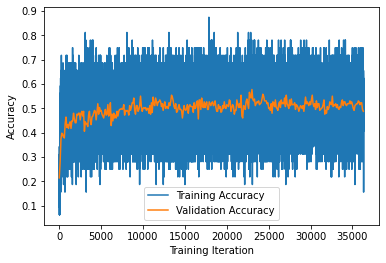

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.175 Validation Loss: 2.172 Accuracy: 0.172 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.173 Validation Loss: 2.172 Accuracy: 0.199 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.174 Validation Loss: 2.172 Accuracy: 0.201 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.177 Validation Loss: 2.172 Accuracy: 0.180 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.175 Validation Loss: 2.172 Accuracy: 0.180 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.174 Validation Loss: 2.172 Accuracy: 0.171 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.173 Validation Loss: 2.172 Accuracy: 0.179 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.172 Validation Loss: 2.172 Accuracy: 0.180 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.171 Validation Loss: 2.172 Accuracy: 0.179 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.170 Validation Loss: 2.172 Accuracy: 0.180 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.169 Validation Loss: 2.172 Accuracy: 0.178 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.169 Validation Loss: 2.172 Accuracy: 0.173 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.167 Validation Loss: 2.172 Accuracy: 0.180 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.166 Validation Loss: 2.172 Accuracy: 0.190 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.165 Validation Loss: 2.172 Accuracy: 0.193 Validation Accuracy: 0.154:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.165 Validation Loss: 2.172 Accuracy: 0.193 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 15 Loss: 2.164 Validation Loss: 2.172 Accuracy: 0.202 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 16 Loss: 2.164 Validation Loss: 2.172 Accuracy: 0.201 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 17 Loss: 2.163 Validation Loss: 2.172 Accuracy: 0.212 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 18 Loss: 2.163 Validation Loss: 2.172 Accuracy: 0.216 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 19 Loss: 2.162 Validation Loss: 2.172 Accuracy: 0.219 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 20 Loss: 2.160 Validation Loss: 2.172 Accuracy: 0.228 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 21 Loss: 2.159 Validation Loss: 2.172 Accuracy: 0.233 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 22 Loss: 2.157 Validation Loss: 2.172 Accuracy: 0.227 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 23 Loss: 2.155 Validation Loss: 2.172 Accuracy: 0.232 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 24 Loss: 2.154 Validation Loss: 2.172 Accuracy: 0.237 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 25 Loss: 2.152 Validation Loss: 2.172 Accuracy: 0.238 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 26 Loss: 2.151 Validation Loss: 2.172 Accuracy: 0.238 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 27 Loss: 2.149 Validation Loss: 2.172 Accuracy: 0.229 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 28 Loss: 2.148 Validation Loss: 2.172 Accuracy: 0.233 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 29 Loss: 2.146 Validation Loss: 2.172 Accuracy: 0.239 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 30 Loss: 2.144 Validation Loss: 2.172 Accuracy: 0.248 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 31 Loss: 2.143 Validation Loss: 2.172 Accuracy: 0.253 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 32 Loss: 2.142 Validation Loss: 2.172 Accuracy: 0.259 Validation Accuracy: 0.154:   1%|          | 15/1480 [00:00<00:09, 148.56it/s]

Epoch: 0 Iteration: 32 Loss: 2.142 Validation Loss: 2.172 Accuracy: 0.259 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 33 Loss: 2.140 Validation Loss: 2.172 Accuracy: 0.265 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 34 Loss: 2.138 Validation Loss: 2.172 Accuracy: 0.267 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 35 Loss: 2.137 Validation Loss: 2.172 Accuracy: 0.273 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 36 Loss: 2.136 Validation Loss: 2.172 Accuracy: 0.273 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 37 Loss: 2.135 Validation Loss: 2.172 Accuracy: 0.284 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 38 Loss: 2.132 Validation Loss: 2.172 Accuracy: 0.290 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 39 Loss: 2.131 Validation Loss: 2.172 Accuracy: 0.295 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 40 Loss: 2.129 Validation Loss: 2.172 Accuracy: 0.297 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 41 Loss: 2.127 Validation Loss: 2.172 Accuracy: 0.302 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 42 Loss: 2.125 Validation Loss: 2.172 Accuracy: 0.304 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 43 Loss: 2.124 Validation Loss: 2.172 Accuracy: 0.307 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 44 Loss: 2.121 Validation Loss: 2.172 Accuracy: 0.315 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 45 Loss: 2.120 Validation Loss: 2.172 Accuracy: 0.321 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 46 Loss: 2.118 Validation Loss: 2.172 Accuracy: 0.337 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 47 Loss: 2.117 Validation Loss: 2.172 Accuracy: 0.338 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 48 Loss: 2.115 Validation Loss: 2.172 Accuracy: 0.341 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 49 Loss: 2.114 Validation Loss: 2.172 Accuracy: 0.338 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 50 Loss: 2.113 Validation Loss: 2.172 Accuracy: 0.340 Validation Accuracy: 0.154:   2%|▏         | 33/1480 [00:00<00:08, 165.72it/s]

Epoch: 0 Iteration: 50 Loss: 2.113 Validation Loss: 2.172 Accuracy: 0.340 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 51 Loss: 2.111 Validation Loss: 2.172 Accuracy: 0.343 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 52 Loss: 2.109 Validation Loss: 2.172 Accuracy: 0.348 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 53 Loss: 2.108 Validation Loss: 2.172 Accuracy: 0.355 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 54 Loss: 2.106 Validation Loss: 2.172 Accuracy: 0.355 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 55 Loss: 2.105 Validation Loss: 2.172 Accuracy: 0.359 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 56 Loss: 2.103 Validation Loss: 2.172 Accuracy: 0.359 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 57 Loss: 2.101 Validation Loss: 2.172 Accuracy: 0.363 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 58 Loss: 2.100 Validation Loss: 2.172 Accuracy: 0.369 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 59 Loss: 2.099 Validation Loss: 2.172 Accuracy: 0.370 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 60 Loss: 2.097 Validation Loss: 2.172 Accuracy: 0.377 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 61 Loss: 2.096 Validation Loss: 2.172 Accuracy: 0.381 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 62 Loss: 2.095 Validation Loss: 2.172 Accuracy: 0.388 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 63 Loss: 2.093 Validation Loss: 2.172 Accuracy: 0.394 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 64 Loss: 2.090 Validation Loss: 2.172 Accuracy: 0.402 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 65 Loss: 2.089 Validation Loss: 2.172 Accuracy: 0.401 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 66 Loss: 2.087 Validation Loss: 2.172 Accuracy: 0.407 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 67 Loss: 2.086 Validation Loss: 2.172 Accuracy: 0.405 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 68 Loss: 2.084 Validation Loss: 2.172 Accuracy: 0.411 Validation Accuracy: 0.154:   3%|▎         | 51/1480 [00:00<00:08, 169.21it/s]

Epoch: 0 Iteration: 68 Loss: 2.084 Validation Loss: 2.172 Accuracy: 0.411 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 69 Loss: 2.082 Validation Loss: 2.172 Accuracy: 0.419 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 70 Loss: 2.080 Validation Loss: 2.172 Accuracy: 0.417 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 71 Loss: 2.079 Validation Loss: 2.172 Accuracy: 0.413 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 72 Loss: 2.076 Validation Loss: 2.172 Accuracy: 0.421 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 73 Loss: 2.074 Validation Loss: 2.172 Accuracy: 0.417 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 74 Loss: 2.073 Validation Loss: 2.172 Accuracy: 0.418 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 75 Loss: 2.071 Validation Loss: 2.172 Accuracy: 0.422 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 76 Loss: 2.070 Validation Loss: 2.172 Accuracy: 0.422 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 77 Loss: 2.068 Validation Loss: 2.172 Accuracy: 0.430 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 78 Loss: 2.067 Validation Loss: 2.172 Accuracy: 0.428 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 79 Loss: 2.065 Validation Loss: 2.172 Accuracy: 0.442 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 80 Loss: 2.064 Validation Loss: 2.172 Accuracy: 0.444 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 81 Loss: 2.062 Validation Loss: 2.172 Accuracy: 0.444 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 82 Loss: 2.060 Validation Loss: 2.172 Accuracy: 0.445 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 83 Loss: 2.060 Validation Loss: 2.172 Accuracy: 0.438 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 84 Loss: 2.059 Validation Loss: 2.172 Accuracy: 0.441 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 85 Loss: 2.059 Validation Loss: 2.172 Accuracy: 0.440 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 86 Loss: 2.057 Validation Loss: 2.172 Accuracy: 0.443 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 87 Loss: 2.056 Validation Loss: 2.172 Accuracy: 0.434 Validation Accuracy: 0.154:   5%|▍         | 69/1480 [00:00<00:08, 171.41it/s]

Epoch: 0 Iteration: 87 Loss: 2.056 Validation Loss: 2.172 Accuracy: 0.434 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 88 Loss: 2.055 Validation Loss: 2.172 Accuracy: 0.445 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 89 Loss: 2.054 Validation Loss: 2.172 Accuracy: 0.442 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 90 Loss: 2.052 Validation Loss: 2.172 Accuracy: 0.450 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 91 Loss: 2.050 Validation Loss: 2.172 Accuracy: 0.464 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 92 Loss: 2.050 Validation Loss: 2.172 Accuracy: 0.466 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 93 Loss: 2.049 Validation Loss: 2.172 Accuracy: 0.472 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 94 Loss: 2.047 Validation Loss: 2.172 Accuracy: 0.477 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 95 Loss: 2.045 Validation Loss: 2.172 Accuracy: 0.486 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 96 Loss: 2.043 Validation Loss: 2.172 Accuracy: 0.484 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 97 Loss: 2.041 Validation Loss: 2.172 Accuracy: 0.495 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 98 Loss: 2.039 Validation Loss: 2.172 Accuracy: 0.487 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 99 Loss: 2.038 Validation Loss: 2.172 Accuracy: 0.484 Validation Accuracy: 0.154:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 100 Loss: 2.036 Validation Loss: 2.020 Accuracy: 0.491 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 101 Loss: 2.034 Validation Loss: 2.020 Accuracy: 0.487 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 102 Loss: 2.033 Validation Loss: 2.020 Accuracy: 0.475 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 103 Loss: 2.031 Validation Loss: 2.020 Accuracy: 0.480 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 104 Loss: 2.030 Validation Loss: 2.020 Accuracy: 0.484 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 105 Loss: 2.028 Validation Loss: 2.020 Accuracy: 0.482 Validation Accuracy: 0.315:   6%|▌         | 88/1480 [00:00<00:07, 174.80it/s]

Epoch: 0 Iteration: 105 Loss: 2.028 Validation Loss: 2.020 Accuracy: 0.482 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 106 Loss: 2.026 Validation Loss: 2.020 Accuracy: 0.476 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 107 Loss: 2.023 Validation Loss: 2.020 Accuracy: 0.477 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 108 Loss: 2.022 Validation Loss: 2.020 Accuracy: 0.484 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 109 Loss: 2.021 Validation Loss: 2.020 Accuracy: 0.486 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 110 Loss: 2.020 Validation Loss: 2.020 Accuracy: 0.478 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 111 Loss: 2.019 Validation Loss: 2.020 Accuracy: 0.477 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 112 Loss: 2.018 Validation Loss: 2.020 Accuracy: 0.484 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 113 Loss: 2.016 Validation Loss: 2.020 Accuracy: 0.485 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 114 Loss: 2.016 Validation Loss: 2.020 Accuracy: 0.481 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 115 Loss: 2.014 Validation Loss: 2.020 Accuracy: 0.475 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 116 Loss: 2.014 Validation Loss: 2.020 Accuracy: 0.487 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 117 Loss: 2.013 Validation Loss: 2.020 Accuracy: 0.487 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 118 Loss: 2.012 Validation Loss: 2.020 Accuracy: 0.488 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 119 Loss: 2.010 Validation Loss: 2.020 Accuracy: 0.484 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 120 Loss: 2.009 Validation Loss: 2.020 Accuracy: 0.488 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 121 Loss: 2.008 Validation Loss: 2.020 Accuracy: 0.494 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 122 Loss: 2.006 Validation Loss: 2.020 Accuracy: 0.506 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 123 Loss: 2.005 Validation Loss: 2.020 Accuracy: 0.502 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 124 Loss: 2.003 Validation Loss: 2.020 Accuracy: 0.503 Validation Accuracy: 0.315:   7%|▋         | 106/1480 [00:00<00:07, 174.22it/s]

Epoch: 0 Iteration: 124 Loss: 2.003 Validation Loss: 2.020 Accuracy: 0.503 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 125 Loss: 2.002 Validation Loss: 2.020 Accuracy: 0.508 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 126 Loss: 2.002 Validation Loss: 2.020 Accuracy: 0.507 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 127 Loss: 2.003 Validation Loss: 2.020 Accuracy: 0.502 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 128 Loss: 2.002 Validation Loss: 2.020 Accuracy: 0.496 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 129 Loss: 2.000 Validation Loss: 2.020 Accuracy: 0.505 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 130 Loss: 1.998 Validation Loss: 2.020 Accuracy: 0.507 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 131 Loss: 1.997 Validation Loss: 2.020 Accuracy: 0.500 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 132 Loss: 1.994 Validation Loss: 2.020 Accuracy: 0.502 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 133 Loss: 1.993 Validation Loss: 2.020 Accuracy: 0.504 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 134 Loss: 1.990 Validation Loss: 2.020 Accuracy: 0.508 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 135 Loss: 1.990 Validation Loss: 2.020 Accuracy: 0.516 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 136 Loss: 1.988 Validation Loss: 2.020 Accuracy: 0.519 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 137 Loss: 1.986 Validation Loss: 2.020 Accuracy: 0.523 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 138 Loss: 1.983 Validation Loss: 2.020 Accuracy: 0.534 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 139 Loss: 1.981 Validation Loss: 2.020 Accuracy: 0.532 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 140 Loss: 1.980 Validation Loss: 2.020 Accuracy: 0.532 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 141 Loss: 1.978 Validation Loss: 2.020 Accuracy: 0.541 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 142 Loss: 1.977 Validation Loss: 2.020 Accuracy: 0.535 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 143 Loss: 1.975 Validation Loss: 2.020 Accuracy: 0.538 Validation Accuracy: 0.315:   8%|▊         | 125/1480 [00:00<00:07, 177.56it/s]

Epoch: 0 Iteration: 143 Loss: 1.975 Validation Loss: 2.020 Accuracy: 0.538 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 144 Loss: 1.973 Validation Loss: 2.020 Accuracy: 0.539 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 145 Loss: 1.972 Validation Loss: 2.020 Accuracy: 0.530 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 146 Loss: 1.968 Validation Loss: 2.020 Accuracy: 0.534 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 147 Loss: 1.966 Validation Loss: 2.020 Accuracy: 0.531 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 148 Loss: 1.964 Validation Loss: 2.020 Accuracy: 0.526 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 149 Loss: 1.962 Validation Loss: 2.020 Accuracy: 0.530 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 150 Loss: 1.961 Validation Loss: 2.020 Accuracy: 0.532 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 151 Loss: 1.959 Validation Loss: 2.020 Accuracy: 0.531 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 152 Loss: 1.959 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 153 Loss: 1.958 Validation Loss: 2.020 Accuracy: 0.542 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 154 Loss: 1.957 Validation Loss: 2.020 Accuracy: 0.539 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 155 Loss: 1.956 Validation Loss: 2.020 Accuracy: 0.545 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 156 Loss: 1.953 Validation Loss: 2.020 Accuracy: 0.545 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 157 Loss: 1.952 Validation Loss: 2.020 Accuracy: 0.552 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 158 Loss: 1.951 Validation Loss: 2.020 Accuracy: 0.556 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 159 Loss: 1.949 Validation Loss: 2.020 Accuracy: 0.548 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 160 Loss: 1.949 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 161 Loss: 1.948 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 162 Loss: 1.945 Validation Loss: 2.020 Accuracy: 0.532 Validation Accuracy: 0.315:  10%|▉         | 144/1480 [00:00<00:07, 179.79it/s]

Epoch: 0 Iteration: 162 Loss: 1.945 Validation Loss: 2.020 Accuracy: 0.532 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 163 Loss: 1.942 Validation Loss: 2.020 Accuracy: 0.530 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 164 Loss: 1.941 Validation Loss: 2.020 Accuracy: 0.529 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 165 Loss: 1.938 Validation Loss: 2.020 Accuracy: 0.535 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 166 Loss: 1.938 Validation Loss: 2.020 Accuracy: 0.527 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 167 Loss: 1.936 Validation Loss: 2.020 Accuracy: 0.528 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 168 Loss: 1.935 Validation Loss: 2.020 Accuracy: 0.522 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 169 Loss: 1.934 Validation Loss: 2.020 Accuracy: 0.530 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 170 Loss: 1.933 Validation Loss: 2.020 Accuracy: 0.535 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 171 Loss: 1.931 Validation Loss: 2.020 Accuracy: 0.536 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 172 Loss: 1.929 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 173 Loss: 1.926 Validation Loss: 2.020 Accuracy: 0.533 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 174 Loss: 1.924 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:00<00:07, 181.15it/s]

Epoch: 0 Iteration: 175 Loss: 1.921 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 176 Loss: 1.921 Validation Loss: 2.020 Accuracy: 0.539 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 177 Loss: 1.920 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 178 Loss: 1.918 Validation Loss: 2.020 Accuracy: 0.541 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 179 Loss: 1.916 Validation Loss: 2.020 Accuracy: 0.536 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 180 Loss: 1.914 Validation Loss: 2.020 Accuracy: 0.539 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 181 Loss: 1.912 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  11%|█         | 163/1480 [00:01<00:07, 181.15it/s]

Epoch: 0 Iteration: 181 Loss: 1.912 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 182 Loss: 1.911 Validation Loss: 2.020 Accuracy: 0.537 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 183 Loss: 1.911 Validation Loss: 2.020 Accuracy: 0.545 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 184 Loss: 1.910 Validation Loss: 2.020 Accuracy: 0.540 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 185 Loss: 1.909 Validation Loss: 2.020 Accuracy: 0.540 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 186 Loss: 1.907 Validation Loss: 2.020 Accuracy: 0.542 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 187 Loss: 1.906 Validation Loss: 2.020 Accuracy: 0.542 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 188 Loss: 1.903 Validation Loss: 2.020 Accuracy: 0.543 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 189 Loss: 1.901 Validation Loss: 2.020 Accuracy: 0.548 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 190 Loss: 1.898 Validation Loss: 2.020 Accuracy: 0.551 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 191 Loss: 1.895 Validation Loss: 2.020 Accuracy: 0.554 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 192 Loss: 1.894 Validation Loss: 2.020 Accuracy: 0.559 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 193 Loss: 1.894 Validation Loss: 2.020 Accuracy: 0.561 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 194 Loss: 1.893 Validation Loss: 2.020 Accuracy: 0.569 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 195 Loss: 1.891 Validation Loss: 2.020 Accuracy: 0.566 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 196 Loss: 1.889 Validation Loss: 2.020 Accuracy: 0.567 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 197 Loss: 1.888 Validation Loss: 2.020 Accuracy: 0.567 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 198 Loss: 1.887 Validation Loss: 2.020 Accuracy: 0.562 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 199 Loss: 1.886 Validation Loss: 2.020 Accuracy: 0.555 Validation Accuracy: 0.315:  12%|█▏        | 182/1480 [00:01<00:07, 179.51it/s]

Epoch: 0 Iteration: 199 Loss: 1.886 Validation Loss: 2.020 Accuracy: 0.555 Validation Accuracy: 0.315:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 200 Loss: 1.886 Validation Loss: 1.866 Accuracy: 0.554 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 201 Loss: 1.885 Validation Loss: 1.866 Accuracy: 0.549 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 202 Loss: 1.884 Validation Loss: 1.866 Accuracy: 0.545 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 203 Loss: 1.883 Validation Loss: 1.866 Accuracy: 0.541 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 204 Loss: 1.879 Validation Loss: 1.866 Accuracy: 0.537 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 205 Loss: 1.877 Validation Loss: 1.866 Accuracy: 0.542 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 206 Loss: 1.876 Validation Loss: 1.866 Accuracy: 0.538 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 207 Loss: 1.875 Validation Loss: 1.866 Accuracy: 0.535 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 208 Loss: 1.875 Validation Loss: 1.866 Accuracy: 0.534 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 209 Loss: 1.874 Validation Loss: 1.866 Accuracy: 0.536 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 210 Loss: 1.873 Validation Loss: 1.866 Accuracy: 0.528 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 211 Loss: 1.873 Validation Loss: 1.866 Accuracy: 0.534 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 212 Loss: 1.871 Validation Loss: 1.866 Accuracy: 0.532 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 213 Loss: 1.870 Validation Loss: 1.866 Accuracy: 0.529 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 214 Loss: 1.868 Validation Loss: 1.866 Accuracy: 0.530 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 215 Loss: 1.866 Validation Loss: 1.866 Accuracy: 0.529 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 216 Loss: 1.863 Validation Loss: 1.866 Accuracy: 0.533 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 217 Loss: 1.860 Validation Loss: 1.866 Accuracy: 0.538 Validation Accuracy: 0.396:  14%|█▎        | 200/1480 [00:01<00:07, 179.42it/s]

Epoch: 0 Iteration: 217 Loss: 1.860 Validation Loss: 1.866 Accuracy: 0.538 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 218 Loss: 1.859 Validation Loss: 1.866 Accuracy: 0.543 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 219 Loss: 1.857 Validation Loss: 1.866 Accuracy: 0.553 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 220 Loss: 1.856 Validation Loss: 1.866 Accuracy: 0.550 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 221 Loss: 1.853 Validation Loss: 1.866 Accuracy: 0.555 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 222 Loss: 1.851 Validation Loss: 1.866 Accuracy: 0.552 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 223 Loss: 1.851 Validation Loss: 1.866 Accuracy: 0.557 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 224 Loss: 1.852 Validation Loss: 1.866 Accuracy: 0.555 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 225 Loss: 1.850 Validation Loss: 1.866 Accuracy: 0.552 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 226 Loss: 1.849 Validation Loss: 1.866 Accuracy: 0.547 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 227 Loss: 1.847 Validation Loss: 1.866 Accuracy: 0.545 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 228 Loss: 1.844 Validation Loss: 1.866 Accuracy: 0.548 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 229 Loss: 1.843 Validation Loss: 1.866 Accuracy: 0.541 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 230 Loss: 1.842 Validation Loss: 1.866 Accuracy: 0.549 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 231 Loss: 1.838 Validation Loss: 1.866 Accuracy: 0.548 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 232 Loss: 1.836 Validation Loss: 1.866 Accuracy: 0.555 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 233 Loss: 1.836 Validation Loss: 1.866 Accuracy: 0.546 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 234 Loss: 1.835 Validation Loss: 1.866 Accuracy: 0.550 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 235 Loss: 1.834 Validation Loss: 1.866 Accuracy: 0.556 Validation Accuracy: 0.396:  15%|█▍        | 218/1480 [00:01<00:07, 176.34it/s]

Epoch: 0 Iteration: 235 Loss: 1.834 Validation Loss: 1.866 Accuracy: 0.556 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 236 Loss: 1.836 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 237 Loss: 1.835 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 238 Loss: 1.834 Validation Loss: 1.866 Accuracy: 0.554 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 239 Loss: 1.833 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 240 Loss: 1.830 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 241 Loss: 1.828 Validation Loss: 1.866 Accuracy: 0.561 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 242 Loss: 1.826 Validation Loss: 1.866 Accuracy: 0.559 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 243 Loss: 1.824 Validation Loss: 1.866 Accuracy: 0.569 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 244 Loss: 1.822 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 245 Loss: 1.820 Validation Loss: 1.866 Accuracy: 0.560 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 246 Loss: 1.817 Validation Loss: 1.866 Accuracy: 0.567 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 247 Loss: 1.816 Validation Loss: 1.866 Accuracy: 0.575 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 248 Loss: 1.814 Validation Loss: 1.866 Accuracy: 0.582 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 249 Loss: 1.814 Validation Loss: 1.866 Accuracy: 0.566 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 250 Loss: 1.812 Validation Loss: 1.866 Accuracy: 0.563 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 251 Loss: 1.812 Validation Loss: 1.866 Accuracy: 0.557 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 252 Loss: 1.810 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 253 Loss: 1.806 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  16%|█▌        | 236/1480 [00:01<00:07, 176.61it/s]

Epoch: 0 Iteration: 253 Loss: 1.806 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 254 Loss: 1.803 Validation Loss: 1.866 Accuracy: 0.569 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 255 Loss: 1.802 Validation Loss: 1.866 Accuracy: 0.567 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 256 Loss: 1.798 Validation Loss: 1.866 Accuracy: 0.567 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 257 Loss: 1.796 Validation Loss: 1.866 Accuracy: 0.563 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 258 Loss: 1.791 Validation Loss: 1.866 Accuracy: 0.569 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 259 Loss: 1.791 Validation Loss: 1.866 Accuracy: 0.570 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 260 Loss: 1.791 Validation Loss: 1.866 Accuracy: 0.573 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 261 Loss: 1.788 Validation Loss: 1.866 Accuracy: 0.580 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 262 Loss: 1.786 Validation Loss: 1.866 Accuracy: 0.578 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 263 Loss: 1.783 Validation Loss: 1.866 Accuracy: 0.586 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 264 Loss: 1.781 Validation Loss: 1.866 Accuracy: 0.589 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 265 Loss: 1.780 Validation Loss: 1.866 Accuracy: 0.585 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 266 Loss: 1.781 Validation Loss: 1.866 Accuracy: 0.582 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 267 Loss: 1.778 Validation Loss: 1.866 Accuracy: 0.582 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 268 Loss: 1.776 Validation Loss: 1.866 Accuracy: 0.573 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 269 Loss: 1.774 Validation Loss: 1.866 Accuracy: 0.579 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 270 Loss: 1.772 Validation Loss: 1.866 Accuracy: 0.577 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 271 Loss: 1.770 Validation Loss: 1.866 Accuracy: 0.577 Validation Accuracy: 0.396:  17%|█▋        | 254/1480 [00:01<00:07, 174.50it/s]

Epoch: 0 Iteration: 271 Loss: 1.770 Validation Loss: 1.866 Accuracy: 0.577 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 272 Loss: 1.769 Validation Loss: 1.866 Accuracy: 0.573 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 273 Loss: 1.769 Validation Loss: 1.866 Accuracy: 0.570 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 274 Loss: 1.769 Validation Loss: 1.866 Accuracy: 0.559 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 275 Loss: 1.769 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 276 Loss: 1.768 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 277 Loss: 1.767 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 278 Loss: 1.767 Validation Loss: 1.866 Accuracy: 0.563 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 279 Loss: 1.765 Validation Loss: 1.866 Accuracy: 0.570 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 280 Loss: 1.762 Validation Loss: 1.866 Accuracy: 0.571 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 281 Loss: 1.762 Validation Loss: 1.866 Accuracy: 0.568 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 282 Loss: 1.760 Validation Loss: 1.866 Accuracy: 0.575 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 283 Loss: 1.760 Validation Loss: 1.866 Accuracy: 0.572 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 284 Loss: 1.761 Validation Loss: 1.866 Accuracy: 0.571 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 285 Loss: 1.758 Validation Loss: 1.866 Accuracy: 0.580 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 286 Loss: 1.755 Validation Loss: 1.866 Accuracy: 0.574 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 287 Loss: 1.754 Validation Loss: 1.866 Accuracy: 0.576 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 288 Loss: 1.754 Validation Loss: 1.866 Accuracy: 0.574 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 289 Loss: 1.752 Validation Loss: 1.866 Accuracy: 0.570 Validation Accuracy: 0.396:  18%|█▊        | 272/1480 [00:01<00:07, 172.12it/s]

Epoch: 0 Iteration: 289 Loss: 1.752 Validation Loss: 1.866 Accuracy: 0.570 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 290 Loss: 1.750 Validation Loss: 1.866 Accuracy: 0.577 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 291 Loss: 1.748 Validation Loss: 1.866 Accuracy: 0.578 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 292 Loss: 1.748 Validation Loss: 1.866 Accuracy: 0.569 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 293 Loss: 1.746 Validation Loss: 1.866 Accuracy: 0.568 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 294 Loss: 1.745 Validation Loss: 1.866 Accuracy: 0.563 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 295 Loss: 1.743 Validation Loss: 1.866 Accuracy: 0.555 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 296 Loss: 1.741 Validation Loss: 1.866 Accuracy: 0.562 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 297 Loss: 1.740 Validation Loss: 1.866 Accuracy: 0.554 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 298 Loss: 1.739 Validation Loss: 1.866 Accuracy: 0.550 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 299 Loss: 1.737 Validation Loss: 1.866 Accuracy: 0.558 Validation Accuracy: 0.396:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 300 Loss: 1.736 Validation Loss: 1.713 Accuracy: 0.552 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 301 Loss: 1.732 Validation Loss: 1.713 Accuracy: 0.556 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 302 Loss: 1.730 Validation Loss: 1.713 Accuracy: 0.562 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 303 Loss: 1.728 Validation Loss: 1.713 Accuracy: 0.557 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 304 Loss: 1.727 Validation Loss: 1.713 Accuracy: 0.565 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 305 Loss: 1.726 Validation Loss: 1.713 Accuracy: 0.575 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 306 Loss: 1.724 Validation Loss: 1.713 Accuracy: 0.571 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 307 Loss: 1.722 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  20%|█▉        | 290/1480 [00:01<00:06, 173.75it/s]

Epoch: 0 Iteration: 307 Loss: 1.722 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 308 Loss: 1.721 Validation Loss: 1.713 Accuracy: 0.583 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 309 Loss: 1.718 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 310 Loss: 1.716 Validation Loss: 1.713 Accuracy: 0.575 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 311 Loss: 1.714 Validation Loss: 1.713 Accuracy: 0.571 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 312 Loss: 1.712 Validation Loss: 1.713 Accuracy: 0.571 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 313 Loss: 1.711 Validation Loss: 1.713 Accuracy: 0.577 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 314 Loss: 1.708 Validation Loss: 1.713 Accuracy: 0.573 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 315 Loss: 1.706 Validation Loss: 1.713 Accuracy: 0.567 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 316 Loss: 1.703 Validation Loss: 1.713 Accuracy: 0.575 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 317 Loss: 1.699 Validation Loss: 1.713 Accuracy: 0.582 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 318 Loss: 1.698 Validation Loss: 1.713 Accuracy: 0.583 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 319 Loss: 1.696 Validation Loss: 1.713 Accuracy: 0.588 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 320 Loss: 1.695 Validation Loss: 1.713 Accuracy: 0.590 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 321 Loss: 1.697 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 322 Loss: 1.696 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 323 Loss: 1.695 Validation Loss: 1.713 Accuracy: 0.577 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 324 Loss: 1.694 Validation Loss: 1.713 Accuracy: 0.575 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 325 Loss: 1.692 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  21%|██        | 308/1480 [00:01<00:06, 170.90it/s]

Epoch: 0 Iteration: 325 Loss: 1.692 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 326 Loss: 1.693 Validation Loss: 1.713 Accuracy: 0.569 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 327 Loss: 1.691 Validation Loss: 1.713 Accuracy: 0.569 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 328 Loss: 1.690 Validation Loss: 1.713 Accuracy: 0.566 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 329 Loss: 1.688 Validation Loss: 1.713 Accuracy: 0.566 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 330 Loss: 1.689 Validation Loss: 1.713 Accuracy: 0.566 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 331 Loss: 1.690 Validation Loss: 1.713 Accuracy: 0.570 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 332 Loss: 1.689 Validation Loss: 1.713 Accuracy: 0.562 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 333 Loss: 1.689 Validation Loss: 1.713 Accuracy: 0.559 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 334 Loss: 1.689 Validation Loss: 1.713 Accuracy: 0.562 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 335 Loss: 1.688 Validation Loss: 1.713 Accuracy: 0.560 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 336 Loss: 1.688 Validation Loss: 1.713 Accuracy: 0.555 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 337 Loss: 1.689 Validation Loss: 1.713 Accuracy: 0.548 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 338 Loss: 1.686 Validation Loss: 1.713 Accuracy: 0.544 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 339 Loss: 1.687 Validation Loss: 1.713 Accuracy: 0.537 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 340 Loss: 1.684 Validation Loss: 1.713 Accuracy: 0.539 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 341 Loss: 1.680 Validation Loss: 1.713 Accuracy: 0.545 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 342 Loss: 1.679 Validation Loss: 1.713 Accuracy: 0.553 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 343 Loss: 1.676 Validation Loss: 1.713 Accuracy: 0.559 Validation Accuracy: 0.439:  22%|██▏       | 326/1480 [00:01<00:06, 171.73it/s]

Epoch: 0 Iteration: 343 Loss: 1.676 Validation Loss: 1.713 Accuracy: 0.559 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:01<00:06, 172.20it/s]

Epoch: 0 Iteration: 344 Loss: 1.673 Validation Loss: 1.713 Accuracy: 0.566 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:01<00:06, 172.20it/s]

Epoch: 0 Iteration: 345 Loss: 1.673 Validation Loss: 1.713 Accuracy: 0.568 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:01<00:06, 172.20it/s]

Epoch: 0 Iteration: 346 Loss: 1.670 Validation Loss: 1.713 Accuracy: 0.571 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:01<00:06, 172.20it/s]

Epoch: 0 Iteration: 347 Loss: 1.667 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:01<00:06, 172.20it/s]

Epoch: 0 Iteration: 348 Loss: 1.662 Validation Loss: 1.713 Accuracy: 0.589 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 349 Loss: 1.662 Validation Loss: 1.713 Accuracy: 0.591 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 350 Loss: 1.659 Validation Loss: 1.713 Accuracy: 0.584 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 351 Loss: 1.656 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 352 Loss: 1.653 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 353 Loss: 1.648 Validation Loss: 1.713 Accuracy: 0.584 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 354 Loss: 1.646 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 355 Loss: 1.644 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 356 Loss: 1.642 Validation Loss: 1.713 Accuracy: 0.587 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 357 Loss: 1.640 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 358 Loss: 1.641 Validation Loss: 1.713 Accuracy: 0.567 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 359 Loss: 1.639 Validation Loss: 1.713 Accuracy: 0.565 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 360 Loss: 1.638 Validation Loss: 1.713 Accuracy: 0.577 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 361 Loss: 1.638 Validation Loss: 1.713 Accuracy: 0.576 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 362 Loss: 1.637 Validation Loss: 1.713 Accuracy: 0.578 Validation Accuracy: 0.439:  23%|██▎       | 344/1480 [00:02<00:06, 172.20it/s]

Epoch: 0 Iteration: 362 Loss: 1.637 Validation Loss: 1.713 Accuracy: 0.578 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 363 Loss: 1.637 Validation Loss: 1.713 Accuracy: 0.578 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 364 Loss: 1.637 Validation Loss: 1.713 Accuracy: 0.582 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 365 Loss: 1.635 Validation Loss: 1.713 Accuracy: 0.580 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 366 Loss: 1.633 Validation Loss: 1.713 Accuracy: 0.570 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 367 Loss: 1.634 Validation Loss: 1.713 Accuracy: 0.581 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 368 Loss: 1.637 Validation Loss: 1.713 Accuracy: 0.584 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 369 Loss: 1.635 Validation Loss: 1.713 Accuracy: 0.585 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 370 Loss: 1.632 Validation Loss: 1.713 Accuracy: 0.582 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 371 Loss: 1.631 Validation Loss: 1.713 Accuracy: 0.594 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 372 Loss: 1.631 Validation Loss: 1.713 Accuracy: 0.593 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 373 Loss: 1.632 Validation Loss: 1.713 Accuracy: 0.582 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 374 Loss: 1.630 Validation Loss: 1.713 Accuracy: 0.578 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 375 Loss: 1.628 Validation Loss: 1.713 Accuracy: 0.584 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 376 Loss: 1.628 Validation Loss: 1.713 Accuracy: 0.588 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 377 Loss: 1.624 Validation Loss: 1.713 Accuracy: 0.594 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 378 Loss: 1.622 Validation Loss: 1.713 Accuracy: 0.593 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 379 Loss: 1.619 Validation Loss: 1.713 Accuracy: 0.595 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 380 Loss: 1.617 Validation Loss: 1.713 Accuracy: 0.598 Validation Accuracy: 0.439:  25%|██▍       | 363/1480 [00:02<00:06, 174.95it/s]

Epoch: 0 Iteration: 380 Loss: 1.617 Validation Loss: 1.713 Accuracy: 0.598 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 381 Loss: 1.616 Validation Loss: 1.713 Accuracy: 0.587 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 382 Loss: 1.613 Validation Loss: 1.713 Accuracy: 0.583 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 383 Loss: 1.611 Validation Loss: 1.713 Accuracy: 0.589 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 384 Loss: 1.609 Validation Loss: 1.713 Accuracy: 0.590 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 385 Loss: 1.609 Validation Loss: 1.713 Accuracy: 0.590 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 386 Loss: 1.609 Validation Loss: 1.713 Accuracy: 0.591 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 387 Loss: 1.606 Validation Loss: 1.713 Accuracy: 0.582 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 388 Loss: 1.602 Validation Loss: 1.713 Accuracy: 0.589 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 389 Loss: 1.601 Validation Loss: 1.713 Accuracy: 0.590 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 390 Loss: 1.599 Validation Loss: 1.713 Accuracy: 0.591 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 391 Loss: 1.598 Validation Loss: 1.713 Accuracy: 0.591 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 392 Loss: 1.595 Validation Loss: 1.713 Accuracy: 0.598 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 393 Loss: 1.591 Validation Loss: 1.713 Accuracy: 0.598 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 394 Loss: 1.593 Validation Loss: 1.713 Accuracy: 0.602 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 395 Loss: 1.591 Validation Loss: 1.713 Accuracy: 0.602 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 396 Loss: 1.590 Validation Loss: 1.713 Accuracy: 0.605 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 397 Loss: 1.589 Validation Loss: 1.713 Accuracy: 0.610 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 398 Loss: 1.588 Validation Loss: 1.713 Accuracy: 0.602 Validation Accuracy: 0.439:  26%|██▌       | 381/1480 [00:02<00:06, 174.14it/s]

Epoch: 0 Iteration: 398 Loss: 1.588 Validation Loss: 1.713 Accuracy: 0.602 Validation Accuracy: 0.439:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 399 Loss: 1.589 Validation Loss: 1.713 Accuracy: 0.603 Validation Accuracy: 0.439:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 400 Loss: 1.589 Validation Loss: 1.571 Accuracy: 0.604 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 401 Loss: 1.587 Validation Loss: 1.571 Accuracy: 0.609 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 402 Loss: 1.586 Validation Loss: 1.571 Accuracy: 0.604 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 403 Loss: 1.585 Validation Loss: 1.571 Accuracy: 0.607 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 404 Loss: 1.582 Validation Loss: 1.571 Accuracy: 0.601 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 405 Loss: 1.580 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 406 Loss: 1.575 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 407 Loss: 1.574 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 408 Loss: 1.574 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 409 Loss: 1.574 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 410 Loss: 1.573 Validation Loss: 1.571 Accuracy: 0.579 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 411 Loss: 1.572 Validation Loss: 1.571 Accuracy: 0.583 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 412 Loss: 1.572 Validation Loss: 1.571 Accuracy: 0.584 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 413 Loss: 1.570 Validation Loss: 1.571 Accuracy: 0.582 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 414 Loss: 1.566 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 415 Loss: 1.563 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 416 Loss: 1.559 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  27%|██▋       | 399/1480 [00:02<00:06, 173.61it/s]

Epoch: 0 Iteration: 416 Loss: 1.559 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 417 Loss: 1.558 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 418 Loss: 1.557 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 419 Loss: 1.553 Validation Loss: 1.571 Accuracy: 0.590 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 420 Loss: 1.550 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 421 Loss: 1.550 Validation Loss: 1.571 Accuracy: 0.584 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 422 Loss: 1.551 Validation Loss: 1.571 Accuracy: 0.587 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 423 Loss: 1.548 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 424 Loss: 1.549 Validation Loss: 1.571 Accuracy: 0.584 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 425 Loss: 1.547 Validation Loss: 1.571 Accuracy: 0.592 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 426 Loss: 1.548 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 427 Loss: 1.548 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 428 Loss: 1.548 Validation Loss: 1.571 Accuracy: 0.584 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 429 Loss: 1.545 Validation Loss: 1.571 Accuracy: 0.585 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 430 Loss: 1.543 Validation Loss: 1.571 Accuracy: 0.596 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 431 Loss: 1.541 Validation Loss: 1.571 Accuracy: 0.597 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 432 Loss: 1.540 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 433 Loss: 1.541 Validation Loss: 1.571 Accuracy: 0.596 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 434 Loss: 1.540 Validation Loss: 1.571 Accuracy: 0.602 Validation Accuracy: 0.472:  28%|██▊       | 417/1480 [00:02<00:06, 170.67it/s]

Epoch: 0 Iteration: 434 Loss: 1.540 Validation Loss: 1.571 Accuracy: 0.602 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 435 Loss: 1.540 Validation Loss: 1.571 Accuracy: 0.593 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 436 Loss: 1.541 Validation Loss: 1.571 Accuracy: 0.593 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 437 Loss: 1.542 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 438 Loss: 1.543 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 439 Loss: 1.543 Validation Loss: 1.571 Accuracy: 0.597 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 440 Loss: 1.542 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 441 Loss: 1.537 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 442 Loss: 1.535 Validation Loss: 1.571 Accuracy: 0.592 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 443 Loss: 1.535 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 444 Loss: 1.532 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 445 Loss: 1.532 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 446 Loss: 1.530 Validation Loss: 1.571 Accuracy: 0.603 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 447 Loss: 1.528 Validation Loss: 1.571 Accuracy: 0.604 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 448 Loss: 1.525 Validation Loss: 1.571 Accuracy: 0.609 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 449 Loss: 1.524 Validation Loss: 1.571 Accuracy: 0.613 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 450 Loss: 1.524 Validation Loss: 1.571 Accuracy: 0.607 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 451 Loss: 1.523 Validation Loss: 1.571 Accuracy: 0.605 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 452 Loss: 1.520 Validation Loss: 1.571 Accuracy: 0.602 Validation Accuracy: 0.472:  29%|██▉       | 435/1480 [00:02<00:06, 173.22it/s]

Epoch: 0 Iteration: 452 Loss: 1.520 Validation Loss: 1.571 Accuracy: 0.602 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 453 Loss: 1.520 Validation Loss: 1.571 Accuracy: 0.596 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 454 Loss: 1.521 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 455 Loss: 1.521 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 456 Loss: 1.518 Validation Loss: 1.571 Accuracy: 0.587 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 457 Loss: 1.514 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 458 Loss: 1.510 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 459 Loss: 1.510 Validation Loss: 1.571 Accuracy: 0.581 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 460 Loss: 1.508 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 461 Loss: 1.509 Validation Loss: 1.571 Accuracy: 0.589 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 462 Loss: 1.508 Validation Loss: 1.571 Accuracy: 0.586 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 463 Loss: 1.509 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 464 Loss: 1.506 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 465 Loss: 1.503 Validation Loss: 1.571 Accuracy: 0.605 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 466 Loss: 1.504 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 467 Loss: 1.504 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 468 Loss: 1.503 Validation Loss: 1.571 Accuracy: 0.590 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 469 Loss: 1.502 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 470 Loss: 1.505 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  31%|███       | 453/1480 [00:02<00:05, 174.02it/s]

Epoch: 0 Iteration: 470 Loss: 1.505 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 471 Loss: 1.503 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 472 Loss: 1.504 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 473 Loss: 1.504 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 474 Loss: 1.500 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 475 Loss: 1.497 Validation Loss: 1.571 Accuracy: 0.587 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 476 Loss: 1.498 Validation Loss: 1.571 Accuracy: 0.590 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 477 Loss: 1.500 Validation Loss: 1.571 Accuracy: 0.597 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 478 Loss: 1.501 Validation Loss: 1.571 Accuracy: 0.597 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 479 Loss: 1.499 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 480 Loss: 1.498 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 481 Loss: 1.497 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 482 Loss: 1.497 Validation Loss: 1.571 Accuracy: 0.609 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 483 Loss: 1.494 Validation Loss: 1.571 Accuracy: 0.609 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 484 Loss: 1.496 Validation Loss: 1.571 Accuracy: 0.598 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 485 Loss: 1.498 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 486 Loss: 1.497 Validation Loss: 1.571 Accuracy: 0.593 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 487 Loss: 1.495 Validation Loss: 1.571 Accuracy: 0.588 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 488 Loss: 1.493 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  32%|███▏      | 471/1480 [00:02<00:05, 173.41it/s]

Epoch: 0 Iteration: 488 Loss: 1.493 Validation Loss: 1.571 Accuracy: 0.591 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 489 Loss: 1.492 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 490 Loss: 1.490 Validation Loss: 1.571 Accuracy: 0.594 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 491 Loss: 1.487 Validation Loss: 1.571 Accuracy: 0.595 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 492 Loss: 1.485 Validation Loss: 1.571 Accuracy: 0.597 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 493 Loss: 1.480 Validation Loss: 1.571 Accuracy: 0.599 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 494 Loss: 1.480 Validation Loss: 1.571 Accuracy: 0.603 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 495 Loss: 1.477 Validation Loss: 1.571 Accuracy: 0.612 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 496 Loss: 1.476 Validation Loss: 1.571 Accuracy: 0.616 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 497 Loss: 1.473 Validation Loss: 1.571 Accuracy: 0.622 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 498 Loss: 1.469 Validation Loss: 1.571 Accuracy: 0.627 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 499 Loss: 1.466 Validation Loss: 1.571 Accuracy: 0.622 Validation Accuracy: 0.472:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 500 Loss: 1.464 Validation Loss: 1.447 Accuracy: 0.621 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 501 Loss: 1.463 Validation Loss: 1.447 Accuracy: 0.619 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 502 Loss: 1.464 Validation Loss: 1.447 Accuracy: 0.608 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 503 Loss: 1.463 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 504 Loss: 1.459 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 505 Loss: 1.456 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 506 Loss: 1.455 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  33%|███▎      | 489/1480 [00:02<00:05, 173.14it/s]

Epoch: 0 Iteration: 506 Loss: 1.455 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 507 Loss: 1.452 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 508 Loss: 1.453 Validation Loss: 1.447 Accuracy: 0.595 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 509 Loss: 1.450 Validation Loss: 1.447 Accuracy: 0.600 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 510 Loss: 1.447 Validation Loss: 1.447 Accuracy: 0.600 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 511 Loss: 1.449 Validation Loss: 1.447 Accuracy: 0.600 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 512 Loss: 1.448 Validation Loss: 1.447 Accuracy: 0.606 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 513 Loss: 1.448 Validation Loss: 1.447 Accuracy: 0.603 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 514 Loss: 1.446 Validation Loss: 1.447 Accuracy: 0.604 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 515 Loss: 1.447 Validation Loss: 1.447 Accuracy: 0.602 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 516 Loss: 1.445 Validation Loss: 1.447 Accuracy: 0.604 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 517 Loss: 1.442 Validation Loss: 1.447 Accuracy: 0.601 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 518 Loss: 1.442 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 519 Loss: 1.443 Validation Loss: 1.447 Accuracy: 0.604 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 520 Loss: 1.441 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:02<00:05, 171.14it/s]

Epoch: 0 Iteration: 521 Loss: 1.441 Validation Loss: 1.447 Accuracy: 0.601 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:03<00:05, 171.14it/s]

Epoch: 0 Iteration: 522 Loss: 1.439 Validation Loss: 1.447 Accuracy: 0.599 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:03<00:05, 171.14it/s]

Epoch: 0 Iteration: 523 Loss: 1.440 Validation Loss: 1.447 Accuracy: 0.596 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:03<00:05, 171.14it/s]

Epoch: 0 Iteration: 524 Loss: 1.441 Validation Loss: 1.447 Accuracy: 0.597 Validation Accuracy: 0.496:  34%|███▍      | 507/1480 [00:03<00:05, 171.14it/s]

Epoch: 0 Iteration: 524 Loss: 1.441 Validation Loss: 1.447 Accuracy: 0.597 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 525 Loss: 1.439 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 526 Loss: 1.437 Validation Loss: 1.447 Accuracy: 0.608 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 527 Loss: 1.437 Validation Loss: 1.447 Accuracy: 0.599 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 528 Loss: 1.434 Validation Loss: 1.447 Accuracy: 0.600 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 529 Loss: 1.436 Validation Loss: 1.447 Accuracy: 0.599 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 530 Loss: 1.433 Validation Loss: 1.447 Accuracy: 0.605 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 531 Loss: 1.430 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 532 Loss: 1.432 Validation Loss: 1.447 Accuracy: 0.612 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 533 Loss: 1.433 Validation Loss: 1.447 Accuracy: 0.616 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 534 Loss: 1.431 Validation Loss: 1.447 Accuracy: 0.624 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 535 Loss: 1.431 Validation Loss: 1.447 Accuracy: 0.618 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 536 Loss: 1.432 Validation Loss: 1.447 Accuracy: 0.614 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 537 Loss: 1.434 Validation Loss: 1.447 Accuracy: 0.615 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 538 Loss: 1.436 Validation Loss: 1.447 Accuracy: 0.611 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 539 Loss: 1.432 Validation Loss: 1.447 Accuracy: 0.621 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 540 Loss: 1.434 Validation Loss: 1.447 Accuracy: 0.628 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 541 Loss: 1.433 Validation Loss: 1.447 Accuracy: 0.621 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 542 Loss: 1.427 Validation Loss: 1.447 Accuracy: 0.630 Validation Accuracy: 0.496:  35%|███▌      | 525/1480 [00:03<00:05, 172.05it/s]

Epoch: 0 Iteration: 542 Loss: 1.427 Validation Loss: 1.447 Accuracy: 0.630 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 543 Loss: 1.423 Validation Loss: 1.447 Accuracy: 0.630 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 544 Loss: 1.420 Validation Loss: 1.447 Accuracy: 0.628 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 545 Loss: 1.419 Validation Loss: 1.447 Accuracy: 0.635 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 546 Loss: 1.420 Validation Loss: 1.447 Accuracy: 0.633 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 547 Loss: 1.420 Validation Loss: 1.447 Accuracy: 0.635 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 548 Loss: 1.422 Validation Loss: 1.447 Accuracy: 0.631 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 549 Loss: 1.417 Validation Loss: 1.447 Accuracy: 0.631 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 550 Loss: 1.419 Validation Loss: 1.447 Accuracy: 0.616 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 551 Loss: 1.418 Validation Loss: 1.447 Accuracy: 0.619 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 552 Loss: 1.416 Validation Loss: 1.447 Accuracy: 0.606 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 553 Loss: 1.412 Validation Loss: 1.447 Accuracy: 0.612 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 554 Loss: 1.414 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 555 Loss: 1.409 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 556 Loss: 1.405 Validation Loss: 1.447 Accuracy: 0.610 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 557 Loss: 1.403 Validation Loss: 1.447 Accuracy: 0.618 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 558 Loss: 1.398 Validation Loss: 1.447 Accuracy: 0.629 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 559 Loss: 1.394 Validation Loss: 1.447 Accuracy: 0.630 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 560 Loss: 1.392 Validation Loss: 1.447 Accuracy: 0.633 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 561 Loss: 1.390 Validation Loss: 1.447 Accuracy: 0.641 Validation Accuracy: 0.496:  37%|███▋      | 543/1480 [00:03<00:05, 170.84it/s]

Epoch: 0 Iteration: 561 Loss: 1.390 Validation Loss: 1.447 Accuracy: 0.641 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 562 Loss: 1.391 Validation Loss: 1.447 Accuracy: 0.650 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 563 Loss: 1.389 Validation Loss: 1.447 Accuracy: 0.648 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 564 Loss: 1.389 Validation Loss: 1.447 Accuracy: 0.652 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 565 Loss: 1.389 Validation Loss: 1.447 Accuracy: 0.646 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 566 Loss: 1.385 Validation Loss: 1.447 Accuracy: 0.657 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 567 Loss: 1.382 Validation Loss: 1.447 Accuracy: 0.651 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 568 Loss: 1.377 Validation Loss: 1.447 Accuracy: 0.648 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 569 Loss: 1.378 Validation Loss: 1.447 Accuracy: 0.646 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 570 Loss: 1.374 Validation Loss: 1.447 Accuracy: 0.653 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 571 Loss: 1.372 Validation Loss: 1.447 Accuracy: 0.648 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 572 Loss: 1.368 Validation Loss: 1.447 Accuracy: 0.647 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 573 Loss: 1.364 Validation Loss: 1.447 Accuracy: 0.651 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 574 Loss: 1.362 Validation Loss: 1.447 Accuracy: 0.647 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 575 Loss: 1.362 Validation Loss: 1.447 Accuracy: 0.645 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 576 Loss: 1.363 Validation Loss: 1.447 Accuracy: 0.636 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 577 Loss: 1.362 Validation Loss: 1.447 Accuracy: 0.635 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 578 Loss: 1.365 Validation Loss: 1.447 Accuracy: 0.631 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 579 Loss: 1.369 Validation Loss: 1.447 Accuracy: 0.620 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 580 Loss: 1.368 Validation Loss: 1.447 Accuracy: 0.616 Validation Accuracy: 0.496:  38%|███▊      | 562/1480 [00:03<00:05, 173.98it/s]

Epoch: 0 Iteration: 580 Loss: 1.368 Validation Loss: 1.447 Accuracy: 0.616 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 581 Loss: 1.368 Validation Loss: 1.447 Accuracy: 0.611 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 582 Loss: 1.368 Validation Loss: 1.447 Accuracy: 0.603 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 583 Loss: 1.369 Validation Loss: 1.447 Accuracy: 0.601 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 584 Loss: 1.369 Validation Loss: 1.447 Accuracy: 0.598 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 585 Loss: 1.372 Validation Loss: 1.447 Accuracy: 0.590 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 586 Loss: 1.372 Validation Loss: 1.447 Accuracy: 0.591 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 587 Loss: 1.373 Validation Loss: 1.447 Accuracy: 0.587 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 588 Loss: 1.372 Validation Loss: 1.447 Accuracy: 0.591 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 589 Loss: 1.375 Validation Loss: 1.447 Accuracy: 0.595 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 590 Loss: 1.376 Validation Loss: 1.447 Accuracy: 0.596 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 591 Loss: 1.375 Validation Loss: 1.447 Accuracy: 0.607 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 592 Loss: 1.378 Validation Loss: 1.447 Accuracy: 0.614 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 593 Loss: 1.379 Validation Loss: 1.447 Accuracy: 0.609 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 594 Loss: 1.379 Validation Loss: 1.447 Accuracy: 0.612 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 595 Loss: 1.379 Validation Loss: 1.447 Accuracy: 0.623 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 596 Loss: 1.376 Validation Loss: 1.447 Accuracy: 0.624 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 597 Loss: 1.374 Validation Loss: 1.447 Accuracy: 0.633 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 598 Loss: 1.372 Validation Loss: 1.447 Accuracy: 0.634 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 599 Loss: 1.370 Validation Loss: 1.447 Accuracy: 0.641 Validation Accuracy: 0.496:  39%|███▉      | 581/1480 [00:03<00:05, 176.76it/s]

Epoch: 0 Iteration: 599 Loss: 1.370 Validation Loss: 1.447 Accuracy: 0.641 Validation Accuracy: 0.496:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 600 Loss: 1.368 Validation Loss: 1.344 Accuracy: 0.644 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 601 Loss: 1.364 Validation Loss: 1.344 Accuracy: 0.639 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 602 Loss: 1.365 Validation Loss: 1.344 Accuracy: 0.636 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 603 Loss: 1.364 Validation Loss: 1.344 Accuracy: 0.641 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 604 Loss: 1.367 Validation Loss: 1.344 Accuracy: 0.624 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 605 Loss: 1.362 Validation Loss: 1.344 Accuracy: 0.622 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 606 Loss: 1.360 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 607 Loss: 1.355 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 608 Loss: 1.353 Validation Loss: 1.344 Accuracy: 0.625 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 609 Loss: 1.347 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 610 Loss: 1.346 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 611 Loss: 1.344 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 612 Loss: 1.342 Validation Loss: 1.344 Accuracy: 0.636 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 613 Loss: 1.340 Validation Loss: 1.344 Accuracy: 0.632 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 614 Loss: 1.342 Validation Loss: 1.344 Accuracy: 0.642 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 615 Loss: 1.340 Validation Loss: 1.344 Accuracy: 0.646 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 616 Loss: 1.341 Validation Loss: 1.344 Accuracy: 0.645 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 617 Loss: 1.341 Validation Loss: 1.344 Accuracy: 0.637 Validation Accuracy: 0.518:  41%|████      | 600/1480 [00:03<00:04, 178.83it/s]

Epoch: 0 Iteration: 617 Loss: 1.341 Validation Loss: 1.344 Accuracy: 0.637 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 618 Loss: 1.341 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 619 Loss: 1.339 Validation Loss: 1.344 Accuracy: 0.622 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 620 Loss: 1.339 Validation Loss: 1.344 Accuracy: 0.618 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 621 Loss: 1.341 Validation Loss: 1.344 Accuracy: 0.610 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 622 Loss: 1.338 Validation Loss: 1.344 Accuracy: 0.615 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 623 Loss: 1.338 Validation Loss: 1.344 Accuracy: 0.621 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 624 Loss: 1.334 Validation Loss: 1.344 Accuracy: 0.620 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 625 Loss: 1.337 Validation Loss: 1.344 Accuracy: 0.614 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 626 Loss: 1.337 Validation Loss: 1.344 Accuracy: 0.616 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 627 Loss: 1.340 Validation Loss: 1.344 Accuracy: 0.626 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 628 Loss: 1.342 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 629 Loss: 1.344 Validation Loss: 1.344 Accuracy: 0.631 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 630 Loss: 1.340 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 631 Loss: 1.338 Validation Loss: 1.344 Accuracy: 0.637 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 632 Loss: 1.336 Validation Loss: 1.344 Accuracy: 0.626 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 633 Loss: 1.336 Validation Loss: 1.344 Accuracy: 0.620 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 634 Loss: 1.333 Validation Loss: 1.344 Accuracy: 0.621 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 635 Loss: 1.332 Validation Loss: 1.344 Accuracy: 0.624 Validation Accuracy: 0.518:  42%|████▏     | 618/1480 [00:03<00:04, 173.78it/s]

Epoch: 0 Iteration: 635 Loss: 1.332 Validation Loss: 1.344 Accuracy: 0.624 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 636 Loss: 1.328 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 637 Loss: 1.325 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 638 Loss: 1.322 Validation Loss: 1.344 Accuracy: 0.631 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 639 Loss: 1.325 Validation Loss: 1.344 Accuracy: 0.633 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 640 Loss: 1.325 Validation Loss: 1.344 Accuracy: 0.628 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 641 Loss: 1.319 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 642 Loss: 1.322 Validation Loss: 1.344 Accuracy: 0.624 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 643 Loss: 1.323 Validation Loss: 1.344 Accuracy: 0.624 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 644 Loss: 1.321 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 645 Loss: 1.315 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 646 Loss: 1.318 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 647 Loss: 1.316 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 648 Loss: 1.316 Validation Loss: 1.344 Accuracy: 0.625 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 649 Loss: 1.315 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 650 Loss: 1.315 Validation Loss: 1.344 Accuracy: 0.631 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 651 Loss: 1.320 Validation Loss: 1.344 Accuracy: 0.620 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 652 Loss: 1.319 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 653 Loss: 1.319 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  43%|████▎     | 636/1480 [00:03<00:04, 173.59it/s]

Epoch: 0 Iteration: 653 Loss: 1.319 Validation Loss: 1.344 Accuracy: 0.630 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 654 Loss: 1.318 Validation Loss: 1.344 Accuracy: 0.623 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 655 Loss: 1.318 Validation Loss: 1.344 Accuracy: 0.616 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 656 Loss: 1.320 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 657 Loss: 1.320 Validation Loss: 1.344 Accuracy: 0.620 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 658 Loss: 1.320 Validation Loss: 1.344 Accuracy: 0.632 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 659 Loss: 1.316 Validation Loss: 1.344 Accuracy: 0.637 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 660 Loss: 1.311 Validation Loss: 1.344 Accuracy: 0.636 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 661 Loss: 1.314 Validation Loss: 1.344 Accuracy: 0.641 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 662 Loss: 1.310 Validation Loss: 1.344 Accuracy: 0.645 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 663 Loss: 1.307 Validation Loss: 1.344 Accuracy: 0.648 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 664 Loss: 1.303 Validation Loss: 1.344 Accuracy: 0.654 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 665 Loss: 1.307 Validation Loss: 1.344 Accuracy: 0.648 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 666 Loss: 1.302 Validation Loss: 1.344 Accuracy: 0.648 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 667 Loss: 1.300 Validation Loss: 1.344 Accuracy: 0.655 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 668 Loss: 1.297 Validation Loss: 1.344 Accuracy: 0.643 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 669 Loss: 1.297 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 670 Loss: 1.299 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 671 Loss: 1.295 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 672 Loss: 1.294 Validation Loss: 1.344 Accuracy: 0.636 Validation Accuracy: 0.518:  44%|████▍     | 654/1480 [00:03<00:04, 174.73it/s]

Epoch: 0 Iteration: 672 Loss: 1.294 Validation Loss: 1.344 Accuracy: 0.636 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 673 Loss: 1.291 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 674 Loss: 1.290 Validation Loss: 1.344 Accuracy: 0.625 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 675 Loss: 1.288 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 676 Loss: 1.284 Validation Loss: 1.344 Accuracy: 0.633 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 677 Loss: 1.282 Validation Loss: 1.344 Accuracy: 0.633 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 678 Loss: 1.279 Validation Loss: 1.344 Accuracy: 0.645 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 679 Loss: 1.281 Validation Loss: 1.344 Accuracy: 0.652 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 680 Loss: 1.283 Validation Loss: 1.344 Accuracy: 0.641 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 681 Loss: 1.279 Validation Loss: 1.344 Accuracy: 0.641 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 682 Loss: 1.278 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 683 Loss: 1.280 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 684 Loss: 1.281 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 685 Loss: 1.277 Validation Loss: 1.344 Accuracy: 0.640 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 686 Loss: 1.276 Validation Loss: 1.344 Accuracy: 0.634 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 687 Loss: 1.273 Validation Loss: 1.344 Accuracy: 0.632 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 688 Loss: 1.272 Validation Loss: 1.344 Accuracy: 0.627 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 689 Loss: 1.272 Validation Loss: 1.344 Accuracy: 0.631 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 690 Loss: 1.272 Validation Loss: 1.344 Accuracy: 0.640 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 691 Loss: 1.270 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  45%|████▌     | 673/1480 [00:03<00:04, 177.41it/s]

Epoch: 0 Iteration: 691 Loss: 1.270 Validation Loss: 1.344 Accuracy: 0.635 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 692 Loss: 1.268 Validation Loss: 1.344 Accuracy: 0.642 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 693 Loss: 1.269 Validation Loss: 1.344 Accuracy: 0.645 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 694 Loss: 1.267 Validation Loss: 1.344 Accuracy: 0.658 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 695 Loss: 1.263 Validation Loss: 1.344 Accuracy: 0.663 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 696 Loss: 1.266 Validation Loss: 1.344 Accuracy: 0.666 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 697 Loss: 1.267 Validation Loss: 1.344 Accuracy: 0.660 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:03<00:04, 179.46it/s]

Epoch: 0 Iteration: 698 Loss: 1.268 Validation Loss: 1.344 Accuracy: 0.662 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 699 Loss: 1.267 Validation Loss: 1.344 Accuracy: 0.662 Validation Accuracy: 0.518:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 700 Loss: 1.266 Validation Loss: 1.259 Accuracy: 0.660 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 701 Loss: 1.265 Validation Loss: 1.259 Accuracy: 0.664 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 702 Loss: 1.263 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 703 Loss: 1.261 Validation Loss: 1.259 Accuracy: 0.667 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 704 Loss: 1.257 Validation Loss: 1.259 Accuracy: 0.664 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 705 Loss: 1.257 Validation Loss: 1.259 Accuracy: 0.653 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 706 Loss: 1.257 Validation Loss: 1.259 Accuracy: 0.659 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 707 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.662 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 708 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.664 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 709 Loss: 1.254 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  47%|████▋     | 692/1480 [00:04<00:04, 179.46it/s]

Epoch: 0 Iteration: 709 Loss: 1.254 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 710 Loss: 1.254 Validation Loss: 1.259 Accuracy: 0.655 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 711 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.660 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 712 Loss: 1.251 Validation Loss: 1.259 Accuracy: 0.667 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 713 Loss: 1.247 Validation Loss: 1.259 Accuracy: 0.668 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 714 Loss: 1.250 Validation Loss: 1.259 Accuracy: 0.670 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 715 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.673 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 716 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 717 Loss: 1.254 Validation Loss: 1.259 Accuracy: 0.657 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 718 Loss: 1.254 Validation Loss: 1.259 Accuracy: 0.654 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 719 Loss: 1.252 Validation Loss: 1.259 Accuracy: 0.650 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 720 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.661 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 721 Loss: 1.256 Validation Loss: 1.259 Accuracy: 0.649 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 722 Loss: 1.256 Validation Loss: 1.259 Accuracy: 0.632 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 723 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.619 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 724 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.616 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 725 Loss: 1.258 Validation Loss: 1.259 Accuracy: 0.609 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 726 Loss: 1.261 Validation Loss: 1.259 Accuracy: 0.610 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 727 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.623 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 728 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.619 Validation Accuracy: 0.535:  48%|████▊     | 710/1480 [00:04<00:04, 177.53it/s]

Epoch: 0 Iteration: 728 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.619 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 729 Loss: 1.260 Validation Loss: 1.259 Accuracy: 0.625 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 730 Loss: 1.260 Validation Loss: 1.259 Accuracy: 0.613 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 731 Loss: 1.262 Validation Loss: 1.259 Accuracy: 0.613 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 732 Loss: 1.263 Validation Loss: 1.259 Accuracy: 0.620 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 733 Loss: 1.265 Validation Loss: 1.259 Accuracy: 0.630 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 734 Loss: 1.262 Validation Loss: 1.259 Accuracy: 0.635 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 735 Loss: 1.260 Validation Loss: 1.259 Accuracy: 0.645 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 736 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.643 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 737 Loss: 1.259 Validation Loss: 1.259 Accuracy: 0.645 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 738 Loss: 1.261 Validation Loss: 1.259 Accuracy: 0.641 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 739 Loss: 1.261 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 740 Loss: 1.256 Validation Loss: 1.259 Accuracy: 0.655 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 741 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.660 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 742 Loss: 1.253 Validation Loss: 1.259 Accuracy: 0.657 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 743 Loss: 1.248 Validation Loss: 1.259 Accuracy: 0.662 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 744 Loss: 1.249 Validation Loss: 1.259 Accuracy: 0.657 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 745 Loss: 1.248 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 746 Loss: 1.242 Validation Loss: 1.259 Accuracy: 0.652 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 747 Loss: 1.238 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  49%|████▉     | 729/1480 [00:04<00:04, 179.48it/s]

Epoch: 0 Iteration: 747 Loss: 1.238 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 748 Loss: 1.235 Validation Loss: 1.259 Accuracy: 0.652 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 749 Loss: 1.236 Validation Loss: 1.259 Accuracy: 0.649 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 750 Loss: 1.234 Validation Loss: 1.259 Accuracy: 0.638 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 751 Loss: 1.233 Validation Loss: 1.259 Accuracy: 0.640 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 752 Loss: 1.233 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 753 Loss: 1.232 Validation Loss: 1.259 Accuracy: 0.630 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 754 Loss: 1.235 Validation Loss: 1.259 Accuracy: 0.623 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 755 Loss: 1.234 Validation Loss: 1.259 Accuracy: 0.620 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 756 Loss: 1.234 Validation Loss: 1.259 Accuracy: 0.617 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 757 Loss: 1.231 Validation Loss: 1.259 Accuracy: 0.620 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 758 Loss: 1.231 Validation Loss: 1.259 Accuracy: 0.616 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 759 Loss: 1.229 Validation Loss: 1.259 Accuracy: 0.621 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 760 Loss: 1.229 Validation Loss: 1.259 Accuracy: 0.629 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 761 Loss: 1.231 Validation Loss: 1.259 Accuracy: 0.624 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 762 Loss: 1.229 Validation Loss: 1.259 Accuracy: 0.634 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 763 Loss: 1.232 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 764 Loss: 1.230 Validation Loss: 1.259 Accuracy: 0.642 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 765 Loss: 1.230 Validation Loss: 1.259 Accuracy: 0.649 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 766 Loss: 1.231 Validation Loss: 1.259 Accuracy: 0.653 Validation Accuracy: 0.535:  51%|█████     | 748/1480 [00:04<00:04, 180.84it/s]

Epoch: 0 Iteration: 766 Loss: 1.231 Validation Loss: 1.259 Accuracy: 0.653 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 767 Loss: 1.234 Validation Loss: 1.259 Accuracy: 0.650 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 768 Loss: 1.234 Validation Loss: 1.259 Accuracy: 0.656 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 769 Loss: 1.230 Validation Loss: 1.259 Accuracy: 0.656 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 770 Loss: 1.230 Validation Loss: 1.259 Accuracy: 0.652 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 771 Loss: 1.228 Validation Loss: 1.259 Accuracy: 0.663 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 772 Loss: 1.223 Validation Loss: 1.259 Accuracy: 0.665 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 773 Loss: 1.221 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 774 Loss: 1.220 Validation Loss: 1.259 Accuracy: 0.663 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 775 Loss: 1.220 Validation Loss: 1.259 Accuracy: 0.664 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 776 Loss: 1.217 Validation Loss: 1.259 Accuracy: 0.661 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 777 Loss: 1.219 Validation Loss: 1.259 Accuracy: 0.655 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 778 Loss: 1.215 Validation Loss: 1.259 Accuracy: 0.658 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 779 Loss: 1.211 Validation Loss: 1.259 Accuracy: 0.662 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 780 Loss: 1.212 Validation Loss: 1.259 Accuracy: 0.666 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 781 Loss: 1.208 Validation Loss: 1.259 Accuracy: 0.658 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 782 Loss: 1.209 Validation Loss: 1.259 Accuracy: 0.650 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 783 Loss: 1.207 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 784 Loss: 1.209 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 785 Loss: 1.206 Validation Loss: 1.259 Accuracy: 0.655 Validation Accuracy: 0.535:  52%|█████▏    | 767/1480 [00:04<00:03, 181.65it/s]

Epoch: 0 Iteration: 785 Loss: 1.206 Validation Loss: 1.259 Accuracy: 0.655 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 786 Loss: 1.207 Validation Loss: 1.259 Accuracy: 0.653 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 787 Loss: 1.207 Validation Loss: 1.259 Accuracy: 0.657 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 788 Loss: 1.208 Validation Loss: 1.259 Accuracy: 0.652 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 789 Loss: 1.210 Validation Loss: 1.259 Accuracy: 0.645 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 790 Loss: 1.208 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 791 Loss: 1.210 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 792 Loss: 1.211 Validation Loss: 1.259 Accuracy: 0.645 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 793 Loss: 1.212 Validation Loss: 1.259 Accuracy: 0.644 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 794 Loss: 1.213 Validation Loss: 1.259 Accuracy: 0.648 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 795 Loss: 1.215 Validation Loss: 1.259 Accuracy: 0.636 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 796 Loss: 1.217 Validation Loss: 1.259 Accuracy: 0.637 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 797 Loss: 1.212 Validation Loss: 1.259 Accuracy: 0.638 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 798 Loss: 1.214 Validation Loss: 1.259 Accuracy: 0.640 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 799 Loss: 1.216 Validation Loss: 1.259 Accuracy: 0.638 Validation Accuracy: 0.535:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 800 Loss: 1.214 Validation Loss: 1.187 Accuracy: 0.646 Validation Accuracy: 0.549:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 801 Loss: 1.214 Validation Loss: 1.187 Accuracy: 0.651 Validation Accuracy: 0.549:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 802 Loss: 1.211 Validation Loss: 1.187 Accuracy: 0.643 Validation Accuracy: 0.549:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 803 Loss: 1.210 Validation Loss: 1.187 Accuracy: 0.645 Validation Accuracy: 0.549:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 804 Loss: 1.208 Validation Loss: 1.187 Accuracy: 0.639 Validation Accuracy: 0.549:  53%|█████▎    | 786/1480 [00:04<00:03, 182.49it/s]

Epoch: 0 Iteration: 804 Loss: 1.208 Validation Loss: 1.187 Accuracy: 0.639 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 805 Loss: 1.213 Validation Loss: 1.187 Accuracy: 0.636 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 806 Loss: 1.209 Validation Loss: 1.187 Accuracy: 0.637 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 807 Loss: 1.211 Validation Loss: 1.187 Accuracy: 0.632 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 808 Loss: 1.208 Validation Loss: 1.187 Accuracy: 0.634 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 809 Loss: 1.205 Validation Loss: 1.187 Accuracy: 0.636 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 810 Loss: 1.201 Validation Loss: 1.187 Accuracy: 0.637 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 811 Loss: 1.198 Validation Loss: 1.187 Accuracy: 0.640 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 812 Loss: 1.199 Validation Loss: 1.187 Accuracy: 0.644 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 813 Loss: 1.199 Validation Loss: 1.187 Accuracy: 0.643 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 814 Loss: 1.195 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 815 Loss: 1.189 Validation Loss: 1.187 Accuracy: 0.664 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 816 Loss: 1.188 Validation Loss: 1.187 Accuracy: 0.660 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 817 Loss: 1.186 Validation Loss: 1.187 Accuracy: 0.666 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 818 Loss: 1.180 Validation Loss: 1.187 Accuracy: 0.673 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 819 Loss: 1.180 Validation Loss: 1.187 Accuracy: 0.677 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 820 Loss: 1.182 Validation Loss: 1.187 Accuracy: 0.670 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 821 Loss: 1.181 Validation Loss: 1.187 Accuracy: 0.663 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 822 Loss: 1.183 Validation Loss: 1.187 Accuracy: 0.662 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 823 Loss: 1.185 Validation Loss: 1.187 Accuracy: 0.653 Validation Accuracy: 0.549:  54%|█████▍    | 805/1480 [00:04<00:03, 179.75it/s]

Epoch: 0 Iteration: 823 Loss: 1.185 Validation Loss: 1.187 Accuracy: 0.653 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 824 Loss: 1.182 Validation Loss: 1.187 Accuracy: 0.658 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 825 Loss: 1.182 Validation Loss: 1.187 Accuracy: 0.656 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 826 Loss: 1.181 Validation Loss: 1.187 Accuracy: 0.666 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 827 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.669 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 828 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.663 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 829 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.672 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 830 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.676 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 831 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.680 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 832 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.682 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 833 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.682 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 834 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.677 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 835 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.680 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 836 Loss: 1.174 Validation Loss: 1.187 Accuracy: 0.677 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 837 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.677 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 838 Loss: 1.180 Validation Loss: 1.187 Accuracy: 0.667 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 839 Loss: 1.179 Validation Loss: 1.187 Accuracy: 0.665 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 840 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.662 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 841 Loss: 1.180 Validation Loss: 1.187 Accuracy: 0.653 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 842 Loss: 1.178 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  56%|█████▌    | 824/1480 [00:04<00:03, 181.01it/s]

Epoch: 0 Iteration: 842 Loss: 1.178 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 843 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.655 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 844 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.654 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 845 Loss: 1.173 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 846 Loss: 1.174 Validation Loss: 1.187 Accuracy: 0.647 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 847 Loss: 1.171 Validation Loss: 1.187 Accuracy: 0.652 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 848 Loss: 1.171 Validation Loss: 1.187 Accuracy: 0.661 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 849 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 850 Loss: 1.178 Validation Loss: 1.187 Accuracy: 0.647 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 851 Loss: 1.180 Validation Loss: 1.187 Accuracy: 0.652 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 852 Loss: 1.179 Validation Loss: 1.187 Accuracy: 0.648 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 853 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.652 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 854 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.653 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 855 Loss: 1.178 Validation Loss: 1.187 Accuracy: 0.647 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 856 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.647 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 857 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.640 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 858 Loss: 1.174 Validation Loss: 1.187 Accuracy: 0.638 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 859 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.640 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 860 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.634 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 861 Loss: 1.172 Validation Loss: 1.187 Accuracy: 0.639 Validation Accuracy: 0.549:  57%|█████▋    | 843/1480 [00:04<00:03, 181.91it/s]

Epoch: 0 Iteration: 861 Loss: 1.172 Validation Loss: 1.187 Accuracy: 0.639 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 862 Loss: 1.177 Validation Loss: 1.187 Accuracy: 0.638 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 863 Loss: 1.178 Validation Loss: 1.187 Accuracy: 0.637 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 864 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.638 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 865 Loss: 1.175 Validation Loss: 1.187 Accuracy: 0.644 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 866 Loss: 1.173 Validation Loss: 1.187 Accuracy: 0.645 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 867 Loss: 1.176 Validation Loss: 1.187 Accuracy: 0.647 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 868 Loss: 1.173 Validation Loss: 1.187 Accuracy: 0.651 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 869 Loss: 1.167 Validation Loss: 1.187 Accuracy: 0.656 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 870 Loss: 1.164 Validation Loss: 1.187 Accuracy: 0.666 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 871 Loss: 1.167 Validation Loss: 1.187 Accuracy: 0.660 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 872 Loss: 1.164 Validation Loss: 1.187 Accuracy: 0.667 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 873 Loss: 1.167 Validation Loss: 1.187 Accuracy: 0.666 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 874 Loss: 1.167 Validation Loss: 1.187 Accuracy: 0.670 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 875 Loss: 1.166 Validation Loss: 1.187 Accuracy: 0.663 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 876 Loss: 1.163 Validation Loss: 1.187 Accuracy: 0.672 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 877 Loss: 1.163 Validation Loss: 1.187 Accuracy: 0.671 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 878 Loss: 1.161 Validation Loss: 1.187 Accuracy: 0.668 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 879 Loss: 1.159 Validation Loss: 1.187 Accuracy: 0.670 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:04<00:03, 182.61it/s]

Epoch: 0 Iteration: 880 Loss: 1.159 Validation Loss: 1.187 Accuracy: 0.669 Validation Accuracy: 0.549:  58%|█████▊    | 862/1480 [00:05<00:03, 182.61it/s]

Epoch: 0 Iteration: 880 Loss: 1.159 Validation Loss: 1.187 Accuracy: 0.669 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 881 Loss: 1.160 Validation Loss: 1.187 Accuracy: 0.667 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 882 Loss: 1.157 Validation Loss: 1.187 Accuracy: 0.668 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 883 Loss: 1.154 Validation Loss: 1.187 Accuracy: 0.669 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 884 Loss: 1.156 Validation Loss: 1.187 Accuracy: 0.661 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 885 Loss: 1.150 Validation Loss: 1.187 Accuracy: 0.672 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 886 Loss: 1.150 Validation Loss: 1.187 Accuracy: 0.664 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 887 Loss: 1.151 Validation Loss: 1.187 Accuracy: 0.664 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 888 Loss: 1.155 Validation Loss: 1.187 Accuracy: 0.658 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 889 Loss: 1.156 Validation Loss: 1.187 Accuracy: 0.658 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 890 Loss: 1.155 Validation Loss: 1.187 Accuracy: 0.660 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 891 Loss: 1.152 Validation Loss: 1.187 Accuracy: 0.666 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 892 Loss: 1.156 Validation Loss: 1.187 Accuracy: 0.664 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 893 Loss: 1.155 Validation Loss: 1.187 Accuracy: 0.660 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 894 Loss: 1.154 Validation Loss: 1.187 Accuracy: 0.662 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 895 Loss: 1.155 Validation Loss: 1.187 Accuracy: 0.655 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 896 Loss: 1.159 Validation Loss: 1.187 Accuracy: 0.651 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 897 Loss: 1.155 Validation Loss: 1.187 Accuracy: 0.650 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 898 Loss: 1.153 Validation Loss: 1.187 Accuracy: 0.659 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 899 Loss: 1.150 Validation Loss: 1.187 Accuracy: 0.657 Validation Accuracy: 0.549:  60%|█████▉    | 881/1480 [00:05<00:03, 182.92it/s]

Epoch: 0 Iteration: 899 Loss: 1.150 Validation Loss: 1.187 Accuracy: 0.657 Validation Accuracy: 0.549:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 900 Loss: 1.150 Validation Loss: 1.129 Accuracy: 0.652 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 901 Loss: 1.148 Validation Loss: 1.129 Accuracy: 0.655 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 902 Loss: 1.143 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 903 Loss: 1.144 Validation Loss: 1.129 Accuracy: 0.663 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 904 Loss: 1.143 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 905 Loss: 1.149 Validation Loss: 1.129 Accuracy: 0.654 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 906 Loss: 1.148 Validation Loss: 1.129 Accuracy: 0.655 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 907 Loss: 1.149 Validation Loss: 1.129 Accuracy: 0.654 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 908 Loss: 1.151 Validation Loss: 1.129 Accuracy: 0.641 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 909 Loss: 1.152 Validation Loss: 1.129 Accuracy: 0.644 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 910 Loss: 1.151 Validation Loss: 1.129 Accuracy: 0.645 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 911 Loss: 1.150 Validation Loss: 1.129 Accuracy: 0.639 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 912 Loss: 1.146 Validation Loss: 1.129 Accuracy: 0.638 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 913 Loss: 1.146 Validation Loss: 1.129 Accuracy: 0.631 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 914 Loss: 1.142 Validation Loss: 1.129 Accuracy: 0.650 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 915 Loss: 1.138 Validation Loss: 1.129 Accuracy: 0.656 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 916 Loss: 1.136 Validation Loss: 1.129 Accuracy: 0.661 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 917 Loss: 1.141 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 918 Loss: 1.139 Validation Loss: 1.129 Accuracy: 0.674 Validation Accuracy: 0.562:  61%|██████    | 900/1480 [00:05<00:03, 183.14it/s]

Epoch: 0 Iteration: 918 Loss: 1.139 Validation Loss: 1.129 Accuracy: 0.674 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 919 Loss: 1.145 Validation Loss: 1.129 Accuracy: 0.661 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 920 Loss: 1.140 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 921 Loss: 1.142 Validation Loss: 1.129 Accuracy: 0.666 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 922 Loss: 1.143 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 923 Loss: 1.140 Validation Loss: 1.129 Accuracy: 0.677 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 924 Loss: 1.135 Validation Loss: 1.129 Accuracy: 0.668 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 925 Loss: 1.130 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 926 Loss: 1.129 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 927 Loss: 1.126 Validation Loss: 1.129 Accuracy: 0.676 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 928 Loss: 1.119 Validation Loss: 1.129 Accuracy: 0.672 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 929 Loss: 1.116 Validation Loss: 1.129 Accuracy: 0.679 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 930 Loss: 1.115 Validation Loss: 1.129 Accuracy: 0.677 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 931 Loss: 1.115 Validation Loss: 1.129 Accuracy: 0.673 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 932 Loss: 1.115 Validation Loss: 1.129 Accuracy: 0.673 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 933 Loss: 1.115 Validation Loss: 1.129 Accuracy: 0.666 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 934 Loss: 1.119 Validation Loss: 1.129 Accuracy: 0.664 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 935 Loss: 1.118 Validation Loss: 1.129 Accuracy: 0.661 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 936 Loss: 1.117 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 937 Loss: 1.113 Validation Loss: 1.129 Accuracy: 0.662 Validation Accuracy: 0.562:  62%|██████▏   | 919/1480 [00:05<00:03, 180.48it/s]

Epoch: 0 Iteration: 937 Loss: 1.113 Validation Loss: 1.129 Accuracy: 0.662 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 938 Loss: 1.116 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 939 Loss: 1.108 Validation Loss: 1.129 Accuracy: 0.660 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 940 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.663 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 941 Loss: 1.103 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 942 Loss: 1.101 Validation Loss: 1.129 Accuracy: 0.673 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 943 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 944 Loss: 1.108 Validation Loss: 1.129 Accuracy: 0.666 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 945 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 946 Loss: 1.104 Validation Loss: 1.129 Accuracy: 0.673 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 947 Loss: 1.104 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 948 Loss: 1.109 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 949 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.671 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 950 Loss: 1.103 Validation Loss: 1.129 Accuracy: 0.674 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 951 Loss: 1.099 Validation Loss: 1.129 Accuracy: 0.675 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 952 Loss: 1.100 Validation Loss: 1.129 Accuracy: 0.670 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 953 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.678 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 954 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.682 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 955 Loss: 1.088 Validation Loss: 1.129 Accuracy: 0.688 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 956 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.686 Validation Accuracy: 0.562:  63%|██████▎   | 938/1480 [00:05<00:02, 181.50it/s]

Epoch: 0 Iteration: 956 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.686 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 957 Loss: 1.089 Validation Loss: 1.129 Accuracy: 0.688 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 958 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.688 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 959 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.686 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 960 Loss: 1.095 Validation Loss: 1.129 Accuracy: 0.681 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 961 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.675 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 962 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.681 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 963 Loss: 1.094 Validation Loss: 1.129 Accuracy: 0.682 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 964 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.680 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 965 Loss: 1.091 Validation Loss: 1.129 Accuracy: 0.676 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 966 Loss: 1.095 Validation Loss: 1.129 Accuracy: 0.669 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 967 Loss: 1.095 Validation Loss: 1.129 Accuracy: 0.662 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 968 Loss: 1.092 Validation Loss: 1.129 Accuracy: 0.661 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 969 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.660 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 970 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.655 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 971 Loss: 1.097 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 972 Loss: 1.096 Validation Loss: 1.129 Accuracy: 0.657 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 973 Loss: 1.099 Validation Loss: 1.129 Accuracy: 0.656 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 974 Loss: 1.101 Validation Loss: 1.129 Accuracy: 0.650 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 975 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.652 Validation Accuracy: 0.562:  65%|██████▍   | 957/1480 [00:05<00:02, 182.22it/s]

Epoch: 0 Iteration: 975 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.652 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 976 Loss: 1.104 Validation Loss: 1.129 Accuracy: 0.648 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 977 Loss: 1.103 Validation Loss: 1.129 Accuracy: 0.657 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 978 Loss: 1.102 Validation Loss: 1.129 Accuracy: 0.650 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 979 Loss: 1.098 Validation Loss: 1.129 Accuracy: 0.653 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 980 Loss: 1.100 Validation Loss: 1.129 Accuracy: 0.656 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 981 Loss: 1.098 Validation Loss: 1.129 Accuracy: 0.656 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 982 Loss: 1.099 Validation Loss: 1.129 Accuracy: 0.654 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 983 Loss: 1.101 Validation Loss: 1.129 Accuracy: 0.646 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 984 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.653 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 985 Loss: 1.106 Validation Loss: 1.129 Accuracy: 0.648 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 986 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.647 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 987 Loss: 1.108 Validation Loss: 1.129 Accuracy: 0.647 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 988 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.656 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 989 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.652 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 990 Loss: 1.106 Validation Loss: 1.129 Accuracy: 0.658 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 991 Loss: 1.106 Validation Loss: 1.129 Accuracy: 0.655 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 992 Loss: 1.107 Validation Loss: 1.129 Accuracy: 0.655 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 993 Loss: 1.101 Validation Loss: 1.129 Accuracy: 0.669 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 994 Loss: 1.099 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  66%|██████▌   | 976/1480 [00:05<00:02, 182.71it/s]

Epoch: 0 Iteration: 994 Loss: 1.099 Validation Loss: 1.129 Accuracy: 0.665 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 995 Loss: 1.100 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 996 Loss: 1.103 Validation Loss: 1.129 Accuracy: 0.662 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 997 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 998 Loss: 1.105 Validation Loss: 1.129 Accuracy: 0.659 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 999 Loss: 1.104 Validation Loss: 1.129 Accuracy: 0.666 Validation Accuracy: 0.562:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1000 Loss: 1.103 Validation Loss: 1.080 Accuracy: 0.666 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1001 Loss: 1.102 Validation Loss: 1.080 Accuracy: 0.667 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1002 Loss: 1.102 Validation Loss: 1.080 Accuracy: 0.673 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1003 Loss: 1.102 Validation Loss: 1.080 Accuracy: 0.667 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1004 Loss: 1.101 Validation Loss: 1.080 Accuracy: 0.671 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1005 Loss: 1.101 Validation Loss: 1.080 Accuracy: 0.674 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1006 Loss: 1.098 Validation Loss: 1.080 Accuracy: 0.675 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1007 Loss: 1.093 Validation Loss: 1.080 Accuracy: 0.683 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1008 Loss: 1.095 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1009 Loss: 1.098 Validation Loss: 1.080 Accuracy: 0.673 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1010 Loss: 1.098 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1011 Loss: 1.099 Validation Loss: 1.080 Accuracy: 0.666 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1012 Loss: 1.099 Validation Loss: 1.080 Accuracy: 0.660 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1013 Loss: 1.103 Validation Loss: 1.080 Accuracy: 0.661 Validation Accuracy: 0.614:  67%|██████▋   | 995/1480 [00:05<00:02, 181.97it/s]

Epoch: 0 Iteration: 1013 Loss: 1.103 Validation Loss: 1.080 Accuracy: 0.661 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1014 Loss: 1.104 Validation Loss: 1.080 Accuracy: 0.655 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1015 Loss: 1.099 Validation Loss: 1.080 Accuracy: 0.656 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1016 Loss: 1.095 Validation Loss: 1.080 Accuracy: 0.658 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1017 Loss: 1.094 Validation Loss: 1.080 Accuracy: 0.654 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1018 Loss: 1.089 Validation Loss: 1.080 Accuracy: 0.661 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1019 Loss: 1.090 Validation Loss: 1.080 Accuracy: 0.659 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1020 Loss: 1.090 Validation Loss: 1.080 Accuracy: 0.656 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1021 Loss: 1.092 Validation Loss: 1.080 Accuracy: 0.659 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1022 Loss: 1.092 Validation Loss: 1.080 Accuracy: 0.653 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1023 Loss: 1.089 Validation Loss: 1.080 Accuracy: 0.656 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1024 Loss: 1.088 Validation Loss: 1.080 Accuracy: 0.663 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1025 Loss: 1.088 Validation Loss: 1.080 Accuracy: 0.661 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1026 Loss: 1.084 Validation Loss: 1.080 Accuracy: 0.665 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1027 Loss: 1.083 Validation Loss: 1.080 Accuracy: 0.668 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1028 Loss: 1.082 Validation Loss: 1.080 Accuracy: 0.662 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1029 Loss: 1.079 Validation Loss: 1.080 Accuracy: 0.663 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1030 Loss: 1.077 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1031 Loss: 1.077 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  69%|██████▊   | 1014/1480 [00:05<00:02, 174.74it/s]

Epoch: 0 Iteration: 1031 Loss: 1.077 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1032 Loss: 1.072 Validation Loss: 1.080 Accuracy: 0.681 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1033 Loss: 1.068 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1034 Loss: 1.066 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1035 Loss: 1.066 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1036 Loss: 1.065 Validation Loss: 1.080 Accuracy: 0.681 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1037 Loss: 1.067 Validation Loss: 1.080 Accuracy: 0.673 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1038 Loss: 1.069 Validation Loss: 1.080 Accuracy: 0.671 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1039 Loss: 1.071 Validation Loss: 1.080 Accuracy: 0.672 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1040 Loss: 1.070 Validation Loss: 1.080 Accuracy: 0.672 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1041 Loss: 1.069 Validation Loss: 1.080 Accuracy: 0.673 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1042 Loss: 1.067 Validation Loss: 1.080 Accuracy: 0.666 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1043 Loss: 1.065 Validation Loss: 1.080 Accuracy: 0.653 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1044 Loss: 1.063 Validation Loss: 1.080 Accuracy: 0.652 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1045 Loss: 1.063 Validation Loss: 1.080 Accuracy: 0.647 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1046 Loss: 1.066 Validation Loss: 1.080 Accuracy: 0.644 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1047 Loss: 1.067 Validation Loss: 1.080 Accuracy: 0.646 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1048 Loss: 1.064 Validation Loss: 1.080 Accuracy: 0.648 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1049 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.648 Validation Accuracy: 0.614:  70%|██████▉   | 1032/1480 [00:05<00:02, 174.33it/s]

Epoch: 0 Iteration: 1049 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.648 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1050 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.646 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1051 Loss: 1.064 Validation Loss: 1.080 Accuracy: 0.637 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1052 Loss: 1.068 Validation Loss: 1.080 Accuracy: 0.636 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1053 Loss: 1.067 Validation Loss: 1.080 Accuracy: 0.654 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1054 Loss: 1.068 Validation Loss: 1.080 Accuracy: 0.655 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1055 Loss: 1.068 Validation Loss: 1.080 Accuracy: 0.657 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1056 Loss: 1.066 Validation Loss: 1.080 Accuracy: 0.663 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1057 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:05<00:02, 174.48it/s]

Epoch: 0 Iteration: 1058 Loss: 1.060 Validation Loss: 1.080 Accuracy: 0.674 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1059 Loss: 1.056 Validation Loss: 1.080 Accuracy: 0.681 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1060 Loss: 1.056 Validation Loss: 1.080 Accuracy: 0.681 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1061 Loss: 1.055 Validation Loss: 1.080 Accuracy: 0.691 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1062 Loss: 1.062 Validation Loss: 1.080 Accuracy: 0.683 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1063 Loss: 1.059 Validation Loss: 1.080 Accuracy: 0.677 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1064 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.678 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1065 Loss: 1.059 Validation Loss: 1.080 Accuracy: 0.686 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1066 Loss: 1.057 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1067 Loss: 1.057 Validation Loss: 1.080 Accuracy: 0.677 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1068 Loss: 1.060 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  71%|███████   | 1050/1480 [00:06<00:02, 174.48it/s]

Epoch: 0 Iteration: 1068 Loss: 1.060 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1069 Loss: 1.061 Validation Loss: 1.080 Accuracy: 0.664 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1070 Loss: 1.059 Validation Loss: 1.080 Accuracy: 0.670 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1071 Loss: 1.055 Validation Loss: 1.080 Accuracy: 0.673 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1072 Loss: 1.054 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1073 Loss: 1.059 Validation Loss: 1.080 Accuracy: 0.679 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1074 Loss: 1.060 Validation Loss: 1.080 Accuracy: 0.672 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1075 Loss: 1.055 Validation Loss: 1.080 Accuracy: 0.678 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1076 Loss: 1.056 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1077 Loss: 1.057 Validation Loss: 1.080 Accuracy: 0.683 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1078 Loss: 1.059 Validation Loss: 1.080 Accuracy: 0.691 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1079 Loss: 1.062 Validation Loss: 1.080 Accuracy: 0.694 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1080 Loss: 1.063 Validation Loss: 1.080 Accuracy: 0.688 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1081 Loss: 1.067 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1082 Loss: 1.060 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1083 Loss: 1.058 Validation Loss: 1.080 Accuracy: 0.691 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1084 Loss: 1.055 Validation Loss: 1.080 Accuracy: 0.694 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1085 Loss: 1.054 Validation Loss: 1.080 Accuracy: 0.686 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1086 Loss: 1.052 Validation Loss: 1.080 Accuracy: 0.683 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1087 Loss: 1.053 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.25it/s]

Epoch: 0 Iteration: 1087 Loss: 1.053 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1088 Loss: 1.054 Validation Loss: 1.080 Accuracy: 0.674 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1089 Loss: 1.048 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1090 Loss: 1.051 Validation Loss: 1.080 Accuracy: 0.678 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1091 Loss: 1.049 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1092 Loss: 1.044 Validation Loss: 1.080 Accuracy: 0.688 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1093 Loss: 1.041 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1094 Loss: 1.038 Validation Loss: 1.080 Accuracy: 0.681 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1095 Loss: 1.045 Validation Loss: 1.080 Accuracy: 0.674 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1096 Loss: 1.047 Validation Loss: 1.080 Accuracy: 0.677 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1097 Loss: 1.044 Validation Loss: 1.080 Accuracy: 0.679 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1098 Loss: 1.042 Validation Loss: 1.080 Accuracy: 0.684 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1099 Loss: 1.039 Validation Loss: 1.080 Accuracy: 0.680 Validation Accuracy: 0.614:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1100 Loss: 1.038 Validation Loss: 1.038 Accuracy: 0.683 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1101 Loss: 1.036 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1102 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.665 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1103 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.672 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1104 Loss: 1.039 Validation Loss: 1.038 Accuracy: 0.675 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1105 Loss: 1.040 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.634:  74%|███████▎  | 1088/1480 [00:06<00:02, 178.65it/s]

Epoch: 0 Iteration: 1105 Loss: 1.040 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1106 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1107 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1108 Loss: 1.030 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1109 Loss: 1.038 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1110 Loss: 1.039 Validation Loss: 1.038 Accuracy: 0.672 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1111 Loss: 1.044 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1112 Loss: 1.047 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1113 Loss: 1.050 Validation Loss: 1.038 Accuracy: 0.667 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1114 Loss: 1.052 Validation Loss: 1.038 Accuracy: 0.666 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1115 Loss: 1.052 Validation Loss: 1.038 Accuracy: 0.662 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1116 Loss: 1.049 Validation Loss: 1.038 Accuracy: 0.663 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1117 Loss: 1.047 Validation Loss: 1.038 Accuracy: 0.664 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1118 Loss: 1.044 Validation Loss: 1.038 Accuracy: 0.666 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1119 Loss: 1.046 Validation Loss: 1.038 Accuracy: 0.668 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1120 Loss: 1.045 Validation Loss: 1.038 Accuracy: 0.666 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1121 Loss: 1.039 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1122 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1123 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.687 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1124 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.634:  75%|███████▍  | 1106/1480 [00:06<00:02, 176.91it/s]

Epoch: 0 Iteration: 1124 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1125 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1126 Loss: 1.042 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1127 Loss: 1.041 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1128 Loss: 1.045 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1129 Loss: 1.041 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1130 Loss: 1.036 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1131 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.678 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1132 Loss: 1.036 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1133 Loss: 1.029 Validation Loss: 1.038 Accuracy: 0.676 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1134 Loss: 1.029 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1135 Loss: 1.023 Validation Loss: 1.038 Accuracy: 0.678 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1136 Loss: 1.023 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1137 Loss: 1.026 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1138 Loss: 1.028 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1139 Loss: 1.027 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1140 Loss: 1.026 Validation Loss: 1.038 Accuracy: 0.675 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1141 Loss: 1.025 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1142 Loss: 1.031 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1143 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.634:  76%|███████▌  | 1125/1480 [00:06<00:01, 178.85it/s]

Epoch: 0 Iteration: 1143 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1144 Loss: 1.031 Validation Loss: 1.038 Accuracy: 0.685 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1145 Loss: 1.029 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1146 Loss: 1.027 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1147 Loss: 1.030 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1148 Loss: 1.031 Validation Loss: 1.038 Accuracy: 0.671 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1149 Loss: 1.032 Validation Loss: 1.038 Accuracy: 0.672 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1150 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1151 Loss: 1.033 Validation Loss: 1.038 Accuracy: 0.659 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1152 Loss: 1.030 Validation Loss: 1.038 Accuracy: 0.661 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1153 Loss: 1.031 Validation Loss: 1.038 Accuracy: 0.668 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1154 Loss: 1.027 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1155 Loss: 1.028 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1156 Loss: 1.032 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1157 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.678 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1158 Loss: 1.032 Validation Loss: 1.038 Accuracy: 0.685 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1159 Loss: 1.031 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1160 Loss: 1.034 Validation Loss: 1.038 Accuracy: 0.684 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1161 Loss: 1.041 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1162 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.634:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.43it/s]

Epoch: 0 Iteration: 1162 Loss: 1.037 Validation Loss: 1.038 Accuracy: 0.682 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1163 Loss: 1.033 Validation Loss: 1.038 Accuracy: 0.681 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1164 Loss: 1.038 Validation Loss: 1.038 Accuracy: 0.671 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1165 Loss: 1.035 Validation Loss: 1.038 Accuracy: 0.669 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1166 Loss: 1.033 Validation Loss: 1.038 Accuracy: 0.675 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1167 Loss: 1.032 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1168 Loss: 1.028 Validation Loss: 1.038 Accuracy: 0.674 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1169 Loss: 1.028 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1170 Loss: 1.025 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1171 Loss: 1.019 Validation Loss: 1.038 Accuracy: 0.690 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1172 Loss: 1.018 Validation Loss: 1.038 Accuracy: 0.691 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1173 Loss: 1.019 Validation Loss: 1.038 Accuracy: 0.694 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1174 Loss: 1.018 Validation Loss: 1.038 Accuracy: 0.705 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1175 Loss: 1.012 Validation Loss: 1.038 Accuracy: 0.712 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1176 Loss: 1.008 Validation Loss: 1.038 Accuracy: 0.712 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1177 Loss: 1.002 Validation Loss: 1.038 Accuracy: 0.721 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1178 Loss: 1.006 Validation Loss: 1.038 Accuracy: 0.719 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1179 Loss: 1.006 Validation Loss: 1.038 Accuracy: 0.721 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1180 Loss: 1.001 Validation Loss: 1.038 Accuracy: 0.727 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1181 Loss: 0.997 Validation Loss: 1.038 Accuracy: 0.715 Validation Accuracy: 0.634:  79%|███████▊  | 1163/1480 [00:06<00:01, 181.38it/s]

Epoch: 0 Iteration: 1181 Loss: 0.997 Validation Loss: 1.038 Accuracy: 0.715 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1182 Loss: 0.994 Validation Loss: 1.038 Accuracy: 0.712 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1183 Loss: 0.994 Validation Loss: 1.038 Accuracy: 0.705 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1184 Loss: 0.992 Validation Loss: 1.038 Accuracy: 0.699 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1185 Loss: 0.995 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1186 Loss: 0.993 Validation Loss: 1.038 Accuracy: 0.686 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1187 Loss: 0.990 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1188 Loss: 0.991 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1189 Loss: 0.989 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1190 Loss: 0.989 Validation Loss: 1.038 Accuracy: 0.669 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1191 Loss: 0.992 Validation Loss: 1.038 Accuracy: 0.673 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1192 Loss: 0.995 Validation Loss: 1.038 Accuracy: 0.670 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1193 Loss: 0.995 Validation Loss: 1.038 Accuracy: 0.674 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1194 Loss: 0.994 Validation Loss: 1.038 Accuracy: 0.680 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1195 Loss: 0.997 Validation Loss: 1.038 Accuracy: 0.687 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1196 Loss: 0.998 Validation Loss: 1.038 Accuracy: 0.676 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1197 Loss: 1.001 Validation Loss: 1.038 Accuracy: 0.677 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1198 Loss: 0.998 Validation Loss: 1.038 Accuracy: 0.679 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1199 Loss: 0.999 Validation Loss: 1.038 Accuracy: 0.683 Validation Accuracy: 0.634:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1200 Loss: 1.001 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  80%|███████▉  | 1182/1480 [00:06<00:01, 182.15it/s]

Epoch: 0 Iteration: 1200 Loss: 1.001 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1201 Loss: 0.997 Validation Loss: 1.003 Accuracy: 0.683 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1202 Loss: 1.001 Validation Loss: 1.003 Accuracy: 0.681 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1203 Loss: 1.002 Validation Loss: 1.003 Accuracy: 0.683 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1204 Loss: 1.005 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1205 Loss: 1.003 Validation Loss: 1.003 Accuracy: 0.669 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1206 Loss: 1.005 Validation Loss: 1.003 Accuracy: 0.672 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1207 Loss: 1.005 Validation Loss: 1.003 Accuracy: 0.668 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1208 Loss: 1.004 Validation Loss: 1.003 Accuracy: 0.672 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1209 Loss: 1.006 Validation Loss: 1.003 Accuracy: 0.668 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1210 Loss: 1.010 Validation Loss: 1.003 Accuracy: 0.672 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1211 Loss: 1.014 Validation Loss: 1.003 Accuracy: 0.662 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1212 Loss: 1.013 Validation Loss: 1.003 Accuracy: 0.663 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1213 Loss: 1.012 Validation Loss: 1.003 Accuracy: 0.663 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1214 Loss: 1.015 Validation Loss: 1.003 Accuracy: 0.669 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1215 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1216 Loss: 1.015 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1217 Loss: 1.015 Validation Loss: 1.003 Accuracy: 0.684 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1218 Loss: 1.016 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1219 Loss: 1.020 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  81%|████████  | 1201/1480 [00:06<00:01, 179.75it/s]

Epoch: 0 Iteration: 1219 Loss: 1.020 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1220 Loss: 1.022 Validation Loss: 1.003 Accuracy: 0.677 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1221 Loss: 1.020 Validation Loss: 1.003 Accuracy: 0.684 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1222 Loss: 1.018 Validation Loss: 1.003 Accuracy: 0.689 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1223 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.684 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1224 Loss: 1.014 Validation Loss: 1.003 Accuracy: 0.686 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1225 Loss: 1.015 Validation Loss: 1.003 Accuracy: 0.688 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1226 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.677 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1227 Loss: 1.025 Validation Loss: 1.003 Accuracy: 0.671 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1228 Loss: 1.026 Validation Loss: 1.003 Accuracy: 0.671 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1229 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.675 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1230 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.671 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1231 Loss: 1.016 Validation Loss: 1.003 Accuracy: 0.665 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1232 Loss: 1.013 Validation Loss: 1.003 Accuracy: 0.663 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1233 Loss: 1.014 Validation Loss: 1.003 Accuracy: 0.662 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1234 Loss: 1.017 Validation Loss: 1.003 Accuracy: 0.656 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1235 Loss: 1.017 Validation Loss: 1.003 Accuracy: 0.649 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1236 Loss: 1.022 Validation Loss: 1.003 Accuracy: 0.652 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1237 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.655 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1238 Loss: 1.024 Validation Loss: 1.003 Accuracy: 0.648 Validation Accuracy: 0.646:  82%|████████▏ | 1220/1480 [00:06<00:01, 181.02it/s]

Epoch: 0 Iteration: 1238 Loss: 1.024 Validation Loss: 1.003 Accuracy: 0.648 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:06<00:01, 181.99it/s]

Epoch: 0 Iteration: 1239 Loss: 1.021 Validation Loss: 1.003 Accuracy: 0.646 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1240 Loss: 1.022 Validation Loss: 1.003 Accuracy: 0.648 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1241 Loss: 1.026 Validation Loss: 1.003 Accuracy: 0.647 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1242 Loss: 1.030 Validation Loss: 1.003 Accuracy: 0.638 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1243 Loss: 1.026 Validation Loss: 1.003 Accuracy: 0.645 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1244 Loss: 1.029 Validation Loss: 1.003 Accuracy: 0.645 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1245 Loss: 1.029 Validation Loss: 1.003 Accuracy: 0.646 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1246 Loss: 1.029 Validation Loss: 1.003 Accuracy: 0.641 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1247 Loss: 1.024 Validation Loss: 1.003 Accuracy: 0.641 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1248 Loss: 1.022 Validation Loss: 1.003 Accuracy: 0.656 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1249 Loss: 1.027 Validation Loss: 1.003 Accuracy: 0.658 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1250 Loss: 1.021 Validation Loss: 1.003 Accuracy: 0.659 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1251 Loss: 1.020 Validation Loss: 1.003 Accuracy: 0.662 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1252 Loss: 1.019 Validation Loss: 1.003 Accuracy: 0.677 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1253 Loss: 1.021 Validation Loss: 1.003 Accuracy: 0.665 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1254 Loss: 1.017 Validation Loss: 1.003 Accuracy: 0.667 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1255 Loss: 1.015 Validation Loss: 1.003 Accuracy: 0.664 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1256 Loss: 1.013 Validation Loss: 1.003 Accuracy: 0.672 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1257 Loss: 1.018 Validation Loss: 1.003 Accuracy: 0.666 Validation Accuracy: 0.646:  84%|████████▎ | 1239/1480 [00:07<00:01, 181.99it/s]

Epoch: 0 Iteration: 1257 Loss: 1.018 Validation Loss: 1.003 Accuracy: 0.666 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1258 Loss: 1.009 Validation Loss: 1.003 Accuracy: 0.665 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1259 Loss: 1.004 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1260 Loss: 1.002 Validation Loss: 1.003 Accuracy: 0.674 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1261 Loss: 0.999 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1262 Loss: 0.997 Validation Loss: 1.003 Accuracy: 0.657 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1263 Loss: 0.997 Validation Loss: 1.003 Accuracy: 0.668 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1264 Loss: 0.998 Validation Loss: 1.003 Accuracy: 0.662 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1265 Loss: 0.999 Validation Loss: 1.003 Accuracy: 0.668 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1266 Loss: 0.993 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1267 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.680 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1268 Loss: 0.995 Validation Loss: 1.003 Accuracy: 0.676 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1269 Loss: 0.989 Validation Loss: 1.003 Accuracy: 0.675 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1270 Loss: 0.995 Validation Loss: 1.003 Accuracy: 0.676 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1271 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.684 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1272 Loss: 0.995 Validation Loss: 1.003 Accuracy: 0.692 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1273 Loss: 0.991 Validation Loss: 1.003 Accuracy: 0.691 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1274 Loss: 0.994 Validation Loss: 1.003 Accuracy: 0.697 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1275 Loss: 0.991 Validation Loss: 1.003 Accuracy: 0.698 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1276 Loss: 0.991 Validation Loss: 1.003 Accuracy: 0.695 Validation Accuracy: 0.646:  85%|████████▌ | 1258/1480 [00:07<00:01, 182.34it/s]

Epoch: 0 Iteration: 1276 Loss: 0.991 Validation Loss: 1.003 Accuracy: 0.695 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1277 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.685 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1278 Loss: 0.993 Validation Loss: 1.003 Accuracy: 0.690 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1279 Loss: 0.995 Validation Loss: 1.003 Accuracy: 0.683 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1280 Loss: 0.996 Validation Loss: 1.003 Accuracy: 0.683 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1281 Loss: 0.999 Validation Loss: 1.003 Accuracy: 0.674 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1282 Loss: 0.994 Validation Loss: 1.003 Accuracy: 0.681 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1283 Loss: 0.996 Validation Loss: 1.003 Accuracy: 0.675 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1284 Loss: 0.998 Validation Loss: 1.003 Accuracy: 0.666 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1285 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.661 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1286 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.660 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1287 Loss: 0.994 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1288 Loss: 0.990 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1289 Loss: 0.998 Validation Loss: 1.003 Accuracy: 0.667 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1290 Loss: 0.992 Validation Loss: 1.003 Accuracy: 0.669 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1291 Loss: 0.990 Validation Loss: 1.003 Accuracy: 0.673 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1292 Loss: 0.991 Validation Loss: 1.003 Accuracy: 0.662 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1293 Loss: 0.987 Validation Loss: 1.003 Accuracy: 0.675 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1294 Loss: 0.985 Validation Loss: 1.003 Accuracy: 0.687 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1295 Loss: 0.987 Validation Loss: 1.003 Accuracy: 0.686 Validation Accuracy: 0.646:  86%|████████▋ | 1277/1480 [00:07<00:01, 182.88it/s]

Epoch: 0 Iteration: 1295 Loss: 0.987 Validation Loss: 1.003 Accuracy: 0.686 Validation Accuracy: 0.646:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1296 Loss: 0.989 Validation Loss: 1.003 Accuracy: 0.681 Validation Accuracy: 0.646:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1297 Loss: 0.981 Validation Loss: 1.003 Accuracy: 0.684 Validation Accuracy: 0.646:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1298 Loss: 0.984 Validation Loss: 1.003 Accuracy: 0.678 Validation Accuracy: 0.646:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1299 Loss: 0.982 Validation Loss: 1.003 Accuracy: 0.689 Validation Accuracy: 0.646:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1300 Loss: 0.984 Validation Loss: 0.975 Accuracy: 0.684 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1301 Loss: 0.984 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1302 Loss: 0.985 Validation Loss: 0.975 Accuracy: 0.680 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1303 Loss: 0.982 Validation Loss: 0.975 Accuracy: 0.673 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1304 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.671 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1305 Loss: 0.980 Validation Loss: 0.975 Accuracy: 0.675 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1306 Loss: 0.981 Validation Loss: 0.975 Accuracy: 0.679 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1307 Loss: 0.980 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1308 Loss: 0.982 Validation Loss: 0.975 Accuracy: 0.666 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1309 Loss: 0.977 Validation Loss: 0.975 Accuracy: 0.659 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1310 Loss: 0.982 Validation Loss: 0.975 Accuracy: 0.662 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1311 Loss: 0.985 Validation Loss: 0.975 Accuracy: 0.669 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1312 Loss: 0.984 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1313 Loss: 0.987 Validation Loss: 0.975 Accuracy: 0.668 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1314 Loss: 0.988 Validation Loss: 0.975 Accuracy: 0.667 Validation Accuracy: 0.657:  88%|████████▊ | 1296/1480 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1314 Loss: 0.988 Validation Loss: 0.975 Accuracy: 0.667 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1315 Loss: 0.992 Validation Loss: 0.975 Accuracy: 0.659 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1316 Loss: 0.987 Validation Loss: 0.975 Accuracy: 0.659 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1317 Loss: 0.990 Validation Loss: 0.975 Accuracy: 0.659 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1318 Loss: 0.988 Validation Loss: 0.975 Accuracy: 0.666 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1319 Loss: 0.990 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1320 Loss: 0.991 Validation Loss: 0.975 Accuracy: 0.666 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1321 Loss: 0.990 Validation Loss: 0.975 Accuracy: 0.662 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1322 Loss: 0.990 Validation Loss: 0.975 Accuracy: 0.660 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1323 Loss: 0.991 Validation Loss: 0.975 Accuracy: 0.661 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1324 Loss: 0.990 Validation Loss: 0.975 Accuracy: 0.665 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1325 Loss: 0.984 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1326 Loss: 0.983 Validation Loss: 0.975 Accuracy: 0.676 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1327 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.687 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1328 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.680 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1329 Loss: 0.982 Validation Loss: 0.975 Accuracy: 0.673 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1330 Loss: 0.974 Validation Loss: 0.975 Accuracy: 0.687 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1331 Loss: 0.978 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1332 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.675 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1333 Loss: 0.977 Validation Loss: 0.975 Accuracy: 0.682 Validation Accuracy: 0.657:  89%|████████▉ | 1315/1480 [00:07<00:00, 180.45it/s]

Epoch: 0 Iteration: 1333 Loss: 0.977 Validation Loss: 0.975 Accuracy: 0.682 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1334 Loss: 0.974 Validation Loss: 0.975 Accuracy: 0.681 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1335 Loss: 0.972 Validation Loss: 0.975 Accuracy: 0.672 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1336 Loss: 0.973 Validation Loss: 0.975 Accuracy: 0.671 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1337 Loss: 0.972 Validation Loss: 0.975 Accuracy: 0.663 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1338 Loss: 0.976 Validation Loss: 0.975 Accuracy: 0.662 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1339 Loss: 0.978 Validation Loss: 0.975 Accuracy: 0.673 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1340 Loss: 0.975 Validation Loss: 0.975 Accuracy: 0.659 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1341 Loss: 0.975 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1342 Loss: 0.975 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1343 Loss: 0.972 Validation Loss: 0.975 Accuracy: 0.678 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1344 Loss: 0.971 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1345 Loss: 0.976 Validation Loss: 0.975 Accuracy: 0.690 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1346 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.688 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1347 Loss: 0.979 Validation Loss: 0.975 Accuracy: 0.694 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1348 Loss: 0.977 Validation Loss: 0.975 Accuracy: 0.701 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1349 Loss: 0.972 Validation Loss: 0.975 Accuracy: 0.695 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1350 Loss: 0.975 Validation Loss: 0.975 Accuracy: 0.705 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1351 Loss: 0.969 Validation Loss: 0.975 Accuracy: 0.707 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1352 Loss: 0.967 Validation Loss: 0.975 Accuracy: 0.705 Validation Accuracy: 0.657:  90%|█████████ | 1334/1480 [00:07<00:00, 181.52it/s]

Epoch: 0 Iteration: 1352 Loss: 0.967 Validation Loss: 0.975 Accuracy: 0.705 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1353 Loss: 0.971 Validation Loss: 0.975 Accuracy: 0.691 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1354 Loss: 0.970 Validation Loss: 0.975 Accuracy: 0.688 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1355 Loss: 0.970 Validation Loss: 0.975 Accuracy: 0.687 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1356 Loss: 0.969 Validation Loss: 0.975 Accuracy: 0.694 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1357 Loss: 0.968 Validation Loss: 0.975 Accuracy: 0.691 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1358 Loss: 0.961 Validation Loss: 0.975 Accuracy: 0.692 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1359 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.693 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1360 Loss: 0.952 Validation Loss: 0.975 Accuracy: 0.690 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1361 Loss: 0.951 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1362 Loss: 0.949 Validation Loss: 0.975 Accuracy: 0.682 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1363 Loss: 0.951 Validation Loss: 0.975 Accuracy: 0.687 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1364 Loss: 0.952 Validation Loss: 0.975 Accuracy: 0.678 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1365 Loss: 0.951 Validation Loss: 0.975 Accuracy: 0.682 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1366 Loss: 0.949 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1367 Loss: 0.949 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1368 Loss: 0.948 Validation Loss: 0.975 Accuracy: 0.673 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1369 Loss: 0.953 Validation Loss: 0.975 Accuracy: 0.667 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1370 Loss: 0.954 Validation Loss: 0.975 Accuracy: 0.669 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1371 Loss: 0.960 Validation Loss: 0.975 Accuracy: 0.666 Validation Accuracy: 0.657:  91%|█████████▏| 1353/1480 [00:07<00:00, 182.28it/s]

Epoch: 0 Iteration: 1371 Loss: 0.960 Validation Loss: 0.975 Accuracy: 0.666 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1372 Loss: 0.956 Validation Loss: 0.975 Accuracy: 0.672 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1373 Loss: 0.956 Validation Loss: 0.975 Accuracy: 0.665 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1374 Loss: 0.962 Validation Loss: 0.975 Accuracy: 0.667 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1375 Loss: 0.956 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1376 Loss: 0.955 Validation Loss: 0.975 Accuracy: 0.675 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1377 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.667 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1378 Loss: 0.963 Validation Loss: 0.975 Accuracy: 0.670 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1379 Loss: 0.962 Validation Loss: 0.975 Accuracy: 0.681 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1380 Loss: 0.964 Validation Loss: 0.975 Accuracy: 0.679 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1381 Loss: 0.965 Validation Loss: 0.975 Accuracy: 0.689 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1382 Loss: 0.967 Validation Loss: 0.975 Accuracy: 0.678 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1383 Loss: 0.966 Validation Loss: 0.975 Accuracy: 0.691 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1384 Loss: 0.966 Validation Loss: 0.975 Accuracy: 0.692 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1385 Loss: 0.963 Validation Loss: 0.975 Accuracy: 0.688 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1386 Loss: 0.963 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1387 Loss: 0.966 Validation Loss: 0.975 Accuracy: 0.695 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1388 Loss: 0.966 Validation Loss: 0.975 Accuracy: 0.696 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1389 Loss: 0.964 Validation Loss: 0.975 Accuracy: 0.689 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1390 Loss: 0.967 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  93%|█████████▎| 1372/1480 [00:07<00:00, 182.75it/s]

Epoch: 0 Iteration: 1390 Loss: 0.967 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1391 Loss: 0.958 Validation Loss: 0.975 Accuracy: 0.684 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1392 Loss: 0.960 Validation Loss: 0.975 Accuracy: 0.692 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1393 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.685 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1394 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1395 Loss: 0.960 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1396 Loss: 0.962 Validation Loss: 0.975 Accuracy: 0.678 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1397 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.679 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1398 Loss: 0.955 Validation Loss: 0.975 Accuracy: 0.673 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1399 Loss: 0.957 Validation Loss: 0.975 Accuracy: 0.677 Validation Accuracy: 0.657:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1400 Loss: 0.956 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1401 Loss: 0.957 Validation Loss: 0.948 Accuracy: 0.673 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1402 Loss: 0.953 Validation Loss: 0.948 Accuracy: 0.678 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1403 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.690 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1404 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.695 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1405 Loss: 0.949 Validation Loss: 0.948 Accuracy: 0.692 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1406 Loss: 0.945 Validation Loss: 0.948 Accuracy: 0.698 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1407 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.684 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1408 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.684 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1409 Loss: 0.943 Validation Loss: 0.948 Accuracy: 0.689 Validation Accuracy: 0.664:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.93it/s]

Epoch: 0 Iteration: 1409 Loss: 0.943 Validation Loss: 0.948 Accuracy: 0.689 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1410 Loss: 0.938 Validation Loss: 0.948 Accuracy: 0.693 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1411 Loss: 0.943 Validation Loss: 0.948 Accuracy: 0.698 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1412 Loss: 0.941 Validation Loss: 0.948 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1413 Loss: 0.938 Validation Loss: 0.948 Accuracy: 0.694 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1414 Loss: 0.938 Validation Loss: 0.948 Accuracy: 0.696 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1415 Loss: 0.936 Validation Loss: 0.948 Accuracy: 0.698 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1416 Loss: 0.935 Validation Loss: 0.948 Accuracy: 0.687 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1417 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.695 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1418 Loss: 0.936 Validation Loss: 0.948 Accuracy: 0.690 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.98it/s]

Epoch: 0 Iteration: 1419 Loss: 0.939 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1420 Loss: 0.939 Validation Loss: 0.948 Accuracy: 0.673 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1421 Loss: 0.935 Validation Loss: 0.948 Accuracy: 0.678 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1422 Loss: 0.936 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1423 Loss: 0.945 Validation Loss: 0.948 Accuracy: 0.670 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1424 Loss: 0.946 Validation Loss: 0.948 Accuracy: 0.666 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1425 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.662 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1426 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.670 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1427 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.665 Validation Accuracy: 0.664:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.98it/s]

Epoch: 0 Iteration: 1427 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.665 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1428 Loss: 0.954 Validation Loss: 0.948 Accuracy: 0.672 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1429 Loss: 0.954 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1430 Loss: 0.957 Validation Loss: 0.948 Accuracy: 0.686 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1431 Loss: 0.959 Validation Loss: 0.948 Accuracy: 0.670 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1432 Loss: 0.964 Validation Loss: 0.948 Accuracy: 0.658 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1433 Loss: 0.967 Validation Loss: 0.948 Accuracy: 0.656 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1434 Loss: 0.959 Validation Loss: 0.948 Accuracy: 0.669 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1435 Loss: 0.966 Validation Loss: 0.948 Accuracy: 0.663 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1436 Loss: 0.969 Validation Loss: 0.948 Accuracy: 0.655 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1437 Loss: 0.971 Validation Loss: 0.948 Accuracy: 0.660 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1438 Loss: 0.970 Validation Loss: 0.948 Accuracy: 0.658 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1439 Loss: 0.966 Validation Loss: 0.948 Accuracy: 0.661 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1440 Loss: 0.968 Validation Loss: 0.948 Accuracy: 0.657 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1441 Loss: 0.972 Validation Loss: 0.948 Accuracy: 0.661 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1442 Loss: 0.972 Validation Loss: 0.948 Accuracy: 0.667 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1443 Loss: 0.967 Validation Loss: 0.948 Accuracy: 0.673 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1444 Loss: 0.970 Validation Loss: 0.948 Accuracy: 0.658 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1445 Loss: 0.971 Validation Loss: 0.948 Accuracy: 0.663 Validation Accuracy: 0.664:  96%|█████████▋| 1428/1480 [00:08<00:00, 176.53it/s]

Epoch: 0 Iteration: 1445 Loss: 0.971 Validation Loss: 0.948 Accuracy: 0.663 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1446 Loss: 0.971 Validation Loss: 0.948 Accuracy: 0.670 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1447 Loss: 0.965 Validation Loss: 0.948 Accuracy: 0.673 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1448 Loss: 0.962 Validation Loss: 0.948 Accuracy: 0.674 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1449 Loss: 0.963 Validation Loss: 0.948 Accuracy: 0.671 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1450 Loss: 0.959 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1451 Loss: 0.960 Validation Loss: 0.948 Accuracy: 0.678 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1452 Loss: 0.960 Validation Loss: 0.948 Accuracy: 0.681 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1453 Loss: 0.958 Validation Loss: 0.948 Accuracy: 0.677 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1454 Loss: 0.961 Validation Loss: 0.948 Accuracy: 0.685 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1455 Loss: 0.953 Validation Loss: 0.948 Accuracy: 0.686 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1456 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.688 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1457 Loss: 0.944 Validation Loss: 0.948 Accuracy: 0.690 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1458 Loss: 0.943 Validation Loss: 0.948 Accuracy: 0.692 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1459 Loss: 0.944 Validation Loss: 0.948 Accuracy: 0.685 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1460 Loss: 0.946 Validation Loss: 0.948 Accuracy: 0.673 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1461 Loss: 0.942 Validation Loss: 0.948 Accuracy: 0.681 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1462 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1463 Loss: 0.944 Validation Loss: 0.948 Accuracy: 0.672 Validation Accuracy: 0.664:  98%|█████████▊| 1446/1480 [00:08<00:00, 174.12it/s]

Epoch: 0 Iteration: 1463 Loss: 0.944 Validation Loss: 0.948 Accuracy: 0.672 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1464 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.676 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1465 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.675 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1466 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.676 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1467 Loss: 0.939 Validation Loss: 0.948 Accuracy: 0.669 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1468 Loss: 0.937 Validation Loss: 0.948 Accuracy: 0.671 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1469 Loss: 0.938 Validation Loss: 0.948 Accuracy: 0.669 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1470 Loss: 0.943 Validation Loss: 0.948 Accuracy: 0.678 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1471 Loss: 0.941 Validation Loss: 0.948 Accuracy: 0.668 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1472 Loss: 0.939 Validation Loss: 0.948 Accuracy: 0.666 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1473 Loss: 0.939 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1474 Loss: 0.942 Validation Loss: 0.948 Accuracy: 0.680 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1475 Loss: 0.941 Validation Loss: 0.948 Accuracy: 0.684 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1476 Loss: 0.942 Validation Loss: 0.948 Accuracy: 0.683 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1477 Loss: 0.944 Validation Loss: 0.948 Accuracy: 0.687 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1478 Loss: 0.948 Validation Loss: 0.948 Accuracy: 0.676 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1479 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.676 Validation Accuracy: 0.664:  99%|█████████▉| 1464/1480 [00:08<00:00, 166.39it/s]

Epoch: 0 Iteration: 1479 Loss: 0.950 Validation Loss: 0.948 Accuracy: 0.676 Validation Accuracy: 0.664: 100%|██████████| 1480/1480 [00:08<00:00, 176.40it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.947 Validation Loss: 0.930 Accuracy: 0.672 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.949 Validation Loss: 0.930 Accuracy: 0.677 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.958 Validation Loss: 0.930 Accuracy: 0.674 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.950 Validation Loss: 0.930 Accuracy: 0.672 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.956 Validation Loss: 0.930 Accuracy: 0.662 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.953 Validation Loss: 0.930 Accuracy: 0.654 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.953 Validation Loss: 0.930 Accuracy: 0.654 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.954 Validation Loss: 0.930 Accuracy: 0.651 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.954 Validation Loss: 0.930 Accuracy: 0.655 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.949 Validation Loss: 0.930 Accuracy: 0.664 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.948 Validation Loss: 0.930 Accuracy: 0.664 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.947 Validation Loss: 0.930 Accuracy: 0.665 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.948 Validation Loss: 0.930 Accuracy: 0.666 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.948 Validation Loss: 0.930 Accuracy: 0.664 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.948 Validation Loss: 0.930 Accuracy: 0.664 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 14 Loss: 0.943 Validation Loss: 0.930 Accuracy: 0.676 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 15 Loss: 0.945 Validation Loss: 0.930 Accuracy: 0.684 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 16 Loss: 0.942 Validation Loss: 0.930 Accuracy: 0.686 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 17 Loss: 0.944 Validation Loss: 0.930 Accuracy: 0.686 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 18 Loss: 0.937 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 19 Loss: 0.933 Validation Loss: 0.930 Accuracy: 0.686 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 20 Loss: 0.932 Validation Loss: 0.930 Accuracy: 0.685 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 21 Loss: 0.931 Validation Loss: 0.930 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 22 Loss: 0.929 Validation Loss: 0.930 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 23 Loss: 0.935 Validation Loss: 0.930 Accuracy: 0.683 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 24 Loss: 0.933 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 25 Loss: 0.934 Validation Loss: 0.930 Accuracy: 0.672 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 26 Loss: 0.932 Validation Loss: 0.930 Accuracy: 0.665 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 27 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.670 Validation Accuracy: 0.671:   1%|          | 14/1480 [00:00<00:11, 132.72it/s]

Epoch: 1 Iteration: 27 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.670 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 28 Loss: 0.929 Validation Loss: 0.930 Accuracy: 0.672 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 29 Loss: 0.931 Validation Loss: 0.930 Accuracy: 0.667 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 30 Loss: 0.930 Validation Loss: 0.930 Accuracy: 0.669 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 31 Loss: 0.925 Validation Loss: 0.930 Accuracy: 0.674 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 32 Loss: 0.923 Validation Loss: 0.930 Accuracy: 0.679 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 33 Loss: 0.925 Validation Loss: 0.930 Accuracy: 0.677 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 34 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.680 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 35 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.680 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 36 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.686 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 37 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.680 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 38 Loss: 0.931 Validation Loss: 0.930 Accuracy: 0.676 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 39 Loss: 0.935 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 40 Loss: 0.934 Validation Loss: 0.930 Accuracy: 0.672 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 41 Loss: 0.935 Validation Loss: 0.930 Accuracy: 0.668 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 42 Loss: 0.933 Validation Loss: 0.930 Accuracy: 0.667 Validation Accuracy: 0.671:   2%|▏         | 28/1480 [00:00<00:10, 133.79it/s]

Epoch: 1 Iteration: 42 Loss: 0.933 Validation Loss: 0.930 Accuracy: 0.667 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 43 Loss: 0.931 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 44 Loss: 0.933 Validation Loss: 0.930 Accuracy: 0.674 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 45 Loss: 0.936 Validation Loss: 0.930 Accuracy: 0.669 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 46 Loss: 0.940 Validation Loss: 0.930 Accuracy: 0.663 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 47 Loss: 0.946 Validation Loss: 0.930 Accuracy: 0.661 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 48 Loss: 0.941 Validation Loss: 0.930 Accuracy: 0.666 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 49 Loss: 0.939 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 50 Loss: 0.938 Validation Loss: 0.930 Accuracy: 0.677 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 51 Loss: 0.942 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 52 Loss: 0.942 Validation Loss: 0.930 Accuracy: 0.678 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 53 Loss: 0.944 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 54 Loss: 0.937 Validation Loss: 0.930 Accuracy: 0.685 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 55 Loss: 0.943 Validation Loss: 0.930 Accuracy: 0.681 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 56 Loss: 0.941 Validation Loss: 0.930 Accuracy: 0.690 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 57 Loss: 0.937 Validation Loss: 0.930 Accuracy: 0.694 Validation Accuracy: 0.671:   3%|▎         | 43/1480 [00:00<00:10, 137.61it/s]

Epoch: 1 Iteration: 57 Loss: 0.937 Validation Loss: 0.930 Accuracy: 0.694 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 58 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 59 Loss: 0.929 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 60 Loss: 0.928 Validation Loss: 0.930 Accuracy: 0.692 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 61 Loss: 0.929 Validation Loss: 0.930 Accuracy: 0.686 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 62 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.680 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 63 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.685 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 64 Loss: 0.921 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 65 Loss: 0.912 Validation Loss: 0.930 Accuracy: 0.687 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 66 Loss: 0.905 Validation Loss: 0.930 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 67 Loss: 0.899 Validation Loss: 0.930 Accuracy: 0.692 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 68 Loss: 0.905 Validation Loss: 0.930 Accuracy: 0.678 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 69 Loss: 0.908 Validation Loss: 0.930 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 70 Loss: 0.911 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 71 Loss: 0.913 Validation Loss: 0.930 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 72 Loss: 0.919 Validation Loss: 0.930 Accuracy: 0.683 Validation Accuracy: 0.671:   4%|▍         | 58/1480 [00:00<00:10, 141.56it/s]

Epoch: 1 Iteration: 72 Loss: 0.919 Validation Loss: 0.930 Accuracy: 0.683 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 73 Loss: 0.913 Validation Loss: 0.930 Accuracy: 0.684 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 74 Loss: 0.916 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 75 Loss: 0.913 Validation Loss: 0.930 Accuracy: 0.681 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 76 Loss: 0.919 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 77 Loss: 0.920 Validation Loss: 0.930 Accuracy: 0.674 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 78 Loss: 0.925 Validation Loss: 0.930 Accuracy: 0.679 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 79 Loss: 0.920 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 80 Loss: 0.922 Validation Loss: 0.930 Accuracy: 0.670 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 81 Loss: 0.919 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 82 Loss: 0.916 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 83 Loss: 0.913 Validation Loss: 0.930 Accuracy: 0.689 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 84 Loss: 0.914 Validation Loss: 0.930 Accuracy: 0.684 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 85 Loss: 0.918 Validation Loss: 0.930 Accuracy: 0.688 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 86 Loss: 0.921 Validation Loss: 0.930 Accuracy: 0.685 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 87 Loss: 0.924 Validation Loss: 0.930 Accuracy: 0.684 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 88 Loss: 0.924 Validation Loss: 0.930 Accuracy: 0.677 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 89 Loss: 0.924 Validation Loss: 0.930 Accuracy: 0.677 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 90 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.681 Validation Accuracy: 0.671:   5%|▍         | 73/1480 [00:00<00:09, 142.20it/s]

Epoch: 1 Iteration: 90 Loss: 0.926 Validation Loss: 0.930 Accuracy: 0.681 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 91 Loss: 0.923 Validation Loss: 0.930 Accuracy: 0.680 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 92 Loss: 0.918 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 93 Loss: 0.922 Validation Loss: 0.930 Accuracy: 0.670 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 94 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 95 Loss: 0.927 Validation Loss: 0.930 Accuracy: 0.671 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 96 Loss: 0.922 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 97 Loss: 0.922 Validation Loss: 0.930 Accuracy: 0.675 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 98 Loss: 0.925 Validation Loss: 0.930 Accuracy: 0.673 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 99 Loss: 0.923 Validation Loss: 0.930 Accuracy: 0.676 Validation Accuracy: 0.671:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 100 Loss: 0.922 Validation Loss: 0.910 Accuracy: 0.674 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 101 Loss: 0.923 Validation Loss: 0.910 Accuracy: 0.672 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 102 Loss: 0.928 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 103 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 104 Loss: 0.923 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 105 Loss: 0.924 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 106 Loss: 0.929 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 107 Loss: 0.925 Validation Loss: 0.910 Accuracy: 0.672 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 108 Loss: 0.928 Validation Loss: 0.910 Accuracy: 0.669 Validation Accuracy: 0.673:   6%|▌         | 91/1480 [00:00<00:09, 153.47it/s]

Epoch: 1 Iteration: 108 Loss: 0.928 Validation Loss: 0.910 Accuracy: 0.669 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 109 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 110 Loss: 0.921 Validation Loss: 0.910 Accuracy: 0.676 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 111 Loss: 0.920 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 112 Loss: 0.920 Validation Loss: 0.910 Accuracy: 0.672 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 113 Loss: 0.920 Validation Loss: 0.910 Accuracy: 0.659 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 114 Loss: 0.916 Validation Loss: 0.910 Accuracy: 0.657 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 115 Loss: 0.914 Validation Loss: 0.910 Accuracy: 0.658 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 116 Loss: 0.917 Validation Loss: 0.910 Accuracy: 0.660 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 117 Loss: 0.917 Validation Loss: 0.910 Accuracy: 0.660 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 118 Loss: 0.914 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 119 Loss: 0.919 Validation Loss: 0.910 Accuracy: 0.664 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 120 Loss: 0.917 Validation Loss: 0.910 Accuracy: 0.661 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 121 Loss: 0.918 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 122 Loss: 0.916 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 123 Loss: 0.919 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 124 Loss: 0.921 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 125 Loss: 0.927 Validation Loss: 0.910 Accuracy: 0.659 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 126 Loss: 0.919 Validation Loss: 0.910 Accuracy: 0.674 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 127 Loss: 0.929 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.673:   7%|▋         | 109/1480 [00:00<00:08, 160.31it/s]

Epoch: 1 Iteration: 127 Loss: 0.929 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 128 Loss: 0.921 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 129 Loss: 0.923 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 130 Loss: 0.927 Validation Loss: 0.910 Accuracy: 0.661 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 131 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 132 Loss: 0.925 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 133 Loss: 0.925 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 134 Loss: 0.928 Validation Loss: 0.910 Accuracy: 0.665 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 135 Loss: 0.927 Validation Loss: 0.910 Accuracy: 0.674 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 136 Loss: 0.930 Validation Loss: 0.910 Accuracy: 0.660 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 137 Loss: 0.931 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 138 Loss: 0.927 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 139 Loss: 0.924 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 140 Loss: 0.920 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 141 Loss: 0.915 Validation Loss: 0.910 Accuracy: 0.687 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 142 Loss: 0.918 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 143 Loss: 0.917 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 144 Loss: 0.921 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 145 Loss: 0.912 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 146 Loss: 0.910 Validation Loss: 0.910 Accuracy: 0.700 Validation Accuracy: 0.673:   9%|▊         | 128/1480 [00:00<00:08, 168.45it/s]

Epoch: 1 Iteration: 146 Loss: 0.910 Validation Loss: 0.910 Accuracy: 0.700 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 147 Loss: 0.903 Validation Loss: 0.910 Accuracy: 0.701 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 148 Loss: 0.902 Validation Loss: 0.910 Accuracy: 0.701 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 149 Loss: 0.898 Validation Loss: 0.910 Accuracy: 0.700 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 150 Loss: 0.896 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 151 Loss: 0.893 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 152 Loss: 0.892 Validation Loss: 0.910 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 153 Loss: 0.889 Validation Loss: 0.910 Accuracy: 0.700 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 154 Loss: 0.888 Validation Loss: 0.910 Accuracy: 0.698 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 155 Loss: 0.888 Validation Loss: 0.910 Accuracy: 0.694 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 156 Loss: 0.884 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 157 Loss: 0.883 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 158 Loss: 0.888 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:00<00:07, 174.08it/s]

Epoch: 1 Iteration: 159 Loss: 0.889 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 160 Loss: 0.897 Validation Loss: 0.910 Accuracy: 0.675 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 161 Loss: 0.901 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 162 Loss: 0.895 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 163 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.664 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 164 Loss: 0.896 Validation Loss: 0.910 Accuracy: 0.671 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 165 Loss: 0.899 Validation Loss: 0.910 Accuracy: 0.669 Validation Accuracy: 0.673:  10%|▉         | 147/1480 [00:01<00:07, 174.08it/s]

Epoch: 1 Iteration: 165 Loss: 0.899 Validation Loss: 0.910 Accuracy: 0.669 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 166 Loss: 0.902 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 167 Loss: 0.902 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 168 Loss: 0.905 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 169 Loss: 0.902 Validation Loss: 0.910 Accuracy: 0.694 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 170 Loss: 0.898 Validation Loss: 0.910 Accuracy: 0.698 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 171 Loss: 0.899 Validation Loss: 0.910 Accuracy: 0.695 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 172 Loss: 0.903 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 173 Loss: 0.907 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 174 Loss: 0.908 Validation Loss: 0.910 Accuracy: 0.679 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 175 Loss: 0.910 Validation Loss: 0.910 Accuracy: 0.679 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 176 Loss: 0.905 Validation Loss: 0.910 Accuracy: 0.678 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 177 Loss: 0.907 Validation Loss: 0.910 Accuracy: 0.678 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 178 Loss: 0.906 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 179 Loss: 0.901 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 180 Loss: 0.895 Validation Loss: 0.910 Accuracy: 0.671 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 181 Loss: 0.891 Validation Loss: 0.910 Accuracy: 0.679 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 182 Loss: 0.894 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 183 Loss: 0.893 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 184 Loss: 0.897 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:  11%|█         | 166/1480 [00:01<00:07, 178.00it/s]

Epoch: 1 Iteration: 184 Loss: 0.897 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 185 Loss: 0.898 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 186 Loss: 0.896 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 187 Loss: 0.896 Validation Loss: 0.910 Accuracy: 0.697 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 188 Loss: 0.897 Validation Loss: 0.910 Accuracy: 0.696 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 189 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.694 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 190 Loss: 0.911 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 191 Loss: 0.916 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 192 Loss: 0.907 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 193 Loss: 0.903 Validation Loss: 0.910 Accuracy: 0.687 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 194 Loss: 0.900 Validation Loss: 0.910 Accuracy: 0.692 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 195 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 196 Loss: 0.912 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 197 Loss: 0.913 Validation Loss: 0.910 Accuracy: 0.651 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 198 Loss: 0.911 Validation Loss: 0.910 Accuracy: 0.654 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 199 Loss: 0.913 Validation Loss: 0.910 Accuracy: 0.652 Validation Accuracy: 0.673:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 200 Loss: 0.920 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 201 Loss: 0.925 Validation Loss: 0.893 Accuracy: 0.658 Validation Accuracy: 0.676:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 202 Loss: 0.922 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 203 Loss: 0.913 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  12%|█▎        | 185/1480 [00:01<00:07, 180.59it/s]

Epoch: 1 Iteration: 203 Loss: 0.913 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 204 Loss: 0.912 Validation Loss: 0.893 Accuracy: 0.648 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 205 Loss: 0.910 Validation Loss: 0.893 Accuracy: 0.663 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 206 Loss: 0.917 Validation Loss: 0.893 Accuracy: 0.668 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 207 Loss: 0.916 Validation Loss: 0.893 Accuracy: 0.676 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 208 Loss: 0.915 Validation Loss: 0.893 Accuracy: 0.672 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 209 Loss: 0.913 Validation Loss: 0.893 Accuracy: 0.667 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 210 Loss: 0.907 Validation Loss: 0.893 Accuracy: 0.670 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 211 Loss: 0.903 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 212 Loss: 0.906 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 213 Loss: 0.906 Validation Loss: 0.893 Accuracy: 0.678 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 214 Loss: 0.906 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 215 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.678 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 216 Loss: 0.894 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 217 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 218 Loss: 0.889 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 219 Loss: 0.888 Validation Loss: 0.893 Accuracy: 0.689 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 220 Loss: 0.882 Validation Loss: 0.893 Accuracy: 0.690 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 221 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 222 Loss: 0.881 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  14%|█▍        | 204/1480 [00:01<00:07, 179.61it/s]

Epoch: 1 Iteration: 222 Loss: 0.881 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 223 Loss: 0.883 Validation Loss: 0.893 Accuracy: 0.684 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 224 Loss: 0.883 Validation Loss: 0.893 Accuracy: 0.686 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 225 Loss: 0.878 Validation Loss: 0.893 Accuracy: 0.692 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 226 Loss: 0.873 Validation Loss: 0.893 Accuracy: 0.698 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 227 Loss: 0.874 Validation Loss: 0.893 Accuracy: 0.701 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 228 Loss: 0.872 Validation Loss: 0.893 Accuracy: 0.699 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 229 Loss: 0.872 Validation Loss: 0.893 Accuracy: 0.696 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 230 Loss: 0.870 Validation Loss: 0.893 Accuracy: 0.697 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 231 Loss: 0.872 Validation Loss: 0.893 Accuracy: 0.699 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 232 Loss: 0.872 Validation Loss: 0.893 Accuracy: 0.700 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 233 Loss: 0.871 Validation Loss: 0.893 Accuracy: 0.700 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 234 Loss: 0.872 Validation Loss: 0.893 Accuracy: 0.700 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 235 Loss: 0.879 Validation Loss: 0.893 Accuracy: 0.691 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 236 Loss: 0.870 Validation Loss: 0.893 Accuracy: 0.701 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 237 Loss: 0.869 Validation Loss: 0.893 Accuracy: 0.705 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 238 Loss: 0.875 Validation Loss: 0.893 Accuracy: 0.694 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 239 Loss: 0.878 Validation Loss: 0.893 Accuracy: 0.694 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 240 Loss: 0.882 Validation Loss: 0.893 Accuracy: 0.685 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 241 Loss: 0.882 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  15%|█▌        | 223/1480 [00:01<00:06, 181.72it/s]

Epoch: 1 Iteration: 241 Loss: 0.882 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 242 Loss: 0.886 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 243 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 244 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 245 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.670 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 246 Loss: 0.893 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 247 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.653 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 248 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.667 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 249 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.665 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 250 Loss: 0.892 Validation Loss: 0.893 Accuracy: 0.674 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 251 Loss: 0.894 Validation Loss: 0.893 Accuracy: 0.667 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 252 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.674 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 253 Loss: 0.897 Validation Loss: 0.893 Accuracy: 0.671 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 254 Loss: 0.897 Validation Loss: 0.893 Accuracy: 0.671 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 255 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 256 Loss: 0.899 Validation Loss: 0.893 Accuracy: 0.687 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 257 Loss: 0.908 Validation Loss: 0.893 Accuracy: 0.673 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 258 Loss: 0.901 Validation Loss: 0.893 Accuracy: 0.672 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 259 Loss: 0.901 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 260 Loss: 0.897 Validation Loss: 0.893 Accuracy: 0.674 Validation Accuracy: 0.676:  16%|█▋        | 242/1480 [00:01<00:06, 181.87it/s]

Epoch: 1 Iteration: 260 Loss: 0.897 Validation Loss: 0.893 Accuracy: 0.674 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 261 Loss: 0.894 Validation Loss: 0.893 Accuracy: 0.676 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 262 Loss: 0.893 Validation Loss: 0.893 Accuracy: 0.670 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 263 Loss: 0.897 Validation Loss: 0.893 Accuracy: 0.662 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 264 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.664 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 265 Loss: 0.892 Validation Loss: 0.893 Accuracy: 0.656 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 266 Loss: 0.886 Validation Loss: 0.893 Accuracy: 0.668 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 267 Loss: 0.887 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 268 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.678 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 269 Loss: 0.889 Validation Loss: 0.893 Accuracy: 0.681 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 270 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.678 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 271 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.679 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 272 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 273 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 274 Loss: 0.889 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 275 Loss: 0.889 Validation Loss: 0.893 Accuracy: 0.686 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 276 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 277 Loss: 0.873 Validation Loss: 0.893 Accuracy: 0.683 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 278 Loss: 0.874 Validation Loss: 0.893 Accuracy: 0.686 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 279 Loss: 0.873 Validation Loss: 0.893 Accuracy: 0.679 Validation Accuracy: 0.676:  18%|█▊        | 261/1480 [00:01<00:06, 182.08it/s]

Epoch: 1 Iteration: 279 Loss: 0.873 Validation Loss: 0.893 Accuracy: 0.679 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 280 Loss: 0.874 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 281 Loss: 0.873 Validation Loss: 0.893 Accuracy: 0.685 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 282 Loss: 0.876 Validation Loss: 0.893 Accuracy: 0.678 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 283 Loss: 0.876 Validation Loss: 0.893 Accuracy: 0.681 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 284 Loss: 0.879 Validation Loss: 0.893 Accuracy: 0.681 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 285 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 286 Loss: 0.888 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 287 Loss: 0.885 Validation Loss: 0.893 Accuracy: 0.684 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 288 Loss: 0.886 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 289 Loss: 0.889 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 290 Loss: 0.891 Validation Loss: 0.893 Accuracy: 0.680 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 291 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 292 Loss: 0.884 Validation Loss: 0.893 Accuracy: 0.688 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 293 Loss: 0.886 Validation Loss: 0.893 Accuracy: 0.682 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 294 Loss: 0.887 Validation Loss: 0.893 Accuracy: 0.677 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 295 Loss: 0.890 Validation Loss: 0.893 Accuracy: 0.672 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 296 Loss: 0.895 Validation Loss: 0.893 Accuracy: 0.664 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 297 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.661 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 298 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.662 Validation Accuracy: 0.676:  19%|█▉        | 280/1480 [00:01<00:06, 183.18it/s]

Epoch: 1 Iteration: 298 Loss: 0.896 Validation Loss: 0.893 Accuracy: 0.662 Validation Accuracy: 0.676:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 299 Loss: 0.898 Validation Loss: 0.893 Accuracy: 0.659 Validation Accuracy: 0.676:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 300 Loss: 0.900 Validation Loss: 0.877 Accuracy: 0.662 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 301 Loss: 0.904 Validation Loss: 0.877 Accuracy: 0.652 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 302 Loss: 0.900 Validation Loss: 0.877 Accuracy: 0.655 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 303 Loss: 0.902 Validation Loss: 0.877 Accuracy: 0.655 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 304 Loss: 0.896 Validation Loss: 0.877 Accuracy: 0.662 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 305 Loss: 0.894 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 306 Loss: 0.893 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 307 Loss: 0.893 Validation Loss: 0.877 Accuracy: 0.672 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 308 Loss: 0.892 Validation Loss: 0.877 Accuracy: 0.675 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 309 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.677 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 310 Loss: 0.883 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 311 Loss: 0.883 Validation Loss: 0.877 Accuracy: 0.690 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 312 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.691 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 313 Loss: 0.882 Validation Loss: 0.877 Accuracy: 0.695 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 314 Loss: 0.881 Validation Loss: 0.877 Accuracy: 0.695 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 315 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 316 Loss: 0.875 Validation Loss: 0.877 Accuracy: 0.703 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 317 Loss: 0.877 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.678:  20%|██        | 299/1480 [00:01<00:06, 183.88it/s]

Epoch: 1 Iteration: 317 Loss: 0.877 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 318 Loss: 0.875 Validation Loss: 0.877 Accuracy: 0.697 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 319 Loss: 0.877 Validation Loss: 0.877 Accuracy: 0.699 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 320 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.691 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 321 Loss: 0.874 Validation Loss: 0.877 Accuracy: 0.695 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 322 Loss: 0.878 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 323 Loss: 0.874 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 324 Loss: 0.876 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 325 Loss: 0.874 Validation Loss: 0.877 Accuracy: 0.688 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 326 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.676 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 327 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.680 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 328 Loss: 0.884 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 329 Loss: 0.881 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 330 Loss: 0.883 Validation Loss: 0.877 Accuracy: 0.679 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 331 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.668 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 332 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 333 Loss: 0.886 Validation Loss: 0.877 Accuracy: 0.680 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 334 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.678 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 335 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.669 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 336 Loss: 0.888 Validation Loss: 0.877 Accuracy: 0.679 Validation Accuracy: 0.678:  21%|██▏       | 318/1480 [00:01<00:06, 181.14it/s]

Epoch: 1 Iteration: 336 Loss: 0.888 Validation Loss: 0.877 Accuracy: 0.679 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 337 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.681 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 338 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.696 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 339 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.691 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 340 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.681 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 341 Loss: 0.886 Validation Loss: 0.877 Accuracy: 0.691 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 342 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.686 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:01<00:06, 182.63it/s]

Epoch: 1 Iteration: 343 Loss: 0.884 Validation Loss: 0.877 Accuracy: 0.678 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 344 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.676 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 345 Loss: 0.889 Validation Loss: 0.877 Accuracy: 0.677 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 346 Loss: 0.884 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 347 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 348 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.663 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 349 Loss: 0.882 Validation Loss: 0.877 Accuracy: 0.667 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 350 Loss: 0.886 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 351 Loss: 0.879 Validation Loss: 0.877 Accuracy: 0.669 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 352 Loss: 0.876 Validation Loss: 0.877 Accuracy: 0.673 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 353 Loss: 0.878 Validation Loss: 0.877 Accuracy: 0.677 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 354 Loss: 0.878 Validation Loss: 0.877 Accuracy: 0.681 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 355 Loss: 0.871 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  23%|██▎       | 337/1480 [00:02<00:06, 182.63it/s]

Epoch: 1 Iteration: 355 Loss: 0.871 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 356 Loss: 0.873 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 357 Loss: 0.873 Validation Loss: 0.877 Accuracy: 0.684 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 358 Loss: 0.875 Validation Loss: 0.877 Accuracy: 0.683 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 359 Loss: 0.875 Validation Loss: 0.877 Accuracy: 0.674 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 360 Loss: 0.876 Validation Loss: 0.877 Accuracy: 0.676 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 361 Loss: 0.877 Validation Loss: 0.877 Accuracy: 0.680 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 362 Loss: 0.874 Validation Loss: 0.877 Accuracy: 0.675 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 363 Loss: 0.873 Validation Loss: 0.877 Accuracy: 0.671 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 364 Loss: 0.872 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 365 Loss: 0.869 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 366 Loss: 0.867 Validation Loss: 0.877 Accuracy: 0.671 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 367 Loss: 0.870 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 368 Loss: 0.872 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 369 Loss: 0.870 Validation Loss: 0.877 Accuracy: 0.683 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 370 Loss: 0.870 Validation Loss: 0.877 Accuracy: 0.678 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 371 Loss: 0.873 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 372 Loss: 0.873 Validation Loss: 0.877 Accuracy: 0.671 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 373 Loss: 0.881 Validation Loss: 0.877 Accuracy: 0.663 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 374 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.658 Validation Accuracy: 0.678:  24%|██▍       | 356/1480 [00:02<00:06, 183.74it/s]

Epoch: 1 Iteration: 374 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.658 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 375 Loss: 0.892 Validation Loss: 0.877 Accuracy: 0.655 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 376 Loss: 0.895 Validation Loss: 0.877 Accuracy: 0.652 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 377 Loss: 0.893 Validation Loss: 0.877 Accuracy: 0.658 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 378 Loss: 0.892 Validation Loss: 0.877 Accuracy: 0.662 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 379 Loss: 0.889 Validation Loss: 0.877 Accuracy: 0.657 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 380 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.663 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 381 Loss: 0.889 Validation Loss: 0.877 Accuracy: 0.665 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 382 Loss: 0.887 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 383 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.670 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 384 Loss: 0.886 Validation Loss: 0.877 Accuracy: 0.680 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 385 Loss: 0.886 Validation Loss: 0.877 Accuracy: 0.681 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 386 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.679 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 387 Loss: 0.889 Validation Loss: 0.877 Accuracy: 0.674 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 388 Loss: 0.891 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 389 Loss: 0.893 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 390 Loss: 0.888 Validation Loss: 0.877 Accuracy: 0.667 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 391 Loss: 0.888 Validation Loss: 0.877 Accuracy: 0.666 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 392 Loss: 0.893 Validation Loss: 0.877 Accuracy: 0.659 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 393 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.668 Validation Accuracy: 0.678:  25%|██▌       | 375/1480 [00:02<00:05, 184.59it/s]

Epoch: 1 Iteration: 393 Loss: 0.885 Validation Loss: 0.877 Accuracy: 0.668 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 394 Loss: 0.880 Validation Loss: 0.877 Accuracy: 0.662 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 395 Loss: 0.884 Validation Loss: 0.877 Accuracy: 0.658 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 396 Loss: 0.883 Validation Loss: 0.877 Accuracy: 0.659 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 397 Loss: 0.883 Validation Loss: 0.877 Accuracy: 0.665 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 398 Loss: 0.890 Validation Loss: 0.877 Accuracy: 0.658 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 399 Loss: 0.888 Validation Loss: 0.877 Accuracy: 0.659 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 400 Loss: 0.885 Validation Loss: 0.863 Accuracy: 0.660 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 401 Loss: 0.883 Validation Loss: 0.863 Accuracy: 0.665 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 402 Loss: 0.884 Validation Loss: 0.863 Accuracy: 0.672 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 403 Loss: 0.880 Validation Loss: 0.863 Accuracy: 0.669 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 404 Loss: 0.884 Validation Loss: 0.863 Accuracy: 0.667 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 405 Loss: 0.884 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 406 Loss: 0.883 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 407 Loss: 0.880 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 408 Loss: 0.877 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 409 Loss: 0.879 Validation Loss: 0.863 Accuracy: 0.686 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 410 Loss: 0.885 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 411 Loss: 0.884 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 412 Loss: 0.880 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  27%|██▋       | 394/1480 [00:02<00:05, 185.30it/s]

Epoch: 1 Iteration: 412 Loss: 0.880 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 413 Loss: 0.882 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 414 Loss: 0.875 Validation Loss: 0.863 Accuracy: 0.687 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 415 Loss: 0.869 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 416 Loss: 0.875 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 417 Loss: 0.872 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 418 Loss: 0.863 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 419 Loss: 0.865 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 420 Loss: 0.864 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 421 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 422 Loss: 0.863 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 423 Loss: 0.865 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 424 Loss: 0.863 Validation Loss: 0.863 Accuracy: 0.669 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 425 Loss: 0.865 Validation Loss: 0.863 Accuracy: 0.672 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 426 Loss: 0.861 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 427 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 428 Loss: 0.856 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 429 Loss: 0.861 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 430 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 431 Loss: 0.860 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  28%|██▊       | 413/1480 [00:02<00:05, 182.69it/s]

Epoch: 1 Iteration: 431 Loss: 0.860 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 432 Loss: 0.859 Validation Loss: 0.863 Accuracy: 0.675 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 433 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 434 Loss: 0.867 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 435 Loss: 0.864 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 436 Loss: 0.852 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 437 Loss: 0.860 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 438 Loss: 0.861 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 439 Loss: 0.856 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 440 Loss: 0.857 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 441 Loss: 0.858 Validation Loss: 0.863 Accuracy: 0.689 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 442 Loss: 0.861 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 443 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.682 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 444 Loss: 0.865 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 445 Loss: 0.860 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 446 Loss: 0.858 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 447 Loss: 0.857 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 448 Loss: 0.860 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 449 Loss: 0.856 Validation Loss: 0.863 Accuracy: 0.678 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 450 Loss: 0.852 Validation Loss: 0.863 Accuracy: 0.675 Validation Accuracy: 0.678:  29%|██▉       | 432/1480 [00:02<00:05, 183.81it/s]

Epoch: 1 Iteration: 450 Loss: 0.852 Validation Loss: 0.863 Accuracy: 0.675 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 451 Loss: 0.849 Validation Loss: 0.863 Accuracy: 0.683 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 452 Loss: 0.849 Validation Loss: 0.863 Accuracy: 0.690 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 453 Loss: 0.846 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 454 Loss: 0.847 Validation Loss: 0.863 Accuracy: 0.697 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 455 Loss: 0.851 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 456 Loss: 0.859 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 457 Loss: 0.853 Validation Loss: 0.863 Accuracy: 0.688 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 458 Loss: 0.848 Validation Loss: 0.863 Accuracy: 0.695 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 459 Loss: 0.852 Validation Loss: 0.863 Accuracy: 0.694 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 460 Loss: 0.855 Validation Loss: 0.863 Accuracy: 0.697 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 461 Loss: 0.858 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 462 Loss: 0.859 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 463 Loss: 0.857 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 464 Loss: 0.857 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 465 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 466 Loss: 0.866 Validation Loss: 0.863 Accuracy: 0.676 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 467 Loss: 0.874 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 468 Loss: 0.872 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 469 Loss: 0.874 Validation Loss: 0.863 Accuracy: 0.666 Validation Accuracy: 0.678:  30%|███       | 451/1480 [00:02<00:05, 184.61it/s]

Epoch: 1 Iteration: 469 Loss: 0.874 Validation Loss: 0.863 Accuracy: 0.666 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 470 Loss: 0.875 Validation Loss: 0.863 Accuracy: 0.665 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 471 Loss: 0.880 Validation Loss: 0.863 Accuracy: 0.663 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 472 Loss: 0.882 Validation Loss: 0.863 Accuracy: 0.670 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 473 Loss: 0.875 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 474 Loss: 0.876 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 475 Loss: 0.876 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 476 Loss: 0.871 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 477 Loss: 0.876 Validation Loss: 0.863 Accuracy: 0.673 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 478 Loss: 0.883 Validation Loss: 0.863 Accuracy: 0.663 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 479 Loss: 0.882 Validation Loss: 0.863 Accuracy: 0.666 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 480 Loss: 0.885 Validation Loss: 0.863 Accuracy: 0.664 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 481 Loss: 0.877 Validation Loss: 0.863 Accuracy: 0.679 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 482 Loss: 0.872 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 483 Loss: 0.874 Validation Loss: 0.863 Accuracy: 0.666 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 484 Loss: 0.877 Validation Loss: 0.863 Accuracy: 0.658 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 485 Loss: 0.877 Validation Loss: 0.863 Accuracy: 0.659 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 486 Loss: 0.875 Validation Loss: 0.863 Accuracy: 0.663 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 487 Loss: 0.867 Validation Loss: 0.863 Accuracy: 0.674 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 488 Loss: 0.869 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  32%|███▏      | 470/1480 [00:02<00:05, 185.22it/s]

Epoch: 1 Iteration: 488 Loss: 0.869 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 489 Loss: 0.863 Validation Loss: 0.863 Accuracy: 0.685 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 490 Loss: 0.859 Validation Loss: 0.863 Accuracy: 0.691 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 491 Loss: 0.857 Validation Loss: 0.863 Accuracy: 0.684 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 492 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.671 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 493 Loss: 0.867 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 494 Loss: 0.864 Validation Loss: 0.863 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 495 Loss: 0.865 Validation Loss: 0.863 Accuracy: 0.689 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 496 Loss: 0.868 Validation Loss: 0.863 Accuracy: 0.681 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 497 Loss: 0.864 Validation Loss: 0.863 Accuracy: 0.680 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 498 Loss: 0.862 Validation Loss: 0.863 Accuracy: 0.677 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 499 Loss: 0.867 Validation Loss: 0.863 Accuracy: 0.672 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 500 Loss: 0.863 Validation Loss: 0.850 Accuracy: 0.670 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 501 Loss: 0.868 Validation Loss: 0.850 Accuracy: 0.673 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 502 Loss: 0.863 Validation Loss: 0.850 Accuracy: 0.694 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 503 Loss: 0.862 Validation Loss: 0.850 Accuracy: 0.682 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 504 Loss: 0.854 Validation Loss: 0.850 Accuracy: 0.682 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 505 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.690 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 506 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 507 Loss: 0.860 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  33%|███▎      | 489/1480 [00:02<00:05, 182.98it/s]

Epoch: 1 Iteration: 507 Loss: 0.860 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 508 Loss: 0.861 Validation Loss: 0.850 Accuracy: 0.692 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 509 Loss: 0.858 Validation Loss: 0.850 Accuracy: 0.700 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 510 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.699 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 511 Loss: 0.854 Validation Loss: 0.850 Accuracy: 0.702 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 512 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 513 Loss: 0.846 Validation Loss: 0.850 Accuracy: 0.692 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 514 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 515 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 516 Loss: 0.848 Validation Loss: 0.850 Accuracy: 0.689 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 517 Loss: 0.845 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 518 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 519 Loss: 0.846 Validation Loss: 0.850 Accuracy: 0.678 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 520 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.680 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 521 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.677 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 522 Loss: 0.848 Validation Loss: 0.850 Accuracy: 0.673 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 523 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.683 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 524 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.689 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 525 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.692 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:02<00:05, 180.17it/s]

Epoch: 1 Iteration: 526 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 508/1480 [00:03<00:05, 180.17it/s]

Epoch: 1 Iteration: 526 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 527 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 528 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 529 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.698 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 530 Loss: 0.844 Validation Loss: 0.850 Accuracy: 0.693 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 531 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.700 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 532 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.696 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 533 Loss: 0.850 Validation Loss: 0.850 Accuracy: 0.689 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 534 Loss: 0.848 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 535 Loss: 0.852 Validation Loss: 0.850 Accuracy: 0.677 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 536 Loss: 0.853 Validation Loss: 0.850 Accuracy: 0.677 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 537 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.681 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 538 Loss: 0.854 Validation Loss: 0.850 Accuracy: 0.680 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 539 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.670 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 540 Loss: 0.861 Validation Loss: 0.850 Accuracy: 0.668 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 541 Loss: 0.860 Validation Loss: 0.850 Accuracy: 0.659 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 542 Loss: 0.856 Validation Loss: 0.850 Accuracy: 0.665 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 543 Loss: 0.864 Validation Loss: 0.850 Accuracy: 0.666 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 544 Loss: 0.861 Validation Loss: 0.850 Accuracy: 0.663 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 545 Loss: 0.862 Validation Loss: 0.850 Accuracy: 0.673 Validation Accuracy: 0.678:  36%|███▌      | 527/1480 [00:03<00:05, 181.51it/s]

Epoch: 1 Iteration: 545 Loss: 0.862 Validation Loss: 0.850 Accuracy: 0.673 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 546 Loss: 0.862 Validation Loss: 0.850 Accuracy: 0.679 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 547 Loss: 0.854 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 548 Loss: 0.851 Validation Loss: 0.850 Accuracy: 0.697 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 549 Loss: 0.853 Validation Loss: 0.850 Accuracy: 0.700 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 550 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.702 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 551 Loss: 0.861 Validation Loss: 0.850 Accuracy: 0.709 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 552 Loss: 0.859 Validation Loss: 0.850 Accuracy: 0.703 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 553 Loss: 0.858 Validation Loss: 0.850 Accuracy: 0.703 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 554 Loss: 0.856 Validation Loss: 0.850 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 555 Loss: 0.850 Validation Loss: 0.850 Accuracy: 0.703 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 556 Loss: 0.844 Validation Loss: 0.850 Accuracy: 0.701 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 557 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.696 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 558 Loss: 0.846 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 559 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 560 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 561 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 562 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 563 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.685 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 564 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  37%|███▋      | 546/1480 [00:03<00:05, 182.72it/s]

Epoch: 1 Iteration: 564 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 565 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 566 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.686 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 567 Loss: 0.844 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 568 Loss: 0.850 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 569 Loss: 0.845 Validation Loss: 0.850 Accuracy: 0.694 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 570 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.689 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 571 Loss: 0.845 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 572 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 573 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.704 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 574 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.702 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 575 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.698 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 576 Loss: 0.845 Validation Loss: 0.850 Accuracy: 0.692 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 577 Loss: 0.845 Validation Loss: 0.850 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 578 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.698 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 579 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.689 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 580 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 581 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.694 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 582 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.693 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 583 Loss: 0.835 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  38%|███▊      | 565/1480 [00:03<00:04, 183.71it/s]

Epoch: 1 Iteration: 583 Loss: 0.835 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 584 Loss: 0.833 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 585 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.680 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 586 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.688 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 587 Loss: 0.832 Validation Loss: 0.850 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 588 Loss: 0.828 Validation Loss: 0.850 Accuracy: 0.695 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 589 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.687 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 590 Loss: 0.833 Validation Loss: 0.850 Accuracy: 0.684 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 591 Loss: 0.832 Validation Loss: 0.850 Accuracy: 0.686 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 592 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.681 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 593 Loss: 0.844 Validation Loss: 0.850 Accuracy: 0.673 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 594 Loss: 0.847 Validation Loss: 0.850 Accuracy: 0.670 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 595 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.677 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 596 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.677 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 597 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.670 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 598 Loss: 0.843 Validation Loss: 0.850 Accuracy: 0.658 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 599 Loss: 0.844 Validation Loss: 0.850 Accuracy: 0.666 Validation Accuracy: 0.678:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 600 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.668 Validation Accuracy: 0.679:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 601 Loss: 0.837 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 602 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  39%|███▉      | 584/1480 [00:03<00:04, 184.45it/s]

Epoch: 1 Iteration: 602 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 603 Loss: 0.838 Validation Loss: 0.839 Accuracy: 0.676 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 604 Loss: 0.837 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 605 Loss: 0.830 Validation Loss: 0.839 Accuracy: 0.689 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 606 Loss: 0.836 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 607 Loss: 0.842 Validation Loss: 0.839 Accuracy: 0.678 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 608 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.682 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 609 Loss: 0.844 Validation Loss: 0.839 Accuracy: 0.685 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 610 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.679 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 611 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.674 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 612 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.668 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 613 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 614 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.659 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 615 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.652 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 616 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.662 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 617 Loss: 0.854 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 618 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.669 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 619 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.665 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 620 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 621 Loss: 0.854 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  41%|████      | 603/1480 [00:03<00:04, 181.98it/s]

Epoch: 1 Iteration: 621 Loss: 0.854 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 622 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.681 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 623 Loss: 0.856 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 624 Loss: 0.852 Validation Loss: 0.839 Accuracy: 0.690 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 625 Loss: 0.860 Validation Loss: 0.839 Accuracy: 0.689 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 626 Loss: 0.855 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 627 Loss: 0.854 Validation Loss: 0.839 Accuracy: 0.685 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 628 Loss: 0.855 Validation Loss: 0.839 Accuracy: 0.680 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 629 Loss: 0.856 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 630 Loss: 0.851 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 631 Loss: 0.854 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 632 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 633 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.697 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 634 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.688 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 635 Loss: 0.843 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 636 Loss: 0.843 Validation Loss: 0.839 Accuracy: 0.683 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 637 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.690 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 638 Loss: 0.841 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 639 Loss: 0.838 Validation Loss: 0.839 Accuracy: 0.701 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 640 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.679:  42%|████▏     | 622/1480 [00:03<00:04, 182.47it/s]

Epoch: 1 Iteration: 640 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 641 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.692 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 642 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.690 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 643 Loss: 0.838 Validation Loss: 0.839 Accuracy: 0.695 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 644 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.694 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 645 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.700 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 646 Loss: 0.848 Validation Loss: 0.839 Accuracy: 0.700 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 647 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.698 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 648 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.687 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 649 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 650 Loss: 0.850 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 651 Loss: 0.844 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 652 Loss: 0.842 Validation Loss: 0.839 Accuracy: 0.682 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 653 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 654 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 655 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 656 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 657 Loss: 0.848 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 658 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 659 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.679:  43%|████▎     | 641/1480 [00:03<00:04, 179.86it/s]

Epoch: 1 Iteration: 659 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 660 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.676 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 661 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 662 Loss: 0.852 Validation Loss: 0.839 Accuracy: 0.662 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 663 Loss: 0.858 Validation Loss: 0.839 Accuracy: 0.673 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 664 Loss: 0.856 Validation Loss: 0.839 Accuracy: 0.668 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 665 Loss: 0.850 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 666 Loss: 0.851 Validation Loss: 0.839 Accuracy: 0.655 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 667 Loss: 0.855 Validation Loss: 0.839 Accuracy: 0.660 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 668 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 669 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.670 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 670 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.669 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 671 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 672 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.684 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 673 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.676 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 674 Loss: 0.848 Validation Loss: 0.839 Accuracy: 0.680 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 675 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.675 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 676 Loss: 0.855 Validation Loss: 0.839 Accuracy: 0.676 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 677 Loss: 0.852 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 678 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.679:  45%|████▍     | 660/1480 [00:03<00:04, 181.65it/s]

Epoch: 1 Iteration: 678 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.666 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 679 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 680 Loss: 0.853 Validation Loss: 0.839 Accuracy: 0.665 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 681 Loss: 0.849 Validation Loss: 0.839 Accuracy: 0.663 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 682 Loss: 0.851 Validation Loss: 0.839 Accuracy: 0.664 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 683 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.671 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 684 Loss: 0.846 Validation Loss: 0.839 Accuracy: 0.672 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 685 Loss: 0.847 Validation Loss: 0.839 Accuracy: 0.677 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 686 Loss: 0.843 Validation Loss: 0.839 Accuracy: 0.689 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 687 Loss: 0.840 Validation Loss: 0.839 Accuracy: 0.696 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 688 Loss: 0.844 Validation Loss: 0.839 Accuracy: 0.699 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 689 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.706 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 690 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.709 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 691 Loss: 0.842 Validation Loss: 0.839 Accuracy: 0.700 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 692 Loss: 0.839 Validation Loss: 0.839 Accuracy: 0.702 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 693 Loss: 0.845 Validation Loss: 0.839 Accuracy: 0.693 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 694 Loss: 0.843 Validation Loss: 0.839 Accuracy: 0.691 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 695 Loss: 0.842 Validation Loss: 0.839 Accuracy: 0.689 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 696 Loss: 0.836 Validation Loss: 0.839 Accuracy: 0.681 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 697 Loss: 0.834 Validation Loss: 0.839 Accuracy: 0.681 Validation Accuracy: 0.679:  46%|████▌     | 679/1480 [00:03<00:04, 182.88it/s]

Epoch: 1 Iteration: 697 Loss: 0.834 Validation Loss: 0.839 Accuracy: 0.681 Validation Accuracy: 0.679:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 698 Loss: 0.835 Validation Loss: 0.839 Accuracy: 0.679 Validation Accuracy: 0.679:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 699 Loss: 0.834 Validation Loss: 0.839 Accuracy: 0.678 Validation Accuracy: 0.679:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 700 Loss: 0.833 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 701 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 702 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 703 Loss: 0.840 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 704 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 705 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 706 Loss: 0.853 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 707 Loss: 0.855 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:03<00:04, 183.94it/s]

Epoch: 1 Iteration: 708 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 709 Loss: 0.857 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 710 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 711 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 712 Loss: 0.852 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 713 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 714 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.699 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 715 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 716 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.680:  47%|████▋     | 698/1480 [00:04<00:04, 183.94it/s]

Epoch: 1 Iteration: 716 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 717 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 718 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.702 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 719 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.705 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 720 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.701 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 721 Loss: 0.827 Validation Loss: 0.828 Accuracy: 0.703 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 722 Loss: 0.826 Validation Loss: 0.828 Accuracy: 0.700 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 723 Loss: 0.819 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 724 Loss: 0.811 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 725 Loss: 0.817 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 726 Loss: 0.816 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 727 Loss: 0.817 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 728 Loss: 0.820 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 729 Loss: 0.820 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 730 Loss: 0.826 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 731 Loss: 0.833 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 732 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.663 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 733 Loss: 0.837 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 734 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 735 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.680:  48%|████▊     | 717/1480 [00:04<00:04, 181.48it/s]

Epoch: 1 Iteration: 735 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 736 Loss: 0.845 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 737 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 738 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 739 Loss: 0.852 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 740 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 741 Loss: 0.853 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 742 Loss: 0.852 Validation Loss: 0.828 Accuracy: 0.689 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 743 Loss: 0.858 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 744 Loss: 0.855 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 745 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 746 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 747 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 748 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 749 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 750 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 751 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 752 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 753 Loss: 0.836 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 754 Loss: 0.839 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  50%|████▉     | 736/1480 [00:04<00:04, 182.72it/s]

Epoch: 1 Iteration: 754 Loss: 0.839 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 755 Loss: 0.837 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 756 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 757 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 758 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 759 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.667 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 760 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 761 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 762 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 763 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 764 Loss: 0.837 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 765 Loss: 0.839 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 766 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 767 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 768 Loss: 0.837 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 769 Loss: 0.834 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 770 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 771 Loss: 0.839 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 772 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.663 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 773 Loss: 0.848 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  51%|█████     | 755/1480 [00:04<00:03, 183.84it/s]

Epoch: 1 Iteration: 773 Loss: 0.848 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 774 Loss: 0.848 Validation Loss: 0.828 Accuracy: 0.660 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 775 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.654 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 776 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.656 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 777 Loss: 0.843 Validation Loss: 0.828 Accuracy: 0.658 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 778 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.655 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 779 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.656 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 780 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 781 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.660 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 782 Loss: 0.854 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 783 Loss: 0.851 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 784 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 785 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 786 Loss: 0.844 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 787 Loss: 0.846 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 788 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 789 Loss: 0.850 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 790 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 791 Loss: 0.849 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 792 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.680:  52%|█████▏    | 774/1480 [00:04<00:03, 184.45it/s]

Epoch: 1 Iteration: 792 Loss: 0.842 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 793 Loss: 0.841 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 794 Loss: 0.838 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 795 Loss: 0.836 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 796 Loss: 0.835 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 797 Loss: 0.831 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 798 Loss: 0.828 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 799 Loss: 0.833 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.680:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 800 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 801 Loss: 0.826 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 802 Loss: 0.829 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 803 Loss: 0.828 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 804 Loss: 0.826 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 805 Loss: 0.826 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 806 Loss: 0.825 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 807 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 808 Loss: 0.811 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 809 Loss: 0.811 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 810 Loss: 0.802 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 811 Loss: 0.800 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  54%|█████▎    | 793/1480 [00:04<00:03, 184.85it/s]

Epoch: 1 Iteration: 811 Loss: 0.800 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 812 Loss: 0.806 Validation Loss: 0.819 Accuracy: 0.708 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 813 Loss: 0.805 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 814 Loss: 0.805 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 815 Loss: 0.804 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 816 Loss: 0.798 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 817 Loss: 0.802 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 818 Loss: 0.803 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 819 Loss: 0.799 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 820 Loss: 0.797 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 821 Loss: 0.801 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 822 Loss: 0.793 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 823 Loss: 0.797 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 824 Loss: 0.802 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 825 Loss: 0.805 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 826 Loss: 0.808 Validation Loss: 0.819 Accuracy: 0.670 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 827 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.659 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 828 Loss: 0.816 Validation Loss: 0.819 Accuracy: 0.668 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 829 Loss: 0.818 Validation Loss: 0.819 Accuracy: 0.662 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 830 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.652 Validation Accuracy: 0.681:  55%|█████▍    | 812/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 830 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.652 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 831 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.651 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 832 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.651 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 833 Loss: 0.828 Validation Loss: 0.819 Accuracy: 0.652 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 834 Loss: 0.828 Validation Loss: 0.819 Accuracy: 0.651 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 835 Loss: 0.830 Validation Loss: 0.819 Accuracy: 0.655 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 836 Loss: 0.834 Validation Loss: 0.819 Accuracy: 0.662 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 837 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.674 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 838 Loss: 0.832 Validation Loss: 0.819 Accuracy: 0.670 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 839 Loss: 0.832 Validation Loss: 0.819 Accuracy: 0.674 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 840 Loss: 0.837 Validation Loss: 0.819 Accuracy: 0.672 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 841 Loss: 0.835 Validation Loss: 0.819 Accuracy: 0.679 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 842 Loss: 0.835 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 843 Loss: 0.834 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 844 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 845 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 846 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 847 Loss: 0.818 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 848 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 849 Loss: 0.821 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.681:  56%|█████▌    | 831/1480 [00:04<00:03, 183.12it/s]

Epoch: 1 Iteration: 849 Loss: 0.821 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 850 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 851 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 852 Loss: 0.816 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 853 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 854 Loss: 0.814 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 855 Loss: 0.812 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 856 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 857 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 858 Loss: 0.816 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 859 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 860 Loss: 0.818 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 861 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.680 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 862 Loss: 0.818 Validation Loss: 0.819 Accuracy: 0.684 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 863 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.685 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 864 Loss: 0.821 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 865 Loss: 0.823 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 866 Loss: 0.823 Validation Loss: 0.819 Accuracy: 0.685 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 867 Loss: 0.826 Validation Loss: 0.819 Accuracy: 0.681 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 868 Loss: 0.823 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.681:  57%|█████▋    | 850/1480 [00:04<00:03, 184.07it/s]

Epoch: 1 Iteration: 868 Loss: 0.823 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 869 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 870 Loss: 0.818 Validation Loss: 0.819 Accuracy: 0.678 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 871 Loss: 0.816 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 872 Loss: 0.816 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 873 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 874 Loss: 0.812 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 875 Loss: 0.813 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 876 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 877 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 878 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 879 Loss: 0.809 Validation Loss: 0.819 Accuracy: 0.707 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 880 Loss: 0.810 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 881 Loss: 0.805 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 882 Loss: 0.812 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 883 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 884 Loss: 0.813 Validation Loss: 0.819 Accuracy: 0.706 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 885 Loss: 0.812 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 886 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 887 Loss: 0.813 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  59%|█████▊    | 869/1480 [00:04<00:03, 184.21it/s]

Epoch: 1 Iteration: 887 Loss: 0.813 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 888 Loss: 0.815 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 889 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 890 Loss: 0.817 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 891 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.666 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 892 Loss: 0.825 Validation Loss: 0.819 Accuracy: 0.674 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:04<00:03, 184.22it/s]

Epoch: 1 Iteration: 893 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.673 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 894 Loss: 0.829 Validation Loss: 0.819 Accuracy: 0.670 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 895 Loss: 0.828 Validation Loss: 0.819 Accuracy: 0.677 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 896 Loss: 0.820 Validation Loss: 0.819 Accuracy: 0.683 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 897 Loss: 0.822 Validation Loss: 0.819 Accuracy: 0.676 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 898 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.673 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 899 Loss: 0.833 Validation Loss: 0.819 Accuracy: 0.666 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 900 Loss: 0.835 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 901 Loss: 0.837 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 902 Loss: 0.831 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 903 Loss: 0.827 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 904 Loss: 0.829 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 905 Loss: 0.826 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 906 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.681:  60%|██████    | 888/1480 [00:05<00:03, 184.22it/s]

Epoch: 1 Iteration: 906 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 907 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 908 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 909 Loss: 0.815 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 910 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 911 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 912 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 913 Loss: 0.810 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 914 Loss: 0.814 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 915 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 916 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 917 Loss: 0.815 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 918 Loss: 0.814 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 919 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 920 Loss: 0.805 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 921 Loss: 0.805 Validation Loss: 0.810 Accuracy: 0.670 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 922 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 923 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 924 Loss: 0.808 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 925 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.681:  61%|██████▏   | 907/1480 [00:05<00:03, 181.12it/s]

Epoch: 1 Iteration: 925 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 926 Loss: 0.811 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 927 Loss: 0.810 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 928 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 929 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 930 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 931 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 932 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 933 Loss: 0.810 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 934 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 935 Loss: 0.797 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 936 Loss: 0.799 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 937 Loss: 0.802 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 938 Loss: 0.800 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 939 Loss: 0.798 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 940 Loss: 0.805 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 941 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 942 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 943 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 944 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.681:  63%|██████▎   | 926/1480 [00:05<00:03, 182.56it/s]

Epoch: 1 Iteration: 944 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 945 Loss: 0.806 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 946 Loss: 0.804 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 947 Loss: 0.806 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 948 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 949 Loss: 0.807 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 950 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 951 Loss: 0.811 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 952 Loss: 0.809 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 953 Loss: 0.814 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 954 Loss: 0.814 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 955 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 956 Loss: 0.815 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 957 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 958 Loss: 0.825 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 959 Loss: 0.820 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 960 Loss: 0.818 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 961 Loss: 0.810 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 962 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.670 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 963 Loss: 0.823 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  64%|██████▍   | 945/1480 [00:05<00:02, 183.94it/s]

Epoch: 1 Iteration: 963 Loss: 0.823 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 964 Loss: 0.828 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 965 Loss: 0.822 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 966 Loss: 0.822 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 967 Loss: 0.826 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 968 Loss: 0.820 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 969 Loss: 0.827 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 970 Loss: 0.820 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 971 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 972 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 973 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 974 Loss: 0.822 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 975 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 976 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 977 Loss: 0.818 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 978 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 979 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 980 Loss: 0.821 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 981 Loss: 0.823 Validation Loss: 0.810 Accuracy: 0.668 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 982 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.681:  65%|██████▌   | 964/1480 [00:05<00:02, 184.78it/s]

Epoch: 1 Iteration: 982 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 983 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 984 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 985 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 986 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 987 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 988 Loss: 0.818 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 989 Loss: 0.814 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 990 Loss: 0.818 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 991 Loss: 0.820 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 992 Loss: 0.819 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 993 Loss: 0.816 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 994 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 995 Loss: 0.813 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 996 Loss: 0.815 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 997 Loss: 0.812 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 998 Loss: 0.808 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 999 Loss: 0.806 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.681:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 1000 Loss: 0.802 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.682:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 1001 Loss: 0.802 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.682:  66%|██████▋   | 983/1480 [00:05<00:02, 185.46it/s]

Epoch: 1 Iteration: 1001 Loss: 0.802 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1002 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1003 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1004 Loss: 0.810 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1005 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1006 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1007 Loss: 0.805 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1008 Loss: 0.803 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1009 Loss: 0.799 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1010 Loss: 0.798 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1011 Loss: 0.798 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1012 Loss: 0.798 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1013 Loss: 0.797 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1014 Loss: 0.797 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1015 Loss: 0.789 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1016 Loss: 0.789 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1017 Loss: 0.787 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1018 Loss: 0.793 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1019 Loss: 0.800 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1020 Loss: 0.805 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.682:  68%|██████▊   | 1002/1480 [00:05<00:02, 182.37it/s]

Epoch: 1 Iteration: 1020 Loss: 0.805 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1021 Loss: 0.799 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1022 Loss: 0.790 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1023 Loss: 0.794 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1024 Loss: 0.793 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1025 Loss: 0.792 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1026 Loss: 0.789 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1027 Loss: 0.796 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1028 Loss: 0.791 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1029 Loss: 0.800 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1030 Loss: 0.801 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1031 Loss: 0.800 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1032 Loss: 0.802 Validation Loss: 0.803 Accuracy: 0.666 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1033 Loss: 0.801 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1034 Loss: 0.801 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1035 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1036 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1037 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1038 Loss: 0.814 Validation Loss: 0.803 Accuracy: 0.658 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1039 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.682:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.21it/s]

Epoch: 1 Iteration: 1039 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1040 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.660 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1041 Loss: 0.808 Validation Loss: 0.803 Accuracy: 0.669 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1042 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.667 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1043 Loss: 0.811 Validation Loss: 0.803 Accuracy: 0.659 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1044 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.657 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1045 Loss: 0.810 Validation Loss: 0.803 Accuracy: 0.663 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1046 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.665 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1047 Loss: 0.807 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1048 Loss: 0.807 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1049 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1050 Loss: 0.807 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1051 Loss: 0.806 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1052 Loss: 0.808 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1053 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1054 Loss: 0.808 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1055 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1056 Loss: 0.817 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1057 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1058 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.682:  70%|███████   | 1040/1480 [00:05<00:02, 180.76it/s]

Epoch: 1 Iteration: 1058 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1059 Loss: 0.814 Validation Loss: 0.803 Accuracy: 0.665 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1060 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.660 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1061 Loss: 0.816 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1062 Loss: 0.816 Validation Loss: 0.803 Accuracy: 0.659 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1063 Loss: 0.814 Validation Loss: 0.803 Accuracy: 0.659 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1064 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.659 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1065 Loss: 0.810 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1066 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1067 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1068 Loss: 0.814 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1069 Loss: 0.816 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1070 Loss: 0.817 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1071 Loss: 0.822 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1072 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.664 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1073 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.667 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1074 Loss: 0.836 Validation Loss: 0.803 Accuracy: 0.654 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:05<00:02, 182.62it/s]

Epoch: 1 Iteration: 1075 Loss: 0.835 Validation Loss: 0.803 Accuracy: 0.651 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:06<00:02, 182.62it/s]

Epoch: 1 Iteration: 1076 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.648 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:06<00:02, 182.62it/s]

Epoch: 1 Iteration: 1077 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.682:  72%|███████▏  | 1059/1480 [00:06<00:02, 182.62it/s]

Epoch: 1 Iteration: 1077 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1078 Loss: 0.822 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1079 Loss: 0.817 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1080 Loss: 0.816 Validation Loss: 0.803 Accuracy: 0.652 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1081 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.662 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1082 Loss: 0.818 Validation Loss: 0.803 Accuracy: 0.663 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1083 Loss: 0.818 Validation Loss: 0.803 Accuracy: 0.661 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1084 Loss: 0.822 Validation Loss: 0.803 Accuracy: 0.669 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1085 Loss: 0.821 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1086 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1087 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.668 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1088 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1089 Loss: 0.823 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1090 Loss: 0.818 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1091 Loss: 0.811 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1092 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1093 Loss: 0.808 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1094 Loss: 0.804 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1095 Loss: 0.799 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1096 Loss: 0.797 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.682:  73%|███████▎  | 1078/1480 [00:06<00:02, 183.92it/s]

Epoch: 1 Iteration: 1096 Loss: 0.797 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1097 Loss: 0.798 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1098 Loss: 0.799 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1099 Loss: 0.807 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1100 Loss: 0.809 Validation Loss: 0.796 Accuracy: 0.665 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1101 Loss: 0.810 Validation Loss: 0.796 Accuracy: 0.662 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1102 Loss: 0.802 Validation Loss: 0.796 Accuracy: 0.672 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1103 Loss: 0.798 Validation Loss: 0.796 Accuracy: 0.675 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1104 Loss: 0.802 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1105 Loss: 0.804 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1106 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1107 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1108 Loss: 0.809 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1109 Loss: 0.804 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1110 Loss: 0.808 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1111 Loss: 0.809 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1112 Loss: 0.802 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1113 Loss: 0.795 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1114 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.704 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1115 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  74%|███████▍  | 1097/1480 [00:06<00:02, 184.76it/s]

Epoch: 1 Iteration: 1115 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1116 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1117 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1118 Loss: 0.804 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1119 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1120 Loss: 0.808 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1121 Loss: 0.809 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1122 Loss: 0.813 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1123 Loss: 0.810 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1124 Loss: 0.808 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1125 Loss: 0.808 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1126 Loss: 0.807 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1127 Loss: 0.807 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1128 Loss: 0.806 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1129 Loss: 0.811 Validation Loss: 0.796 Accuracy: 0.668 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1130 Loss: 0.811 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1131 Loss: 0.810 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1132 Loss: 0.814 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1133 Loss: 0.819 Validation Loss: 0.796 Accuracy: 0.679 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1134 Loss: 0.815 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.682:  75%|███████▌  | 1116/1480 [00:06<00:01, 182.06it/s]

Epoch: 1 Iteration: 1134 Loss: 0.815 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1135 Loss: 0.812 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1136 Loss: 0.812 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1137 Loss: 0.816 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1138 Loss: 0.817 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1139 Loss: 0.818 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1140 Loss: 0.806 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1141 Loss: 0.804 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1142 Loss: 0.804 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1143 Loss: 0.807 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1144 Loss: 0.800 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1145 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1146 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1147 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1148 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1149 Loss: 0.800 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1150 Loss: 0.796 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1151 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1152 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1153 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  77%|███████▋  | 1135/1480 [00:06<00:01, 183.54it/s]

Epoch: 1 Iteration: 1153 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1154 Loss: 0.797 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1155 Loss: 0.794 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1156 Loss: 0.796 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1157 Loss: 0.792 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1158 Loss: 0.791 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1159 Loss: 0.788 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1160 Loss: 0.788 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1161 Loss: 0.789 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1162 Loss: 0.787 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1163 Loss: 0.789 Validation Loss: 0.796 Accuracy: 0.712 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1164 Loss: 0.793 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1165 Loss: 0.789 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1166 Loss: 0.785 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1167 Loss: 0.779 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1168 Loss: 0.784 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1169 Loss: 0.787 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1170 Loss: 0.792 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1171 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1172 Loss: 0.788 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  78%|███████▊  | 1154/1480 [00:06<00:01, 184.60it/s]

Epoch: 1 Iteration: 1172 Loss: 0.788 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1173 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.664 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1174 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1175 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1176 Loss: 0.788 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1177 Loss: 0.793 Validation Loss: 0.796 Accuracy: 0.659 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1178 Loss: 0.793 Validation Loss: 0.796 Accuracy: 0.662 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1179 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1180 Loss: 0.794 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1181 Loss: 0.797 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1182 Loss: 0.800 Validation Loss: 0.796 Accuracy: 0.674 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1183 Loss: 0.798 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1184 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1185 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1186 Loss: 0.803 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1187 Loss: 0.807 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1188 Loss: 0.799 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1189 Loss: 0.793 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1190 Loss: 0.790 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1191 Loss: 0.789 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  79%|███████▉  | 1173/1480 [00:06<00:01, 185.31it/s]

Epoch: 1 Iteration: 1191 Loss: 0.789 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1192 Loss: 0.794 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1193 Loss: 0.795 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1194 Loss: 0.800 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1195 Loss: 0.797 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1196 Loss: 0.798 Validation Loss: 0.796 Accuracy: 0.675 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1197 Loss: 0.797 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1198 Loss: 0.795 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1199 Loss: 0.801 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1200 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1201 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1202 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1203 Loss: 0.799 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1204 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1205 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1206 Loss: 0.791 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1207 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1208 Loss: 0.799 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1209 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1210 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.682:  81%|████████  | 1192/1480 [00:06<00:01, 185.67it/s]

Epoch: 1 Iteration: 1210 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1211 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1212 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1213 Loss: 0.803 Validation Loss: 0.790 Accuracy: 0.671 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1214 Loss: 0.800 Validation Loss: 0.790 Accuracy: 0.671 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1215 Loss: 0.813 Validation Loss: 0.790 Accuracy: 0.660 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1216 Loss: 0.811 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1217 Loss: 0.810 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1218 Loss: 0.814 Validation Loss: 0.790 Accuracy: 0.666 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1219 Loss: 0.812 Validation Loss: 0.790 Accuracy: 0.661 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1220 Loss: 0.815 Validation Loss: 0.790 Accuracy: 0.661 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1221 Loss: 0.810 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1222 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1223 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1224 Loss: 0.816 Validation Loss: 0.790 Accuracy: 0.664 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1225 Loss: 0.823 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1226 Loss: 0.824 Validation Loss: 0.790 Accuracy: 0.663 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1227 Loss: 0.821 Validation Loss: 0.790 Accuracy: 0.654 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1228 Loss: 0.820 Validation Loss: 0.790 Accuracy: 0.664 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1229 Loss: 0.818 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.682:  82%|████████▏ | 1211/1480 [00:06<00:01, 183.02it/s]

Epoch: 1 Iteration: 1229 Loss: 0.818 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1230 Loss: 0.814 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1231 Loss: 0.812 Validation Loss: 0.790 Accuracy: 0.664 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1232 Loss: 0.813 Validation Loss: 0.790 Accuracy: 0.659 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1233 Loss: 0.808 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1234 Loss: 0.807 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1235 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1236 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1237 Loss: 0.806 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1238 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1239 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1240 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1241 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1242 Loss: 0.803 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1243 Loss: 0.805 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1244 Loss: 0.794 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1245 Loss: 0.799 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1246 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1247 Loss: 0.791 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1248 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  83%|████████▎ | 1230/1480 [00:06<00:01, 184.27it/s]

Epoch: 1 Iteration: 1248 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1249 Loss: 0.794 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1250 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1251 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1252 Loss: 0.795 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1253 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1254 Loss: 0.794 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1255 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1256 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1257 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1258 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.697 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1259 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:06<00:01, 185.12it/s]

Epoch: 1 Iteration: 1260 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1261 Loss: 0.791 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1262 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1263 Loss: 0.789 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1264 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1265 Loss: 0.788 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1266 Loss: 0.793 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1267 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.682:  84%|████████▍ | 1249/1480 [00:07<00:01, 185.12it/s]

Epoch: 1 Iteration: 1267 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1268 Loss: 0.800 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1269 Loss: 0.798 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1270 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1271 Loss: 0.792 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1272 Loss: 0.796 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1273 Loss: 0.799 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1274 Loss: 0.801 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1275 Loss: 0.800 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1276 Loss: 0.799 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1277 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1278 Loss: 0.797 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1279 Loss: 0.800 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1280 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1281 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1282 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1283 Loss: 0.810 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1284 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1285 Loss: 0.805 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1286 Loss: 0.806 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  86%|████████▌ | 1268/1480 [00:07<00:01, 185.74it/s]

Epoch: 1 Iteration: 1286 Loss: 0.806 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1287 Loss: 0.800 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1288 Loss: 0.802 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1289 Loss: 0.804 Validation Loss: 0.790 Accuracy: 0.664 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1290 Loss: 0.806 Validation Loss: 0.790 Accuracy: 0.654 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1291 Loss: 0.809 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1292 Loss: 0.810 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1293 Loss: 0.808 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1294 Loss: 0.813 Validation Loss: 0.790 Accuracy: 0.667 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1295 Loss: 0.814 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1296 Loss: 0.811 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1297 Loss: 0.817 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1298 Loss: 0.825 Validation Loss: 0.790 Accuracy: 0.670 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1299 Loss: 0.826 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.682:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1300 Loss: 0.830 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1301 Loss: 0.827 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1302 Loss: 0.832 Validation Loss: 0.784 Accuracy: 0.664 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1303 Loss: 0.826 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1304 Loss: 0.827 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1305 Loss: 0.829 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  87%|████████▋ | 1287/1480 [00:07<00:01, 186.02it/s]

Epoch: 1 Iteration: 1305 Loss: 0.829 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1306 Loss: 0.824 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1307 Loss: 0.828 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1308 Loss: 0.821 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1309 Loss: 0.818 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1310 Loss: 0.813 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1311 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1312 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1313 Loss: 0.808 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1314 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1315 Loss: 0.809 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1316 Loss: 0.808 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1317 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1318 Loss: 0.800 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1319 Loss: 0.796 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1320 Loss: 0.795 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1321 Loss: 0.800 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1322 Loss: 0.794 Validation Loss: 0.784 Accuracy: 0.665 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1323 Loss: 0.793 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1324 Loss: 0.799 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  88%|████████▊ | 1306/1480 [00:07<00:00, 183.30it/s]

Epoch: 1 Iteration: 1324 Loss: 0.799 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1325 Loss: 0.796 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1326 Loss: 0.800 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1327 Loss: 0.794 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1328 Loss: 0.796 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1329 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1330 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.657 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1331 Loss: 0.803 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1332 Loss: 0.805 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1333 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1334 Loss: 0.803 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1335 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1336 Loss: 0.808 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1337 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1338 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1339 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1340 Loss: 0.807 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1341 Loss: 0.803 Validation Loss: 0.784 Accuracy: 0.662 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1342 Loss: 0.802 Validation Loss: 0.784 Accuracy: 0.662 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1343 Loss: 0.803 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  90%|████████▉ | 1325/1480 [00:07<00:00, 184.43it/s]

Epoch: 1 Iteration: 1343 Loss: 0.803 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1344 Loss: 0.798 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1345 Loss: 0.801 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1346 Loss: 0.810 Validation Loss: 0.784 Accuracy: 0.667 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1347 Loss: 0.814 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1348 Loss: 0.817 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1349 Loss: 0.816 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1350 Loss: 0.813 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1351 Loss: 0.817 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1352 Loss: 0.817 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1353 Loss: 0.810 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1354 Loss: 0.812 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1355 Loss: 0.815 Validation Loss: 0.784 Accuracy: 0.678 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1356 Loss: 0.815 Validation Loss: 0.784 Accuracy: 0.683 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1357 Loss: 0.812 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1358 Loss: 0.810 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1359 Loss: 0.809 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1360 Loss: 0.805 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1361 Loss: 0.805 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1362 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:07<00:00, 185.14it/s]

Epoch: 1 Iteration: 1362 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1363 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1364 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1365 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1366 Loss: 0.794 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1367 Loss: 0.786 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1368 Loss: 0.783 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1369 Loss: 0.777 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1370 Loss: 0.784 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1371 Loss: 0.784 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1372 Loss: 0.780 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1373 Loss: 0.784 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1374 Loss: 0.785 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1375 Loss: 0.781 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1376 Loss: 0.783 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1377 Loss: 0.787 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1378 Loss: 0.790 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1379 Loss: 0.792 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1380 Loss: 0.791 Validation Loss: 0.784 Accuracy: 0.667 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1381 Loss: 0.787 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  92%|█████████▏| 1363/1480 [00:07<00:00, 185.68it/s]

Epoch: 1 Iteration: 1381 Loss: 0.787 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1382 Loss: 0.793 Validation Loss: 0.784 Accuracy: 0.659 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1383 Loss: 0.789 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1384 Loss: 0.790 Validation Loss: 0.784 Accuracy: 0.672 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1385 Loss: 0.785 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1386 Loss: 0.788 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1387 Loss: 0.799 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1388 Loss: 0.800 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1389 Loss: 0.801 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1390 Loss: 0.796 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1391 Loss: 0.798 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1392 Loss: 0.802 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1393 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1394 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1395 Loss: 0.806 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1396 Loss: 0.800 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1397 Loss: 0.804 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1398 Loss: 0.809 Validation Loss: 0.784 Accuracy: 0.667 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1399 Loss: 0.805 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1400 Loss: 0.804 Validation Loss: 0.780 Accuracy: 0.669 Validation Accuracy: 0.684:  93%|█████████▎| 1382/1480 [00:07<00:00, 185.89it/s]

Epoch: 1 Iteration: 1400 Loss: 0.804 Validation Loss: 0.780 Accuracy: 0.669 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1401 Loss: 0.802 Validation Loss: 0.780 Accuracy: 0.666 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1402 Loss: 0.797 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1403 Loss: 0.799 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1404 Loss: 0.793 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1405 Loss: 0.794 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1406 Loss: 0.793 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1407 Loss: 0.787 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1408 Loss: 0.785 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1409 Loss: 0.785 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1410 Loss: 0.785 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1411 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1412 Loss: 0.780 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1413 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1414 Loss: 0.768 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1415 Loss: 0.767 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1416 Loss: 0.771 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1417 Loss: 0.761 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1418 Loss: 0.757 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1419 Loss: 0.766 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  95%|█████████▍| 1401/1480 [00:07<00:00, 182.27it/s]

Epoch: 1 Iteration: 1419 Loss: 0.766 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1420 Loss: 0.765 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1421 Loss: 0.768 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1422 Loss: 0.768 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1423 Loss: 0.774 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1424 Loss: 0.777 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1425 Loss: 0.780 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1426 Loss: 0.784 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1427 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.666 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1428 Loss: 0.791 Validation Loss: 0.780 Accuracy: 0.662 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1429 Loss: 0.791 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1430 Loss: 0.791 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1431 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1432 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1433 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1434 Loss: 0.796 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1435 Loss: 0.796 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1436 Loss: 0.796 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1437 Loss: 0.799 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  96%|█████████▌| 1420/1480 [00:07<00:00, 179.35it/s]

Epoch: 1 Iteration: 1437 Loss: 0.799 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:07<00:00, 177.67it/s]

Epoch: 1 Iteration: 1438 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:07<00:00, 177.67it/s]

Epoch: 1 Iteration: 1439 Loss: 0.787 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:07<00:00, 177.67it/s]

Epoch: 1 Iteration: 1440 Loss: 0.789 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:07<00:00, 177.67it/s]

Epoch: 1 Iteration: 1441 Loss: 0.791 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1442 Loss: 0.792 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1443 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1444 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1445 Loss: 0.780 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1446 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1447 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1448 Loss: 0.772 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1449 Loss: 0.773 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1450 Loss: 0.780 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1451 Loss: 0.776 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1452 Loss: 0.779 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1453 Loss: 0.782 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1454 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1455 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  97%|█████████▋| 1438/1480 [00:08<00:00, 177.67it/s]

Epoch: 1 Iteration: 1455 Loss: 0.781 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1456 Loss: 0.787 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1457 Loss: 0.789 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1458 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.668 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1459 Loss: 0.795 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1460 Loss: 0.794 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1461 Loss: 0.794 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1462 Loss: 0.796 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1463 Loss: 0.801 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1464 Loss: 0.800 Validation Loss: 0.780 Accuracy: 0.671 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1465 Loss: 0.806 Validation Loss: 0.780 Accuracy: 0.668 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1466 Loss: 0.804 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1467 Loss: 0.803 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1468 Loss: 0.806 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1469 Loss: 0.809 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1470 Loss: 0.800 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1471 Loss: 0.797 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1472 Loss: 0.797 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1473 Loss: 0.798 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.684:  98%|█████████▊| 1456/1480 [00:08<00:00, 176.77it/s]

Epoch: 1 Iteration: 1473 Loss: 0.798 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1474 Loss: 0.806 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1475 Loss: 0.803 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1476 Loss: 0.800 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1477 Loss: 0.792 Validation Loss: 0.780 Accuracy: 0.675 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1478 Loss: 0.786 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1479 Loss: 0.792 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.684: 100%|█████████▉| 1474/1480 [00:08<00:00, 176.19it/s]

Epoch: 1 Iteration: 1479 Loss: 0.792 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.684: 100%|██████████| 1480/1480 [00:08<00:00, 180.06it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.793 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.792 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.790 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.790 Validation Loss: 0.776 Accuracy: 0.666 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.791 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.786 Validation Loss: 0.776 Accuracy: 0.668 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.783 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.781 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.774 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.779 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.784 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.782 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.780 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.773 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.777 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.777 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.777 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 17 Loss: 0.780 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 18 Loss: 0.780 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 19 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 20 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 21 Loss: 0.784 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 22 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 23 Loss: 0.778 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 24 Loss: 0.774 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 25 Loss: 0.773 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 26 Loss: 0.771 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 27 Loss: 0.771 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 28 Loss: 0.774 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 29 Loss: 0.774 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 30 Loss: 0.777 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 31 Loss: 0.776 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 32 Loss: 0.772 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 33 Loss: 0.770 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 34 Loss: 0.769 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 35 Loss: 0.766 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.685:   1%|          | 17/1480 [00:00<00:08, 166.46it/s]

Epoch: 2 Iteration: 35 Loss: 0.766 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 36 Loss: 0.763 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 37 Loss: 0.757 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 38 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 39 Loss: 0.748 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 40 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 41 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 42 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 43 Loss: 0.744 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 44 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 45 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 46 Loss: 0.755 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 47 Loss: 0.758 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 48 Loss: 0.756 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 49 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 50 Loss: 0.757 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 51 Loss: 0.759 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 52 Loss: 0.761 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 53 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   2%|▏         | 36/1480 [00:00<00:08, 175.43it/s]

Epoch: 2 Iteration: 53 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 54 Loss: 0.763 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 55 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 56 Loss: 0.762 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 57 Loss: 0.769 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 58 Loss: 0.767 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 59 Loss: 0.769 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 60 Loss: 0.772 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 61 Loss: 0.772 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 62 Loss: 0.766 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 63 Loss: 0.770 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 64 Loss: 0.767 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 65 Loss: 0.763 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 66 Loss: 0.763 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 67 Loss: 0.758 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 68 Loss: 0.759 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 69 Loss: 0.757 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 70 Loss: 0.753 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 71 Loss: 0.755 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:00<00:08, 176.49it/s]

Epoch: 2 Iteration: 71 Loss: 0.755 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 72 Loss: 0.758 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 73 Loss: 0.757 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 74 Loss: 0.761 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 75 Loss: 0.760 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 76 Loss: 0.764 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 77 Loss: 0.769 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 78 Loss: 0.764 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 79 Loss: 0.768 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 80 Loss: 0.768 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 81 Loss: 0.763 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 82 Loss: 0.771 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 83 Loss: 0.776 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 84 Loss: 0.777 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 85 Loss: 0.787 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 86 Loss: 0.789 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 87 Loss: 0.795 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 88 Loss: 0.794 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 89 Loss: 0.799 Validation Loss: 0.776 Accuracy: 0.662 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 90 Loss: 0.795 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.685:   5%|▍         | 72/1480 [00:00<00:07, 176.88it/s]

Epoch: 2 Iteration: 90 Loss: 0.795 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 91 Loss: 0.789 Validation Loss: 0.776 Accuracy: 0.671 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 92 Loss: 0.786 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 93 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 94 Loss: 0.782 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 95 Loss: 0.784 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 96 Loss: 0.782 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 97 Loss: 0.778 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 98 Loss: 0.784 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 99 Loss: 0.785 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 100 Loss: 0.783 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 101 Loss: 0.790 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 102 Loss: 0.785 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 103 Loss: 0.787 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 104 Loss: 0.787 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 105 Loss: 0.778 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 106 Loss: 0.778 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 107 Loss: 0.772 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 108 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:07, 179.41it/s]

Epoch: 2 Iteration: 108 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 109 Loss: 0.766 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 110 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 111 Loss: 0.772 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 112 Loss: 0.771 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 113 Loss: 0.776 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 114 Loss: 0.779 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 115 Loss: 0.782 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 116 Loss: 0.778 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 117 Loss: 0.773 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 118 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 119 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 120 Loss: 0.767 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 121 Loss: 0.758 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 122 Loss: 0.756 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 123 Loss: 0.751 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 124 Loss: 0.748 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 125 Loss: 0.754 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 126 Loss: 0.750 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 127 Loss: 0.754 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.685:   7%|▋         | 109/1480 [00:00<00:07, 177.51it/s]

Epoch: 2 Iteration: 127 Loss: 0.754 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 128 Loss: 0.758 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 129 Loss: 0.759 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 130 Loss: 0.760 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 131 Loss: 0.762 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 132 Loss: 0.765 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 133 Loss: 0.762 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 134 Loss: 0.755 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 135 Loss: 0.757 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 136 Loss: 0.759 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 137 Loss: 0.761 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 138 Loss: 0.758 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 139 Loss: 0.752 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 140 Loss: 0.750 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 141 Loss: 0.758 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 142 Loss: 0.758 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 143 Loss: 0.763 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 144 Loss: 0.766 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 145 Loss: 0.760 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 146 Loss: 0.768 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.685:   9%|▊         | 128/1480 [00:00<00:07, 179.62it/s]

Epoch: 2 Iteration: 146 Loss: 0.768 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 147 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 148 Loss: 0.768 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 149 Loss: 0.767 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 150 Loss: 0.768 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 151 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 152 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.665 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 153 Loss: 0.772 Validation Loss: 0.771 Accuracy: 0.667 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 154 Loss: 0.776 Validation Loss: 0.771 Accuracy: 0.664 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 155 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.665 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 156 Loss: 0.766 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 157 Loss: 0.766 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 158 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 159 Loss: 0.781 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 160 Loss: 0.781 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 161 Loss: 0.778 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 162 Loss: 0.776 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 163 Loss: 0.777 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 164 Loss: 0.776 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 165 Loss: 0.781 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:  10%|▉         | 147/1480 [00:00<00:07, 181.03it/s]

Epoch: 2 Iteration: 165 Loss: 0.781 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 166 Loss: 0.772 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 167 Loss: 0.765 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 168 Loss: 0.767 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 169 Loss: 0.768 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 170 Loss: 0.765 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 171 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 172 Loss: 0.763 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 173 Loss: 0.760 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 174 Loss: 0.756 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 175 Loss: 0.757 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 176 Loss: 0.765 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 177 Loss: 0.763 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 178 Loss: 0.770 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:00<00:07, 180.98it/s]

Epoch: 2 Iteration: 179 Loss: 0.769 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 180 Loss: 0.772 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 181 Loss: 0.777 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 182 Loss: 0.779 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 183 Loss: 0.775 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 184 Loss: 0.779 Validation Loss: 0.771 Accuracy: 0.667 Validation Accuracy: 0.685:  11%|█         | 166/1480 [00:01<00:07, 180.98it/s]

Epoch: 2 Iteration: 184 Loss: 0.779 Validation Loss: 0.771 Accuracy: 0.667 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 185 Loss: 0.779 Validation Loss: 0.771 Accuracy: 0.662 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 186 Loss: 0.781 Validation Loss: 0.771 Accuracy: 0.668 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 187 Loss: 0.788 Validation Loss: 0.771 Accuracy: 0.664 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 188 Loss: 0.789 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 189 Loss: 0.789 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 190 Loss: 0.787 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 191 Loss: 0.785 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 192 Loss: 0.786 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 193 Loss: 0.792 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 194 Loss: 0.794 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 195 Loss: 0.796 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 196 Loss: 0.788 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 197 Loss: 0.793 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 198 Loss: 0.787 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 199 Loss: 0.789 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.685:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 200 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.686:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 201 Loss: 0.779 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.686:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 202 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.686:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 203 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.686:  12%|█▎        | 185/1480 [00:01<00:07, 181.91it/s]

Epoch: 2 Iteration: 203 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 204 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 205 Loss: 0.771 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 206 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 207 Loss: 0.773 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 208 Loss: 0.771 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 209 Loss: 0.770 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 210 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 211 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 212 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 213 Loss: 0.770 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 214 Loss: 0.771 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 215 Loss: 0.768 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 216 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 217 Loss: 0.770 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 218 Loss: 0.769 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 219 Loss: 0.763 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 220 Loss: 0.768 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 221 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 222 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.686:  14%|█▍        | 204/1480 [00:01<00:07, 179.53it/s]

Epoch: 2 Iteration: 222 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 223 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 224 Loss: 0.780 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 225 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 226 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 227 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 228 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 229 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 230 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 231 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 232 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 233 Loss: 0.773 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 234 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 235 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 236 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 237 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 238 Loss: 0.777 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 239 Loss: 0.776 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 240 Loss: 0.780 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 241 Loss: 0.783 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  15%|█▌        | 223/1480 [00:01<00:06, 180.83it/s]

Epoch: 2 Iteration: 241 Loss: 0.783 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 242 Loss: 0.785 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 243 Loss: 0.795 Validation Loss: 0.768 Accuracy: 0.662 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 244 Loss: 0.788 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 245 Loss: 0.797 Validation Loss: 0.768 Accuracy: 0.655 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 246 Loss: 0.793 Validation Loss: 0.768 Accuracy: 0.654 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 247 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.656 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 248 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 249 Loss: 0.788 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 250 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 251 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 252 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 253 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 254 Loss: 0.782 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 255 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 256 Loss: 0.789 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 257 Loss: 0.791 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 258 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 259 Loss: 0.794 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 260 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.686:  16%|█▋        | 242/1480 [00:01<00:06, 180.73it/s]

Epoch: 2 Iteration: 260 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 261 Loss: 0.788 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 262 Loss: 0.784 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 263 Loss: 0.783 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 264 Loss: 0.779 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 265 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 266 Loss: 0.773 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 267 Loss: 0.773 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 268 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 269 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 270 Loss: 0.770 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 271 Loss: 0.770 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 272 Loss: 0.774 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 273 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 274 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 275 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 276 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 277 Loss: 0.774 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 278 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  18%|█▊        | 261/1480 [00:01<00:06, 178.98it/s]

Epoch: 2 Iteration: 278 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 279 Loss: 0.780 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 280 Loss: 0.775 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 281 Loss: 0.771 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 282 Loss: 0.773 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 283 Loss: 0.772 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 284 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 285 Loss: 0.781 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 286 Loss: 0.783 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 287 Loss: 0.782 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 288 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 289 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 290 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 291 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 292 Loss: 0.788 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 293 Loss: 0.794 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 294 Loss: 0.784 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 295 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 296 Loss: 0.782 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.686:  19%|█▉        | 279/1480 [00:01<00:06, 176.36it/s]

Epoch: 2 Iteration: 296 Loss: 0.782 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.686:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 297 Loss: 0.779 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.686:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 298 Loss: 0.774 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.686:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 299 Loss: 0.766 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.686:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 300 Loss: 0.767 Validation Loss: 0.765 Accuracy: 0.717 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 301 Loss: 0.772 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 302 Loss: 0.766 Validation Loss: 0.765 Accuracy: 0.718 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 303 Loss: 0.760 Validation Loss: 0.765 Accuracy: 0.720 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 304 Loss: 0.757 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 305 Loss: 0.751 Validation Loss: 0.765 Accuracy: 0.717 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 306 Loss: 0.748 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 307 Loss: 0.743 Validation Loss: 0.765 Accuracy: 0.715 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 308 Loss: 0.740 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 309 Loss: 0.741 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 310 Loss: 0.738 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 311 Loss: 0.741 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 312 Loss: 0.737 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 313 Loss: 0.734 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 314 Loss: 0.737 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  20%|██        | 297/1480 [00:01<00:06, 171.32it/s]

Epoch: 2 Iteration: 314 Loss: 0.737 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 315 Loss: 0.734 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 316 Loss: 0.741 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 317 Loss: 0.745 Validation Loss: 0.765 Accuracy: 0.679 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 318 Loss: 0.743 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 319 Loss: 0.740 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 320 Loss: 0.743 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 321 Loss: 0.736 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 322 Loss: 0.747 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 323 Loss: 0.749 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 324 Loss: 0.749 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 325 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 326 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 327 Loss: 0.758 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 328 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 329 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 330 Loss: 0.760 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 331 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.682 Validation Accuracy: 0.687:  21%|██▏       | 315/1480 [00:01<00:06, 167.79it/s]

Epoch: 2 Iteration: 331 Loss: 0.756 Validation Loss: 0.765 Accuracy: 0.682 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 332 Loss: 0.755 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 333 Loss: 0.758 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 334 Loss: 0.763 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 335 Loss: 0.764 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 336 Loss: 0.762 Validation Loss: 0.765 Accuracy: 0.685 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 337 Loss: 0.758 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 338 Loss: 0.760 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 339 Loss: 0.767 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 340 Loss: 0.773 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 341 Loss: 0.781 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 342 Loss: 0.777 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 343 Loss: 0.781 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 344 Loss: 0.773 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 345 Loss: 0.774 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 346 Loss: 0.775 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 347 Loss: 0.780 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 348 Loss: 0.785 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 349 Loss: 0.790 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.687:  22%|██▏       | 332/1480 [00:01<00:06, 168.18it/s]

Epoch: 2 Iteration: 349 Loss: 0.790 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:01<00:06, 169.01it/s]

Epoch: 2 Iteration: 350 Loss: 0.794 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:01<00:06, 169.01it/s]

Epoch: 2 Iteration: 351 Loss: 0.801 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 352 Loss: 0.798 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 353 Loss: 0.796 Validation Loss: 0.765 Accuracy: 0.678 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 354 Loss: 0.795 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 355 Loss: 0.797 Validation Loss: 0.765 Accuracy: 0.671 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 356 Loss: 0.797 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 357 Loss: 0.795 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 358 Loss: 0.794 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 359 Loss: 0.795 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 360 Loss: 0.792 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 361 Loss: 0.787 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 362 Loss: 0.789 Validation Loss: 0.765 Accuracy: 0.674 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 363 Loss: 0.788 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 364 Loss: 0.793 Validation Loss: 0.765 Accuracy: 0.672 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 365 Loss: 0.795 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 366 Loss: 0.793 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 367 Loss: 0.789 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 368 Loss: 0.784 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.687:  24%|██▎       | 350/1480 [00:02<00:06, 169.01it/s]

Epoch: 2 Iteration: 368 Loss: 0.784 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 369 Loss: 0.785 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 370 Loss: 0.781 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 371 Loss: 0.781 Validation Loss: 0.765 Accuracy: 0.664 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 372 Loss: 0.780 Validation Loss: 0.765 Accuracy: 0.672 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 373 Loss: 0.786 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 374 Loss: 0.782 Validation Loss: 0.765 Accuracy: 0.678 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 375 Loss: 0.783 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 376 Loss: 0.779 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 377 Loss: 0.786 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 378 Loss: 0.789 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 379 Loss: 0.783 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 380 Loss: 0.779 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 381 Loss: 0.778 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 382 Loss: 0.773 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 383 Loss: 0.772 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 384 Loss: 0.775 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 385 Loss: 0.773 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 386 Loss: 0.772 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.687:  25%|██▍       | 369/1480 [00:02<00:06, 172.91it/s]

Epoch: 2 Iteration: 386 Loss: 0.772 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 387 Loss: 0.774 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 388 Loss: 0.784 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 389 Loss: 0.781 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 390 Loss: 0.777 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 391 Loss: 0.777 Validation Loss: 0.765 Accuracy: 0.683 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 392 Loss: 0.779 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 393 Loss: 0.774 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 394 Loss: 0.775 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 395 Loss: 0.778 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 396 Loss: 0.782 Validation Loss: 0.765 Accuracy: 0.678 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 397 Loss: 0.783 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 398 Loss: 0.784 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 399 Loss: 0.785 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.687:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 400 Loss: 0.788 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 401 Loss: 0.792 Validation Loss: 0.762 Accuracy: 0.685 Validation Accuracy: 0.688:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 402 Loss: 0.796 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 403 Loss: 0.796 Validation Loss: 0.762 Accuracy: 0.673 Validation Accuracy: 0.688:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 404 Loss: 0.799 Validation Loss: 0.762 Accuracy: 0.670 Validation Accuracy: 0.688:  26%|██▌       | 387/1480 [00:02<00:06, 173.23it/s]

Epoch: 2 Iteration: 404 Loss: 0.799 Validation Loss: 0.762 Accuracy: 0.670 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 405 Loss: 0.798 Validation Loss: 0.762 Accuracy: 0.669 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 406 Loss: 0.803 Validation Loss: 0.762 Accuracy: 0.673 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 407 Loss: 0.804 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 408 Loss: 0.796 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 409 Loss: 0.790 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 410 Loss: 0.789 Validation Loss: 0.762 Accuracy: 0.685 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 411 Loss: 0.785 Validation Loss: 0.762 Accuracy: 0.687 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 412 Loss: 0.787 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 413 Loss: 0.786 Validation Loss: 0.762 Accuracy: 0.694 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 414 Loss: 0.789 Validation Loss: 0.762 Accuracy: 0.699 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 415 Loss: 0.785 Validation Loss: 0.762 Accuracy: 0.701 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 416 Loss: 0.782 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 417 Loss: 0.777 Validation Loss: 0.762 Accuracy: 0.691 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 418 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.690 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 419 Loss: 0.781 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 420 Loss: 0.778 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 421 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.683 Validation Accuracy: 0.688:  27%|██▋       | 405/1480 [00:02<00:06, 168.72it/s]

Epoch: 2 Iteration: 421 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.683 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 422 Loss: 0.769 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 423 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 424 Loss: 0.757 Validation Loss: 0.762 Accuracy: 0.697 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 425 Loss: 0.753 Validation Loss: 0.762 Accuracy: 0.699 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 426 Loss: 0.750 Validation Loss: 0.762 Accuracy: 0.706 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 427 Loss: 0.753 Validation Loss: 0.762 Accuracy: 0.704 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 428 Loss: 0.751 Validation Loss: 0.762 Accuracy: 0.702 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 429 Loss: 0.756 Validation Loss: 0.762 Accuracy: 0.702 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 430 Loss: 0.755 Validation Loss: 0.762 Accuracy: 0.699 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 431 Loss: 0.751 Validation Loss: 0.762 Accuracy: 0.706 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 432 Loss: 0.756 Validation Loss: 0.762 Accuracy: 0.693 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 433 Loss: 0.757 Validation Loss: 0.762 Accuracy: 0.683 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 434 Loss: 0.756 Validation Loss: 0.762 Accuracy: 0.681 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 435 Loss: 0.756 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 436 Loss: 0.753 Validation Loss: 0.762 Accuracy: 0.682 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 437 Loss: 0.751 Validation Loss: 0.762 Accuracy: 0.694 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 438 Loss: 0.747 Validation Loss: 0.762 Accuracy: 0.704 Validation Accuracy: 0.688:  29%|██▊       | 422/1480 [00:02<00:06, 168.73it/s]

Epoch: 2 Iteration: 438 Loss: 0.747 Validation Loss: 0.762 Accuracy: 0.704 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 439 Loss: 0.747 Validation Loss: 0.762 Accuracy: 0.705 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 440 Loss: 0.750 Validation Loss: 0.762 Accuracy: 0.702 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 441 Loss: 0.746 Validation Loss: 0.762 Accuracy: 0.705 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 442 Loss: 0.747 Validation Loss: 0.762 Accuracy: 0.716 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 443 Loss: 0.755 Validation Loss: 0.762 Accuracy: 0.711 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 444 Loss: 0.760 Validation Loss: 0.762 Accuracy: 0.706 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 445 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.702 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 446 Loss: 0.762 Validation Loss: 0.762 Accuracy: 0.705 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 447 Loss: 0.760 Validation Loss: 0.762 Accuracy: 0.694 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 448 Loss: 0.759 Validation Loss: 0.762 Accuracy: 0.685 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 449 Loss: 0.761 Validation Loss: 0.762 Accuracy: 0.682 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 450 Loss: 0.767 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 451 Loss: 0.772 Validation Loss: 0.762 Accuracy: 0.666 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 452 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.666 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 453 Loss: 0.763 Validation Loss: 0.762 Accuracy: 0.673 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 454 Loss: 0.763 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 455 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  30%|██▉       | 439/1480 [00:02<00:06, 166.67it/s]

Epoch: 2 Iteration: 455 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 456 Loss: 0.765 Validation Loss: 0.762 Accuracy: 0.676 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 457 Loss: 0.771 Validation Loss: 0.762 Accuracy: 0.683 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 458 Loss: 0.770 Validation Loss: 0.762 Accuracy: 0.686 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 459 Loss: 0.765 Validation Loss: 0.762 Accuracy: 0.696 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 460 Loss: 0.769 Validation Loss: 0.762 Accuracy: 0.700 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 461 Loss: 0.768 Validation Loss: 0.762 Accuracy: 0.709 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 462 Loss: 0.767 Validation Loss: 0.762 Accuracy: 0.706 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 463 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.702 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 464 Loss: 0.767 Validation Loss: 0.762 Accuracy: 0.693 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 465 Loss: 0.768 Validation Loss: 0.762 Accuracy: 0.692 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 466 Loss: 0.773 Validation Loss: 0.762 Accuracy: 0.690 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 467 Loss: 0.772 Validation Loss: 0.762 Accuracy: 0.691 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 468 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.687 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 469 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 470 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.674 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 471 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.670 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 472 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.671 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 473 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.671 Validation Accuracy: 0.688:  31%|███       | 456/1480 [00:02<00:06, 165.57it/s]

Epoch: 2 Iteration: 473 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.671 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 474 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.681 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 475 Loss: 0.775 Validation Loss: 0.762 Accuracy: 0.685 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 476 Loss: 0.772 Validation Loss: 0.762 Accuracy: 0.692 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 477 Loss: 0.766 Validation Loss: 0.762 Accuracy: 0.693 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 478 Loss: 0.769 Validation Loss: 0.762 Accuracy: 0.693 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 479 Loss: 0.770 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 480 Loss: 0.764 Validation Loss: 0.762 Accuracy: 0.705 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 481 Loss: 0.774 Validation Loss: 0.762 Accuracy: 0.698 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 482 Loss: 0.779 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 483 Loss: 0.780 Validation Loss: 0.762 Accuracy: 0.699 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 484 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.695 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 485 Loss: 0.777 Validation Loss: 0.762 Accuracy: 0.687 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 486 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.682 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 487 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.673 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 488 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 489 Loss: 0.768 Validation Loss: 0.762 Accuracy: 0.677 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 490 Loss: 0.765 Validation Loss: 0.762 Accuracy: 0.680 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 491 Loss: 0.768 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  32%|███▏      | 474/1480 [00:02<00:05, 168.77it/s]

Epoch: 2 Iteration: 491 Loss: 0.768 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 492 Loss: 0.766 Validation Loss: 0.762 Accuracy: 0.688 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 493 Loss: 0.767 Validation Loss: 0.762 Accuracy: 0.688 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 494 Loss: 0.772 Validation Loss: 0.762 Accuracy: 0.687 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 495 Loss: 0.772 Validation Loss: 0.762 Accuracy: 0.691 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 496 Loss: 0.776 Validation Loss: 0.762 Accuracy: 0.688 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 497 Loss: 0.783 Validation Loss: 0.762 Accuracy: 0.687 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 498 Loss: 0.784 Validation Loss: 0.762 Accuracy: 0.686 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 499 Loss: 0.786 Validation Loss: 0.762 Accuracy: 0.684 Validation Accuracy: 0.688:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 500 Loss: 0.793 Validation Loss: 0.758 Accuracy: 0.675 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 501 Loss: 0.782 Validation Loss: 0.758 Accuracy: 0.681 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 502 Loss: 0.780 Validation Loss: 0.758 Accuracy: 0.680 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 503 Loss: 0.783 Validation Loss: 0.758 Accuracy: 0.670 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 504 Loss: 0.784 Validation Loss: 0.758 Accuracy: 0.671 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 505 Loss: 0.776 Validation Loss: 0.758 Accuracy: 0.676 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 506 Loss: 0.777 Validation Loss: 0.758 Accuracy: 0.679 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 507 Loss: 0.775 Validation Loss: 0.758 Accuracy: 0.686 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 508 Loss: 0.776 Validation Loss: 0.758 Accuracy: 0.675 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 509 Loss: 0.781 Validation Loss: 0.758 Accuracy: 0.675 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:02<00:05, 171.65it/s]

Epoch: 2 Iteration: 509 Loss: 0.781 Validation Loss: 0.758 Accuracy: 0.675 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 510 Loss: 0.782 Validation Loss: 0.758 Accuracy: 0.677 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 511 Loss: 0.778 Validation Loss: 0.758 Accuracy: 0.673 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 512 Loss: 0.782 Validation Loss: 0.758 Accuracy: 0.672 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 513 Loss: 0.781 Validation Loss: 0.758 Accuracy: 0.681 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 514 Loss: 0.778 Validation Loss: 0.758 Accuracy: 0.680 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 515 Loss: 0.780 Validation Loss: 0.758 Accuracy: 0.673 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 516 Loss: 0.772 Validation Loss: 0.758 Accuracy: 0.683 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 517 Loss: 0.770 Validation Loss: 0.758 Accuracy: 0.679 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 518 Loss: 0.774 Validation Loss: 0.758 Accuracy: 0.682 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 519 Loss: 0.774 Validation Loss: 0.758 Accuracy: 0.675 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 520 Loss: 0.768 Validation Loss: 0.758 Accuracy: 0.680 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:02<00:05, 170.93it/s]

Epoch: 2 Iteration: 521 Loss: 0.769 Validation Loss: 0.758 Accuracy: 0.683 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 522 Loss: 0.774 Validation Loss: 0.758 Accuracy: 0.677 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 523 Loss: 0.772 Validation Loss: 0.758 Accuracy: 0.676 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 524 Loss: 0.766 Validation Loss: 0.758 Accuracy: 0.679 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 525 Loss: 0.768 Validation Loss: 0.758 Accuracy: 0.684 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 526 Loss: 0.765 Validation Loss: 0.758 Accuracy: 0.677 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 527 Loss: 0.769 Validation Loss: 0.758 Accuracy: 0.677 Validation Accuracy: 0.689:  34%|███▍      | 510/1480 [00:03<00:05, 170.93it/s]

Epoch: 2 Iteration: 527 Loss: 0.769 Validation Loss: 0.758 Accuracy: 0.677 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 528 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.685 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 529 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 530 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.692 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 531 Loss: 0.757 Validation Loss: 0.758 Accuracy: 0.688 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 532 Loss: 0.759 Validation Loss: 0.758 Accuracy: 0.693 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 533 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 534 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.695 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 535 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.685 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 536 Loss: 0.767 Validation Loss: 0.758 Accuracy: 0.686 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 537 Loss: 0.765 Validation Loss: 0.758 Accuracy: 0.690 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 538 Loss: 0.771 Validation Loss: 0.758 Accuracy: 0.680 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 539 Loss: 0.770 Validation Loss: 0.758 Accuracy: 0.684 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 540 Loss: 0.767 Validation Loss: 0.758 Accuracy: 0.685 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 541 Loss: 0.771 Validation Loss: 0.758 Accuracy: 0.684 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 542 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.690 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 543 Loss: 0.757 Validation Loss: 0.758 Accuracy: 0.688 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 544 Loss: 0.761 Validation Loss: 0.758 Accuracy: 0.692 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 545 Loss: 0.761 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  36%|███▌      | 528/1480 [00:03<00:05, 173.36it/s]

Epoch: 2 Iteration: 545 Loss: 0.761 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 546 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.702 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 547 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.702 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 548 Loss: 0.757 Validation Loss: 0.758 Accuracy: 0.709 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 549 Loss: 0.753 Validation Loss: 0.758 Accuracy: 0.710 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 550 Loss: 0.752 Validation Loss: 0.758 Accuracy: 0.712 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 551 Loss: 0.753 Validation Loss: 0.758 Accuracy: 0.716 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 552 Loss: 0.754 Validation Loss: 0.758 Accuracy: 0.708 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 553 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.705 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 554 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.705 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 555 Loss: 0.751 Validation Loss: 0.758 Accuracy: 0.709 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 556 Loss: 0.750 Validation Loss: 0.758 Accuracy: 0.702 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 557 Loss: 0.754 Validation Loss: 0.758 Accuracy: 0.698 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 558 Loss: 0.748 Validation Loss: 0.758 Accuracy: 0.696 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 559 Loss: 0.747 Validation Loss: 0.758 Accuracy: 0.695 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 560 Loss: 0.749 Validation Loss: 0.758 Accuracy: 0.689 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 561 Loss: 0.746 Validation Loss: 0.758 Accuracy: 0.685 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 562 Loss: 0.748 Validation Loss: 0.758 Accuracy: 0.694 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 563 Loss: 0.751 Validation Loss: 0.758 Accuracy: 0.696 Validation Accuracy: 0.689:  37%|███▋      | 546/1480 [00:03<00:05, 174.97it/s]

Epoch: 2 Iteration: 563 Loss: 0.751 Validation Loss: 0.758 Accuracy: 0.696 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 564 Loss: 0.752 Validation Loss: 0.758 Accuracy: 0.697 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 565 Loss: 0.754 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 566 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.695 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 567 Loss: 0.762 Validation Loss: 0.758 Accuracy: 0.692 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 568 Loss: 0.759 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 569 Loss: 0.760 Validation Loss: 0.758 Accuracy: 0.700 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 570 Loss: 0.763 Validation Loss: 0.758 Accuracy: 0.705 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 571 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.709 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 572 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.698 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 573 Loss: 0.762 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 574 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.705 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 575 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.708 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 576 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.705 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 577 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.708 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 578 Loss: 0.758 Validation Loss: 0.758 Accuracy: 0.698 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 579 Loss: 0.760 Validation Loss: 0.758 Accuracy: 0.692 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 580 Loss: 0.753 Validation Loss: 0.758 Accuracy: 0.696 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 581 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.694 Validation Accuracy: 0.689:  38%|███▊      | 564/1480 [00:03<00:05, 176.14it/s]

Epoch: 2 Iteration: 581 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.694 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 582 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.698 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 583 Loss: 0.752 Validation Loss: 0.758 Accuracy: 0.699 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 584 Loss: 0.753 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 585 Loss: 0.752 Validation Loss: 0.758 Accuracy: 0.692 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 586 Loss: 0.752 Validation Loss: 0.758 Accuracy: 0.688 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 587 Loss: 0.754 Validation Loss: 0.758 Accuracy: 0.687 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 588 Loss: 0.761 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 589 Loss: 0.759 Validation Loss: 0.758 Accuracy: 0.700 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 590 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.687 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 591 Loss: 0.760 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 592 Loss: 0.755 Validation Loss: 0.758 Accuracy: 0.695 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 593 Loss: 0.757 Validation Loss: 0.758 Accuracy: 0.691 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 594 Loss: 0.763 Validation Loss: 0.758 Accuracy: 0.690 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 595 Loss: 0.760 Validation Loss: 0.758 Accuracy: 0.693 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 596 Loss: 0.756 Validation Loss: 0.758 Accuracy: 0.702 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 597 Loss: 0.761 Validation Loss: 0.758 Accuracy: 0.703 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 598 Loss: 0.764 Validation Loss: 0.758 Accuracy: 0.695 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 599 Loss: 0.763 Validation Loss: 0.758 Accuracy: 0.686 Validation Accuracy: 0.689:  39%|███▉      | 582/1480 [00:03<00:05, 176.68it/s]

Epoch: 2 Iteration: 599 Loss: 0.763 Validation Loss: 0.758 Accuracy: 0.686 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 600 Loss: 0.767 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 601 Loss: 0.765 Validation Loss: 0.756 Accuracy: 0.690 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 602 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.685 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 603 Loss: 0.774 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 604 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 605 Loss: 0.771 Validation Loss: 0.756 Accuracy: 0.682 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 606 Loss: 0.772 Validation Loss: 0.756 Accuracy: 0.675 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 607 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.677 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 608 Loss: 0.765 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 609 Loss: 0.772 Validation Loss: 0.756 Accuracy: 0.687 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 610 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 611 Loss: 0.773 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 612 Loss: 0.772 Validation Loss: 0.756 Accuracy: 0.693 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 613 Loss: 0.773 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 614 Loss: 0.771 Validation Loss: 0.756 Accuracy: 0.690 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 615 Loss: 0.776 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 616 Loss: 0.783 Validation Loss: 0.756 Accuracy: 0.679 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 617 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.675 Validation Accuracy: 0.689:  41%|████      | 600/1480 [00:03<00:04, 177.34it/s]

Epoch: 2 Iteration: 617 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.675 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 618 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.670 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 619 Loss: 0.765 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 620 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.682 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 621 Loss: 0.771 Validation Loss: 0.756 Accuracy: 0.677 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 622 Loss: 0.774 Validation Loss: 0.756 Accuracy: 0.666 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 623 Loss: 0.767 Validation Loss: 0.756 Accuracy: 0.667 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 624 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.675 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 625 Loss: 0.764 Validation Loss: 0.756 Accuracy: 0.689 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 626 Loss: 0.759 Validation Loss: 0.756 Accuracy: 0.697 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 627 Loss: 0.754 Validation Loss: 0.756 Accuracy: 0.704 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 628 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 629 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 630 Loss: 0.751 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 631 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 632 Loss: 0.759 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 633 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 634 Loss: 0.767 Validation Loss: 0.756 Accuracy: 0.692 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 635 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  42%|████▏     | 618/1480 [00:03<00:04, 174.94it/s]

Epoch: 2 Iteration: 635 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 636 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.676 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 637 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.670 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 638 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.672 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 639 Loss: 0.776 Validation Loss: 0.756 Accuracy: 0.673 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 640 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.679 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 641 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 642 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.689 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 643 Loss: 0.754 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 644 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 645 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.708 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 646 Loss: 0.764 Validation Loss: 0.756 Accuracy: 0.711 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 647 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.719 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 648 Loss: 0.775 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 649 Loss: 0.775 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 650 Loss: 0.773 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 651 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.701 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 652 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 653 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  43%|████▎     | 636/1480 [00:03<00:04, 176.13it/s]

Epoch: 2 Iteration: 653 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 654 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 655 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 656 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 657 Loss: 0.748 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 658 Loss: 0.743 Validation Loss: 0.756 Accuracy: 0.689 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 659 Loss: 0.744 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 660 Loss: 0.750 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 661 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 662 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 663 Loss: 0.761 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 664 Loss: 0.754 Validation Loss: 0.756 Accuracy: 0.694 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 665 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 666 Loss: 0.754 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 667 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.675 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 668 Loss: 0.750 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 669 Loss: 0.753 Validation Loss: 0.756 Accuracy: 0.679 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 670 Loss: 0.751 Validation Loss: 0.756 Accuracy: 0.679 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 671 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.682 Validation Accuracy: 0.689:  44%|████▍     | 654/1480 [00:03<00:04, 175.27it/s]

Epoch: 2 Iteration: 671 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.682 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 672 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 673 Loss: 0.754 Validation Loss: 0.756 Accuracy: 0.668 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 674 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.668 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 675 Loss: 0.766 Validation Loss: 0.756 Accuracy: 0.668 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 676 Loss: 0.761 Validation Loss: 0.756 Accuracy: 0.670 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 677 Loss: 0.765 Validation Loss: 0.756 Accuracy: 0.677 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 678 Loss: 0.767 Validation Loss: 0.756 Accuracy: 0.673 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 679 Loss: 0.769 Validation Loss: 0.756 Accuracy: 0.676 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 680 Loss: 0.771 Validation Loss: 0.756 Accuracy: 0.673 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 681 Loss: 0.764 Validation Loss: 0.756 Accuracy: 0.678 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 682 Loss: 0.764 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 683 Loss: 0.770 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 684 Loss: 0.768 Validation Loss: 0.756 Accuracy: 0.686 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 685 Loss: 0.761 Validation Loss: 0.756 Accuracy: 0.701 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 686 Loss: 0.761 Validation Loss: 0.756 Accuracy: 0.707 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 687 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.708 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 688 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.708 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 689 Loss: 0.753 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.689:  45%|████▌     | 672/1480 [00:03<00:04, 171.48it/s]

Epoch: 2 Iteration: 689 Loss: 0.753 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 690 Loss: 0.752 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 691 Loss: 0.750 Validation Loss: 0.756 Accuracy: 0.709 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 692 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.711 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 693 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.703 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 694 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.702 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 695 Loss: 0.748 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 696 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.678 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:03<00:04, 173.71it/s]

Epoch: 2 Iteration: 697 Loss: 0.751 Validation Loss: 0.756 Accuracy: 0.673 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 698 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.667 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 699 Loss: 0.750 Validation Loss: 0.756 Accuracy: 0.666 Validation Accuracy: 0.689:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 700 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.665 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 701 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.671 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 702 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.672 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 703 Loss: 0.747 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 704 Loss: 0.754 Validation Loss: 0.754 Accuracy: 0.681 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 705 Loss: 0.766 Validation Loss: 0.754 Accuracy: 0.686 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 706 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.684 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 707 Loss: 0.762 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.690:  47%|████▋     | 690/1480 [00:04<00:04, 173.71it/s]

Epoch: 2 Iteration: 707 Loss: 0.762 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 708 Loss: 0.773 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 709 Loss: 0.777 Validation Loss: 0.754 Accuracy: 0.686 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 710 Loss: 0.780 Validation Loss: 0.754 Accuracy: 0.684 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 711 Loss: 0.779 Validation Loss: 0.754 Accuracy: 0.681 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 712 Loss: 0.784 Validation Loss: 0.754 Accuracy: 0.676 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 713 Loss: 0.777 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 714 Loss: 0.781 Validation Loss: 0.754 Accuracy: 0.667 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 715 Loss: 0.782 Validation Loss: 0.754 Accuracy: 0.664 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 716 Loss: 0.784 Validation Loss: 0.754 Accuracy: 0.666 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 717 Loss: 0.783 Validation Loss: 0.754 Accuracy: 0.659 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 718 Loss: 0.782 Validation Loss: 0.754 Accuracy: 0.660 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 719 Loss: 0.786 Validation Loss: 0.754 Accuracy: 0.663 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 720 Loss: 0.788 Validation Loss: 0.754 Accuracy: 0.660 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 721 Loss: 0.788 Validation Loss: 0.754 Accuracy: 0.662 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 722 Loss: 0.788 Validation Loss: 0.754 Accuracy: 0.671 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 723 Loss: 0.787 Validation Loss: 0.754 Accuracy: 0.669 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 724 Loss: 0.790 Validation Loss: 0.754 Accuracy: 0.674 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 725 Loss: 0.787 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  48%|████▊     | 708/1480 [00:04<00:04, 172.40it/s]

Epoch: 2 Iteration: 725 Loss: 0.787 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 726 Loss: 0.786 Validation Loss: 0.754 Accuracy: 0.672 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 727 Loss: 0.785 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 728 Loss: 0.776 Validation Loss: 0.754 Accuracy: 0.682 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 729 Loss: 0.770 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 730 Loss: 0.768 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 731 Loss: 0.768 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 732 Loss: 0.766 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 733 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.684 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 734 Loss: 0.763 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 735 Loss: 0.760 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 736 Loss: 0.757 Validation Loss: 0.754 Accuracy: 0.698 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 737 Loss: 0.756 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 738 Loss: 0.750 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 739 Loss: 0.747 Validation Loss: 0.754 Accuracy: 0.694 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 740 Loss: 0.752 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 741 Loss: 0.754 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 742 Loss: 0.756 Validation Loss: 0.754 Accuracy: 0.692 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 743 Loss: 0.755 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  49%|████▉     | 726/1480 [00:04<00:04, 174.36it/s]

Epoch: 2 Iteration: 743 Loss: 0.755 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 744 Loss: 0.744 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 745 Loss: 0.742 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 746 Loss: 0.742 Validation Loss: 0.754 Accuracy: 0.701 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 747 Loss: 0.740 Validation Loss: 0.754 Accuracy: 0.707 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 748 Loss: 0.746 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 749 Loss: 0.749 Validation Loss: 0.754 Accuracy: 0.698 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 750 Loss: 0.752 Validation Loss: 0.754 Accuracy: 0.703 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 751 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.708 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 752 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.709 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 753 Loss: 0.755 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 754 Loss: 0.753 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 755 Loss: 0.747 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 756 Loss: 0.753 Validation Loss: 0.754 Accuracy: 0.687 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 757 Loss: 0.758 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 758 Loss: 0.764 Validation Loss: 0.754 Accuracy: 0.682 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 759 Loss: 0.766 Validation Loss: 0.754 Accuracy: 0.682 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 760 Loss: 0.766 Validation Loss: 0.754 Accuracy: 0.678 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 761 Loss: 0.768 Validation Loss: 0.754 Accuracy: 0.667 Validation Accuracy: 0.690:  50%|█████     | 744/1480 [00:04<00:04, 175.69it/s]

Epoch: 2 Iteration: 761 Loss: 0.768 Validation Loss: 0.754 Accuracy: 0.667 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 762 Loss: 0.769 Validation Loss: 0.754 Accuracy: 0.667 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 763 Loss: 0.775 Validation Loss: 0.754 Accuracy: 0.664 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 764 Loss: 0.780 Validation Loss: 0.754 Accuracy: 0.660 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 765 Loss: 0.778 Validation Loss: 0.754 Accuracy: 0.667 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 766 Loss: 0.775 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 767 Loss: 0.780 Validation Loss: 0.754 Accuracy: 0.678 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 768 Loss: 0.774 Validation Loss: 0.754 Accuracy: 0.677 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 769 Loss: 0.767 Validation Loss: 0.754 Accuracy: 0.686 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 770 Loss: 0.763 Validation Loss: 0.754 Accuracy: 0.685 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 771 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 772 Loss: 0.760 Validation Loss: 0.754 Accuracy: 0.694 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 773 Loss: 0.759 Validation Loss: 0.754 Accuracy: 0.698 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 774 Loss: 0.761 Validation Loss: 0.754 Accuracy: 0.702 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 775 Loss: 0.760 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 776 Loss: 0.753 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 777 Loss: 0.751 Validation Loss: 0.754 Accuracy: 0.702 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 778 Loss: 0.751 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 779 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  51%|█████▏    | 762/1480 [00:04<00:04, 176.58it/s]

Epoch: 2 Iteration: 779 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 780 Loss: 0.745 Validation Loss: 0.754 Accuracy: 0.689 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 781 Loss: 0.744 Validation Loss: 0.754 Accuracy: 0.687 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 782 Loss: 0.742 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 783 Loss: 0.742 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 784 Loss: 0.743 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 785 Loss: 0.748 Validation Loss: 0.754 Accuracy: 0.675 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 786 Loss: 0.755 Validation Loss: 0.754 Accuracy: 0.675 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 787 Loss: 0.753 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 788 Loss: 0.755 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 789 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 790 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 791 Loss: 0.761 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 792 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.702 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 793 Loss: 0.762 Validation Loss: 0.754 Accuracy: 0.702 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 794 Loss: 0.765 Validation Loss: 0.754 Accuracy: 0.696 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 795 Loss: 0.771 Validation Loss: 0.754 Accuracy: 0.701 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 796 Loss: 0.781 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 797 Loss: 0.779 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.690:  53%|█████▎    | 780/1480 [00:04<00:03, 177.28it/s]

Epoch: 2 Iteration: 797 Loss: 0.779 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 798 Loss: 0.774 Validation Loss: 0.754 Accuracy: 0.685 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 799 Loss: 0.775 Validation Loss: 0.754 Accuracy: 0.687 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 800 Loss: 0.772 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 801 Loss: 0.765 Validation Loss: 0.752 Accuracy: 0.681 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 802 Loss: 0.768 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 803 Loss: 0.767 Validation Loss: 0.752 Accuracy: 0.679 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 804 Loss: 0.764 Validation Loss: 0.752 Accuracy: 0.683 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 805 Loss: 0.762 Validation Loss: 0.752 Accuracy: 0.673 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 806 Loss: 0.754 Validation Loss: 0.752 Accuracy: 0.689 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 807 Loss: 0.755 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 808 Loss: 0.759 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 809 Loss: 0.757 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 810 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 811 Loss: 0.764 Validation Loss: 0.752 Accuracy: 0.670 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 812 Loss: 0.761 Validation Loss: 0.752 Accuracy: 0.678 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 813 Loss: 0.764 Validation Loss: 0.752 Accuracy: 0.671 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 814 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.675 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 815 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  54%|█████▍    | 798/1480 [00:04<00:03, 177.69it/s]

Epoch: 2 Iteration: 815 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 816 Loss: 0.751 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 817 Loss: 0.745 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 818 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 819 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.696 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 820 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 821 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 822 Loss: 0.743 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 823 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 824 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 825 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 826 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 827 Loss: 0.752 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 828 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 829 Loss: 0.753 Validation Loss: 0.752 Accuracy: 0.672 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 830 Loss: 0.759 Validation Loss: 0.752 Accuracy: 0.660 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 831 Loss: 0.757 Validation Loss: 0.752 Accuracy: 0.652 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 832 Loss: 0.756 Validation Loss: 0.752 Accuracy: 0.659 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 833 Loss: 0.750 Validation Loss: 0.752 Accuracy: 0.664 Validation Accuracy: 0.690:  55%|█████▌    | 816/1480 [00:04<00:03, 175.23it/s]

Epoch: 2 Iteration: 833 Loss: 0.750 Validation Loss: 0.752 Accuracy: 0.664 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 834 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.663 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 835 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.665 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 836 Loss: 0.743 Validation Loss: 0.752 Accuracy: 0.668 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 837 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.673 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 838 Loss: 0.750 Validation Loss: 0.752 Accuracy: 0.674 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 839 Loss: 0.757 Validation Loss: 0.752 Accuracy: 0.683 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 840 Loss: 0.765 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 841 Loss: 0.766 Validation Loss: 0.752 Accuracy: 0.686 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 842 Loss: 0.765 Validation Loss: 0.752 Accuracy: 0.676 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 843 Loss: 0.766 Validation Loss: 0.752 Accuracy: 0.666 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 844 Loss: 0.773 Validation Loss: 0.752 Accuracy: 0.659 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 845 Loss: 0.776 Validation Loss: 0.752 Accuracy: 0.666 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 846 Loss: 0.774 Validation Loss: 0.752 Accuracy: 0.667 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 847 Loss: 0.769 Validation Loss: 0.752 Accuracy: 0.672 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 848 Loss: 0.770 Validation Loss: 0.752 Accuracy: 0.667 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 849 Loss: 0.769 Validation Loss: 0.752 Accuracy: 0.666 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 850 Loss: 0.766 Validation Loss: 0.752 Accuracy: 0.670 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 851 Loss: 0.761 Validation Loss: 0.752 Accuracy: 0.669 Validation Accuracy: 0.690:  56%|█████▋    | 834/1480 [00:04<00:03, 175.51it/s]

Epoch: 2 Iteration: 851 Loss: 0.761 Validation Loss: 0.752 Accuracy: 0.669 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 852 Loss: 0.762 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 853 Loss: 0.762 Validation Loss: 0.752 Accuracy: 0.686 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 854 Loss: 0.769 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 855 Loss: 0.767 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 856 Loss: 0.764 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 857 Loss: 0.762 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 858 Loss: 0.762 Validation Loss: 0.752 Accuracy: 0.679 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 859 Loss: 0.758 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 860 Loss: 0.752 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 861 Loss: 0.753 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 862 Loss: 0.748 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 863 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 864 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.693 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 865 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 866 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 867 Loss: 0.746 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 868 Loss: 0.747 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 869 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.690:  58%|█████▊    | 852/1480 [00:04<00:03, 176.34it/s]

Epoch: 2 Iteration: 869 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:04<00:03, 177.25it/s]

Epoch: 2 Iteration: 870 Loss: 0.737 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:04<00:03, 177.25it/s]

Epoch: 2 Iteration: 871 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:04<00:03, 177.25it/s]

Epoch: 2 Iteration: 872 Loss: 0.743 Validation Loss: 0.752 Accuracy: 0.694 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:04<00:03, 177.25it/s]

Epoch: 2 Iteration: 873 Loss: 0.744 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 874 Loss: 0.740 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 875 Loss: 0.745 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 876 Loss: 0.749 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 877 Loss: 0.751 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 878 Loss: 0.754 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 879 Loss: 0.758 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 880 Loss: 0.753 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 881 Loss: 0.755 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 882 Loss: 0.758 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 883 Loss: 0.763 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 884 Loss: 0.766 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 885 Loss: 0.766 Validation Loss: 0.752 Accuracy: 0.670 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 886 Loss: 0.765 Validation Loss: 0.752 Accuracy: 0.669 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 887 Loss: 0.768 Validation Loss: 0.752 Accuracy: 0.665 Validation Accuracy: 0.690:  59%|█████▉    | 870/1480 [00:05<00:03, 177.25it/s]

Epoch: 2 Iteration: 887 Loss: 0.768 Validation Loss: 0.752 Accuracy: 0.665 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 888 Loss: 0.771 Validation Loss: 0.752 Accuracy: 0.665 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 889 Loss: 0.781 Validation Loss: 0.752 Accuracy: 0.659 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 890 Loss: 0.783 Validation Loss: 0.752 Accuracy: 0.654 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 891 Loss: 0.778 Validation Loss: 0.752 Accuracy: 0.659 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 892 Loss: 0.779 Validation Loss: 0.752 Accuracy: 0.655 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 893 Loss: 0.784 Validation Loss: 0.752 Accuracy: 0.667 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 894 Loss: 0.786 Validation Loss: 0.752 Accuracy: 0.663 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 895 Loss: 0.782 Validation Loss: 0.752 Accuracy: 0.668 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 896 Loss: 0.781 Validation Loss: 0.752 Accuracy: 0.667 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 897 Loss: 0.777 Validation Loss: 0.752 Accuracy: 0.674 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 898 Loss: 0.774 Validation Loss: 0.752 Accuracy: 0.675 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 899 Loss: 0.770 Validation Loss: 0.752 Accuracy: 0.681 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 900 Loss: 0.773 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 901 Loss: 0.772 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 902 Loss: 0.769 Validation Loss: 0.749 Accuracy: 0.699 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 903 Loss: 0.764 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 904 Loss: 0.769 Validation Loss: 0.749 Accuracy: 0.689 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 905 Loss: 0.763 Validation Loss: 0.749 Accuracy: 0.698 Validation Accuracy: 0.690:  60%|██████    | 888/1480 [00:05<00:03, 176.13it/s]

Epoch: 2 Iteration: 905 Loss: 0.763 Validation Loss: 0.749 Accuracy: 0.698 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 906 Loss: 0.760 Validation Loss: 0.749 Accuracy: 0.697 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 907 Loss: 0.755 Validation Loss: 0.749 Accuracy: 0.694 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 908 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 909 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 910 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.689 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 911 Loss: 0.753 Validation Loss: 0.749 Accuracy: 0.685 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 912 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.676 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 913 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.677 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 914 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.683 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 915 Loss: 0.745 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 916 Loss: 0.746 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 917 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.686 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 918 Loss: 0.743 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 919 Loss: 0.741 Validation Loss: 0.749 Accuracy: 0.697 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 920 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 921 Loss: 0.747 Validation Loss: 0.749 Accuracy: 0.694 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 922 Loss: 0.746 Validation Loss: 0.749 Accuracy: 0.704 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 923 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.697 Validation Accuracy: 0.690:  61%|██████    | 906/1480 [00:05<00:03, 172.66it/s]

Epoch: 2 Iteration: 923 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.697 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 924 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.698 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 925 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.693 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 926 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 927 Loss: 0.756 Validation Loss: 0.749 Accuracy: 0.681 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 928 Loss: 0.750 Validation Loss: 0.749 Accuracy: 0.681 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 929 Loss: 0.745 Validation Loss: 0.749 Accuracy: 0.685 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 930 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 931 Loss: 0.747 Validation Loss: 0.749 Accuracy: 0.689 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 932 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.684 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 933 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 934 Loss: 0.747 Validation Loss: 0.749 Accuracy: 0.689 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 935 Loss: 0.754 Validation Loss: 0.749 Accuracy: 0.692 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 936 Loss: 0.761 Validation Loss: 0.749 Accuracy: 0.687 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 937 Loss: 0.769 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 938 Loss: 0.771 Validation Loss: 0.749 Accuracy: 0.681 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 939 Loss: 0.770 Validation Loss: 0.749 Accuracy: 0.679 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 940 Loss: 0.771 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 941 Loss: 0.762 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  62%|██████▏   | 924/1480 [00:05<00:03, 173.42it/s]

Epoch: 2 Iteration: 941 Loss: 0.762 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 942 Loss: 0.769 Validation Loss: 0.749 Accuracy: 0.681 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 943 Loss: 0.766 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 944 Loss: 0.772 Validation Loss: 0.749 Accuracy: 0.671 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 945 Loss: 0.763 Validation Loss: 0.749 Accuracy: 0.673 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 946 Loss: 0.758 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 947 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 948 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.700 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 949 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 950 Loss: 0.747 Validation Loss: 0.749 Accuracy: 0.703 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 951 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.703 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 952 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 953 Loss: 0.752 Validation Loss: 0.749 Accuracy: 0.700 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 954 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.712 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 955 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.710 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 956 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.698 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 957 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.690 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 958 Loss: 0.738 Validation Loss: 0.749 Accuracy: 0.690 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 959 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.687 Validation Accuracy: 0.690:  64%|██████▎   | 942/1480 [00:05<00:03, 173.36it/s]

Epoch: 2 Iteration: 959 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.687 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 960 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.684 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 961 Loss: 0.753 Validation Loss: 0.749 Accuracy: 0.677 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 962 Loss: 0.743 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 963 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.684 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 964 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 965 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 966 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.690 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 967 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.693 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 968 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 969 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 970 Loss: 0.753 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 971 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 972 Loss: 0.746 Validation Loss: 0.749 Accuracy: 0.692 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 973 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.693 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 974 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.693 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 975 Loss: 0.741 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 976 Loss: 0.739 Validation Loss: 0.749 Accuracy: 0.695 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 977 Loss: 0.741 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  65%|██████▍   | 960/1480 [00:05<00:02, 173.69it/s]

Epoch: 2 Iteration: 977 Loss: 0.741 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 978 Loss: 0.738 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 979 Loss: 0.736 Validation Loss: 0.749 Accuracy: 0.696 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 980 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.699 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 981 Loss: 0.729 Validation Loss: 0.749 Accuracy: 0.698 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 982 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 983 Loss: 0.736 Validation Loss: 0.749 Accuracy: 0.699 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 984 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.691 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 985 Loss: 0.746 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 986 Loss: 0.750 Validation Loss: 0.749 Accuracy: 0.684 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 987 Loss: 0.755 Validation Loss: 0.749 Accuracy: 0.688 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 988 Loss: 0.757 Validation Loss: 0.749 Accuracy: 0.682 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 989 Loss: 0.755 Validation Loss: 0.749 Accuracy: 0.683 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 990 Loss: 0.759 Validation Loss: 0.749 Accuracy: 0.672 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 991 Loss: 0.769 Validation Loss: 0.749 Accuracy: 0.670 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 992 Loss: 0.767 Validation Loss: 0.749 Accuracy: 0.681 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 993 Loss: 0.765 Validation Loss: 0.749 Accuracy: 0.683 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 994 Loss: 0.770 Validation Loss: 0.749 Accuracy: 0.680 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 995 Loss: 0.770 Validation Loss: 0.749 Accuracy: 0.685 Validation Accuracy: 0.690:  66%|██████▌   | 978/1480 [00:05<00:02, 173.84it/s]

Epoch: 2 Iteration: 995 Loss: 0.770 Validation Loss: 0.749 Accuracy: 0.685 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 996 Loss: 0.773 Validation Loss: 0.749 Accuracy: 0.677 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 997 Loss: 0.766 Validation Loss: 0.749 Accuracy: 0.685 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 998 Loss: 0.767 Validation Loss: 0.749 Accuracy: 0.684 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 999 Loss: 0.767 Validation Loss: 0.749 Accuracy: 0.679 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1000 Loss: 0.771 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1001 Loss: 0.769 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1002 Loss: 0.763 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1003 Loss: 0.762 Validation Loss: 0.748 Accuracy: 0.681 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1004 Loss: 0.763 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1005 Loss: 0.759 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1006 Loss: 0.759 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1007 Loss: 0.749 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1008 Loss: 0.745 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1009 Loss: 0.743 Validation Loss: 0.748 Accuracy: 0.708 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1010 Loss: 0.735 Validation Loss: 0.748 Accuracy: 0.714 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1011 Loss: 0.729 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1012 Loss: 0.733 Validation Loss: 0.748 Accuracy: 0.712 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1013 Loss: 0.731 Validation Loss: 0.748 Accuracy: 0.715 Validation Accuracy: 0.690:  67%|██████▋   | 996/1480 [00:05<00:02, 173.74it/s]

Epoch: 2 Iteration: 1013 Loss: 0.731 Validation Loss: 0.748 Accuracy: 0.715 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1014 Loss: 0.733 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1015 Loss: 0.732 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1016 Loss: 0.729 Validation Loss: 0.748 Accuracy: 0.716 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1017 Loss: 0.730 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1018 Loss: 0.739 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1019 Loss: 0.736 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1020 Loss: 0.735 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1021 Loss: 0.734 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1022 Loss: 0.738 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1023 Loss: 0.737 Validation Loss: 0.748 Accuracy: 0.682 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1024 Loss: 0.735 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1025 Loss: 0.735 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1026 Loss: 0.740 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1027 Loss: 0.744 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1028 Loss: 0.747 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1029 Loss: 0.748 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1030 Loss: 0.749 Validation Loss: 0.748 Accuracy: 0.671 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1031 Loss: 0.751 Validation Loss: 0.748 Accuracy: 0.666 Validation Accuracy: 0.690:  69%|██████▊   | 1014/1480 [00:05<00:02, 171.95it/s]

Epoch: 2 Iteration: 1031 Loss: 0.751 Validation Loss: 0.748 Accuracy: 0.666 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1032 Loss: 0.752 Validation Loss: 0.748 Accuracy: 0.666 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1033 Loss: 0.748 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1034 Loss: 0.745 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1035 Loss: 0.749 Validation Loss: 0.748 Accuracy: 0.669 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1036 Loss: 0.752 Validation Loss: 0.748 Accuracy: 0.671 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1037 Loss: 0.758 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1038 Loss: 0.752 Validation Loss: 0.748 Accuracy: 0.668 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1039 Loss: 0.755 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1040 Loss: 0.756 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1041 Loss: 0.757 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1042 Loss: 0.755 Validation Loss: 0.748 Accuracy: 0.678 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1043 Loss: 0.757 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1044 Loss: 0.758 Validation Loss: 0.748 Accuracy: 0.672 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:05<00:02, 170.00it/s]

Epoch: 2 Iteration: 1045 Loss: 0.759 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:06<00:02, 170.00it/s]

Epoch: 2 Iteration: 1046 Loss: 0.757 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:06<00:02, 170.00it/s]

Epoch: 2 Iteration: 1047 Loss: 0.760 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:06<00:02, 170.00it/s]

Epoch: 2 Iteration: 1048 Loss: 0.766 Validation Loss: 0.748 Accuracy: 0.674 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:06<00:02, 170.00it/s]

Epoch: 2 Iteration: 1049 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.672 Validation Accuracy: 0.690:  70%|██████▉   | 1032/1480 [00:06<00:02, 170.00it/s]

Epoch: 2 Iteration: 1049 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.672 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1050 Loss: 0.769 Validation Loss: 0.748 Accuracy: 0.662 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1051 Loss: 0.764 Validation Loss: 0.748 Accuracy: 0.666 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1052 Loss: 0.762 Validation Loss: 0.748 Accuracy: 0.668 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1053 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.662 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1054 Loss: 0.776 Validation Loss: 0.748 Accuracy: 0.660 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1055 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.660 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1056 Loss: 0.770 Validation Loss: 0.748 Accuracy: 0.663 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1057 Loss: 0.771 Validation Loss: 0.748 Accuracy: 0.653 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1058 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.659 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1059 Loss: 0.770 Validation Loss: 0.748 Accuracy: 0.667 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1060 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1061 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.675 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1062 Loss: 0.765 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1063 Loss: 0.766 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1064 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1065 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1066 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.683 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1067 Loss: 0.777 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  71%|███████   | 1050/1480 [00:06<00:02, 170.64it/s]

Epoch: 2 Iteration: 1067 Loss: 0.777 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1068 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1069 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.669 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1070 Loss: 0.769 Validation Loss: 0.748 Accuracy: 0.675 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1071 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1072 Loss: 0.772 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1073 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.671 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1074 Loss: 0.763 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1075 Loss: 0.753 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1076 Loss: 0.757 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1077 Loss: 0.752 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1078 Loss: 0.737 Validation Loss: 0.748 Accuracy: 0.714 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1079 Loss: 0.741 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1080 Loss: 0.736 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1081 Loss: 0.736 Validation Loss: 0.748 Accuracy: 0.725 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1082 Loss: 0.738 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1083 Loss: 0.732 Validation Loss: 0.748 Accuracy: 0.732 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1084 Loss: 0.724 Validation Loss: 0.748 Accuracy: 0.734 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1085 Loss: 0.727 Validation Loss: 0.748 Accuracy: 0.719 Validation Accuracy: 0.690:  72%|███████▏  | 1068/1480 [00:06<00:02, 172.47it/s]

Epoch: 2 Iteration: 1085 Loss: 0.727 Validation Loss: 0.748 Accuracy: 0.719 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1086 Loss: 0.726 Validation Loss: 0.748 Accuracy: 0.719 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1087 Loss: 0.727 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1088 Loss: 0.726 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1089 Loss: 0.724 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1090 Loss: 0.726 Validation Loss: 0.748 Accuracy: 0.690 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1091 Loss: 0.724 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1092 Loss: 0.726 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1093 Loss: 0.721 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1094 Loss: 0.725 Validation Loss: 0.748 Accuracy: 0.666 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1095 Loss: 0.728 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1096 Loss: 0.727 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1097 Loss: 0.725 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1098 Loss: 0.734 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1099 Loss: 0.738 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1100 Loss: 0.747 Validation Loss: 0.746 Accuracy: 0.679 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1101 Loss: 0.752 Validation Loss: 0.746 Accuracy: 0.678 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1102 Loss: 0.755 Validation Loss: 0.746 Accuracy: 0.678 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1103 Loss: 0.758 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  73%|███████▎  | 1086/1480 [00:06<00:02, 173.70it/s]

Epoch: 2 Iteration: 1103 Loss: 0.758 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1104 Loss: 0.756 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1105 Loss: 0.755 Validation Loss: 0.746 Accuracy: 0.672 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1106 Loss: 0.757 Validation Loss: 0.746 Accuracy: 0.666 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1107 Loss: 0.752 Validation Loss: 0.746 Accuracy: 0.662 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1108 Loss: 0.753 Validation Loss: 0.746 Accuracy: 0.657 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1109 Loss: 0.748 Validation Loss: 0.746 Accuracy: 0.666 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1110 Loss: 0.752 Validation Loss: 0.746 Accuracy: 0.674 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1111 Loss: 0.749 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1112 Loss: 0.744 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1113 Loss: 0.744 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1114 Loss: 0.743 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1115 Loss: 0.753 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1116 Loss: 0.752 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1117 Loss: 0.758 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1118 Loss: 0.758 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1119 Loss: 0.750 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1120 Loss: 0.744 Validation Loss: 0.746 Accuracy: 0.700 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1121 Loss: 0.742 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.690:  75%|███████▍  | 1104/1480 [00:06<00:02, 171.34it/s]

Epoch: 2 Iteration: 1121 Loss: 0.742 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1122 Loss: 0.737 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1123 Loss: 0.737 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1124 Loss: 0.745 Validation Loss: 0.746 Accuracy: 0.672 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1125 Loss: 0.746 Validation Loss: 0.746 Accuracy: 0.668 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1126 Loss: 0.742 Validation Loss: 0.746 Accuracy: 0.667 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1127 Loss: 0.744 Validation Loss: 0.746 Accuracy: 0.668 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1128 Loss: 0.743 Validation Loss: 0.746 Accuracy: 0.666 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1129 Loss: 0.748 Validation Loss: 0.746 Accuracy: 0.664 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1130 Loss: 0.750 Validation Loss: 0.746 Accuracy: 0.653 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1131 Loss: 0.751 Validation Loss: 0.746 Accuracy: 0.655 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1132 Loss: 0.753 Validation Loss: 0.746 Accuracy: 0.659 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1133 Loss: 0.758 Validation Loss: 0.746 Accuracy: 0.662 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1134 Loss: 0.757 Validation Loss: 0.746 Accuracy: 0.670 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1135 Loss: 0.754 Validation Loss: 0.746 Accuracy: 0.682 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1136 Loss: 0.757 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1137 Loss: 0.756 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1138 Loss: 0.757 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1139 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.671 Validation Accuracy: 0.690:  76%|███████▌  | 1122/1480 [00:06<00:02, 172.60it/s]

Epoch: 2 Iteration: 1139 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.671 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1140 Loss: 0.759 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1141 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1142 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1143 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1144 Loss: 0.761 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1145 Loss: 0.760 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1146 Loss: 0.766 Validation Loss: 0.746 Accuracy: 0.673 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1147 Loss: 0.767 Validation Loss: 0.746 Accuracy: 0.676 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1148 Loss: 0.766 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1149 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1150 Loss: 0.761 Validation Loss: 0.746 Accuracy: 0.686 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1151 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1152 Loss: 0.767 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1153 Loss: 0.766 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1154 Loss: 0.766 Validation Loss: 0.746 Accuracy: 0.679 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1155 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1156 Loss: 0.761 Validation Loss: 0.746 Accuracy: 0.693 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1157 Loss: 0.760 Validation Loss: 0.746 Accuracy: 0.694 Validation Accuracy: 0.690:  77%|███████▋  | 1140/1480 [00:06<00:01, 173.68it/s]

Epoch: 2 Iteration: 1157 Loss: 0.760 Validation Loss: 0.746 Accuracy: 0.694 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1158 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1159 Loss: 0.756 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1160 Loss: 0.760 Validation Loss: 0.746 Accuracy: 0.690 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1161 Loss: 0.754 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1162 Loss: 0.757 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1163 Loss: 0.755 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1164 Loss: 0.751 Validation Loss: 0.746 Accuracy: 0.699 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1165 Loss: 0.753 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1166 Loss: 0.747 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1167 Loss: 0.743 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1168 Loss: 0.744 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1169 Loss: 0.743 Validation Loss: 0.746 Accuracy: 0.678 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1170 Loss: 0.746 Validation Loss: 0.746 Accuracy: 0.675 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1171 Loss: 0.746 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1172 Loss: 0.747 Validation Loss: 0.746 Accuracy: 0.673 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1173 Loss: 0.748 Validation Loss: 0.746 Accuracy: 0.667 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1174 Loss: 0.750 Validation Loss: 0.746 Accuracy: 0.659 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1175 Loss: 0.756 Validation Loss: 0.746 Accuracy: 0.658 Validation Accuracy: 0.690:  78%|███████▊  | 1158/1480 [00:06<00:01, 174.27it/s]

Epoch: 2 Iteration: 1175 Loss: 0.756 Validation Loss: 0.746 Accuracy: 0.658 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1176 Loss: 0.761 Validation Loss: 0.746 Accuracy: 0.655 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1177 Loss: 0.755 Validation Loss: 0.746 Accuracy: 0.665 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1178 Loss: 0.754 Validation Loss: 0.746 Accuracy: 0.662 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1179 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.657 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1180 Loss: 0.762 Validation Loss: 0.746 Accuracy: 0.661 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1181 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.658 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1182 Loss: 0.767 Validation Loss: 0.746 Accuracy: 0.665 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1183 Loss: 0.768 Validation Loss: 0.746 Accuracy: 0.668 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1184 Loss: 0.772 Validation Loss: 0.746 Accuracy: 0.674 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1185 Loss: 0.765 Validation Loss: 0.746 Accuracy: 0.686 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1186 Loss: 0.765 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1187 Loss: 0.768 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1188 Loss: 0.773 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1189 Loss: 0.777 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1190 Loss: 0.774 Validation Loss: 0.746 Accuracy: 0.696 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1191 Loss: 0.776 Validation Loss: 0.746 Accuracy: 0.694 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1192 Loss: 0.772 Validation Loss: 0.746 Accuracy: 0.693 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1193 Loss: 0.768 Validation Loss: 0.746 Accuracy: 0.690 Validation Accuracy: 0.690:  79%|███████▉  | 1176/1480 [00:06<00:01, 174.67it/s]

Epoch: 2 Iteration: 1193 Loss: 0.768 Validation Loss: 0.746 Accuracy: 0.690 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1194 Loss: 0.776 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1195 Loss: 0.767 Validation Loss: 0.746 Accuracy: 0.678 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1196 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1197 Loss: 0.764 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1198 Loss: 0.763 Validation Loss: 0.746 Accuracy: 0.676 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1199 Loss: 0.759 Validation Loss: 0.746 Accuracy: 0.672 Validation Accuracy: 0.690:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1200 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.670 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1201 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.668 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1202 Loss: 0.764 Validation Loss: 0.743 Accuracy: 0.666 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1203 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1204 Loss: 0.767 Validation Loss: 0.743 Accuracy: 0.682 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1205 Loss: 0.770 Validation Loss: 0.743 Accuracy: 0.676 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1206 Loss: 0.771 Validation Loss: 0.743 Accuracy: 0.677 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1207 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1208 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.677 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1209 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1210 Loss: 0.755 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1211 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.681 Validation Accuracy: 0.691:  81%|████████  | 1194/1480 [00:06<00:01, 174.29it/s]

Epoch: 2 Iteration: 1211 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.681 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1212 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.678 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1213 Loss: 0.762 Validation Loss: 0.743 Accuracy: 0.675 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1214 Loss: 0.748 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1215 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1216 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1217 Loss: 0.757 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:06<00:01, 171.46it/s]

Epoch: 2 Iteration: 1218 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.699 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1219 Loss: 0.753 Validation Loss: 0.743 Accuracy: 0.699 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1220 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1221 Loss: 0.745 Validation Loss: 0.743 Accuracy: 0.696 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1222 Loss: 0.747 Validation Loss: 0.743 Accuracy: 0.696 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1223 Loss: 0.750 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1224 Loss: 0.750 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1225 Loss: 0.748 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1226 Loss: 0.746 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1227 Loss: 0.745 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1228 Loss: 0.747 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1229 Loss: 0.744 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.691:  82%|████████▏ | 1212/1480 [00:07<00:01, 171.46it/s]

Epoch: 2 Iteration: 1229 Loss: 0.744 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1230 Loss: 0.755 Validation Loss: 0.743 Accuracy: 0.682 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1231 Loss: 0.751 Validation Loss: 0.743 Accuracy: 0.689 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1232 Loss: 0.755 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1233 Loss: 0.755 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1234 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1235 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1236 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1237 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.677 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1238 Loss: 0.775 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1239 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.674 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1240 Loss: 0.770 Validation Loss: 0.743 Accuracy: 0.666 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1241 Loss: 0.767 Validation Loss: 0.743 Accuracy: 0.666 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1242 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.675 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1243 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1244 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1245 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1246 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1247 Loss: 0.760 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  83%|████████▎ | 1230/1480 [00:07<00:01, 171.40it/s]

Epoch: 2 Iteration: 1247 Loss: 0.760 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1248 Loss: 0.756 Validation Loss: 0.743 Accuracy: 0.690 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1249 Loss: 0.762 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1250 Loss: 0.757 Validation Loss: 0.743 Accuracy: 0.697 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1251 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1252 Loss: 0.751 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1253 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1254 Loss: 0.748 Validation Loss: 0.743 Accuracy: 0.689 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1255 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1256 Loss: 0.752 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1257 Loss: 0.748 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1258 Loss: 0.744 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1259 Loss: 0.743 Validation Loss: 0.743 Accuracy: 0.704 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1260 Loss: 0.748 Validation Loss: 0.743 Accuracy: 0.696 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1261 Loss: 0.750 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1262 Loss: 0.750 Validation Loss: 0.743 Accuracy: 0.692 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1263 Loss: 0.756 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1264 Loss: 0.760 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1265 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.693 Validation Accuracy: 0.691:  84%|████████▍ | 1248/1480 [00:07<00:01, 170.93it/s]

Epoch: 2 Iteration: 1265 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.693 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1266 Loss: 0.756 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1267 Loss: 0.759 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1268 Loss: 0.754 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1269 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.677 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1270 Loss: 0.762 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1271 Loss: 0.764 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1272 Loss: 0.770 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1273 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1274 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1275 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.689 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1276 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1277 Loss: 0.767 Validation Loss: 0.743 Accuracy: 0.693 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1278 Loss: 0.768 Validation Loss: 0.743 Accuracy: 0.677 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1279 Loss: 0.775 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1280 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1281 Loss: 0.771 Validation Loss: 0.743 Accuracy: 0.678 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1282 Loss: 0.768 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1283 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  86%|████████▌ | 1266/1480 [00:07<00:01, 170.95it/s]

Epoch: 2 Iteration: 1283 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1284 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.689 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1285 Loss: 0.768 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1286 Loss: 0.771 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1287 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1288 Loss: 0.767 Validation Loss: 0.743 Accuracy: 0.692 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1289 Loss: 0.759 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1290 Loss: 0.760 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1291 Loss: 0.755 Validation Loss: 0.743 Accuracy: 0.702 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1292 Loss: 0.750 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1293 Loss: 0.745 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1294 Loss: 0.741 Validation Loss: 0.743 Accuracy: 0.701 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1295 Loss: 0.743 Validation Loss: 0.743 Accuracy: 0.703 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1296 Loss: 0.746 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1297 Loss: 0.746 Validation Loss: 0.743 Accuracy: 0.699 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1298 Loss: 0.738 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1299 Loss: 0.734 Validation Loss: 0.743 Accuracy: 0.701 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1300 Loss: 0.732 Validation Loss: 0.741 Accuracy: 0.699 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1301 Loss: 0.735 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.691:  87%|████████▋ | 1284/1480 [00:07<00:01, 171.91it/s]

Epoch: 2 Iteration: 1301 Loss: 0.735 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1302 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1303 Loss: 0.737 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1304 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1305 Loss: 0.743 Validation Loss: 0.741 Accuracy: 0.683 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1306 Loss: 0.741 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1307 Loss: 0.741 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1308 Loss: 0.747 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1309 Loss: 0.751 Validation Loss: 0.741 Accuracy: 0.671 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1310 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.673 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1311 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.679 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1312 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.683 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1313 Loss: 0.758 Validation Loss: 0.741 Accuracy: 0.673 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1314 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1315 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.681 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1316 Loss: 0.751 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1317 Loss: 0.758 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1318 Loss: 0.765 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1319 Loss: 0.762 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  88%|████████▊ | 1302/1480 [00:07<00:01, 168.87it/s]

Epoch: 2 Iteration: 1319 Loss: 0.762 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1320 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1321 Loss: 0.754 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1322 Loss: 0.761 Validation Loss: 0.741 Accuracy: 0.681 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1323 Loss: 0.760 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1324 Loss: 0.764 Validation Loss: 0.741 Accuracy: 0.674 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1325 Loss: 0.757 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1326 Loss: 0.760 Validation Loss: 0.741 Accuracy: 0.667 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1327 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1328 Loss: 0.762 Validation Loss: 0.741 Accuracy: 0.680 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1329 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.681 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1330 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.681 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1331 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.678 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1332 Loss: 0.754 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1333 Loss: 0.756 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1334 Loss: 0.759 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1335 Loss: 0.761 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1336 Loss: 0.767 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1337 Loss: 0.760 Validation Loss: 0.741 Accuracy: 0.683 Validation Accuracy: 0.691:  89%|████████▉ | 1320/1480 [00:07<00:00, 170.37it/s]

Epoch: 2 Iteration: 1337 Loss: 0.760 Validation Loss: 0.741 Accuracy: 0.683 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1338 Loss: 0.756 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1339 Loss: 0.758 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1340 Loss: 0.761 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1341 Loss: 0.761 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1342 Loss: 0.758 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1343 Loss: 0.761 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1344 Loss: 0.757 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1345 Loss: 0.760 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1346 Loss: 0.754 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1347 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1348 Loss: 0.750 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1349 Loss: 0.747 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1350 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1351 Loss: 0.752 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1352 Loss: 0.757 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1353 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1354 Loss: 0.749 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1355 Loss: 0.745 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  90%|█████████ | 1338/1480 [00:07<00:00, 170.21it/s]

Epoch: 2 Iteration: 1355 Loss: 0.745 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1356 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1357 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1358 Loss: 0.741 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1359 Loss: 0.742 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1360 Loss: 0.745 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1361 Loss: 0.747 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1362 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.696 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1363 Loss: 0.736 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1364 Loss: 0.730 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1365 Loss: 0.733 Validation Loss: 0.741 Accuracy: 0.693 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1366 Loss: 0.733 Validation Loss: 0.741 Accuracy: 0.686 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1367 Loss: 0.732 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1368 Loss: 0.726 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1369 Loss: 0.730 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1370 Loss: 0.728 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1371 Loss: 0.736 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1372 Loss: 0.723 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  92%|█████████▏| 1356/1480 [00:07<00:00, 169.43it/s]

Epoch: 2 Iteration: 1372 Loss: 0.723 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1373 Loss: 0.722 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1374 Loss: 0.722 Validation Loss: 0.741 Accuracy: 0.680 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1375 Loss: 0.724 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1376 Loss: 0.728 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1377 Loss: 0.733 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1378 Loss: 0.728 Validation Loss: 0.741 Accuracy: 0.674 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1379 Loss: 0.725 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1380 Loss: 0.720 Validation Loss: 0.741 Accuracy: 0.672 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1381 Loss: 0.720 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1382 Loss: 0.726 Validation Loss: 0.741 Accuracy: 0.673 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1383 Loss: 0.729 Validation Loss: 0.741 Accuracy: 0.677 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:07<00:00, 165.12it/s]

Epoch: 2 Iteration: 1384 Loss: 0.735 Validation Loss: 0.741 Accuracy: 0.673 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1385 Loss: 0.733 Validation Loss: 0.741 Accuracy: 0.678 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1386 Loss: 0.730 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1387 Loss: 0.731 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1388 Loss: 0.738 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1389 Loss: 0.735 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.691:  93%|█████████▎| 1373/1480 [00:08<00:00, 165.12it/s]

Epoch: 2 Iteration: 1389 Loss: 0.735 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1390 Loss: 0.736 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1391 Loss: 0.727 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1392 Loss: 0.737 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1393 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1394 Loss: 0.744 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1395 Loss: 0.748 Validation Loss: 0.741 Accuracy: 0.685 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1396 Loss: 0.744 Validation Loss: 0.741 Accuracy: 0.684 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1397 Loss: 0.740 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1398 Loss: 0.747 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1399 Loss: 0.753 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1400 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.685 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1401 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1402 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1403 Loss: 0.761 Validation Loss: 0.740 Accuracy: 0.670 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1404 Loss: 0.752 Validation Loss: 0.740 Accuracy: 0.677 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1405 Loss: 0.754 Validation Loss: 0.740 Accuracy: 0.681 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1406 Loss: 0.761 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.691:  94%|█████████▍| 1390/1480 [00:08<00:00, 158.39it/s]

Epoch: 2 Iteration: 1406 Loss: 0.761 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1407 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.671 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1408 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1409 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.682 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1410 Loss: 0.751 Validation Loss: 0.740 Accuracy: 0.681 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1411 Loss: 0.759 Validation Loss: 0.740 Accuracy: 0.678 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1412 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1413 Loss: 0.754 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1414 Loss: 0.754 Validation Loss: 0.740 Accuracy: 0.690 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1415 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1416 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1417 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.690 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1418 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1419 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1420 Loss: 0.759 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1421 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1422 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1423 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.672 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1424 Loss: 0.761 Validation Loss: 0.740 Accuracy: 0.671 Validation Accuracy: 0.691:  95%|█████████▌| 1407/1480 [00:08<00:00, 159.66it/s]

Epoch: 2 Iteration: 1424 Loss: 0.761 Validation Loss: 0.740 Accuracy: 0.671 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1425 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.667 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1426 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.680 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1427 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.682 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1428 Loss: 0.754 Validation Loss: 0.740 Accuracy: 0.687 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1429 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1430 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.687 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1431 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.682 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1432 Loss: 0.751 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1433 Loss: 0.751 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1434 Loss: 0.748 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1435 Loss: 0.748 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1436 Loss: 0.738 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1437 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.711 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1438 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1439 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1440 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.711 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1441 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1442 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.691:  96%|█████████▋| 1425/1480 [00:08<00:00, 164.50it/s]

Epoch: 2 Iteration: 1442 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1443 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.705 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1444 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1445 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.687 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1446 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.675 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1447 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.674 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1448 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.670 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1449 Loss: 0.728 Validation Loss: 0.740 Accuracy: 0.674 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1450 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.678 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1451 Loss: 0.726 Validation Loss: 0.740 Accuracy: 0.681 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1452 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.681 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1453 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1454 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1455 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1456 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1457 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1458 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1459 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.690 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1460 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.685 Validation Accuracy: 0.691:  98%|█████████▊| 1443/1480 [00:08<00:00, 167.55it/s]

Epoch: 2 Iteration: 1460 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.685 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1461 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1462 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1463 Loss: 0.751 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1464 Loss: 0.748 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1465 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1466 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1467 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.705 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1468 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1469 Loss: 0.740 Validation Loss: 0.740 Accuracy: 0.708 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1470 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1471 Loss: 0.740 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1472 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.704 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1473 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1474 Loss: 0.747 Validation Loss: 0.740 Accuracy: 0.697 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1475 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1476 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1477 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691:  99%|█████████▊| 1461/1480 [00:08<00:00, 168.05it/s]

Epoch: 2 Iteration: 1477 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691: 100%|█████████▉| 1478/1480 [00:08<00:00, 163.34it/s]

Epoch: 2 Iteration: 1478 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.685 Validation Accuracy: 0.691: 100%|█████████▉| 1478/1480 [00:08<00:00, 163.34it/s]

Epoch: 2 Iteration: 1479 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691: 100%|█████████▉| 1478/1480 [00:08<00:00, 163.34it/s]

Epoch: 2 Iteration: 1479 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.691: 100%|██████████| 1480/1480 [00:08<00:00, 172.56it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.679 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.736 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.739 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.740 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.744 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.749 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.747 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.743 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.743 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.749 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.741 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 15 Loss: 0.736 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 16 Loss: 0.735 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 17 Loss: 0.740 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 18 Loss: 0.745 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 19 Loss: 0.746 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 20 Loss: 0.748 Validation Loss: 0.739 Accuracy: 0.672 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 21 Loss: 0.747 Validation Loss: 0.739 Accuracy: 0.671 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 22 Loss: 0.749 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 23 Loss: 0.750 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 24 Loss: 0.754 Validation Loss: 0.739 Accuracy: 0.668 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 25 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.675 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 26 Loss: 0.757 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 27 Loss: 0.759 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 28 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 29 Loss: 0.764 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 30 Loss: 0.769 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   1%|          | 15/1480 [00:00<00:10, 145.55it/s]

Epoch: 3 Iteration: 30 Loss: 0.769 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 31 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 32 Loss: 0.765 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 33 Loss: 0.765 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 34 Loss: 0.767 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 35 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 36 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 37 Loss: 0.758 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 38 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 39 Loss: 0.757 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 40 Loss: 0.755 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 41 Loss: 0.757 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 42 Loss: 0.756 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 43 Loss: 0.754 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 44 Loss: 0.746 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 45 Loss: 0.741 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 46 Loss: 0.737 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.692:   2%|▏         | 31/1480 [00:00<00:09, 151.40it/s]

Epoch: 3 Iteration: 46 Loss: 0.737 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 47 Loss: 0.736 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 48 Loss: 0.733 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 49 Loss: 0.730 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 50 Loss: 0.725 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 51 Loss: 0.727 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 52 Loss: 0.718 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 53 Loss: 0.717 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 54 Loss: 0.718 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 55 Loss: 0.722 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 56 Loss: 0.730 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 57 Loss: 0.730 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 58 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 59 Loss: 0.732 Validation Loss: 0.739 Accuracy: 0.689 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 60 Loss: 0.727 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 61 Loss: 0.722 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 62 Loss: 0.719 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   3%|▎         | 47/1480 [00:00<00:09, 152.69it/s]

Epoch: 3 Iteration: 62 Loss: 0.719 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 63 Loss: 0.720 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 64 Loss: 0.725 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 65 Loss: 0.724 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 66 Loss: 0.728 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 67 Loss: 0.730 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 68 Loss: 0.732 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 69 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 70 Loss: 0.734 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 71 Loss: 0.732 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 72 Loss: 0.741 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 73 Loss: 0.743 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 74 Loss: 0.743 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 75 Loss: 0.743 Validation Loss: 0.739 Accuracy: 0.681 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 76 Loss: 0.733 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 77 Loss: 0.735 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 78 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   4%|▍         | 63/1480 [00:00<00:09, 153.21it/s]

Epoch: 3 Iteration: 78 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 79 Loss: 0.733 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 80 Loss: 0.735 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 81 Loss: 0.739 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 82 Loss: 0.742 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 83 Loss: 0.736 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 84 Loss: 0.732 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 85 Loss: 0.736 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 86 Loss: 0.731 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 87 Loss: 0.727 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 88 Loss: 0.725 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 89 Loss: 0.729 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 90 Loss: 0.732 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 91 Loss: 0.729 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 92 Loss: 0.725 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 93 Loss: 0.726 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 94 Loss: 0.724 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.692:   5%|▌         | 79/1480 [00:00<00:09, 153.08it/s]

Epoch: 3 Iteration: 94 Loss: 0.724 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 95 Loss: 0.723 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 96 Loss: 0.733 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 97 Loss: 0.735 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 98 Loss: 0.733 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 99 Loss: 0.738 Validation Loss: 0.739 Accuracy: 0.677 Validation Accuracy: 0.692:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 100 Loss: 0.741 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 101 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.669 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 102 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.673 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 103 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 104 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 105 Loss: 0.741 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 106 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 107 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 108 Loss: 0.746 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 109 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 110 Loss: 0.741 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:   6%|▋         | 95/1480 [00:00<00:09, 152.26it/s]

Epoch: 3 Iteration: 110 Loss: 0.741 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 111 Loss: 0.747 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 112 Loss: 0.748 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 113 Loss: 0.748 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 114 Loss: 0.745 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 115 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 116 Loss: 0.740 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 117 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 118 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 119 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 120 Loss: 0.730 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 121 Loss: 0.730 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 122 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 123 Loss: 0.727 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 124 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 125 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 126 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:   8%|▊         | 111/1480 [00:00<00:08, 154.63it/s]

Epoch: 3 Iteration: 126 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 127 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 128 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.683 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 129 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.683 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 130 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 131 Loss: 0.732 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 132 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 133 Loss: 0.730 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 134 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 135 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 136 Loss: 0.734 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 137 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 138 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 139 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 140 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 141 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 142 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 143 Loss: 0.748 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 144 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:   9%|▊         | 127/1480 [00:00<00:08, 154.39it/s]

Epoch: 3 Iteration: 144 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 145 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 146 Loss: 0.754 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 147 Loss: 0.752 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 148 Loss: 0.753 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 149 Loss: 0.748 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 150 Loss: 0.745 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 151 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 152 Loss: 0.747 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 153 Loss: 0.747 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 154 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 155 Loss: 0.746 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 156 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:00<00:08, 161.33it/s]

Epoch: 3 Iteration: 157 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 158 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 159 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 160 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.690 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 161 Loss: 0.740 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 162 Loss: 0.732 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:  10%|▉         | 145/1480 [00:01<00:08, 161.33it/s]

Epoch: 3 Iteration: 162 Loss: 0.732 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 163 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 164 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 165 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 166 Loss: 0.730 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 167 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 168 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 169 Loss: 0.740 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 170 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 171 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 172 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.683 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 173 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 174 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 175 Loss: 0.744 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 176 Loss: 0.750 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 177 Loss: 0.748 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 178 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 179 Loss: 0.747 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 180 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  11%|█         | 163/1480 [00:01<00:07, 166.73it/s]

Epoch: 3 Iteration: 180 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 181 Loss: 0.745 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 182 Loss: 0.749 Validation Loss: 0.738 Accuracy: 0.690 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 183 Loss: 0.746 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 184 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 185 Loss: 0.746 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 186 Loss: 0.746 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 187 Loss: 0.742 Validation Loss: 0.738 Accuracy: 0.676 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 188 Loss: 0.738 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 189 Loss: 0.734 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 190 Loss: 0.733 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 191 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 192 Loss: 0.737 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 193 Loss: 0.734 Validation Loss: 0.738 Accuracy: 0.683 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 194 Loss: 0.734 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 195 Loss: 0.729 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 196 Loss: 0.731 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 197 Loss: 0.736 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 198 Loss: 0.736 Validation Loss: 0.738 Accuracy: 0.681 Validation Accuracy: 0.693:  12%|█▏        | 181/1480 [00:01<00:07, 170.27it/s]

Epoch: 3 Iteration: 198 Loss: 0.736 Validation Loss: 0.738 Accuracy: 0.681 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 199 Loss: 0.743 Validation Loss: 0.738 Accuracy: 0.675 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 200 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.668 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 201 Loss: 0.749 Validation Loss: 0.737 Accuracy: 0.670 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 202 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.670 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 203 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.672 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 204 Loss: 0.746 Validation Loss: 0.737 Accuracy: 0.670 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 205 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.673 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 206 Loss: 0.736 Validation Loss: 0.737 Accuracy: 0.679 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 207 Loss: 0.737 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 208 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.685 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 209 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.690 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 210 Loss: 0.752 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 211 Loss: 0.755 Validation Loss: 0.737 Accuracy: 0.673 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 212 Loss: 0.760 Validation Loss: 0.737 Accuracy: 0.663 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 213 Loss: 0.757 Validation Loss: 0.737 Accuracy: 0.666 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 214 Loss: 0.758 Validation Loss: 0.737 Accuracy: 0.671 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 215 Loss: 0.758 Validation Loss: 0.737 Accuracy: 0.667 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 216 Loss: 0.760 Validation Loss: 0.737 Accuracy: 0.662 Validation Accuracy: 0.693:  13%|█▎        | 199/1480 [00:01<00:07, 172.58it/s]

Epoch: 3 Iteration: 216 Loss: 0.760 Validation Loss: 0.737 Accuracy: 0.662 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 217 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.673 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 218 Loss: 0.758 Validation Loss: 0.737 Accuracy: 0.666 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 219 Loss: 0.752 Validation Loss: 0.737 Accuracy: 0.662 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 220 Loss: 0.748 Validation Loss: 0.737 Accuracy: 0.671 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 221 Loss: 0.753 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 222 Loss: 0.760 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 223 Loss: 0.756 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 224 Loss: 0.751 Validation Loss: 0.737 Accuracy: 0.690 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 225 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.692 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 226 Loss: 0.767 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 227 Loss: 0.770 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 228 Loss: 0.773 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 229 Loss: 0.773 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 230 Loss: 0.766 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 231 Loss: 0.761 Validation Loss: 0.737 Accuracy: 0.686 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 232 Loss: 0.751 Validation Loss: 0.737 Accuracy: 0.698 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 233 Loss: 0.755 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 234 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.687 Validation Accuracy: 0.693:  15%|█▍        | 217/1480 [00:01<00:07, 169.33it/s]

Epoch: 3 Iteration: 234 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.687 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 235 Loss: 0.756 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 236 Loss: 0.756 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 237 Loss: 0.763 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 238 Loss: 0.759 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 239 Loss: 0.757 Validation Loss: 0.737 Accuracy: 0.687 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 240 Loss: 0.756 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 241 Loss: 0.755 Validation Loss: 0.737 Accuracy: 0.682 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 242 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 243 Loss: 0.750 Validation Loss: 0.737 Accuracy: 0.680 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 244 Loss: 0.753 Validation Loss: 0.737 Accuracy: 0.676 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 245 Loss: 0.744 Validation Loss: 0.737 Accuracy: 0.683 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 246 Loss: 0.741 Validation Loss: 0.737 Accuracy: 0.687 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 247 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.682 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 248 Loss: 0.741 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 249 Loss: 0.741 Validation Loss: 0.737 Accuracy: 0.686 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 250 Loss: 0.742 Validation Loss: 0.737 Accuracy: 0.676 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 251 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 252 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  16%|█▌        | 235/1480 [00:01<00:07, 171.04it/s]

Epoch: 3 Iteration: 252 Loss: 0.754 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 253 Loss: 0.749 Validation Loss: 0.737 Accuracy: 0.678 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 254 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.682 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 255 Loss: 0.746 Validation Loss: 0.737 Accuracy: 0.680 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 256 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.681 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 257 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.695 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 258 Loss: 0.737 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 259 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 260 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.700 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 261 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.698 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 262 Loss: 0.737 Validation Loss: 0.737 Accuracy: 0.698 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 263 Loss: 0.742 Validation Loss: 0.737 Accuracy: 0.695 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 264 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 265 Loss: 0.751 Validation Loss: 0.737 Accuracy: 0.685 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 266 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 267 Loss: 0.733 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 268 Loss: 0.733 Validation Loss: 0.737 Accuracy: 0.685 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 269 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  17%|█▋        | 253/1480 [00:01<00:07, 169.50it/s]

Epoch: 3 Iteration: 269 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 270 Loss: 0.736 Validation Loss: 0.737 Accuracy: 0.687 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 271 Loss: 0.734 Validation Loss: 0.737 Accuracy: 0.686 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 272 Loss: 0.734 Validation Loss: 0.737 Accuracy: 0.685 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 273 Loss: 0.740 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 274 Loss: 0.741 Validation Loss: 0.737 Accuracy: 0.690 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 275 Loss: 0.737 Validation Loss: 0.737 Accuracy: 0.693 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 276 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.682 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 277 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.674 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 278 Loss: 0.742 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 279 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.678 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 280 Loss: 0.749 Validation Loss: 0.737 Accuracy: 0.670 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 281 Loss: 0.750 Validation Loss: 0.737 Accuracy: 0.671 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 282 Loss: 0.750 Validation Loss: 0.737 Accuracy: 0.677 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 283 Loss: 0.747 Validation Loss: 0.737 Accuracy: 0.674 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 284 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.673 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 285 Loss: 0.736 Validation Loss: 0.737 Accuracy: 0.674 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 286 Loss: 0.738 Validation Loss: 0.737 Accuracy: 0.686 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 287 Loss: 0.746 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  18%|█▊        | 270/1480 [00:01<00:07, 169.14it/s]

Epoch: 3 Iteration: 287 Loss: 0.746 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 288 Loss: 0.749 Validation Loss: 0.737 Accuracy: 0.684 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 289 Loss: 0.742 Validation Loss: 0.737 Accuracy: 0.688 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 290 Loss: 0.745 Validation Loss: 0.737 Accuracy: 0.695 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 291 Loss: 0.744 Validation Loss: 0.737 Accuracy: 0.699 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 292 Loss: 0.740 Validation Loss: 0.737 Accuracy: 0.698 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 293 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.701 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 294 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.703 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 295 Loss: 0.743 Validation Loss: 0.737 Accuracy: 0.696 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 296 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.693 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 297 Loss: 0.742 Validation Loss: 0.737 Accuracy: 0.695 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 298 Loss: 0.739 Validation Loss: 0.737 Accuracy: 0.702 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 299 Loss: 0.737 Validation Loss: 0.737 Accuracy: 0.702 Validation Accuracy: 0.693:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 300 Loss: 0.733 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 301 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 302 Loss: 0.740 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 303 Loss: 0.741 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 304 Loss: 0.742 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 305 Loss: 0.746 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  19%|█▉        | 288/1480 [00:01<00:06, 171.10it/s]

Epoch: 3 Iteration: 305 Loss: 0.746 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 306 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 307 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 308 Loss: 0.744 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 309 Loss: 0.746 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 310 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 311 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 312 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 313 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 314 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 315 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 316 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 317 Loss: 0.751 Validation Loss: 0.736 Accuracy: 0.681 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 318 Loss: 0.762 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 319 Loss: 0.767 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 320 Loss: 0.766 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 321 Loss: 0.756 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 322 Loss: 0.751 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 323 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  21%|██        | 306/1480 [00:01<00:06, 169.21it/s]

Epoch: 3 Iteration: 323 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 324 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 325 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 326 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 327 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 328 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.692 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:01<00:06, 171.28it/s]

Epoch: 3 Iteration: 329 Loss: 0.744 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 330 Loss: 0.741 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 331 Loss: 0.740 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 332 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.679 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 333 Loss: 0.756 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 334 Loss: 0.751 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 335 Loss: 0.755 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 336 Loss: 0.755 Validation Loss: 0.736 Accuracy: 0.679 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 337 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 338 Loss: 0.737 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 339 Loss: 0.737 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 340 Loss: 0.742 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 341 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.695:  22%|██▏       | 324/1480 [00:02<00:06, 171.28it/s]

Epoch: 3 Iteration: 341 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 342 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.680 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 343 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.675 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 344 Loss: 0.752 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 345 Loss: 0.755 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 346 Loss: 0.759 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 347 Loss: 0.760 Validation Loss: 0.736 Accuracy: 0.665 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 348 Loss: 0.768 Validation Loss: 0.736 Accuracy: 0.651 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 349 Loss: 0.774 Validation Loss: 0.736 Accuracy: 0.650 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 350 Loss: 0.774 Validation Loss: 0.736 Accuracy: 0.657 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 351 Loss: 0.774 Validation Loss: 0.736 Accuracy: 0.658 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 352 Loss: 0.761 Validation Loss: 0.736 Accuracy: 0.659 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 353 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 354 Loss: 0.746 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 355 Loss: 0.741 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 356 Loss: 0.742 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 357 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 358 Loss: 0.756 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 359 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.695:  23%|██▎       | 342/1480 [00:02<00:06, 173.33it/s]

Epoch: 3 Iteration: 359 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 360 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 361 Loss: 0.751 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 362 Loss: 0.759 Validation Loss: 0.736 Accuracy: 0.680 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 363 Loss: 0.762 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 364 Loss: 0.756 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 365 Loss: 0.757 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 366 Loss: 0.758 Validation Loss: 0.736 Accuracy: 0.664 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 367 Loss: 0.757 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 368 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 369 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 370 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 371 Loss: 0.754 Validation Loss: 0.736 Accuracy: 0.668 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 372 Loss: 0.765 Validation Loss: 0.736 Accuracy: 0.669 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 373 Loss: 0.767 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 374 Loss: 0.767 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 375 Loss: 0.769 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 376 Loss: 0.768 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 377 Loss: 0.763 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  24%|██▍       | 360/1480 [00:02<00:06, 174.40it/s]

Epoch: 3 Iteration: 377 Loss: 0.763 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 378 Loss: 0.756 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 379 Loss: 0.757 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 380 Loss: 0.767 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 381 Loss: 0.763 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 382 Loss: 0.760 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 383 Loss: 0.750 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 384 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 385 Loss: 0.747 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 386 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 387 Loss: 0.746 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 388 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 389 Loss: 0.744 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 390 Loss: 0.738 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 391 Loss: 0.731 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 392 Loss: 0.725 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 393 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 394 Loss: 0.730 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 395 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  26%|██▌       | 378/1480 [00:02<00:06, 175.06it/s]

Epoch: 3 Iteration: 395 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 396 Loss: 0.733 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.695:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 397 Loss: 0.738 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.695:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 398 Loss: 0.739 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.695:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 399 Loss: 0.739 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.695:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 400 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 401 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 402 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 403 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 404 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 405 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 406 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 407 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 408 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 409 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 410 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 411 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 412 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 413 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.696:  27%|██▋       | 396/1480 [00:02<00:06, 176.09it/s]

Epoch: 3 Iteration: 413 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 414 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 415 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 416 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.715 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 417 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 418 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 419 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 420 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 421 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 422 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.694 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 423 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 424 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 425 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 426 Loss: 0.734 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 427 Loss: 0.734 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 428 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.690 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 429 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 430 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 431 Loss: 0.751 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  28%|██▊       | 414/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 431 Loss: 0.751 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 432 Loss: 0.760 Validation Loss: 0.735 Accuracy: 0.669 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 433 Loss: 0.766 Validation Loss: 0.735 Accuracy: 0.666 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 434 Loss: 0.759 Validation Loss: 0.735 Accuracy: 0.670 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 435 Loss: 0.764 Validation Loss: 0.735 Accuracy: 0.665 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 436 Loss: 0.762 Validation Loss: 0.735 Accuracy: 0.672 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 437 Loss: 0.760 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 438 Loss: 0.758 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 439 Loss: 0.759 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 440 Loss: 0.753 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 441 Loss: 0.755 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 442 Loss: 0.755 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 443 Loss: 0.758 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 444 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 445 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 446 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 447 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 448 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 449 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.696:  29%|██▉       | 432/1480 [00:02<00:05, 175.27it/s]

Epoch: 3 Iteration: 449 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 450 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 451 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 452 Loss: 0.729 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 453 Loss: 0.729 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 454 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 455 Loss: 0.733 Validation Loss: 0.735 Accuracy: 0.697 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 456 Loss: 0.732 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 457 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 458 Loss: 0.736 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 459 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 460 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 461 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.675 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 462 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 463 Loss: 0.734 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 464 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 465 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 466 Loss: 0.736 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 467 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.682 Validation Accuracy: 0.696:  30%|███       | 450/1480 [00:02<00:05, 176.14it/s]

Epoch: 3 Iteration: 467 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.682 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 468 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.690 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 469 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 470 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 471 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 472 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 473 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.682 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 474 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 475 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 476 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 477 Loss: 0.753 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 478 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.675 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 479 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 480 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 481 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 482 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 483 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 484 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 485 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.696:  32%|███▏      | 468/1480 [00:02<00:05, 176.25it/s]

Epoch: 3 Iteration: 485 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 486 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.690 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 487 Loss: 0.750 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 488 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 489 Loss: 0.748 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 490 Loss: 0.754 Validation Loss: 0.735 Accuracy: 0.674 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 491 Loss: 0.750 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 492 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 493 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 494 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 495 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 496 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 497 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 498 Loss: 0.748 Validation Loss: 0.735 Accuracy: 0.697 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 499 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 500 Loss: 0.749 Validation Loss: 0.733 Accuracy: 0.708 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 501 Loss: 0.752 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 502 Loss: 0.756 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 503 Loss: 0.757 Validation Loss: 0.733 Accuracy: 0.688 Validation Accuracy: 0.696:  33%|███▎      | 486/1480 [00:02<00:05, 176.93it/s]

Epoch: 3 Iteration: 503 Loss: 0.757 Validation Loss: 0.733 Accuracy: 0.688 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:05, 174.80it/s]

Epoch: 3 Iteration: 504 Loss: 0.757 Validation Loss: 0.733 Accuracy: 0.683 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:05, 174.80it/s]

Epoch: 3 Iteration: 505 Loss: 0.756 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 506 Loss: 0.753 Validation Loss: 0.733 Accuracy: 0.681 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 507 Loss: 0.743 Validation Loss: 0.733 Accuracy: 0.688 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 508 Loss: 0.749 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 509 Loss: 0.738 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 510 Loss: 0.732 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 511 Loss: 0.732 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 512 Loss: 0.733 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 513 Loss: 0.728 Validation Loss: 0.733 Accuracy: 0.720 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 514 Loss: 0.727 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 515 Loss: 0.729 Validation Loss: 0.733 Accuracy: 0.724 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 516 Loss: 0.725 Validation Loss: 0.733 Accuracy: 0.718 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 517 Loss: 0.720 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 518 Loss: 0.721 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 519 Loss: 0.722 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 520 Loss: 0.725 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 521 Loss: 0.716 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:03<00:05, 174.80it/s]

Epoch: 3 Iteration: 521 Loss: 0.716 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 522 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 523 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.687 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 524 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.689 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 525 Loss: 0.710 Validation Loss: 0.733 Accuracy: 0.690 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 526 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 527 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 528 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 529 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 530 Loss: 0.717 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 531 Loss: 0.727 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 532 Loss: 0.733 Validation Loss: 0.733 Accuracy: 0.688 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 533 Loss: 0.739 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 534 Loss: 0.746 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 535 Loss: 0.744 Validation Loss: 0.733 Accuracy: 0.681 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 536 Loss: 0.741 Validation Loss: 0.733 Accuracy: 0.676 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 537 Loss: 0.740 Validation Loss: 0.733 Accuracy: 0.679 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 538 Loss: 0.736 Validation Loss: 0.733 Accuracy: 0.680 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 539 Loss: 0.736 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:03<00:05, 175.80it/s]

Epoch: 3 Iteration: 539 Loss: 0.736 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 540 Loss: 0.731 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 541 Loss: 0.732 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 542 Loss: 0.731 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 543 Loss: 0.723 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 544 Loss: 0.719 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 545 Loss: 0.710 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 546 Loss: 0.711 Validation Loss: 0.733 Accuracy: 0.719 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 547 Loss: 0.712 Validation Loss: 0.733 Accuracy: 0.718 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 548 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.722 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 549 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.735 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 550 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.737 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 551 Loss: 0.692 Validation Loss: 0.733 Accuracy: 0.734 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 552 Loss: 0.693 Validation Loss: 0.733 Accuracy: 0.731 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 553 Loss: 0.692 Validation Loss: 0.733 Accuracy: 0.721 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 554 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.708 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 555 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.710 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 556 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 557 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  36%|███▋      | 540/1480 [00:03<00:05, 176.60it/s]

Epoch: 3 Iteration: 557 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 558 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.692 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 559 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.685 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 560 Loss: 0.713 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 561 Loss: 0.719 Validation Loss: 0.733 Accuracy: 0.675 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 562 Loss: 0.725 Validation Loss: 0.733 Accuracy: 0.672 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 563 Loss: 0.731 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 564 Loss: 0.738 Validation Loss: 0.733 Accuracy: 0.678 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 565 Loss: 0.739 Validation Loss: 0.733 Accuracy: 0.676 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 566 Loss: 0.747 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 567 Loss: 0.743 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 568 Loss: 0.747 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 569 Loss: 0.751 Validation Loss: 0.733 Accuracy: 0.670 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 570 Loss: 0.759 Validation Loss: 0.733 Accuracy: 0.666 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 571 Loss: 0.768 Validation Loss: 0.733 Accuracy: 0.658 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 572 Loss: 0.765 Validation Loss: 0.733 Accuracy: 0.658 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 573 Loss: 0.769 Validation Loss: 0.733 Accuracy: 0.658 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 574 Loss: 0.761 Validation Loss: 0.733 Accuracy: 0.661 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 575 Loss: 0.763 Validation Loss: 0.733 Accuracy: 0.660 Validation Accuracy: 0.696:  38%|███▊      | 558/1480 [00:03<00:05, 177.08it/s]

Epoch: 3 Iteration: 575 Loss: 0.763 Validation Loss: 0.733 Accuracy: 0.660 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 576 Loss: 0.759 Validation Loss: 0.733 Accuracy: 0.665 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 577 Loss: 0.757 Validation Loss: 0.733 Accuracy: 0.665 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 578 Loss: 0.748 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 579 Loss: 0.747 Validation Loss: 0.733 Accuracy: 0.678 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 580 Loss: 0.749 Validation Loss: 0.733 Accuracy: 0.689 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 581 Loss: 0.749 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 582 Loss: 0.750 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 583 Loss: 0.752 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 584 Loss: 0.749 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 585 Loss: 0.748 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 586 Loss: 0.741 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 587 Loss: 0.746 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 588 Loss: 0.746 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 589 Loss: 0.743 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 590 Loss: 0.738 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 591 Loss: 0.733 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 592 Loss: 0.731 Validation Loss: 0.733 Accuracy: 0.708 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 593 Loss: 0.726 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  39%|███▉      | 576/1480 [00:03<00:05, 177.61it/s]

Epoch: 3 Iteration: 593 Loss: 0.726 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 594 Loss: 0.724 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 595 Loss: 0.725 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 596 Loss: 0.730 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 597 Loss: 0.732 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 598 Loss: 0.732 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 599 Loss: 0.734 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.696:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 600 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 601 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 602 Loss: 0.726 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 603 Loss: 0.723 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 604 Loss: 0.725 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 605 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 606 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 607 Loss: 0.730 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 608 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 609 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 610 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 611 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.697:  40%|████      | 594/1480 [00:03<00:04, 178.03it/s]

Epoch: 3 Iteration: 611 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 612 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 613 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 614 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 615 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 616 Loss: 0.724 Validation Loss: 0.732 Accuracy: 0.707 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 617 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 618 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 619 Loss: 0.721 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 620 Loss: 0.718 Validation Loss: 0.732 Accuracy: 0.721 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 621 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 622 Loss: 0.718 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 623 Loss: 0.717 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 624 Loss: 0.713 Validation Loss: 0.732 Accuracy: 0.726 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 625 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.727 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 626 Loss: 0.711 Validation Loss: 0.732 Accuracy: 0.728 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 627 Loss: 0.709 Validation Loss: 0.732 Accuracy: 0.727 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 628 Loss: 0.710 Validation Loss: 0.732 Accuracy: 0.724 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 629 Loss: 0.708 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.697:  41%|████▏     | 612/1480 [00:03<00:05, 171.98it/s]

Epoch: 3 Iteration: 629 Loss: 0.708 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 630 Loss: 0.712 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 631 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 632 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 633 Loss: 0.717 Validation Loss: 0.732 Accuracy: 0.710 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 634 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 635 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 636 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 637 Loss: 0.722 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 638 Loss: 0.726 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 639 Loss: 0.725 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 640 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 641 Loss: 0.729 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 642 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 643 Loss: 0.730 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 644 Loss: 0.735 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 645 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 646 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.678 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 647 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.697:  43%|████▎     | 630/1480 [00:03<00:04, 171.89it/s]

Epoch: 3 Iteration: 647 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 648 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 649 Loss: 0.743 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 650 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 651 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.675 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 652 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 653 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 654 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 655 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 656 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 657 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 658 Loss: 0.734 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 659 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 660 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 661 Loss: 0.727 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 662 Loss: 0.725 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 663 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 664 Loss: 0.725 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 665 Loss: 0.726 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 666 Loss: 0.722 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 173.85it/s]

Epoch: 3 Iteration: 666 Loss: 0.722 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 667 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 668 Loss: 0.718 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 669 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 670 Loss: 0.718 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 671 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 672 Loss: 0.721 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 673 Loss: 0.723 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 674 Loss: 0.729 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 675 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 676 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 677 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 678 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.657 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 679 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.657 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 680 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.660 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:03<00:04, 175.91it/s]

Epoch: 3 Iteration: 681 Loss: 0.756 Validation Loss: 0.732 Accuracy: 0.662 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:04<00:04, 175.91it/s]

Epoch: 3 Iteration: 682 Loss: 0.762 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:04<00:04, 175.91it/s]

Epoch: 3 Iteration: 683 Loss: 0.756 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:04<00:04, 175.91it/s]

Epoch: 3 Iteration: 684 Loss: 0.757 Validation Loss: 0.732 Accuracy: 0.675 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:04<00:04, 175.91it/s]

Epoch: 3 Iteration: 685 Loss: 0.759 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.697:  45%|████▌     | 667/1480 [00:04<00:04, 175.91it/s]

Epoch: 3 Iteration: 685 Loss: 0.759 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 686 Loss: 0.762 Validation Loss: 0.732 Accuracy: 0.686 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 687 Loss: 0.764 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 688 Loss: 0.756 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 689 Loss: 0.755 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 690 Loss: 0.753 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 691 Loss: 0.755 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 692 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 693 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 694 Loss: 0.751 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 695 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 696 Loss: 0.745 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 697 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 698 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 699 Loss: 0.745 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.697:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 700 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 701 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.698:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 702 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.672 Validation Accuracy: 0.698:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 703 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.698:  46%|████▋     | 686/1480 [00:04<00:04, 177.51it/s]

Epoch: 3 Iteration: 703 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 704 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 705 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 706 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 707 Loss: 0.745 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 708 Loss: 0.753 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 709 Loss: 0.752 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 710 Loss: 0.756 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 711 Loss: 0.756 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 712 Loss: 0.759 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 713 Loss: 0.759 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 714 Loss: 0.752 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 715 Loss: 0.750 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 716 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 717 Loss: 0.753 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 718 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 719 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 720 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 721 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.698:  48%|████▊     | 704/1480 [00:04<00:04, 175.06it/s]

Epoch: 3 Iteration: 721 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 722 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 723 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 724 Loss: 0.750 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 725 Loss: 0.753 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 726 Loss: 0.751 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 727 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 728 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 729 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 730 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 731 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 732 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 733 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 734 Loss: 0.743 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 735 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 736 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 737 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 738 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.670 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 739 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.698:  49%|████▉     | 722/1480 [00:04<00:04, 176.03it/s]

Epoch: 3 Iteration: 739 Loss: 0.748 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 740 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 741 Loss: 0.752 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 742 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 743 Loss: 0.734 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 744 Loss: 0.735 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 745 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 746 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 747 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 748 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 749 Loss: 0.742 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 750 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 751 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.686 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 752 Loss: 0.740 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 753 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 754 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 755 Loss: 0.724 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 756 Loss: 0.716 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 757 Loss: 0.720 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.698:  50%|█████     | 740/1480 [00:04<00:04, 177.00it/s]

Epoch: 3 Iteration: 757 Loss: 0.720 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 758 Loss: 0.721 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 759 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.707 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 760 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 761 Loss: 0.724 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 762 Loss: 0.727 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 763 Loss: 0.725 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 764 Loss: 0.728 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 765 Loss: 0.730 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 766 Loss: 0.726 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 767 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 768 Loss: 0.734 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 769 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 770 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 771 Loss: 0.731 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 772 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.673 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 773 Loss: 0.737 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 774 Loss: 0.735 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 775 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.698:  51%|█████     | 758/1480 [00:04<00:04, 177.42it/s]

Epoch: 3 Iteration: 775 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 776 Loss: 0.744 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 777 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 778 Loss: 0.735 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 779 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 780 Loss: 0.740 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 781 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 782 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 783 Loss: 0.749 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 784 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 785 Loss: 0.742 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 786 Loss: 0.745 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 787 Loss: 0.747 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 788 Loss: 0.740 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 789 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 790 Loss: 0.736 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 791 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 792 Loss: 0.733 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 793 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  52%|█████▏    | 776/1480 [00:04<00:03, 178.05it/s]

Epoch: 3 Iteration: 793 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 794 Loss: 0.739 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 795 Loss: 0.732 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 796 Loss: 0.738 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 797 Loss: 0.741 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 798 Loss: 0.740 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 799 Loss: 0.746 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.698:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 800 Loss: 0.741 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 801 Loss: 0.742 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 802 Loss: 0.742 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 803 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 804 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 805 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 806 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.690 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 807 Loss: 0.730 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 808 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 809 Loss: 0.746 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 810 Loss: 0.744 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 811 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 178.27it/s]

Epoch: 3 Iteration: 811 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 812 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 813 Loss: 0.737 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 814 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 815 Loss: 0.740 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 816 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 817 Loss: 0.732 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 818 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.683 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 819 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 820 Loss: 0.739 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 821 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.672 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 822 Loss: 0.736 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 823 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 824 Loss: 0.742 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 825 Loss: 0.741 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 826 Loss: 0.741 Validation Loss: 0.731 Accuracy: 0.676 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 827 Loss: 0.739 Validation Loss: 0.731 Accuracy: 0.685 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 828 Loss: 0.742 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 829 Loss: 0.732 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 175.61it/s]

Epoch: 3 Iteration: 829 Loss: 0.732 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 830 Loss: 0.732 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 831 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 832 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 833 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 834 Loss: 0.739 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 835 Loss: 0.737 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 836 Loss: 0.732 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 837 Loss: 0.731 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 838 Loss: 0.731 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 839 Loss: 0.724 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 840 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 841 Loss: 0.721 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 842 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 843 Loss: 0.715 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 844 Loss: 0.717 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 845 Loss: 0.711 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 846 Loss: 0.702 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 847 Loss: 0.705 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 848 Loss: 0.706 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 176.71it/s]

Epoch: 3 Iteration: 848 Loss: 0.706 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 849 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 850 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 851 Loss: 0.711 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 852 Loss: 0.711 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 853 Loss: 0.705 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 854 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.685 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 855 Loss: 0.702 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 856 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 857 Loss: 0.712 Validation Loss: 0.731 Accuracy: 0.685 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:04<00:03, 178.10it/s]

Epoch: 3 Iteration: 858 Loss: 0.713 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 859 Loss: 0.712 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 860 Loss: 0.713 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 861 Loss: 0.715 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 862 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 863 Loss: 0.722 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 864 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 865 Loss: 0.724 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 866 Loss: 0.725 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 867 Loss: 0.722 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.700:  57%|█████▋    | 849/1480 [00:05<00:03, 178.10it/s]

Epoch: 3 Iteration: 867 Loss: 0.722 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 868 Loss: 0.724 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 869 Loss: 0.728 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 870 Loss: 0.726 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 871 Loss: 0.722 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 872 Loss: 0.720 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 873 Loss: 0.728 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 874 Loss: 0.730 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 875 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 876 Loss: 0.733 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 877 Loss: 0.730 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 878 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 879 Loss: 0.739 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 880 Loss: 0.742 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 881 Loss: 0.737 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 882 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 883 Loss: 0.731 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 884 Loss: 0.727 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 885 Loss: 0.728 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.700:  59%|█████▊    | 868/1480 [00:05<00:03, 179.01it/s]

Epoch: 3 Iteration: 885 Loss: 0.728 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 886 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 887 Loss: 0.738 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 888 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.678 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 889 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.681 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 890 Loss: 0.736 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 891 Loss: 0.741 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 892 Loss: 0.747 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 893 Loss: 0.747 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 894 Loss: 0.744 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 895 Loss: 0.735 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 896 Loss: 0.734 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 897 Loss: 0.741 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 898 Loss: 0.740 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 899 Loss: 0.740 Validation Loss: 0.731 Accuracy: 0.676 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 900 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 901 Loss: 0.737 Validation Loss: 0.729 Accuracy: 0.673 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 902 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.679 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 903 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  60%|█████▉    | 886/1480 [00:05<00:03, 178.97it/s]

Epoch: 3 Iteration: 903 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 904 Loss: 0.742 Validation Loss: 0.729 Accuracy: 0.672 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 905 Loss: 0.737 Validation Loss: 0.729 Accuracy: 0.673 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 906 Loss: 0.736 Validation Loss: 0.729 Accuracy: 0.672 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 907 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 908 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 909 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 910 Loss: 0.733 Validation Loss: 0.729 Accuracy: 0.680 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 911 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 912 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.680 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 913 Loss: 0.731 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 914 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 915 Loss: 0.738 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 916 Loss: 0.736 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 917 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 918 Loss: 0.723 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 919 Loss: 0.723 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 920 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 921 Loss: 0.726 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 922 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.700:  61%|██████    | 904/1480 [00:05<00:03, 176.78it/s]

Epoch: 3 Iteration: 922 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 923 Loss: 0.736 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 924 Loss: 0.723 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 925 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 926 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 927 Loss: 0.723 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 928 Loss: 0.724 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 929 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 930 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 931 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 932 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 933 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 934 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 935 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 936 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 937 Loss: 0.724 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 938 Loss: 0.723 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 939 Loss: 0.725 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 940 Loss: 0.725 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 941 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  62%|██████▏   | 923/1480 [00:05<00:03, 178.45it/s]

Epoch: 3 Iteration: 941 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 942 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 943 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 944 Loss: 0.735 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 945 Loss: 0.735 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 946 Loss: 0.733 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 947 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 948 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 949 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 950 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 951 Loss: 0.724 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 952 Loss: 0.726 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 953 Loss: 0.726 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 954 Loss: 0.733 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 955 Loss: 0.741 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 956 Loss: 0.740 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 957 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 958 Loss: 0.737 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 959 Loss: 0.733 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 960 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.700:  64%|██████▎   | 942/1480 [00:05<00:02, 179.64it/s]

Epoch: 3 Iteration: 960 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 961 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.680 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 962 Loss: 0.733 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 963 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 964 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 965 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 966 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 967 Loss: 0.726 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 968 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 969 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 970 Loss: 0.724 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 971 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 972 Loss: 0.728 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 973 Loss: 0.722 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 974 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 975 Loss: 0.715 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 976 Loss: 0.713 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 977 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 978 Loss: 0.714 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 979 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.700:  65%|██████▍   | 961/1480 [00:05<00:02, 180.16it/s]

Epoch: 3 Iteration: 979 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 980 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 981 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 982 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 983 Loss: 0.725 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 984 Loss: 0.727 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 985 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 986 Loss: 0.735 Validation Loss: 0.729 Accuracy: 0.673 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 987 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.667 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 988 Loss: 0.741 Validation Loss: 0.729 Accuracy: 0.665 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 989 Loss: 0.743 Validation Loss: 0.729 Accuracy: 0.670 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 990 Loss: 0.743 Validation Loss: 0.729 Accuracy: 0.664 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 991 Loss: 0.740 Validation Loss: 0.729 Accuracy: 0.674 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 992 Loss: 0.741 Validation Loss: 0.729 Accuracy: 0.676 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 993 Loss: 0.746 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 994 Loss: 0.745 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 995 Loss: 0.749 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 996 Loss: 0.753 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 997 Loss: 0.753 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 998 Loss: 0.756 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.700:  66%|██████▌   | 980/1480 [00:05<00:02, 180.26it/s]

Epoch: 3 Iteration: 998 Loss: 0.756 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.700:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 999 Loss: 0.759 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.700:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1000 Loss: 0.763 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1001 Loss: 0.756 Validation Loss: 0.728 Accuracy: 0.685 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1002 Loss: 0.754 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1003 Loss: 0.754 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1004 Loss: 0.751 Validation Loss: 0.728 Accuracy: 0.672 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1005 Loss: 0.748 Validation Loss: 0.728 Accuracy: 0.679 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1006 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.679 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1007 Loss: 0.743 Validation Loss: 0.728 Accuracy: 0.681 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1008 Loss: 0.738 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1009 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.683 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1010 Loss: 0.731 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1011 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1012 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.674 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1013 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1014 Loss: 0.732 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1015 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1016 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.678 Validation Accuracy: 0.701:  68%|██████▊   | 999/1480 [00:05<00:02, 176.44it/s]

Epoch: 3 Iteration: 1016 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.678 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1017 Loss: 0.733 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1018 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1019 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.675 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1020 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.670 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1021 Loss: 0.743 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1022 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.666 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1023 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.665 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1024 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.660 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1025 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.670 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1026 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.675 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1027 Loss: 0.743 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1028 Loss: 0.749 Validation Loss: 0.728 Accuracy: 0.673 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1029 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.682 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1030 Loss: 0.747 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1031 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1032 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1033 Loss: 0.749 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1034 Loss: 0.747 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1035 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  69%|██████▊   | 1017/1480 [00:05<00:02, 175.51it/s]

Epoch: 3 Iteration: 1035 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:05<00:02, 178.56it/s]

Epoch: 3 Iteration: 1036 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:05<00:02, 178.56it/s]

Epoch: 3 Iteration: 1037 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1038 Loss: 0.731 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1039 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1040 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1041 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1042 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1043 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1044 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1045 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1046 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1047 Loss: 0.715 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1048 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1049 Loss: 0.715 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1050 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1051 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1052 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1053 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1054 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  70%|███████   | 1036/1480 [00:06<00:02, 178.56it/s]

Epoch: 3 Iteration: 1054 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1055 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1056 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1057 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1058 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.685 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1059 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1060 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1061 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1062 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1063 Loss: 0.715 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1064 Loss: 0.715 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1065 Loss: 0.715 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1066 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1067 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1068 Loss: 0.718 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1069 Loss: 0.718 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1070 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1071 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1072 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1073 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  71%|███████▏  | 1055/1480 [00:06<00:02, 180.61it/s]

Epoch: 3 Iteration: 1073 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1074 Loss: 0.726 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1075 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1076 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1077 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1078 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1079 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.672 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1080 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1081 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1082 Loss: 0.748 Validation Loss: 0.728 Accuracy: 0.674 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1083 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.674 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1084 Loss: 0.752 Validation Loss: 0.728 Accuracy: 0.670 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1085 Loss: 0.753 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1086 Loss: 0.752 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1087 Loss: 0.758 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1088 Loss: 0.764 Validation Loss: 0.728 Accuracy: 0.673 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1089 Loss: 0.764 Validation Loss: 0.728 Accuracy: 0.674 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1090 Loss: 0.758 Validation Loss: 0.728 Accuracy: 0.667 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1091 Loss: 0.759 Validation Loss: 0.728 Accuracy: 0.667 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1092 Loss: 0.765 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.701:  73%|███████▎  | 1074/1480 [00:06<00:02, 182.05it/s]

Epoch: 3 Iteration: 1092 Loss: 0.765 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1093 Loss: 0.759 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1094 Loss: 0.753 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1095 Loss: 0.750 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1096 Loss: 0.750 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1097 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1098 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1099 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1100 Loss: 0.737 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1101 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1102 Loss: 0.729 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1103 Loss: 0.725 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1104 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1105 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1106 Loss: 0.719 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1107 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1108 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1109 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1110 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1111 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.701:  74%|███████▍  | 1093/1480 [00:06<00:02, 183.07it/s]

Epoch: 3 Iteration: 1111 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1112 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1113 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1114 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1115 Loss: 0.725 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1116 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1117 Loss: 0.715 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1118 Loss: 0.714 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1119 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1120 Loss: 0.713 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1121 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1122 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1123 Loss: 0.724 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1124 Loss: 0.722 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1125 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1126 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1127 Loss: 0.711 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1128 Loss: 0.711 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1129 Loss: 0.706 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.701:  75%|███████▌  | 1112/1480 [00:06<00:02, 178.08it/s]

Epoch: 3 Iteration: 1129 Loss: 0.706 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1130 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1131 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1132 Loss: 0.697 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1133 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1134 Loss: 0.698 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1135 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1136 Loss: 0.699 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1137 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1138 Loss: 0.705 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1139 Loss: 0.714 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1140 Loss: 0.715 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1141 Loss: 0.712 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1142 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1143 Loss: 0.718 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1144 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1145 Loss: 0.722 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1146 Loss: 0.721 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1147 Loss: 0.730 Validation Loss: 0.729 Accuracy: 0.678 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1148 Loss: 0.731 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  76%|███████▋  | 1130/1480 [00:06<00:01, 177.10it/s]

Epoch: 3 Iteration: 1148 Loss: 0.731 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1149 Loss: 0.734 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1150 Loss: 0.740 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1151 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1152 Loss: 0.745 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1153 Loss: 0.749 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1154 Loss: 0.755 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1155 Loss: 0.763 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1156 Loss: 0.761 Validation Loss: 0.729 Accuracy: 0.675 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1157 Loss: 0.757 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1158 Loss: 0.762 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1159 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.680 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1160 Loss: 0.765 Validation Loss: 0.729 Accuracy: 0.672 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1161 Loss: 0.764 Validation Loss: 0.729 Accuracy: 0.670 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1162 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.672 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1163 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.673 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1164 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1165 Loss: 0.757 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1166 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  78%|███████▊  | 1149/1480 [00:06<00:01, 178.41it/s]

Epoch: 3 Iteration: 1166 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1167 Loss: 0.758 Validation Loss: 0.729 Accuracy: 0.673 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1168 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.676 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1169 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1170 Loss: 0.755 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1171 Loss: 0.755 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1172 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.680 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1173 Loss: 0.750 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1174 Loss: 0.743 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1175 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1176 Loss: 0.739 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1177 Loss: 0.740 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1178 Loss: 0.740 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1179 Loss: 0.744 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1180 Loss: 0.732 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1181 Loss: 0.743 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1182 Loss: 0.749 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1183 Loss: 0.749 Validation Loss: 0.729 Accuracy: 0.678 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1184 Loss: 0.752 Validation Loss: 0.729 Accuracy: 0.678 Validation Accuracy: 0.701:  79%|███████▉  | 1167/1480 [00:06<00:01, 174.98it/s]

Epoch: 3 Iteration: 1184 Loss: 0.752 Validation Loss: 0.729 Accuracy: 0.678 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1185 Loss: 0.751 Validation Loss: 0.729 Accuracy: 0.679 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1186 Loss: 0.748 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1187 Loss: 0.746 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1188 Loss: 0.749 Validation Loss: 0.729 Accuracy: 0.682 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1189 Loss: 0.744 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1190 Loss: 0.744 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1191 Loss: 0.747 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1192 Loss: 0.746 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1193 Loss: 0.748 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1194 Loss: 0.753 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1195 Loss: 0.757 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1196 Loss: 0.754 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1197 Loss: 0.752 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1198 Loss: 0.750 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1199 Loss: 0.746 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1200 Loss: 0.750 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1201 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1202 Loss: 0.738 Validation Loss: 0.728 Accuracy: 0.681 Validation Accuracy: 0.701:  80%|████████  | 1185/1480 [00:06<00:01, 169.72it/s]

Epoch: 3 Iteration: 1202 Loss: 0.738 Validation Loss: 0.728 Accuracy: 0.681 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1203 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1204 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1205 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.683 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1206 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1207 Loss: 0.739 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:06<00:01, 163.51it/s]

Epoch: 3 Iteration: 1208 Loss: 0.738 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1209 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1210 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1211 Loss: 0.738 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1212 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1213 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1214 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1215 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1216 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1217 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1218 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1219 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  81%|████████▏ | 1203/1480 [00:07<00:01, 163.51it/s]

Epoch: 3 Iteration: 1219 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1220 Loss: 0.739 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1221 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1222 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1223 Loss: 0.735 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1224 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1225 Loss: 0.733 Validation Loss: 0.728 Accuracy: 0.685 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1226 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1227 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.676 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1228 Loss: 0.744 Validation Loss: 0.728 Accuracy: 0.678 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1229 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1230 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1231 Loss: 0.739 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1232 Loss: 0.748 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1233 Loss: 0.741 Validation Loss: 0.728 Accuracy: 0.678 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1234 Loss: 0.743 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1235 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1236 Loss: 0.749 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.701:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.05it/s]

Epoch: 3 Iteration: 1236 Loss: 0.749 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1237 Loss: 0.752 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1238 Loss: 0.752 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1239 Loss: 0.748 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1240 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1241 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1242 Loss: 0.751 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1243 Loss: 0.749 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1244 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1245 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1246 Loss: 0.747 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1247 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1248 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1249 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1250 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1251 Loss: 0.728 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1252 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1253 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.701:  84%|████████▎ | 1237/1480 [00:07<00:01, 161.02it/s]

Epoch: 3 Iteration: 1253 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1254 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1255 Loss: 0.718 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1256 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1257 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1258 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1259 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1260 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1261 Loss: 0.731 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1262 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1263 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1264 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1265 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1266 Loss: 0.714 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1267 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1268 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1269 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1270 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  85%|████████▍ | 1254/1480 [00:07<00:01, 160.21it/s]

Epoch: 3 Iteration: 1270 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1271 Loss: 0.739 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1272 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1273 Loss: 0.733 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1274 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1275 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1276 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1277 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1278 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1279 Loss: 0.728 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1280 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1281 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1282 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1283 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1284 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1285 Loss: 0.726 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1286 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1287 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1288 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1289 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.701:  86%|████████▌ | 1271/1480 [00:07<00:01, 161.56it/s]

Epoch: 3 Iteration: 1289 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1290 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1291 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1292 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1293 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1294 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1295 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1296 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1297 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.685 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1298 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.682 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1299 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1300 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1301 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1302 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1303 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1304 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1305 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1306 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1307 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.701:  87%|████████▋ | 1290/1480 [00:07<00:01, 167.30it/s]

Epoch: 3 Iteration: 1307 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1308 Loss: 0.731 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1309 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1310 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1311 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1312 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1313 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1314 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1315 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1316 Loss: 0.731 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1317 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1318 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1319 Loss: 0.739 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1320 Loss: 0.746 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1321 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1322 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1323 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1324 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1325 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1326 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.701:  88%|████████▊ | 1308/1480 [00:07<00:01, 168.48it/s]

Epoch: 3 Iteration: 1326 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1327 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1328 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1329 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1330 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1331 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1332 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1333 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1334 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1335 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1336 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1337 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1338 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1339 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1340 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1341 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1342 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1343 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1344 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1345 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.701:  90%|████████▉ | 1327/1480 [00:07<00:00, 172.25it/s]

Epoch: 3 Iteration: 1345 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1346 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1347 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1348 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1349 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1350 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1351 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1352 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1353 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1354 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1355 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1356 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1357 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1358 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1359 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1360 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1361 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1362 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1363 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  91%|█████████ | 1346/1480 [00:07<00:00, 174.54it/s]

Epoch: 3 Iteration: 1363 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1364 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1365 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1366 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1367 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1368 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1369 Loss: 0.719 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1370 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1371 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1372 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1373 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1374 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1375 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1376 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1377 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1378 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.681 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:07<00:00, 172.49it/s]

Epoch: 3 Iteration: 1379 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:08<00:00, 172.49it/s]

Epoch: 3 Iteration: 1380 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:08<00:00, 172.49it/s]

Epoch: 3 Iteration: 1381 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:08<00:00, 172.49it/s]

Epoch: 3 Iteration: 1382 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.701:  92%|█████████▏| 1364/1480 [00:08<00:00, 172.49it/s]

Epoch: 3 Iteration: 1382 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1383 Loss: 0.731 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1384 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1385 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1386 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1387 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1388 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1389 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1390 Loss: 0.742 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1391 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1392 Loss: 0.739 Validation Loss: 0.726 Accuracy: 0.669 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1393 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.664 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1394 Loss: 0.746 Validation Loss: 0.726 Accuracy: 0.666 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1395 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1396 Loss: 0.747 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1397 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1398 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1399 Loss: 0.746 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1400 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.702:  93%|█████████▎| 1383/1480 [00:08<00:00, 175.11it/s]

Epoch: 3 Iteration: 1400 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1401 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1402 Loss: 0.747 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1403 Loss: 0.747 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1404 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1405 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1406 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1407 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1408 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1409 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1410 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1411 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1412 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1413 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1414 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1415 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1416 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1417 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.681 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1418 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1419 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.702:  95%|█████████▍| 1401/1480 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1419 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1420 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1421 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1422 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1423 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1424 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1425 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1426 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1427 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1428 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1429 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1430 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1431 Loss: 0.719 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1432 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1433 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1434 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.670 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1435 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.665 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1436 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.662 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1437 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.656 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1438 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.664 Validation Accuracy: 0.702:  96%|█████████▌| 1420/1480 [00:08<00:00, 176.26it/s]

Epoch: 3 Iteration: 1438 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.664 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1439 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.663 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1440 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.662 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1441 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.666 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1442 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1443 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1444 Loss: 0.744 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1445 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1446 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1447 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1448 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.681 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1449 Loss: 0.750 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1450 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1451 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1452 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1453 Loss: 0.744 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1454 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1455 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1456 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1457 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.702:  97%|█████████▋| 1439/1480 [00:08<00:00, 177.85it/s]

Epoch: 3 Iteration: 1457 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1458 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1459 Loss: 0.744 Validation Loss: 0.726 Accuracy: 0.669 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1460 Loss: 0.742 Validation Loss: 0.726 Accuracy: 0.667 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1461 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1462 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1463 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.681 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1464 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1465 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1466 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1467 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1468 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1469 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1470 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1471 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1472 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1473 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1474 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1475 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1476 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.702:  99%|█████████▊| 1458/1480 [00:08<00:00, 178.56it/s]

Epoch: 3 Iteration: 1476 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.702: 100%|█████████▉| 1477/1480 [00:08<00:00, 179.45it/s]

Epoch: 3 Iteration: 1477 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.702: 100%|█████████▉| 1477/1480 [00:08<00:00, 179.45it/s]

Epoch: 3 Iteration: 1478 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.702: 100%|█████████▉| 1477/1480 [00:08<00:00, 179.45it/s]

Epoch: 3 Iteration: 1479 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.702: 100%|█████████▉| 1477/1480 [00:08<00:00, 179.45it/s]

Epoch: 3 Iteration: 1479 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.702: 100%|██████████| 1480/1480 [00:08<00:00, 172.87it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.713 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.671 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.736 Validation Loss: 0.726 Accuracy: 0.669 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.662 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.662 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.658 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.657 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.663 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.665 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.665 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 18 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.670 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 19 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 20 Loss: 0.752 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 21 Loss: 0.754 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 22 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 23 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 24 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 25 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 26 Loss: 0.746 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 27 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 28 Loss: 0.744 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 29 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 30 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 31 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 32 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 33 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 34 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 35 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 36 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   1%|          | 18/1480 [00:00<00:08, 170.89it/s]

Epoch: 4 Iteration: 36 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 37 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 38 Loss: 0.727 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 39 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 40 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 41 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 42 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 43 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 44 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 45 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 46 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 47 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 48 Loss: 0.721 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 49 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 50 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 51 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 52 Loss: 0.723 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 53 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 54 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 55 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:   2%|▎         | 37/1480 [00:00<00:08, 177.64it/s]

Epoch: 4 Iteration: 55 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 56 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 57 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 58 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 59 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 60 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 61 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 62 Loss: 0.739 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 63 Loss: 0.741 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 64 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 65 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 66 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 67 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 68 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.670 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 69 Loss: 0.739 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 70 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 71 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 72 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 73 Loss: 0.732 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 74 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.702:   4%|▍         | 56/1480 [00:00<00:07, 179.62it/s]

Epoch: 4 Iteration: 74 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 75 Loss: 0.731 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 76 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 77 Loss: 0.737 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 78 Loss: 0.734 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 79 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 80 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 81 Loss: 0.729 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 82 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 83 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 84 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 85 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 86 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 87 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 88 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 89 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 90 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 91 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 92 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 93 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.702:   5%|▌         | 75/1480 [00:00<00:07, 180.55it/s]

Epoch: 4 Iteration: 93 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 94 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 95 Loss: 0.728 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 96 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 97 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 98 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 99 Loss: 0.724 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 100 Loss: 0.728 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 101 Loss: 0.723 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 102 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 103 Loss: 0.714 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 104 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 105 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 106 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 107 Loss: 0.715 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 108 Loss: 0.713 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 109 Loss: 0.717 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 110 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 111 Loss: 0.727 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 112 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:   6%|▋         | 94/1480 [00:00<00:07, 181.12it/s]

Epoch: 4 Iteration: 112 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 113 Loss: 0.717 Validation Loss: 0.725 Accuracy: 0.683 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 114 Loss: 0.717 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 115 Loss: 0.714 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 116 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 117 Loss: 0.723 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 118 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 119 Loss: 0.725 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 120 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 121 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 122 Loss: 0.728 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 123 Loss: 0.730 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 124 Loss: 0.731 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 125 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 126 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 127 Loss: 0.719 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 128 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 129 Loss: 0.719 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 130 Loss: 0.714 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 131 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   8%|▊         | 113/1480 [00:00<00:07, 178.26it/s]

Epoch: 4 Iteration: 131 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 132 Loss: 0.716 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 133 Loss: 0.721 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 134 Loss: 0.719 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 135 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 136 Loss: 0.726 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 137 Loss: 0.723 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 138 Loss: 0.725 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 139 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 140 Loss: 0.716 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 141 Loss: 0.726 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 142 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.675 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 143 Loss: 0.731 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 144 Loss: 0.732 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 145 Loss: 0.730 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 146 Loss: 0.728 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 147 Loss: 0.735 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 148 Loss: 0.738 Validation Loss: 0.725 Accuracy: 0.675 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 149 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 150 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:   9%|▉         | 132/1480 [00:00<00:07, 179.41it/s]

Epoch: 4 Iteration: 150 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 151 Loss: 0.740 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 152 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 153 Loss: 0.738 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 154 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 155 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 156 Loss: 0.735 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 157 Loss: 0.738 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 158 Loss: 0.741 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 159 Loss: 0.746 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 160 Loss: 0.750 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 161 Loss: 0.740 Validation Loss: 0.725 Accuracy: 0.669 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 162 Loss: 0.740 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 163 Loss: 0.733 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 164 Loss: 0.735 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 165 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 166 Loss: 0.740 Validation Loss: 0.725 Accuracy: 0.683 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 167 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 168 Loss: 0.734 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 169 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.702:  10%|█         | 151/1480 [00:00<00:07, 180.20it/s]

Epoch: 4 Iteration: 169 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 170 Loss: 0.740 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 171 Loss: 0.737 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 172 Loss: 0.736 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 173 Loss: 0.729 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 174 Loss: 0.726 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 175 Loss: 0.729 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 176 Loss: 0.728 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 177 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 178 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:00<00:07, 180.56it/s]

Epoch: 4 Iteration: 179 Loss: 0.715 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 180 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 181 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 182 Loss: 0.716 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 183 Loss: 0.718 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 184 Loss: 0.719 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 185 Loss: 0.719 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 186 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 187 Loss: 0.723 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 188 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  11%|█▏        | 170/1480 [00:01<00:07, 180.56it/s]

Epoch: 4 Iteration: 188 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 189 Loss: 0.724 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 190 Loss: 0.717 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 191 Loss: 0.720 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 192 Loss: 0.723 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 193 Loss: 0.726 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 194 Loss: 0.730 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 195 Loss: 0.727 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 196 Loss: 0.729 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 197 Loss: 0.734 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 198 Loss: 0.733 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 199 Loss: 0.730 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 200 Loss: 0.725 Validation Loss: 0.724 Accuracy: 0.674 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 201 Loss: 0.724 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 202 Loss: 0.724 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 203 Loss: 0.733 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 204 Loss: 0.733 Validation Loss: 0.724 Accuracy: 0.669 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 205 Loss: 0.734 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 206 Loss: 0.733 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 207 Loss: 0.726 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.702:  13%|█▎        | 189/1480 [00:01<00:07, 180.96it/s]

Epoch: 4 Iteration: 207 Loss: 0.726 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 208 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.676 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 209 Loss: 0.738 Validation Loss: 0.724 Accuracy: 0.672 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 210 Loss: 0.738 Validation Loss: 0.724 Accuracy: 0.674 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 211 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.665 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 212 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.662 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 213 Loss: 0.740 Validation Loss: 0.724 Accuracy: 0.676 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 214 Loss: 0.739 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 215 Loss: 0.739 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 216 Loss: 0.741 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 217 Loss: 0.739 Validation Loss: 0.724 Accuracy: 0.669 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 218 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 219 Loss: 0.739 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 220 Loss: 0.738 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 221 Loss: 0.736 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 222 Loss: 0.740 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 223 Loss: 0.729 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 224 Loss: 0.729 Validation Loss: 0.724 Accuracy: 0.697 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 225 Loss: 0.733 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 226 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.702:  14%|█▍        | 208/1480 [00:01<00:07, 178.24it/s]

Epoch: 4 Iteration: 226 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 227 Loss: 0.740 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 228 Loss: 0.729 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 229 Loss: 0.724 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 230 Loss: 0.724 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 231 Loss: 0.724 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 232 Loss: 0.723 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 233 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 234 Loss: 0.722 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 235 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 236 Loss: 0.708 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 237 Loss: 0.708 Validation Loss: 0.724 Accuracy: 0.726 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 238 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 239 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 240 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 241 Loss: 0.722 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 242 Loss: 0.722 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 243 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 244 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.702:  15%|█▌        | 227/1480 [00:01<00:06, 179.39it/s]

Epoch: 4 Iteration: 244 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 245 Loss: 0.717 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 246 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 247 Loss: 0.714 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 248 Loss: 0.707 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 249 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 250 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 251 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 252 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 253 Loss: 0.708 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 254 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 255 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 256 Loss: 0.714 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 257 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 258 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 259 Loss: 0.703 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 260 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 261 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 262 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.702:  17%|█▋        | 245/1480 [00:01<00:07, 174.86it/s]

Epoch: 4 Iteration: 262 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 263 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 264 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 265 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 266 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 267 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 268 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 269 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 270 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 271 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 272 Loss: 0.703 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 273 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 274 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.721 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 275 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 276 Loss: 0.692 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 277 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 278 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 279 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 280 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 281 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.702:  18%|█▊        | 263/1480 [00:01<00:06, 174.69it/s]

Epoch: 4 Iteration: 281 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 282 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 283 Loss: 0.707 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 284 Loss: 0.709 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 285 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 286 Loss: 0.709 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 287 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 288 Loss: 0.715 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 289 Loss: 0.720 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 290 Loss: 0.715 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 291 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 292 Loss: 0.721 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 293 Loss: 0.728 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 294 Loss: 0.731 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 295 Loss: 0.732 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 296 Loss: 0.737 Validation Loss: 0.724 Accuracy: 0.686 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 297 Loss: 0.742 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 298 Loss: 0.744 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 299 Loss: 0.742 Validation Loss: 0.724 Accuracy: 0.677 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 300 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:06, 176.76it/s]

Epoch: 4 Iteration: 300 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 301 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 302 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 303 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.675 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 304 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 305 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 306 Loss: 0.742 Validation Loss: 0.722 Accuracy: 0.671 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 307 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 308 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 309 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 310 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 311 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 312 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 313 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 314 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 315 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 316 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 317 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 318 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 319 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.702:  20%|██        | 301/1480 [00:01<00:06, 175.47it/s]

Epoch: 4 Iteration: 319 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 320 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 321 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 322 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 323 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 324 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 325 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.674 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 326 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.674 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 327 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 328 Loss: 0.747 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 329 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 330 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 331 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 332 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 333 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 334 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 335 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 336 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 337 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 338 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.702:  22%|██▏       | 320/1480 [00:01<00:06, 177.41it/s]

Epoch: 4 Iteration: 338 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 339 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 340 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 341 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 342 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 343 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 344 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 345 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 346 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 347 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 348 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.675 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 349 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 350 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 351 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.671 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 352 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 353 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 354 Loss: 0.746 Validation Loss: 0.722 Accuracy: 0.660 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 355 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:01<00:06, 178.87it/s]

Epoch: 4 Iteration: 356 Loss: 0.751 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:02<00:06, 178.87it/s]

Epoch: 4 Iteration: 357 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.702:  23%|██▎       | 339/1480 [00:02<00:06, 178.87it/s]

Epoch: 4 Iteration: 357 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 358 Loss: 0.747 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 359 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 360 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 361 Loss: 0.744 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 362 Loss: 0.744 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 363 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 364 Loss: 0.747 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 365 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 366 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 367 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 368 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 369 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 370 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 371 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 372 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 373 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 374 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 375 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 376 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  24%|██▍       | 358/1480 [00:02<00:06, 179.54it/s]

Epoch: 4 Iteration: 376 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 377 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 378 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 379 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 380 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 381 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 382 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 383 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 384 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 385 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.665 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 386 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 387 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.671 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 388 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.671 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 389 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 390 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 391 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 392 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 393 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 394 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 395 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:02<00:06, 179.85it/s]

Epoch: 4 Iteration: 395 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 396 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 397 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 398 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 399 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 400 Loss: 0.742 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 401 Loss: 0.742 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 402 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 403 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 404 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 405 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 406 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 407 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 408 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 409 Loss: 0.746 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 410 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 411 Loss: 0.748 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 412 Loss: 0.744 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 413 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 414 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  27%|██▋       | 396/1480 [00:02<00:06, 180.46it/s]

Epoch: 4 Iteration: 414 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 415 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 416 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 417 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 418 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 419 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 420 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 421 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 422 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 423 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 424 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 425 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 426 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 427 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 428 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 429 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 430 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 431 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 432 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 433 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 177.91it/s]

Epoch: 4 Iteration: 433 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 434 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 435 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 436 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 437 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 438 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 439 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 440 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 441 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 442 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 443 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 444 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 445 Loss: 0.744 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 446 Loss: 0.751 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 447 Loss: 0.750 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 448 Loss: 0.751 Validation Loss: 0.722 Accuracy: 0.675 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 449 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 450 Loss: 0.752 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 451 Loss: 0.752 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 452 Loss: 0.755 Validation Loss: 0.722 Accuracy: 0.661 Validation Accuracy: 0.702:  29%|██▉       | 434/1480 [00:02<00:05, 178.97it/s]

Epoch: 4 Iteration: 452 Loss: 0.755 Validation Loss: 0.722 Accuracy: 0.661 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 453 Loss: 0.753 Validation Loss: 0.722 Accuracy: 0.661 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 454 Loss: 0.758 Validation Loss: 0.722 Accuracy: 0.659 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 455 Loss: 0.749 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 456 Loss: 0.751 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 457 Loss: 0.742 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 458 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 459 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 460 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 461 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 462 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 463 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 464 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 465 Loss: 0.746 Validation Loss: 0.722 Accuracy: 0.663 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 466 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.659 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 467 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.656 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 468 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 469 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 470 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 471 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  31%|███       | 453/1480 [00:02<00:05, 179.97it/s]

Epoch: 4 Iteration: 471 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 472 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 473 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 474 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 475 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 476 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 477 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 478 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 479 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 480 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 481 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 482 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 483 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 484 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 485 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 486 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 487 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 488 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 489 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 490 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.702:  32%|███▏      | 472/1480 [00:02<00:05, 180.41it/s]

Epoch: 4 Iteration: 490 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 491 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 492 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 493 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 494 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 495 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 496 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 497 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 498 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 499 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 500 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 501 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 502 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 503 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 504 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 505 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 506 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 507 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 508 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 509 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:02<00:05, 180.88it/s]

Epoch: 4 Iteration: 509 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 510 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 511 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 512 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 513 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 514 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 515 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 516 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 517 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 518 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 519 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 520 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 521 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 522 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 523 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 524 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 525 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 526 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 527 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  34%|███▍      | 510/1480 [00:02<00:05, 178.17it/s]

Epoch: 4 Iteration: 527 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 528 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 529 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 530 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 531 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 532 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 533 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 534 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 535 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 536 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 537 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 538 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 539 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 540 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 541 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 542 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 543 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 544 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 545 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  36%|███▌      | 528/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 545 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 546 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 547 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 548 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 549 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 550 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 551 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 552 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 553 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 554 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 555 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 556 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 557 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 558 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 559 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 560 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 561 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 562 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 563 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  37%|███▋      | 546/1480 [00:03<00:05, 176.25it/s]

Epoch: 4 Iteration: 563 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 564 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 565 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 566 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 567 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 568 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 569 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 570 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 571 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 572 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 573 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 574 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 575 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 576 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 577 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 578 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 579 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 580 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 581 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  38%|███▊      | 564/1480 [00:03<00:05, 176.51it/s]

Epoch: 4 Iteration: 581 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 582 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 583 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 584 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 585 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 586 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 587 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 588 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 589 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 590 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 591 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 592 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 593 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 594 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 595 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 596 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 597 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 598 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 599 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  39%|███▉      | 582/1480 [00:03<00:05, 177.21it/s]

Epoch: 4 Iteration: 599 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 600 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 601 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 602 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 603 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 604 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 605 Loss: 0.706 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 606 Loss: 0.703 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 607 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 608 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 609 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 610 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 611 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 612 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 613 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 614 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 615 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 616 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 617 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  41%|████      | 600/1480 [00:03<00:04, 177.69it/s]

Epoch: 4 Iteration: 617 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 618 Loss: 0.729 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 619 Loss: 0.732 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 620 Loss: 0.738 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 621 Loss: 0.743 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 622 Loss: 0.744 Validation Loss: 0.721 Accuracy: 0.664 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 623 Loss: 0.747 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 624 Loss: 0.752 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 625 Loss: 0.761 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 626 Loss: 0.758 Validation Loss: 0.721 Accuracy: 0.671 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 627 Loss: 0.750 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 628 Loss: 0.751 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 629 Loss: 0.748 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 630 Loss: 0.749 Validation Loss: 0.721 Accuracy: 0.685 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 631 Loss: 0.750 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 632 Loss: 0.753 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 633 Loss: 0.747 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 634 Loss: 0.752 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 635 Loss: 0.749 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  42%|████▏     | 618/1480 [00:03<00:04, 172.55it/s]

Epoch: 4 Iteration: 635 Loss: 0.749 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 636 Loss: 0.745 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 637 Loss: 0.745 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 638 Loss: 0.739 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 639 Loss: 0.739 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 640 Loss: 0.729 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 641 Loss: 0.728 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 642 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 643 Loss: 0.720 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 644 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 645 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 646 Loss: 0.703 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 647 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 648 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 649 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 650 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 651 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 652 Loss: 0.709 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 653 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  43%|████▎     | 636/1480 [00:03<00:04, 172.19it/s]

Epoch: 4 Iteration: 653 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 654 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 655 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 656 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 657 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 658 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 659 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 660 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 661 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 662 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 663 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 664 Loss: 0.723 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 665 Loss: 0.729 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 666 Loss: 0.735 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 667 Loss: 0.732 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 668 Loss: 0.736 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 669 Loss: 0.739 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 670 Loss: 0.732 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 671 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.703:  44%|████▍     | 654/1480 [00:03<00:04, 172.67it/s]

Epoch: 4 Iteration: 671 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 672 Loss: 0.731 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 673 Loss: 0.732 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 674 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 675 Loss: 0.726 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 676 Loss: 0.734 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 677 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.689 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 678 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 679 Loss: 0.725 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 680 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 681 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 682 Loss: 0.729 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 683 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.685 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 684 Loss: 0.726 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 685 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 686 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 687 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 688 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 689 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.703:  45%|████▌     | 672/1480 [00:03<00:04, 174.77it/s]

Epoch: 4 Iteration: 689 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 690 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 691 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 692 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 693 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 694 Loss: 0.723 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 695 Loss: 0.726 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 696 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 697 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 698 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 699 Loss: 0.723 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 700 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 701 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 702 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 703 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 704 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 705 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 706 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 707 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.703:  47%|████▋     | 690/1480 [00:03<00:04, 176.16it/s]

Epoch: 4 Iteration: 707 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:03<00:04, 173.98it/s]

Epoch: 4 Iteration: 708 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:03<00:04, 173.98it/s]

Epoch: 4 Iteration: 709 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 710 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 711 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 712 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 713 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 714 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 715 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 716 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 717 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 718 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 719 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 720 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 721 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 722 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 723 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 724 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 725 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.703:  48%|████▊     | 708/1480 [00:04<00:04, 173.98it/s]

Epoch: 4 Iteration: 725 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 726 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 727 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 728 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 729 Loss: 0.725 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 730 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 731 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 732 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 733 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 734 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 735 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 736 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 737 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 738 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 739 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 740 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 741 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 742 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 743 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.703:  49%|████▉     | 726/1480 [00:04<00:04, 175.54it/s]

Epoch: 4 Iteration: 743 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 744 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 745 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 746 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 747 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 748 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 749 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 750 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 751 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 752 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 753 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 754 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 755 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 756 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 757 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 758 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 759 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 760 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 761 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.703:  50%|█████     | 744/1480 [00:04<00:04, 176.39it/s]

Epoch: 4 Iteration: 761 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 762 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 763 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 764 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 765 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 766 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 767 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 768 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 769 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 770 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 771 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 772 Loss: 0.724 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 773 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 774 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 775 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 776 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 777 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 778 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 779 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.703:  51%|█████▏    | 762/1480 [00:04<00:04, 177.24it/s]

Epoch: 4 Iteration: 779 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 780 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 781 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 782 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 783 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 784 Loss: 0.742 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 785 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 786 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 787 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 788 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.674 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 789 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 790 Loss: 0.748 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 791 Loss: 0.741 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 792 Loss: 0.746 Validation Loss: 0.722 Accuracy: 0.659 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 793 Loss: 0.743 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 794 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 795 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 796 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 797 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.703:  53%|█████▎    | 780/1480 [00:04<00:03, 177.87it/s]

Epoch: 4 Iteration: 797 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 798 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 799 Loss: 0.740 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 800 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 801 Loss: 0.730 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 802 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 803 Loss: 0.722 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 804 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 805 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 806 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 807 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 808 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 809 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 810 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 811 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 812 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 813 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 814 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 815 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.703:  54%|█████▍    | 798/1480 [00:04<00:03, 178.13it/s]

Epoch: 4 Iteration: 815 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 816 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 817 Loss: 0.695 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 818 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 819 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 820 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 821 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 822 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 823 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 824 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 825 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 826 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 827 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 828 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 829 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 830 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 831 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 832 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 833 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  55%|█████▌    | 816/1480 [00:04<00:03, 174.97it/s]

Epoch: 4 Iteration: 833 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 834 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 835 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 836 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 837 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 838 Loss: 0.723 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 839 Loss: 0.728 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 840 Loss: 0.731 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 841 Loss: 0.727 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 842 Loss: 0.725 Validation Loss: 0.721 Accuracy: 0.676 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 843 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 844 Loss: 0.736 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 845 Loss: 0.731 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 846 Loss: 0.736 Validation Loss: 0.721 Accuracy: 0.689 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 847 Loss: 0.734 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 848 Loss: 0.726 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 849 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 850 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 851 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.703:  56%|█████▋    | 834/1480 [00:04<00:03, 172.26it/s]

Epoch: 4 Iteration: 851 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 852 Loss: 0.728 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 853 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 854 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 855 Loss: 0.706 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 856 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 857 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 858 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 859 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 860 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 861 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 862 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 863 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 864 Loss: 0.720 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 865 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.674 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 866 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 867 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 868 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 869 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.703:  58%|█████▊    | 852/1480 [00:04<00:03, 172.72it/s]

Epoch: 4 Iteration: 869 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 870 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 871 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 872 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 873 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 874 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 875 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 876 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 877 Loss: 0.709 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 878 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 879 Loss: 0.712 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 880 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 881 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 882 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.689 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 883 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 884 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:04<00:03, 173.74it/s]

Epoch: 4 Iteration: 885 Loss: 0.709 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:05<00:03, 173.74it/s]

Epoch: 4 Iteration: 886 Loss: 0.706 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:05<00:03, 173.74it/s]

Epoch: 4 Iteration: 887 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  59%|█████▉    | 870/1480 [00:05<00:03, 173.74it/s]

Epoch: 4 Iteration: 887 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 888 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 889 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 890 Loss: 0.706 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 891 Loss: 0.713 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 892 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 893 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 894 Loss: 0.721 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 895 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 896 Loss: 0.717 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 897 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 898 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 899 Loss: 0.715 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 900 Loss: 0.710 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 901 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 902 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 903 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 904 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 905 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.703:  60%|██████    | 888/1480 [00:05<00:03, 175.17it/s]

Epoch: 4 Iteration: 905 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 906 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 907 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 908 Loss: 0.719 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 909 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 910 Loss: 0.721 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 911 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 912 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 913 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 914 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 915 Loss: 0.706 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 916 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 917 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 918 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 919 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 920 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 921 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 922 Loss: 0.713 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 923 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.703:  61%|██████    | 906/1480 [00:05<00:03, 172.35it/s]

Epoch: 4 Iteration: 923 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 924 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 925 Loss: 0.706 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 926 Loss: 0.710 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 927 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 928 Loss: 0.721 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 929 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 930 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 931 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 932 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 933 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 934 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 935 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 936 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 937 Loss: 0.721 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 938 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 939 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 940 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 941 Loss: 0.724 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.703:  62%|██████▏   | 924/1480 [00:05<00:03, 174.32it/s]

Epoch: 4 Iteration: 941 Loss: 0.724 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 942 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 943 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 944 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 945 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 946 Loss: 0.731 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 947 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 948 Loss: 0.724 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 949 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 950 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.672 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 951 Loss: 0.734 Validation Loss: 0.719 Accuracy: 0.662 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 952 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 953 Loss: 0.734 Validation Loss: 0.719 Accuracy: 0.667 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 954 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 955 Loss: 0.738 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 956 Loss: 0.744 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 957 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.661 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 958 Loss: 0.743 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 959 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.703:  64%|██████▎   | 942/1480 [00:05<00:03, 175.76it/s]

Epoch: 4 Iteration: 959 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 960 Loss: 0.746 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 961 Loss: 0.748 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 962 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 963 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 964 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 965 Loss: 0.761 Validation Loss: 0.719 Accuracy: 0.672 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 966 Loss: 0.760 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 967 Loss: 0.764 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 968 Loss: 0.758 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 969 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 970 Loss: 0.757 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 971 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 972 Loss: 0.753 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 973 Loss: 0.751 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 974 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 975 Loss: 0.753 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 976 Loss: 0.747 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 977 Loss: 0.737 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  65%|██████▍   | 960/1480 [00:05<00:02, 176.70it/s]

Epoch: 4 Iteration: 977 Loss: 0.737 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 978 Loss: 0.742 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 979 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 980 Loss: 0.740 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 981 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 982 Loss: 0.731 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 983 Loss: 0.730 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 984 Loss: 0.731 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 985 Loss: 0.730 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 986 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 987 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 988 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 989 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 990 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 991 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 992 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 993 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 994 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 995 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 176.58it/s]

Epoch: 4 Iteration: 995 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.703:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 996 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.703:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 997 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.703:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 998 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.703:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 999 Loss: 0.726 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.703:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1000 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1001 Loss: 0.726 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1002 Loss: 0.729 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1003 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1004 Loss: 0.721 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1005 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1006 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1007 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1008 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1009 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1010 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1011 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1012 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1013 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.704:  67%|██████▋   | 996/1480 [00:05<00:02, 174.21it/s]

Epoch: 4 Iteration: 1013 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1014 Loss: 0.721 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1015 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1016 Loss: 0.719 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1017 Loss: 0.706 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1018 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1019 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1020 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1021 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1022 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1023 Loss: 0.709 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1024 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1025 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1026 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1027 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1028 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1029 Loss: 0.730 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1030 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.682 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1031 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.704:  69%|██████▊   | 1014/1480 [00:05<00:02, 170.49it/s]

Epoch: 4 Iteration: 1031 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1032 Loss: 0.743 Validation Loss: 0.719 Accuracy: 0.676 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1033 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1034 Loss: 0.726 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1035 Loss: 0.734 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1036 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1037 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1038 Loss: 0.742 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1039 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1040 Loss: 0.731 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1041 Loss: 0.738 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1042 Loss: 0.734 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1043 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1044 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1045 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1046 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1047 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1048 Loss: 0.738 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1049 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1050 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.676 Validation Accuracy: 0.704:  70%|██████▉   | 1032/1480 [00:05<00:02, 171.53it/s]

Epoch: 4 Iteration: 1050 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.676 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1051 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1052 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1053 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1054 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1055 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1056 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1057 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1058 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:05<00:02, 175.03it/s]

Epoch: 4 Iteration: 1059 Loss: 0.713 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1060 Loss: 0.710 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1061 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1062 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1063 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1064 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1065 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1066 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1067 Loss: 0.704 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1068 Loss: 0.703 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1069 Loss: 0.703 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:06<00:02, 175.03it/s]

Epoch: 4 Iteration: 1069 Loss: 0.703 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1070 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1071 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1072 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1073 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1074 Loss: 0.712 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1075 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1076 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1077 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1078 Loss: 0.719 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1079 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1080 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1081 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1082 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1083 Loss: 0.724 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1084 Loss: 0.722 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1085 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1086 Loss: 0.737 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1087 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.679 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1088 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.704:  72%|███████▏  | 1070/1480 [00:06<00:02, 177.15it/s]

Epoch: 4 Iteration: 1088 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1089 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1090 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1091 Loss: 0.730 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1092 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1093 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1094 Loss: 0.729 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1095 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.682 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1096 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1097 Loss: 0.723 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1098 Loss: 0.725 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1099 Loss: 0.720 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1100 Loss: 0.725 Validation Loss: 0.718 Accuracy: 0.681 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1101 Loss: 0.719 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1102 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1103 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1104 Loss: 0.721 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1105 Loss: 0.722 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1106 Loss: 0.718 Validation Loss: 0.718 Accuracy: 0.690 Validation Accuracy: 0.704:  74%|███████▎  | 1089/1480 [00:06<00:02, 178.13it/s]

Epoch: 4 Iteration: 1106 Loss: 0.718 Validation Loss: 0.718 Accuracy: 0.690 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1107 Loss: 0.718 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1108 Loss: 0.724 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1109 Loss: 0.716 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1110 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1111 Loss: 0.719 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1112 Loss: 0.722 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1113 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1114 Loss: 0.719 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1115 Loss: 0.719 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1116 Loss: 0.722 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1117 Loss: 0.723 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1118 Loss: 0.722 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1119 Loss: 0.724 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1120 Loss: 0.718 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1121 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1122 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1123 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1124 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1125 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.704:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.68it/s]

Epoch: 4 Iteration: 1125 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1126 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1127 Loss: 0.691 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1128 Loss: 0.689 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1129 Loss: 0.694 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1130 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1131 Loss: 0.691 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1132 Loss: 0.696 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1133 Loss: 0.698 Validation Loss: 0.718 Accuracy: 0.718 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1134 Loss: 0.702 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1135 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1136 Loss: 0.703 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1137 Loss: 0.703 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1138 Loss: 0.703 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1139 Loss: 0.698 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1140 Loss: 0.708 Validation Loss: 0.718 Accuracy: 0.686 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1141 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1142 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1143 Loss: 0.708 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1144 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  76%|███████▌  | 1126/1480 [00:06<00:01, 178.31it/s]

Epoch: 4 Iteration: 1144 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1145 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1146 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1147 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1148 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1149 Loss: 0.712 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1150 Loss: 0.716 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1151 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1152 Loss: 0.721 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1153 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1154 Loss: 0.716 Validation Loss: 0.718 Accuracy: 0.681 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1155 Loss: 0.712 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1156 Loss: 0.714 Validation Loss: 0.718 Accuracy: 0.681 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1157 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.687 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1158 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1159 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1160 Loss: 0.702 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1161 Loss: 0.706 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1162 Loss: 0.705 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1163 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.704:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.62it/s]

Epoch: 4 Iteration: 1163 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1164 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1165 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1166 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1167 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1168 Loss: 0.730 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1169 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1170 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1171 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1172 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1173 Loss: 0.731 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1174 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1175 Loss: 0.725 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1176 Loss: 0.725 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1177 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1178 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1179 Loss: 0.720 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1180 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1181 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1182 Loss: 0.729 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.704:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.39it/s]

Epoch: 4 Iteration: 1182 Loss: 0.729 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1183 Loss: 0.733 Validation Loss: 0.718 Accuracy: 0.699 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1184 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1185 Loss: 0.730 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1186 Loss: 0.725 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1187 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1188 Loss: 0.731 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1189 Loss: 0.739 Validation Loss: 0.718 Accuracy: 0.667 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1190 Loss: 0.733 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1191 Loss: 0.736 Validation Loss: 0.718 Accuracy: 0.677 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1192 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.679 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1193 Loss: 0.735 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1194 Loss: 0.742 Validation Loss: 0.718 Accuracy: 0.676 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1195 Loss: 0.741 Validation Loss: 0.718 Accuracy: 0.675 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1196 Loss: 0.736 Validation Loss: 0.718 Accuracy: 0.678 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1197 Loss: 0.740 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1198 Loss: 0.735 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1199 Loss: 0.735 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1200 Loss: 0.734 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1201 Loss: 0.731 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  80%|███████▉  | 1183/1480 [00:06<00:01, 181.23it/s]

Epoch: 4 Iteration: 1201 Loss: 0.731 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1202 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1203 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1204 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1205 Loss: 0.721 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1206 Loss: 0.719 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1207 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1208 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1209 Loss: 0.702 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1210 Loss: 0.707 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1211 Loss: 0.705 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1212 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1213 Loss: 0.699 Validation Loss: 0.718 Accuracy: 0.703 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1214 Loss: 0.696 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1215 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1216 Loss: 0.696 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1217 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1218 Loss: 0.697 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1219 Loss: 0.705 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1220 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 178.61it/s]

Epoch: 4 Iteration: 1220 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1221 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1222 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1223 Loss: 0.694 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1224 Loss: 0.690 Validation Loss: 0.718 Accuracy: 0.718 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1225 Loss: 0.698 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1226 Loss: 0.702 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1227 Loss: 0.713 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1228 Loss: 0.714 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1229 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.699 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1230 Loss: 0.705 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1231 Loss: 0.706 Validation Loss: 0.718 Accuracy: 0.693 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1232 Loss: 0.706 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1233 Loss: 0.703 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1234 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.690 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1235 Loss: 0.706 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1236 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1237 Loss: 0.708 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1238 Loss: 0.715 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1239 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  82%|████████▎ | 1221/1480 [00:06<00:01, 179.99it/s]

Epoch: 4 Iteration: 1239 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:06<00:01, 180.72it/s]

Epoch: 4 Iteration: 1240 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.682 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1241 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1242 Loss: 0.729 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1243 Loss: 0.724 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1244 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1245 Loss: 0.728 Validation Loss: 0.718 Accuracy: 0.687 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1246 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.681 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1247 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1248 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1249 Loss: 0.736 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1250 Loss: 0.737 Validation Loss: 0.718 Accuracy: 0.690 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1251 Loss: 0.736 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1252 Loss: 0.733 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1253 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1254 Loss: 0.733 Validation Loss: 0.718 Accuracy: 0.693 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1255 Loss: 0.734 Validation Loss: 0.718 Accuracy: 0.688 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1256 Loss: 0.731 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1257 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.693 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1258 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.72it/s]

Epoch: 4 Iteration: 1258 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1259 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1260 Loss: 0.722 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1261 Loss: 0.717 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1262 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1263 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1264 Loss: 0.710 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1265 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1266 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1267 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1268 Loss: 0.715 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1269 Loss: 0.713 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1270 Loss: 0.715 Validation Loss: 0.718 Accuracy: 0.683 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1271 Loss: 0.715 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1272 Loss: 0.718 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1273 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.673 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1274 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.674 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1275 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.680 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1276 Loss: 0.730 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1277 Loss: 0.730 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.04it/s]

Epoch: 4 Iteration: 1277 Loss: 0.730 Validation Loss: 0.718 Accuracy: 0.685 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1278 Loss: 0.727 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1279 Loss: 0.726 Validation Loss: 0.718 Accuracy: 0.693 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1280 Loss: 0.724 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1281 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1282 Loss: 0.734 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1283 Loss: 0.741 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1284 Loss: 0.742 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1285 Loss: 0.734 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1286 Loss: 0.732 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1287 Loss: 0.724 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1288 Loss: 0.714 Validation Loss: 0.718 Accuracy: 0.703 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1289 Loss: 0.711 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1290 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1291 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1292 Loss: 0.709 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1293 Loss: 0.703 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1294 Loss: 0.702 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1295 Loss: 0.699 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1296 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.704:  86%|████████▋ | 1278/1480 [00:07<00:01, 181.37it/s]

Epoch: 4 Iteration: 1296 Loss: 0.700 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1297 Loss: 0.697 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1298 Loss: 0.699 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1299 Loss: 0.704 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1300 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1301 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1302 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1303 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1304 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1305 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1306 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1307 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1308 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1309 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1310 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1311 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1312 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1313 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.683 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1314 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1315 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  88%|████████▊ | 1297/1480 [00:07<00:01, 181.90it/s]

Epoch: 4 Iteration: 1315 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1316 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.672 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1317 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1318 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1319 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1320 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1321 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1322 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1323 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1324 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1325 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1326 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1327 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1328 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1329 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1330 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1331 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1332 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1333 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1334 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.704:  89%|████████▉ | 1316/1480 [00:07<00:00, 179.14it/s]

Epoch: 4 Iteration: 1334 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1335 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1336 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1337 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1338 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1339 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1340 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1341 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.676 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1342 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1343 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1344 Loss: 0.740 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1345 Loss: 0.742 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1346 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1347 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1348 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1349 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1350 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1351 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1352 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1353 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:07<00:00, 180.37it/s]

Epoch: 4 Iteration: 1353 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1354 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1355 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1356 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1357 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1358 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1359 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1360 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1361 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1362 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1363 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1364 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1365 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1366 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1367 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1368 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1369 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1370 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1371 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1372 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.704:  91%|█████████▏| 1354/1480 [00:07<00:00, 181.04it/s]

Epoch: 4 Iteration: 1372 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1373 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1374 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1375 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1376 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1377 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1378 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1379 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1380 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1381 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1382 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1383 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1384 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1385 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1386 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1387 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1388 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1389 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1390 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  93%|█████████▎| 1373/1480 [00:07<00:00, 177.55it/s]

Epoch: 4 Iteration: 1390 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1391 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1392 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1393 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1394 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1395 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1396 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1397 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1398 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1399 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1400 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1401 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1402 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1403 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1404 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1405 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1406 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1407 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1408 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:07<00:00, 173.67it/s]

Epoch: 4 Iteration: 1408 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:07<00:00, 163.14it/s]

Epoch: 4 Iteration: 1409 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:07<00:00, 163.14it/s]

Epoch: 4 Iteration: 1410 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:07<00:00, 163.14it/s]

Epoch: 4 Iteration: 1411 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:07<00:00, 163.14it/s]

Epoch: 4 Iteration: 1412 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1413 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1414 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1415 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.672 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1416 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1417 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.664 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1418 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1419 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.672 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1420 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.672 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1421 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1422 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1423 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1424 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1425 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  95%|█████████▌| 1409/1480 [00:08<00:00, 163.14it/s]

Epoch: 4 Iteration: 1425 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1426 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1427 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1428 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1429 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1430 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1431 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1432 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1433 Loss: 0.744 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1434 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1435 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1436 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1437 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1438 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1439 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1440 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1441 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1442 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1443 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1444 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  96%|█████████▋| 1426/1480 [00:08<00:00, 162.69it/s]

Epoch: 4 Iteration: 1444 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1445 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1446 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.683 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1447 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1448 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1449 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1450 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1451 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1452 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1453 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1454 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1455 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1456 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1457 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1458 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1459 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1460 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1461 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1462 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1463 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  98%|█████████▊| 1445/1480 [00:08<00:00, 168.51it/s]

Epoch: 4 Iteration: 1463 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1464 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1465 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1466 Loss: 0.740 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1467 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1468 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1469 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1470 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1471 Loss: 0.740 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1472 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1473 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1474 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1475 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1476 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1477 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1478 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1479 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  99%|█████████▉| 1464/1480 [00:08<00:00, 172.89it/s]

Epoch: 4 Iteration: 1479 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704: 100%|██████████| 1480/1480 [00:08<00:00, 176.68it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 18 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 19 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 20 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 21 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 22 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 23 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 24 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 25 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 26 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 27 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 28 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 29 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 30 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 31 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 32 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 33 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 34 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 35 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 36 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   1%|          | 18/1480 [00:00<00:08, 172.52it/s]

Epoch: 5 Iteration: 36 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 37 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 38 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 39 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 40 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 41 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 42 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 43 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 44 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 45 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.670 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 46 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.668 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 47 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 48 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 49 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 50 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 51 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 52 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 53 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 54 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 55 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:08, 179.25it/s]

Epoch: 5 Iteration: 55 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 56 Loss: 0.744 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 57 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 58 Loss: 0.738 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 59 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 60 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 61 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 62 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 63 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 64 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 65 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 66 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 67 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 68 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 69 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 70 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 71 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 72 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 73 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 74 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:   4%|▍         | 56/1480 [00:00<00:07, 181.15it/s]

Epoch: 5 Iteration: 74 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 75 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 76 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 77 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 78 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 79 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 80 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 81 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 82 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 83 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 84 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 85 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 86 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 87 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 88 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 89 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 90 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 91 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 92 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 93 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 5 Iteration: 93 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 94 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 95 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 96 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 97 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 98 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 99 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 100 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 101 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 102 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 103 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 104 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 105 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 106 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 107 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 108 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 109 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 110 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 111 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 112 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   6%|▋         | 94/1480 [00:00<00:07, 182.70it/s]

Epoch: 5 Iteration: 112 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 113 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 114 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 115 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 116 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 117 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 118 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 119 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 120 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 121 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 122 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 123 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 124 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 125 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 126 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 127 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 128 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 129 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 130 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   8%|▊         | 113/1480 [00:00<00:07, 179.53it/s]

Epoch: 5 Iteration: 130 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 131 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 132 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 133 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 134 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 135 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 136 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 137 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 138 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 139 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 140 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 141 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 142 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 143 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 144 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 145 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 146 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 147 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 148 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:00<00:07, 179.41it/s]

Epoch: 5 Iteration: 148 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 149 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 150 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 151 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 152 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 153 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 154 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 155 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 156 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 157 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 158 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.676 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 159 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 160 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 161 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 162 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 163 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 164 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 165 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 166 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 167 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  10%|█         | 149/1480 [00:00<00:07, 179.20it/s]

Epoch: 5 Iteration: 167 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 168 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 169 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 170 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 171 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 172 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 173 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 174 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 175 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 176 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 177 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 178 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 179 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:00<00:07, 180.64it/s]

Epoch: 5 Iteration: 180 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 181 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 182 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 183 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 184 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 185 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 186 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  11%|█▏        | 168/1480 [00:01<00:07, 180.64it/s]

Epoch: 5 Iteration: 186 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 187 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 188 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 189 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 190 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 191 Loss: 0.709 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 192 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 193 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 194 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.680 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 195 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.676 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 196 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 197 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 198 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 199 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 200 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 201 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 202 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 203 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 204 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 205 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:01<00:07, 181.62it/s]

Epoch: 5 Iteration: 205 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 206 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 207 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 208 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 209 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 210 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 211 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 212 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 213 Loss: 0.734 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 214 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 215 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 216 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 217 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 218 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 219 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 220 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 221 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 222 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 223 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 224 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  14%|█▍        | 206/1480 [00:01<00:07, 179.15it/s]

Epoch: 5 Iteration: 224 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 225 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 226 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 227 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 228 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 229 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 230 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 231 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 232 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 233 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 234 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 235 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 236 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 237 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 238 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 239 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 240 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 241 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 242 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 243 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  15%|█▌        | 225/1480 [00:01<00:06, 179.96it/s]

Epoch: 5 Iteration: 243 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 244 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 245 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 246 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 247 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 248 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 249 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 250 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 251 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 252 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 253 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 254 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 255 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 256 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 257 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 258 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 259 Loss: 0.729 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 260 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.683 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 261 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  16%|█▋        | 244/1480 [00:01<00:06, 179.24it/s]

Epoch: 5 Iteration: 261 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 262 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 263 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 264 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 265 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 266 Loss: 0.732 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 267 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 268 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 269 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 270 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 271 Loss: 0.707 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 272 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 273 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 274 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 275 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 276 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 277 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 278 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 279 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.704:  18%|█▊        | 262/1480 [00:01<00:06, 175.92it/s]

Epoch: 5 Iteration: 279 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 280 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 281 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 282 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 283 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 284 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 285 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 286 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 287 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 288 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 289 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 290 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 291 Loss: 0.719 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 292 Loss: 0.721 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 293 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 294 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 295 Loss: 0.718 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 296 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 297 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  19%|█▉        | 280/1480 [00:01<00:06, 174.40it/s]

Epoch: 5 Iteration: 297 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.704:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 298 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.704:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 299 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.704:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 300 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 301 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 302 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 303 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 304 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 305 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 306 Loss: 0.728 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 307 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 308 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 309 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 310 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 311 Loss: 0.715 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 312 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 313 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 314 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 315 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:01<00:06, 172.84it/s]

Epoch: 5 Iteration: 315 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 316 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 317 Loss: 0.724 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 318 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.664 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 319 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 320 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.662 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 321 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.665 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 322 Loss: 0.726 Validation Loss: 0.716 Accuracy: 0.666 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 323 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.670 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 324 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 325 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.677 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 326 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 327 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 328 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 329 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 330 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 331 Loss: 0.708 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 332 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 333 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:06, 168.66it/s]

Epoch: 5 Iteration: 333 Loss: 0.711 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 334 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 335 Loss: 0.716 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 336 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 337 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 338 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 339 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 340 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 341 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 342 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 343 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 344 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 345 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 346 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 347 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 348 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 349 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 350 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 351 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.706:  23%|██▎       | 334/1480 [00:01<00:06, 169.59it/s]

Epoch: 5 Iteration: 351 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:01<00:06, 170.13it/s]

Epoch: 5 Iteration: 352 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 353 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 354 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 355 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 356 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 357 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 358 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 359 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 360 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 361 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 362 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 363 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 364 Loss: 0.712 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 365 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 366 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 367 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 368 Loss: 0.717 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 369 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:02<00:06, 170.13it/s]

Epoch: 5 Iteration: 369 Loss: 0.710 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 370 Loss: 0.713 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 371 Loss: 0.714 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 372 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 373 Loss: 0.727 Validation Loss: 0.716 Accuracy: 0.675 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 374 Loss: 0.731 Validation Loss: 0.716 Accuracy: 0.678 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 375 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.673 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 376 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.681 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 377 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 378 Loss: 0.736 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 379 Loss: 0.742 Validation Loss: 0.716 Accuracy: 0.679 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 380 Loss: 0.737 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 381 Loss: 0.738 Validation Loss: 0.716 Accuracy: 0.683 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 382 Loss: 0.744 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 383 Loss: 0.745 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 384 Loss: 0.747 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 385 Loss: 0.738 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 386 Loss: 0.735 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 387 Loss: 0.744 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.706:  25%|██▌       | 370/1480 [00:02<00:06, 170.65it/s]

Epoch: 5 Iteration: 387 Loss: 0.744 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 388 Loss: 0.746 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 389 Loss: 0.747 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 390 Loss: 0.741 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 391 Loss: 0.747 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 392 Loss: 0.739 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 393 Loss: 0.733 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 394 Loss: 0.730 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 395 Loss: 0.725 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 396 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 397 Loss: 0.722 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 398 Loss: 0.723 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 399 Loss: 0.720 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 400 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 401 Loss: 0.727 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 402 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 403 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 404 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 405 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  26%|██▌       | 388/1480 [00:02<00:06, 171.24it/s]

Epoch: 5 Iteration: 405 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 406 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 407 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 408 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 409 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 410 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 411 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 412 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 413 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 414 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 415 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 416 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 417 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 418 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 419 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 420 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 421 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 422 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 423 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  27%|██▋       | 406/1480 [00:02<00:06, 168.93it/s]

Epoch: 5 Iteration: 423 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 424 Loss: 0.727 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 425 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 426 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 427 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 428 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 429 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 430 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 431 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 432 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 433 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 434 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 435 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 436 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 437 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 438 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 439 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 440 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 441 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  29%|██▊       | 424/1480 [00:02<00:06, 169.93it/s]

Epoch: 5 Iteration: 441 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 442 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 443 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 444 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 445 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 446 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 447 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 448 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 449 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 450 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 451 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 452 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 453 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 454 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 455 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 456 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 457 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 458 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.682 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 459 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.707:  30%|██▉       | 442/1480 [00:02<00:06, 171.22it/s]

Epoch: 5 Iteration: 459 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 460 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.672 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 461 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 462 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 463 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 464 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 465 Loss: 0.731 Validation Loss: 0.715 Accuracy: 0.675 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 466 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 467 Loss: 0.733 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 468 Loss: 0.733 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 469 Loss: 0.730 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 470 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 471 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 472 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 473 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 474 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 475 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 476 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 477 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.707:  31%|███       | 460/1480 [00:02<00:05, 172.03it/s]

Epoch: 5 Iteration: 477 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 478 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 479 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 480 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 481 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 482 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 483 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 484 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 485 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 486 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 487 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 488 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 489 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 490 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 491 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 492 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.675 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 493 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 494 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.676 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 495 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.707:  32%|███▏      | 478/1480 [00:02<00:05, 172.37it/s]

Epoch: 5 Iteration: 495 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.707:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 496 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.707:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 497 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.707:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 498 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.707:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 499 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.707:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 500 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 501 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 502 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 503 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 504 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 505 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 506 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 507 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 508 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 509 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 510 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 511 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 512 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 513 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 172.97it/s]

Epoch: 5 Iteration: 513 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 514 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 515 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 516 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 517 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 518 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 519 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 520 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:02<00:05, 166.04it/s]

Epoch: 5 Iteration: 521 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.683 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 522 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.676 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 523 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 524 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.687 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 525 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 526 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.679 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 527 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.673 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 528 Loss: 0.740 Validation Loss: 0.714 Accuracy: 0.676 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 529 Loss: 0.741 Validation Loss: 0.714 Accuracy: 0.672 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 530 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.673 Validation Accuracy: 0.708:  35%|███▍      | 514/1480 [00:03<00:05, 166.04it/s]

Epoch: 5 Iteration: 530 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.673 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 531 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.670 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 532 Loss: 0.742 Validation Loss: 0.714 Accuracy: 0.666 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 533 Loss: 0.739 Validation Loss: 0.714 Accuracy: 0.664 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 534 Loss: 0.739 Validation Loss: 0.714 Accuracy: 0.667 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 535 Loss: 0.739 Validation Loss: 0.714 Accuracy: 0.663 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 536 Loss: 0.743 Validation Loss: 0.714 Accuracy: 0.666 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 537 Loss: 0.737 Validation Loss: 0.714 Accuracy: 0.674 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 538 Loss: 0.734 Validation Loss: 0.714 Accuracy: 0.678 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 539 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.680 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 540 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.686 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 541 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 542 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 543 Loss: 0.731 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 544 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 545 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 546 Loss: 0.720 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 547 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  36%|███▌      | 531/1480 [00:03<00:05, 162.39it/s]

Epoch: 5 Iteration: 547 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 548 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 549 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 550 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 551 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 552 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 553 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 554 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 555 Loss: 0.692 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 556 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 557 Loss: 0.692 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 558 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 559 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 560 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 561 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 562 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 563 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 564 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.708:  37%|███▋      | 548/1480 [00:03<00:05, 159.74it/s]

Epoch: 5 Iteration: 564 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 565 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 566 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 567 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 568 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 569 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 570 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 571 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.680 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 572 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.681 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 573 Loss: 0.692 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 574 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 575 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 576 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 577 Loss: 0.703 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 578 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 579 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 580 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  38%|███▊      | 565/1480 [00:03<00:05, 158.06it/s]

Epoch: 5 Iteration: 580 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 581 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 582 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 583 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 584 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 585 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 586 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 587 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 588 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 589 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 590 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 591 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 592 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 593 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 594 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 595 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 596 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  39%|███▉      | 581/1480 [00:03<00:05, 157.09it/s]

Epoch: 5 Iteration: 596 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.708:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 597 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.708:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 598 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.708:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 599 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.708:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 600 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 601 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 602 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 603 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 604 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 605 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 606 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 607 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 608 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 609 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 610 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 611 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 612 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.709:  40%|████      | 597/1480 [00:03<00:05, 157.29it/s]

Epoch: 5 Iteration: 612 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 613 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 614 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 615 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 616 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 617 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 618 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 619 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 620 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 621 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 622 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 623 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 624 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 625 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 626 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 627 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 628 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.669 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 629 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.709:  41%|████▏     | 613/1480 [00:03<00:05, 157.53it/s]

Epoch: 5 Iteration: 629 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 630 Loss: 0.736 Validation Loss: 0.715 Accuracy: 0.659 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 631 Loss: 0.730 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 632 Loss: 0.732 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 633 Loss: 0.733 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 634 Loss: 0.738 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 635 Loss: 0.738 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 636 Loss: 0.727 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 637 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 638 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 639 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 640 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 641 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 642 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 643 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 644 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 645 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 646 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 647 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.709:  43%|████▎     | 630/1480 [00:03<00:05, 160.52it/s]

Epoch: 5 Iteration: 647 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 648 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 649 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 650 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 651 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 652 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 653 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 654 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 655 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 656 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 657 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 658 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 659 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 660 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 661 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 662 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 663 Loss: 0.730 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 664 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.676 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 665 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:03<00:05, 165.02it/s]

Epoch: 5 Iteration: 665 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 666 Loss: 0.734 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 667 Loss: 0.731 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 668 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 669 Loss: 0.730 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 670 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.664 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 671 Loss: 0.733 Validation Loss: 0.715 Accuracy: 0.665 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 672 Loss: 0.735 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 673 Loss: 0.735 Validation Loss: 0.715 Accuracy: 0.668 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 674 Loss: 0.742 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 675 Loss: 0.745 Validation Loss: 0.715 Accuracy: 0.667 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 676 Loss: 0.746 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 677 Loss: 0.749 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 678 Loss: 0.750 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 679 Loss: 0.755 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 680 Loss: 0.747 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 681 Loss: 0.740 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 682 Loss: 0.743 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 683 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.709:  45%|████▌     | 666/1480 [00:03<00:04, 168.08it/s]

Epoch: 5 Iteration: 683 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:03<00:04, 170.28it/s]

Epoch: 5 Iteration: 684 Loss: 0.733 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 685 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 686 Loss: 0.732 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 687 Loss: 0.730 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 688 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 689 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 690 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 691 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 692 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 693 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 694 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 695 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 696 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 697 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 698 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 699 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 700 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.710:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 701 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  46%|████▌     | 684/1480 [00:04<00:04, 170.28it/s]

Epoch: 5 Iteration: 701 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 702 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 703 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 704 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 705 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 706 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 707 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 708 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 709 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 710 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 711 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 712 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 713 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 714 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 715 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 716 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 717 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 718 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 719 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  47%|████▋     | 702/1480 [00:04<00:04, 168.92it/s]

Epoch: 5 Iteration: 719 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 720 Loss: 0.716 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 721 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 722 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 723 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 724 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 725 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 726 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.672 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 727 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 728 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.669 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 729 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 730 Loss: 0.723 Validation Loss: 0.715 Accuracy: 0.679 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 731 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 732 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 733 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 734 Loss: 0.729 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 735 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 736 Loss: 0.722 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 737 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  49%|████▊     | 720/1480 [00:04<00:04, 170.98it/s]

Epoch: 5 Iteration: 737 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 738 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 739 Loss: 0.727 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 740 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 741 Loss: 0.724 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 742 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 743 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 744 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 745 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 746 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 747 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 748 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 749 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 750 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 751 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 752 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 753 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 754 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 755 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.710:  50%|████▉     | 738/1480 [00:04<00:04, 172.28it/s]

Epoch: 5 Iteration: 755 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 756 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 757 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 758 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 759 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 760 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 761 Loss: 0.725 Validation Loss: 0.715 Accuracy: 0.682 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 762 Loss: 0.720 Validation Loss: 0.715 Accuracy: 0.682 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 763 Loss: 0.717 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 764 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 765 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 766 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 767 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 768 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 769 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 770 Loss: 0.727 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 771 Loss: 0.728 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 772 Loss: 0.726 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 773 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  51%|█████     | 756/1480 [00:04<00:04, 173.30it/s]

Epoch: 5 Iteration: 773 Loss: 0.718 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 774 Loss: 0.721 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 775 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 776 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 777 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 778 Loss: 0.705 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 779 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 780 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 781 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 782 Loss: 0.710 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 783 Loss: 0.711 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 784 Loss: 0.712 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 785 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 786 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 787 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 788 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 789 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 790 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 791 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  52%|█████▏    | 774/1480 [00:04<00:04, 173.95it/s]

Epoch: 5 Iteration: 791 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 792 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 793 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 794 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 795 Loss: 0.713 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 796 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 797 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 798 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 799 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.710:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 800 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.684 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 801 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 802 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 803 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 804 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 805 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 806 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 807 Loss: 0.703 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 808 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 809 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.711:  54%|█████▎    | 792/1480 [00:04<00:03, 174.54it/s]

Epoch: 5 Iteration: 809 Loss: 0.709 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 810 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 811 Loss: 0.707 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 812 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 813 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 814 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 815 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 816 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 817 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 818 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 819 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 820 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 821 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 822 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 823 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 824 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 825 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 826 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 827 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.711:  55%|█████▍    | 810/1480 [00:04<00:03, 169.43it/s]

Epoch: 5 Iteration: 827 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 828 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 829 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 830 Loss: 0.706 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 831 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 832 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.687 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 833 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.673 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 834 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.675 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 835 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.682 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 836 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 837 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.686 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 838 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 839 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 840 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.686 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 841 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 842 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 843 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 844 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 845 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.711:  56%|█████▌    | 828/1480 [00:04<00:03, 169.72it/s]

Epoch: 5 Iteration: 845 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 846 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 847 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 848 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 849 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 850 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 851 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 852 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 853 Loss: 0.701 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 854 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:04<00:03, 170.18it/s]

Epoch: 5 Iteration: 855 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 856 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 857 Loss: 0.703 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 858 Loss: 0.707 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 859 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.683 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 860 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 861 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 862 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 863 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  57%|█████▋    | 846/1480 [00:05<00:03, 170.18it/s]

Epoch: 5 Iteration: 863 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 864 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 865 Loss: 0.711 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 866 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 867 Loss: 0.703 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 868 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 869 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 870 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 871 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 872 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 873 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 874 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 875 Loss: 0.701 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 876 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 877 Loss: 0.696 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 878 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 879 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 880 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 881 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 882 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.711:  58%|█████▊    | 864/1480 [00:05<00:03, 170.87it/s]

Epoch: 5 Iteration: 882 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 883 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 884 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 885 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 886 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 887 Loss: 0.695 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 888 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 889 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 890 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 891 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.683 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 892 Loss: 0.700 Validation Loss: 0.714 Accuracy: 0.680 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 893 Loss: 0.703 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 894 Loss: 0.707 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 895 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 896 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 897 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 898 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 899 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.688 Validation Accuracy: 0.711:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 900 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  60%|█████▉    | 883/1480 [00:05<00:03, 173.77it/s]

Epoch: 5 Iteration: 900 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 901 Loss: 0.719 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 902 Loss: 0.724 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 903 Loss: 0.722 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 904 Loss: 0.719 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 905 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 906 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 907 Loss: 0.720 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 908 Loss: 0.713 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 909 Loss: 0.714 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 910 Loss: 0.713 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 911 Loss: 0.706 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 912 Loss: 0.705 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 913 Loss: 0.710 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 914 Loss: 0.709 Validation Loss: 0.713 Accuracy: 0.683 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 915 Loss: 0.708 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 916 Loss: 0.706 Validation Loss: 0.713 Accuracy: 0.681 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 917 Loss: 0.716 Validation Loss: 0.713 Accuracy: 0.674 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 918 Loss: 0.715 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 919 Loss: 0.714 Validation Loss: 0.713 Accuracy: 0.681 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:05<00:03, 172.86it/s]

Epoch: 5 Iteration: 919 Loss: 0.714 Validation Loss: 0.713 Accuracy: 0.681 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 920 Loss: 0.715 Validation Loss: 0.713 Accuracy: 0.678 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 921 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.679 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 922 Loss: 0.715 Validation Loss: 0.713 Accuracy: 0.685 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 923 Loss: 0.711 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 924 Loss: 0.723 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 925 Loss: 0.725 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 926 Loss: 0.725 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 927 Loss: 0.731 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 928 Loss: 0.737 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 929 Loss: 0.739 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 930 Loss: 0.744 Validation Loss: 0.713 Accuracy: 0.687 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 931 Loss: 0.743 Validation Loss: 0.713 Accuracy: 0.685 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 932 Loss: 0.742 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 933 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.677 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 934 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 935 Loss: 0.737 Validation Loss: 0.713 Accuracy: 0.685 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 936 Loss: 0.735 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 937 Loss: 0.724 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 938 Loss: 0.730 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  62%|██████▏   | 920/1480 [00:05<00:03, 175.23it/s]

Epoch: 5 Iteration: 938 Loss: 0.730 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 939 Loss: 0.728 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 940 Loss: 0.729 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 941 Loss: 0.727 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 942 Loss: 0.725 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 943 Loss: 0.726 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 944 Loss: 0.719 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 945 Loss: 0.720 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 946 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 947 Loss: 0.717 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 948 Loss: 0.710 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 949 Loss: 0.713 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 950 Loss: 0.711 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 951 Loss: 0.707 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 952 Loss: 0.710 Validation Loss: 0.713 Accuracy: 0.685 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 953 Loss: 0.715 Validation Loss: 0.713 Accuracy: 0.677 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 954 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.676 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 955 Loss: 0.717 Validation Loss: 0.713 Accuracy: 0.678 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 956 Loss: 0.726 Validation Loss: 0.713 Accuracy: 0.676 Validation Accuracy: 0.712:  63%|██████▎   | 939/1480 [00:05<00:03, 176.93it/s]

Epoch: 5 Iteration: 956 Loss: 0.726 Validation Loss: 0.713 Accuracy: 0.676 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 957 Loss: 0.733 Validation Loss: 0.713 Accuracy: 0.674 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 958 Loss: 0.736 Validation Loss: 0.713 Accuracy: 0.665 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 959 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.673 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 960 Loss: 0.736 Validation Loss: 0.713 Accuracy: 0.678 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 961 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.679 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 962 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.684 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 963 Loss: 0.738 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 964 Loss: 0.736 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 965 Loss: 0.735 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 966 Loss: 0.735 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 967 Loss: 0.736 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 968 Loss: 0.739 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 969 Loss: 0.733 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 970 Loss: 0.734 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 971 Loss: 0.732 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 972 Loss: 0.726 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 973 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 974 Loss: 0.716 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:05<00:02, 177.54it/s]

Epoch: 5 Iteration: 974 Loss: 0.716 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 975 Loss: 0.725 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 976 Loss: 0.720 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 977 Loss: 0.727 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 978 Loss: 0.721 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 979 Loss: 0.723 Validation Loss: 0.713 Accuracy: 0.690 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 980 Loss: 0.723 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 981 Loss: 0.720 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 982 Loss: 0.719 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 983 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 984 Loss: 0.722 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 985 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 986 Loss: 0.718 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 987 Loss: 0.713 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 988 Loss: 0.709 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 989 Loss: 0.703 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 990 Loss: 0.701 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 991 Loss: 0.705 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 992 Loss: 0.704 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 993 Loss: 0.708 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.712:  66%|██████▌   | 975/1480 [00:05<00:02, 176.86it/s]

Epoch: 5 Iteration: 993 Loss: 0.708 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 994 Loss: 0.703 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 995 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 996 Loss: 0.699 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 997 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 998 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 999 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1000 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1001 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1002 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1003 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1004 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1005 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1006 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1007 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.667 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1008 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.667 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1009 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1010 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.676 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1011 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.672 Validation Accuracy: 0.712:  67%|██████▋   | 994/1480 [00:05<00:02, 177.86it/s]

Epoch: 5 Iteration: 1011 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.672 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1012 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1013 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1014 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1015 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1016 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1017 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1018 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1019 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1020 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1021 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1022 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1023 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1024 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1025 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1026 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1027 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1028 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1029 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1030 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.712:  68%|██████▊   | 1012/1480 [00:05<00:02, 176.23it/s]

Epoch: 5 Iteration: 1030 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:05<00:02, 178.61it/s]

Epoch: 5 Iteration: 1031 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:05<00:02, 178.61it/s]

Epoch: 5 Iteration: 1032 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:05<00:02, 178.61it/s]

Epoch: 5 Iteration: 1033 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1034 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1035 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1036 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1037 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1038 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1039 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1040 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1041 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1042 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1043 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1044 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1045 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1046 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1047 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1048 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1049 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  70%|██████▉   | 1031/1480 [00:06<00:02, 178.61it/s]

Epoch: 5 Iteration: 1049 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1050 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1051 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1052 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1053 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1054 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1055 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1056 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1057 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1058 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.682 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1059 Loss: 0.728 Validation Loss: 0.711 Accuracy: 0.683 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1060 Loss: 0.723 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1061 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1062 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1063 Loss: 0.730 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1064 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1065 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1066 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1067 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1068 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.712:  71%|███████   | 1050/1480 [00:06<00:02, 180.06it/s]

Epoch: 5 Iteration: 1068 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1069 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1070 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1071 Loss: 0.728 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1072 Loss: 0.729 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1073 Loss: 0.721 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1074 Loss: 0.729 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1075 Loss: 0.727 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1076 Loss: 0.724 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1077 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.670 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1078 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1079 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1080 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1081 Loss: 0.721 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1082 Loss: 0.724 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1083 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1084 Loss: 0.726 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1085 Loss: 0.728 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1086 Loss: 0.723 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1087 Loss: 0.733 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.61it/s]

Epoch: 5 Iteration: 1087 Loss: 0.733 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1088 Loss: 0.726 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1089 Loss: 0.729 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1090 Loss: 0.721 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1091 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1092 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1093 Loss: 0.726 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1094 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1095 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1096 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1097 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1098 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1099 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.712:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1100 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1101 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1102 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1103 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1104 Loss: 0.725 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1105 Loss: 0.729 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1106 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.23it/s]

Epoch: 5 Iteration: 1106 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1107 Loss: 0.730 Validation Loss: 0.712 Accuracy: 0.678 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1108 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1109 Loss: 0.720 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1110 Loss: 0.723 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1111 Loss: 0.726 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1112 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1113 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1114 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1115 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1116 Loss: 0.730 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1117 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1118 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1119 Loss: 0.728 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1120 Loss: 0.723 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1121 Loss: 0.723 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1122 Loss: 0.721 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1123 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1124 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  75%|███████▍  | 1107/1480 [00:06<00:02, 177.00it/s]

Epoch: 5 Iteration: 1124 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1125 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1126 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1127 Loss: 0.713 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1128 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1129 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1130 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1131 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1132 Loss: 0.710 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1133 Loss: 0.701 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1134 Loss: 0.700 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1135 Loss: 0.706 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1136 Loss: 0.710 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1137 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1138 Loss: 0.707 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1139 Loss: 0.706 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1140 Loss: 0.706 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1141 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1142 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.713:  76%|███████▌  | 1125/1480 [00:06<00:02, 177.48it/s]

Epoch: 5 Iteration: 1142 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1143 Loss: 0.705 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1144 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1145 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1146 Loss: 0.702 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1147 Loss: 0.708 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1148 Loss: 0.707 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1149 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1150 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1151 Loss: 0.717 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1152 Loss: 0.717 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1153 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1154 Loss: 0.721 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1155 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1156 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1157 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1158 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1159 Loss: 0.717 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1160 Loss: 0.723 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  77%|███████▋  | 1143/1480 [00:06<00:01, 177.95it/s]

Epoch: 5 Iteration: 1160 Loss: 0.723 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1161 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1162 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1163 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1164 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1165 Loss: 0.715 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1166 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1167 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1168 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1169 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1170 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1171 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1172 Loss: 0.715 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1173 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1174 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1175 Loss: 0.713 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1176 Loss: 0.714 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1177 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1178 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.713:  78%|███████▊  | 1161/1480 [00:06<00:01, 177.68it/s]

Epoch: 5 Iteration: 1178 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1179 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1180 Loss: 0.707 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1181 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1182 Loss: 0.708 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1183 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1184 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1185 Loss: 0.718 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1186 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1187 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1188 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1189 Loss: 0.715 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1190 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1191 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1192 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1193 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1194 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1195 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1196 Loss: 0.725 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.30it/s]

Epoch: 5 Iteration: 1196 Loss: 0.725 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1197 Loss: 0.720 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.713:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1198 Loss: 0.728 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1199 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.713:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1200 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1201 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1202 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1203 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1204 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1205 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1206 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1207 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1208 Loss: 0.721 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1209 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:06<00:01, 177.15it/s]

Epoch: 5 Iteration: 1210 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:07<00:01, 177.15it/s]

Epoch: 5 Iteration: 1211 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:07<00:01, 177.15it/s]

Epoch: 5 Iteration: 1212 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:07<00:01, 177.15it/s]

Epoch: 5 Iteration: 1213 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:07<00:01, 177.15it/s]

Epoch: 5 Iteration: 1214 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:07<00:01, 177.15it/s]

Epoch: 5 Iteration: 1214 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1215 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1216 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1217 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1218 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1219 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1220 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1221 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1222 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1223 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1224 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1225 Loss: 0.723 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1226 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1227 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1228 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1229 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1230 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1231 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1232 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.714:  82%|████████▏ | 1215/1480 [00:07<00:01, 174.27it/s]

Epoch: 5 Iteration: 1232 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1233 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1234 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1235 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1236 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1237 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1238 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1239 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1240 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1241 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1242 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1243 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1244 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1245 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1246 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1247 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1248 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1249 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1250 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:07<00:01, 175.04it/s]

Epoch: 5 Iteration: 1250 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1251 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1252 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1253 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1254 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1255 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1256 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1257 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1258 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1259 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1260 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1261 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1262 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1263 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1264 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1265 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1266 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1267 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1268 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.714:  85%|████████▍ | 1251/1480 [00:07<00:01, 175.70it/s]

Epoch: 5 Iteration: 1268 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1269 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1270 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1271 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1272 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1273 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1274 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1275 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1276 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1277 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1278 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1279 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1280 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1281 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1282 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1283 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1284 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1285 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1286 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:07<00:01, 176.12it/s]

Epoch: 5 Iteration: 1286 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1287 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1288 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1289 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1290 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1291 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1292 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1293 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1294 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1295 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1296 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1297 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1298 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1299 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1300 Loss: 0.704 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1301 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1302 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1303 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1304 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.27it/s]

Epoch: 5 Iteration: 1304 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1305 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1306 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1307 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1308 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.678 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1309 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1310 Loss: 0.714 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1311 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1312 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1313 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1314 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1315 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1316 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1317 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1318 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1319 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1320 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1321 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1322 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  88%|████████▊ | 1305/1480 [00:07<00:01, 173.66it/s]

Epoch: 5 Iteration: 1322 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1323 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1324 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1325 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1326 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1327 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1328 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1329 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1330 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1331 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1332 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1333 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1334 Loss: 0.713 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1335 Loss: 0.714 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1336 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1337 Loss: 0.713 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1338 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1339 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1340 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  89%|████████▉ | 1323/1480 [00:07<00:00, 174.60it/s]

Epoch: 5 Iteration: 1340 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1341 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1342 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1343 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1344 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1345 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1346 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1347 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1348 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1349 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1350 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1351 Loss: 0.729 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1352 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1353 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1354 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1355 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1356 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1357 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1358 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.714:  91%|█████████ | 1341/1480 [00:07<00:00, 172.28it/s]

Epoch: 5 Iteration: 1358 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1359 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1360 Loss: 0.701 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1361 Loss: 0.698 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1362 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1363 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1364 Loss: 0.695 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1365 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1366 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1367 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1368 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1369 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1370 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1371 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1372 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1373 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1374 Loss: 0.699 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1375 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1376 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  92%|█████████▏| 1359/1480 [00:07<00:00, 171.78it/s]

Epoch: 5 Iteration: 1376 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1377 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.678 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1378 Loss: 0.725 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1379 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1380 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.666 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1381 Loss: 0.737 Validation Loss: 0.710 Accuracy: 0.662 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1382 Loss: 0.741 Validation Loss: 0.710 Accuracy: 0.666 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1383 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.657 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.42it/s]

Epoch: 5 Iteration: 1384 Loss: 0.747 Validation Loss: 0.710 Accuracy: 0.659 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1385 Loss: 0.753 Validation Loss: 0.710 Accuracy: 0.658 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1386 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.653 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1387 Loss: 0.754 Validation Loss: 0.710 Accuracy: 0.662 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1388 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1389 Loss: 0.750 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1390 Loss: 0.760 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1391 Loss: 0.761 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1392 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1393 Loss: 0.753 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1394 Loss: 0.756 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.42it/s]

Epoch: 5 Iteration: 1394 Loss: 0.756 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1395 Loss: 0.749 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1396 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1397 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1398 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1399 Loss: 0.737 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1400 Loss: 0.730 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1401 Loss: 0.723 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1402 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1403 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1404 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1405 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1406 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1407 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1408 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1409 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1410 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1411 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1412 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.714:  94%|█████████▍| 1395/1480 [00:08<00:00, 174.22it/s]

Epoch: 5 Iteration: 1412 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1413 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1414 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1415 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1416 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1417 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1418 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1419 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1420 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1421 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1422 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1423 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1424 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1425 Loss: 0.715 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1426 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1427 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1428 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1429 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1430 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.80it/s]

Epoch: 5 Iteration: 1430 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1431 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1432 Loss: 0.712 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1433 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1434 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1435 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1436 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1437 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1438 Loss: 0.723 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1439 Loss: 0.719 Validation Loss: 0.711 Accuracy: 0.663 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1440 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.661 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1441 Loss: 0.717 Validation Loss: 0.711 Accuracy: 0.662 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1442 Loss: 0.722 Validation Loss: 0.711 Accuracy: 0.665 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1443 Loss: 0.720 Validation Loss: 0.711 Accuracy: 0.671 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1444 Loss: 0.726 Validation Loss: 0.711 Accuracy: 0.659 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1445 Loss: 0.727 Validation Loss: 0.711 Accuracy: 0.662 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1446 Loss: 0.732 Validation Loss: 0.711 Accuracy: 0.662 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1447 Loss: 0.739 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1448 Loss: 0.733 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:08<00:00, 173.04it/s]

Epoch: 5 Iteration: 1448 Loss: 0.733 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1449 Loss: 0.740 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1450 Loss: 0.739 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1451 Loss: 0.733 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1452 Loss: 0.728 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1453 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1454 Loss: 0.734 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1455 Loss: 0.736 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1456 Loss: 0.732 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1457 Loss: 0.725 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1458 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1459 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1460 Loss: 0.714 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1461 Loss: 0.718 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1462 Loss: 0.716 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1463 Loss: 0.713 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1464 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1465 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1466 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:08<00:00, 174.34it/s]

Epoch: 5 Iteration: 1466 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1467 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1468 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1469 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1470 Loss: 0.709 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1471 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1472 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1473 Loss: 0.708 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1474 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1475 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1476 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1477 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1478 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1479 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:08<00:00, 175.13it/s]

Epoch: 5 Iteration: 1479 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.714: 100%|██████████| 1480/1480 [00:08<00:00, 173.20it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.702 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.704 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.704 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 17 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 18 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 19 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 20 Loss: 0.719 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 21 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 22 Loss: 0.714 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 23 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 24 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 25 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 26 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 27 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 28 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.672 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 29 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 30 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.669 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 31 Loss: 0.725 Validation Loss: 0.710 Accuracy: 0.663 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 32 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 33 Loss: 0.719 Validation Loss: 0.710 Accuracy: 0.674 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 34 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:08, 166.25it/s]

Epoch: 6 Iteration: 34 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 35 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 36 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 37 Loss: 0.714 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 38 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 39 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 40 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 41 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 42 Loss: 0.714 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 43 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 44 Loss: 0.713 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 45 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 46 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 47 Loss: 0.709 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 48 Loss: 0.701 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 49 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 50 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 51 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 52 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:   2%|▏         | 35/1480 [00:00<00:08, 172.56it/s]

Epoch: 6 Iteration: 52 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 53 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 54 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 55 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 56 Loss: 0.704 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 57 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 58 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 59 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 60 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 61 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 62 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 63 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 64 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 65 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 66 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 67 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 68 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 69 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 70 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:00<00:08, 174.61it/s]

Epoch: 6 Iteration: 70 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 71 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 72 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 73 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 74 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 75 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 76 Loss: 0.719 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 77 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 78 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 79 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 80 Loss: 0.702 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 81 Loss: 0.705 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 82 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 83 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 84 Loss: 0.706 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 85 Loss: 0.700 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 86 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 87 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 88 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:   5%|▍         | 71/1480 [00:00<00:08, 175.35it/s]

Epoch: 6 Iteration: 88 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 89 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 90 Loss: 0.698 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 91 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 92 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 93 Loss: 0.688 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 94 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 95 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 96 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 97 Loss: 0.701 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 98 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 99 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 100 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 101 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 102 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 103 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 104 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 105 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 106 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:00<00:07, 175.89it/s]

Epoch: 6 Iteration: 106 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 107 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 108 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 109 Loss: 0.707 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 110 Loss: 0.710 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 111 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 112 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 113 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 114 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 115 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 116 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 117 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 118 Loss: 0.716 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 119 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 120 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 121 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 122 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 123 Loss: 0.712 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 124 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   7%|▋         | 107/1480 [00:00<00:07, 173.10it/s]

Epoch: 6 Iteration: 124 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 125 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 126 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 127 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 128 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 129 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 130 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 131 Loss: 0.719 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 132 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 133 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 134 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 135 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 136 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 137 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 138 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 139 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 140 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 141 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.666 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 142 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:00<00:07, 174.10it/s]

Epoch: 6 Iteration: 142 Loss: 0.721 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 143 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.668 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 144 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 145 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.665 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 146 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 147 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.672 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 148 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 149 Loss: 0.724 Validation Loss: 0.710 Accuracy: 0.666 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 150 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 151 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.674 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 152 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 153 Loss: 0.727 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 154 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 155 Loss: 0.737 Validation Loss: 0.710 Accuracy: 0.664 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 156 Loss: 0.742 Validation Loss: 0.710 Accuracy: 0.660 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 157 Loss: 0.742 Validation Loss: 0.710 Accuracy: 0.659 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 158 Loss: 0.737 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 159 Loss: 0.739 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  10%|▉         | 143/1480 [00:00<00:08, 166.99it/s]

Epoch: 6 Iteration: 159 Loss: 0.739 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 160 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 161 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 162 Loss: 0.741 Validation Loss: 0.710 Accuracy: 0.674 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 163 Loss: 0.743 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 164 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 165 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 166 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 167 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:00<00:08, 162.38it/s]

Epoch: 6 Iteration: 168 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 169 Loss: 0.729 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 170 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 171 Loss: 0.725 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 172 Loss: 0.728 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 173 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 174 Loss: 0.733 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 175 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 176 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:  11%|█         | 160/1480 [00:01<00:08, 162.38it/s]

Epoch: 6 Iteration: 176 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.686 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 177 Loss: 0.740 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 178 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 179 Loss: 0.743 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 180 Loss: 0.741 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 181 Loss: 0.747 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 182 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.667 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 183 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 184 Loss: 0.752 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 185 Loss: 0.752 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 186 Loss: 0.754 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 187 Loss: 0.752 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 188 Loss: 0.751 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 189 Loss: 0.742 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 190 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 191 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 192 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 193 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 194 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:01<00:08, 162.28it/s]

Epoch: 6 Iteration: 194 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 195 Loss: 0.719 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 196 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 197 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 198 Loss: 0.711 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 199 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 200 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 201 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 202 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 203 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 204 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 205 Loss: 0.705 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 206 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 207 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 208 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 209 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 210 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 211 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.714:  13%|█▎        | 195/1480 [00:01<00:07, 166.57it/s]

Epoch: 6 Iteration: 211 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 212 Loss: 0.719 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 213 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 214 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 215 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 216 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 217 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 218 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 219 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 220 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 221 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 222 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 223 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 224 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 225 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 226 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 227 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 228 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 229 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:01<00:07, 163.80it/s]

Epoch: 6 Iteration: 229 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 230 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 231 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 232 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 233 Loss: 0.705 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 234 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 235 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 236 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 237 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 238 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 239 Loss: 0.720 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 240 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 241 Loss: 0.728 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 242 Loss: 0.726 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 243 Loss: 0.723 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 244 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 245 Loss: 0.731 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 246 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 247 Loss: 0.739 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.714:  16%|█▌        | 230/1480 [00:01<00:07, 165.80it/s]

Epoch: 6 Iteration: 247 Loss: 0.739 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 248 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 249 Loss: 0.740 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 250 Loss: 0.738 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 251 Loss: 0.739 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 252 Loss: 0.747 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 253 Loss: 0.743 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 254 Loss: 0.753 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 255 Loss: 0.756 Validation Loss: 0.709 Accuracy: 0.683 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 256 Loss: 0.752 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 257 Loss: 0.746 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 258 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 259 Loss: 0.732 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 260 Loss: 0.733 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 261 Loss: 0.739 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 262 Loss: 0.744 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 263 Loss: 0.750 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 264 Loss: 0.748 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 265 Loss: 0.748 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:01<00:07, 168.89it/s]

Epoch: 6 Iteration: 265 Loss: 0.748 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 266 Loss: 0.743 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 267 Loss: 0.734 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 268 Loss: 0.734 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 269 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 270 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 271 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 272 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.676 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 273 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 274 Loss: 0.730 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 275 Loss: 0.729 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 276 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 277 Loss: 0.740 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 278 Loss: 0.740 Validation Loss: 0.709 Accuracy: 0.682 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 279 Loss: 0.742 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 280 Loss: 0.746 Validation Loss: 0.709 Accuracy: 0.672 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 281 Loss: 0.740 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 282 Loss: 0.737 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 283 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.714:  18%|█▊        | 266/1480 [00:01<00:07, 169.86it/s]

Epoch: 6 Iteration: 283 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 284 Loss: 0.719 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 285 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 286 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 287 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 288 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 289 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 290 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 291 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 292 Loss: 0.702 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 293 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 294 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 295 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 296 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 297 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 298 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 299 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 300 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 301 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:01<00:07, 170.52it/s]

Epoch: 6 Iteration: 301 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 302 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 303 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 304 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 305 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 306 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 307 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 308 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 309 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 310 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 311 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.681 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 312 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 313 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.681 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 314 Loss: 0.702 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 315 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 316 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 317 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 318 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.674 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 319 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.715:  20%|██        | 302/1480 [00:01<00:06, 169.23it/s]

Epoch: 6 Iteration: 319 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 320 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 321 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 322 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 323 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.681 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 324 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 325 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 326 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 327 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 328 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 329 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 330 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 331 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 332 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 333 Loss: 0.719 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 334 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 335 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 336 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 337 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:01<00:06, 170.28it/s]

Epoch: 6 Iteration: 337 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:01<00:06, 172.18it/s]

Epoch: 6 Iteration: 338 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:01<00:06, 172.18it/s]

Epoch: 6 Iteration: 339 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 340 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 341 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 342 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 343 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 344 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 345 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 346 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 347 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 348 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 349 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 350 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 351 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 352 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 353 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 354 Loss: 0.722 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 355 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.715:  23%|██▎       | 338/1480 [00:02<00:06, 172.18it/s]

Epoch: 6 Iteration: 355 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 356 Loss: 0.732 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 357 Loss: 0.738 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 358 Loss: 0.733 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 359 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 360 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 361 Loss: 0.732 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 362 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 363 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 364 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 365 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 366 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 367 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 368 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 369 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 370 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 371 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 372 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 373 Loss: 0.726 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:02<00:06, 172.10it/s]

Epoch: 6 Iteration: 373 Loss: 0.726 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 374 Loss: 0.720 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 375 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 376 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 377 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 378 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 379 Loss: 0.702 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 380 Loss: 0.702 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 381 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 382 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 383 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 384 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 385 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 386 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 387 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 388 Loss: 0.708 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 389 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 390 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 391 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  25%|██▌       | 374/1480 [00:02<00:06, 173.02it/s]

Epoch: 6 Iteration: 391 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 392 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 393 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 394 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 395 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 396 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 397 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 398 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 399 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 400 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 401 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 402 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 403 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 404 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 405 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 406 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 407 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 408 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 409 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:02<00:06, 174.08it/s]

Epoch: 6 Iteration: 409 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 410 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 411 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 412 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 413 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 414 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 415 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 416 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 417 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.679 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 418 Loss: 0.719 Validation Loss: 0.707 Accuracy: 0.678 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 419 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 420 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 421 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 422 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 423 Loss: 0.720 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 424 Loss: 0.723 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 425 Loss: 0.719 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 426 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.674 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 427 Loss: 0.722 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.715:  28%|██▊       | 410/1480 [00:02<00:06, 171.70it/s]

Epoch: 6 Iteration: 427 Loss: 0.722 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 428 Loss: 0.724 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 429 Loss: 0.720 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 430 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 431 Loss: 0.719 Validation Loss: 0.707 Accuracy: 0.679 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 432 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 433 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 434 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 435 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 436 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 437 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 438 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 439 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 440 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 441 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 442 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 443 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 444 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 445 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:02<00:06, 173.79it/s]

Epoch: 6 Iteration: 445 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 446 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 447 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 448 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 449 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 450 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 451 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 452 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 453 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 454 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 455 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 456 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 457 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 458 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 459 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 460 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 461 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 462 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 463 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  30%|███       | 446/1480 [00:02<00:05, 174.25it/s]

Epoch: 6 Iteration: 463 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 464 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 465 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 466 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 467 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 468 Loss: 0.719 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 469 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 470 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 471 Loss: 0.718 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 472 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 473 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 474 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 475 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 476 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 477 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 478 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 479 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 480 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 481 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:02<00:05, 174.54it/s]

Epoch: 6 Iteration: 481 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 482 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 483 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 484 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 485 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 486 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 487 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 488 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 489 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 490 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 491 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 492 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 493 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 494 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 495 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 496 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 497 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 498 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 499 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.715:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 500 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.685 Validation Accuracy: 0.716:  33%|███▎      | 482/1480 [00:02<00:05, 174.66it/s]

Epoch: 6 Iteration: 500 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.685 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 501 Loss: 0.699 Validation Loss: 0.708 Accuracy: 0.680 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 502 Loss: 0.706 Validation Loss: 0.708 Accuracy: 0.675 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 503 Loss: 0.709 Validation Loss: 0.708 Accuracy: 0.676 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 504 Loss: 0.708 Validation Loss: 0.708 Accuracy: 0.680 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 505 Loss: 0.712 Validation Loss: 0.708 Accuracy: 0.675 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 506 Loss: 0.719 Validation Loss: 0.708 Accuracy: 0.673 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 507 Loss: 0.718 Validation Loss: 0.708 Accuracy: 0.670 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 508 Loss: 0.714 Validation Loss: 0.708 Accuracy: 0.679 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 509 Loss: 0.715 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 510 Loss: 0.722 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 511 Loss: 0.729 Validation Loss: 0.708 Accuracy: 0.685 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 512 Loss: 0.728 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:02<00:05, 174.36it/s]

Epoch: 6 Iteration: 513 Loss: 0.722 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 514 Loss: 0.724 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 515 Loss: 0.731 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 516 Loss: 0.733 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 517 Loss: 0.726 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 518 Loss: 0.720 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.716:  34%|███▍      | 501/1480 [00:03<00:05, 174.36it/s]

Epoch: 6 Iteration: 518 Loss: 0.720 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 519 Loss: 0.715 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 520 Loss: 0.708 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 521 Loss: 0.705 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 522 Loss: 0.700 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 523 Loss: 0.701 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 524 Loss: 0.696 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 525 Loss: 0.696 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 526 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 527 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 528 Loss: 0.695 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 529 Loss: 0.700 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 530 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 531 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 532 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 533 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 534 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 535 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 536 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.716:  35%|███▌      | 519/1480 [00:03<00:05, 173.52it/s]

Epoch: 6 Iteration: 536 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 537 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 538 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 539 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 540 Loss: 0.691 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 541 Loss: 0.696 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 542 Loss: 0.702 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 543 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 544 Loss: 0.705 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 545 Loss: 0.708 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 546 Loss: 0.713 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 547 Loss: 0.708 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 548 Loss: 0.714 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 549 Loss: 0.707 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 550 Loss: 0.706 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 551 Loss: 0.703 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 552 Loss: 0.703 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 553 Loss: 0.704 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 554 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.716:  36%|███▋      | 537/1480 [00:03<00:05, 173.27it/s]

Epoch: 6 Iteration: 554 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 555 Loss: 0.701 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 556 Loss: 0.701 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 557 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 558 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 559 Loss: 0.695 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 560 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 561 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 562 Loss: 0.692 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 563 Loss: 0.691 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 564 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 565 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 566 Loss: 0.689 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 567 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 568 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 569 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 570 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 571 Loss: 0.696 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 572 Loss: 0.698 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  38%|███▊      | 555/1480 [00:03<00:05, 171.97it/s]

Epoch: 6 Iteration: 572 Loss: 0.698 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 573 Loss: 0.704 Validation Loss: 0.708 Accuracy: 0.686 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 574 Loss: 0.711 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 575 Loss: 0.711 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 576 Loss: 0.709 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 577 Loss: 0.716 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 578 Loss: 0.711 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 579 Loss: 0.713 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 580 Loss: 0.715 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 581 Loss: 0.706 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 582 Loss: 0.707 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 583 Loss: 0.711 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 584 Loss: 0.707 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 585 Loss: 0.698 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 586 Loss: 0.700 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 587 Loss: 0.701 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 588 Loss: 0.706 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 589 Loss: 0.711 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 590 Loss: 0.710 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  39%|███▊      | 573/1480 [00:03<00:05, 170.71it/s]

Epoch: 6 Iteration: 590 Loss: 0.710 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 591 Loss: 0.710 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 592 Loss: 0.707 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 593 Loss: 0.706 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 594 Loss: 0.703 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 595 Loss: 0.709 Validation Loss: 0.708 Accuracy: 0.682 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 596 Loss: 0.719 Validation Loss: 0.708 Accuracy: 0.679 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 597 Loss: 0.721 Validation Loss: 0.708 Accuracy: 0.673 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 598 Loss: 0.723 Validation Loss: 0.708 Accuracy: 0.676 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 599 Loss: 0.722 Validation Loss: 0.708 Accuracy: 0.678 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 600 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 601 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 602 Loss: 0.722 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 603 Loss: 0.720 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 604 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 605 Loss: 0.720 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 606 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 607 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 608 Loss: 0.730 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:  40%|███▉      | 591/1480 [00:03<00:05, 170.08it/s]

Epoch: 6 Iteration: 608 Loss: 0.730 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 609 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 610 Loss: 0.722 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 611 Loss: 0.726 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 612 Loss: 0.727 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 613 Loss: 0.723 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 614 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 615 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 616 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 617 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 618 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 619 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 620 Loss: 0.707 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 621 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 622 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 623 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 624 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 625 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 626 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.716:  41%|████      | 609/1480 [00:03<00:05, 169.97it/s]

Epoch: 6 Iteration: 626 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 627 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.683 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 628 Loss: 0.717 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 629 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 630 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 631 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 632 Loss: 0.712 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 633 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 634 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 635 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 636 Loss: 0.716 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 637 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 638 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 639 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 640 Loss: 0.702 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 641 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 642 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 643 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 644 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:03<00:04, 170.79it/s]

Epoch: 6 Iteration: 644 Loss: 0.709 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 645 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 646 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 647 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 648 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 649 Loss: 0.705 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 650 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 651 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 652 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 653 Loss: 0.699 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 654 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 655 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 656 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.755 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 657 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 658 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 659 Loss: 0.703 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 660 Loss: 0.710 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 661 Loss: 0.705 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 662 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.716:  44%|████▎     | 645/1480 [00:03<00:04, 170.51it/s]

Epoch: 6 Iteration: 662 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 663 Loss: 0.699 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 664 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 665 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 666 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 667 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 668 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 669 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 670 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 671 Loss: 0.699 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 672 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 673 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 674 Loss: 0.697 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 675 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 676 Loss: 0.705 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 677 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 678 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 679 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:03<00:04, 169.83it/s]

Epoch: 6 Iteration: 679 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:03<00:04, 169.43it/s]

Epoch: 6 Iteration: 680 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:03<00:04, 169.43it/s]

Epoch: 6 Iteration: 681 Loss: 0.706 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:03<00:04, 169.43it/s]

Epoch: 6 Iteration: 682 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 683 Loss: 0.704 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 684 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 685 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 686 Loss: 0.711 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 687 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 688 Loss: 0.718 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 689 Loss: 0.713 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 690 Loss: 0.715 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 691 Loss: 0.714 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 692 Loss: 0.720 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 693 Loss: 0.722 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 694 Loss: 0.723 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 695 Loss: 0.724 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 696 Loss: 0.723 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 697 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  46%|████▌     | 680/1480 [00:04<00:04, 169.43it/s]

Epoch: 6 Iteration: 697 Loss: 0.725 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 698 Loss: 0.728 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 699 Loss: 0.721 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 700 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 701 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 702 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 703 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 704 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 705 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 706 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 707 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 708 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 709 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 710 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 711 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 712 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 713 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 714 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 715 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.716:  47%|████▋     | 698/1480 [00:04<00:04, 170.61it/s]

Epoch: 6 Iteration: 715 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 716 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 717 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 718 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 719 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 720 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.671 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 721 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 722 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 723 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 724 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 725 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 726 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 727 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 728 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 729 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 730 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 731 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 732 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 733 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.716:  48%|████▊     | 716/1480 [00:04<00:04, 170.24it/s]

Epoch: 6 Iteration: 733 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 734 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 735 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 736 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 737 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 738 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 739 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 740 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 741 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 742 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 743 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 744 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 745 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 746 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 747 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 748 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 749 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 750 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 751 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:04<00:04, 171.24it/s]

Epoch: 6 Iteration: 751 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 752 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 753 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 754 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 755 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 756 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 757 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 758 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 759 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 760 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 761 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 762 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 763 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 764 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 765 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 766 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 767 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 768 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 769 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  51%|█████     | 752/1480 [00:04<00:04, 171.48it/s]

Epoch: 6 Iteration: 769 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 770 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 771 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 772 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 773 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 774 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 775 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 776 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 777 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 778 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 779 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 780 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 781 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 782 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 783 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 784 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 785 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 786 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 787 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:04<00:04, 171.73it/s]

Epoch: 6 Iteration: 787 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 788 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 789 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 790 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 791 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 792 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 793 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 794 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 795 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 796 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 797 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 798 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 799 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.716:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 800 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 801 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 802 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 803 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 804 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 805 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.717:  53%|█████▎    | 788/1480 [00:04<00:04, 171.83it/s]

Epoch: 6 Iteration: 805 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 806 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 807 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 808 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 809 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 810 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 811 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 812 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 813 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 814 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 815 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 816 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 817 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 818 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 819 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 820 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 821 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 822 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 823 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.678 Validation Accuracy: 0.717:  54%|█████▍    | 806/1480 [00:04<00:03, 169.06it/s]

Epoch: 6 Iteration: 823 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.678 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 824 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 825 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 826 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 827 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 828 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 829 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 830 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 831 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 832 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 833 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 834 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 835 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 836 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 837 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 838 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 839 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 840 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 841 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.717:  56%|█████▌    | 824/1480 [00:04<00:03, 170.08it/s]

Epoch: 6 Iteration: 841 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 842 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 843 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 844 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 845 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 846 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 847 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 848 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 849 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 850 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 851 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 852 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 853 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:04<00:03, 170.83it/s]

Epoch: 6 Iteration: 854 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 855 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 856 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 857 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 858 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 859 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.717:  57%|█████▋    | 842/1480 [00:05<00:03, 170.83it/s]

Epoch: 6 Iteration: 859 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 860 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 861 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 862 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 863 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 864 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 865 Loss: 0.707 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 866 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 867 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 868 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 869 Loss: 0.712 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 870 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 871 Loss: 0.718 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 872 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 873 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 874 Loss: 0.720 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 875 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 876 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 877 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.717:  58%|█████▊    | 860/1480 [00:05<00:03, 171.36it/s]

Epoch: 6 Iteration: 877 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 878 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 879 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 880 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 881 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 882 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 883 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 884 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 885 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 886 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 887 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 888 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 889 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 890 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 891 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 892 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 893 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 894 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 895 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  59%|█████▉    | 878/1480 [00:05<00:03, 171.51it/s]

Epoch: 6 Iteration: 895 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 896 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 897 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 898 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 899 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 900 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 901 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 902 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 903 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 904 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 905 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 906 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 907 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 908 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 909 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 910 Loss: 0.728 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 911 Loss: 0.724 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 912 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  61%|██████    | 896/1480 [00:05<00:03, 168.93it/s]

Epoch: 6 Iteration: 912 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 913 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 914 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 915 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 916 Loss: 0.724 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 917 Loss: 0.729 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 918 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 919 Loss: 0.728 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 920 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 921 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 922 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 923 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 924 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 925 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 926 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 927 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 928 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 929 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 930 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  62%|██████▏   | 913/1480 [00:05<00:03, 168.56it/s]

Epoch: 6 Iteration: 930 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 931 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 932 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 933 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 934 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 935 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 936 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 937 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 938 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 939 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 940 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 941 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 942 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 943 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 944 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 945 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 946 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 947 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 948 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  63%|██████▎   | 931/1480 [00:05<00:03, 170.65it/s]

Epoch: 6 Iteration: 948 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 949 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 950 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 951 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 952 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 953 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 954 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 955 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 956 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 957 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 958 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 959 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 960 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 961 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 962 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 963 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 964 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 965 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  64%|██████▍   | 949/1480 [00:05<00:03, 169.89it/s]

Epoch: 6 Iteration: 965 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 966 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 967 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 968 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 969 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 970 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 971 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 972 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 973 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 974 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 975 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 976 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 977 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 978 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 979 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 980 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 981 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 982 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  65%|██████▌   | 966/1480 [00:05<00:03, 168.05it/s]

Epoch: 6 Iteration: 982 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 983 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 984 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 985 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 986 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 987 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 988 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 989 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 990 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 991 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 992 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 993 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 994 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 995 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 996 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 997 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 998 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 999 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.717:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 1000 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.718:  66%|██████▋   | 983/1480 [00:05<00:02, 165.84it/s]

Epoch: 6 Iteration: 1000 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1001 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1002 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1003 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1004 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1005 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1006 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1007 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1008 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1009 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1010 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1011 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1012 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1013 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1014 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1015 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1016 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1017 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1018 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1019 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.718:  68%|██████▊   | 1001/1480 [00:05<00:02, 165.27it/s]

Epoch: 6 Iteration: 1019 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.12it/s]

Epoch: 6 Iteration: 1020 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.12it/s]

Epoch: 6 Iteration: 1021 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.12it/s]

Epoch: 6 Iteration: 1022 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.12it/s]

Epoch: 6 Iteration: 1023 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1024 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1025 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1026 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1027 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1028 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1029 Loss: 0.729 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1030 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1031 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1032 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1033 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1034 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1035 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1036 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1037 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.718:  69%|██████▉   | 1020/1480 [00:06<00:02, 170.12it/s]

Epoch: 6 Iteration: 1037 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1038 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1039 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1040 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1041 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1042 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1043 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1044 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1045 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1046 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1047 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1048 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1049 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1050 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1051 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1052 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1053 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1054 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1055 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1056 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.718:  70%|███████   | 1038/1480 [00:06<00:02, 172.82it/s]

Epoch: 6 Iteration: 1056 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1057 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1058 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1059 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1060 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1061 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1062 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1063 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1064 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1065 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1066 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1067 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1068 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1069 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1070 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1071 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1072 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1073 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1074 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  71%|███████▏  | 1057/1480 [00:06<00:02, 175.37it/s]

Epoch: 6 Iteration: 1074 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1075 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1076 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1077 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1078 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1079 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1080 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1081 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1082 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1083 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1084 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1085 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1086 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1087 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1088 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1089 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1090 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1091 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1092 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  73%|███████▎  | 1075/1480 [00:06<00:02, 175.10it/s]

Epoch: 6 Iteration: 1092 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1093 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1094 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1095 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1096 Loss: 0.724 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1097 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1098 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1099 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1100 Loss: 0.718 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1101 Loss: 0.725 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1102 Loss: 0.730 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1103 Loss: 0.728 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1104 Loss: 0.727 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1105 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1106 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1107 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1108 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1109 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1110 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  74%|███████▍  | 1093/1480 [00:06<00:02, 173.72it/s]

Epoch: 6 Iteration: 1110 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1111 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1112 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1113 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1114 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1115 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1116 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1117 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1118 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1119 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1120 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1121 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1122 Loss: 0.699 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1123 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1124 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1125 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1126 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1127 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1128 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.718:  75%|███████▌  | 1111/1480 [00:06<00:02, 170.38it/s]

Epoch: 6 Iteration: 1128 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1129 Loss: 0.722 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1130 Loss: 0.725 Validation Loss: 0.707 Accuracy: 0.672 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1131 Loss: 0.727 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1132 Loss: 0.729 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1133 Loss: 0.722 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1134 Loss: 0.733 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1135 Loss: 0.734 Validation Loss: 0.707 Accuracy: 0.679 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1136 Loss: 0.739 Validation Loss: 0.707 Accuracy: 0.678 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1137 Loss: 0.735 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1138 Loss: 0.732 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1139 Loss: 0.738 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1140 Loss: 0.735 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1141 Loss: 0.725 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1142 Loss: 0.723 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1143 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1144 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1145 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1146 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1147 Loss: 0.726 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:06<00:02, 171.77it/s]

Epoch: 6 Iteration: 1147 Loss: 0.726 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1148 Loss: 0.727 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1149 Loss: 0.729 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1150 Loss: 0.724 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1151 Loss: 0.724 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1152 Loss: 0.718 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1153 Loss: 0.715 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1154 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1155 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1156 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1157 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1158 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1159 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1160 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1161 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1162 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1163 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1164 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1165 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1166 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.718:  78%|███████▊  | 1148/1480 [00:06<00:01, 174.77it/s]

Epoch: 6 Iteration: 1166 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1167 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1168 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1169 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1170 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1171 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1172 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1173 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1174 Loss: 0.711 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1175 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1176 Loss: 0.719 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1177 Loss: 0.720 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1178 Loss: 0.721 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1179 Loss: 0.716 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1180 Loss: 0.723 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1181 Loss: 0.725 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1182 Loss: 0.722 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1183 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1184 Loss: 0.717 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1185 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  79%|███████▉  | 1167/1480 [00:06<00:01, 177.07it/s]

Epoch: 6 Iteration: 1185 Loss: 0.713 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1186 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1187 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1188 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1189 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1190 Loss: 0.714 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1191 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1192 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1193 Loss: 0.704 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1194 Loss: 0.708 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1195 Loss: 0.703 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1196 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1197 Loss: 0.702 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1198 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:06<00:01, 178.70it/s]

Epoch: 6 Iteration: 1199 Loss: 0.705 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.718:  80%|████████  | 1186/1480 [00:07<00:01, 178.70it/s]

Epoch: 6 Iteration: 1200 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  80%|████████  | 1186/1480 [00:07<00:01, 178.70it/s]

Epoch: 6 Iteration: 1201 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  80%|████████  | 1186/1480 [00:07<00:01, 178.70it/s]

Epoch: 6 Iteration: 1202 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  80%|████████  | 1186/1480 [00:07<00:01, 178.70it/s]

Epoch: 6 Iteration: 1203 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  80%|████████  | 1186/1480 [00:07<00:01, 178.70it/s]

Epoch: 6 Iteration: 1203 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1204 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1205 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1206 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.670 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1207 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1208 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1209 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1210 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1211 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1212 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1213 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1214 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1215 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1216 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1217 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1218 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1219 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1220 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1221 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1222 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.717:  81%|████████▏ | 1204/1480 [00:07<00:01, 176.55it/s]

Epoch: 6 Iteration: 1222 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1223 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1224 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1225 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1226 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1227 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1228 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1229 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1230 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1231 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1232 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1233 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1234 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1235 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1236 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1237 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1238 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1239 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1240 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1241 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  83%|████████▎ | 1223/1480 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1241 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1242 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1243 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1244 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1245 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1246 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1247 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1248 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1249 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1250 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1251 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1252 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1253 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1254 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1255 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1256 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1257 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1258 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1259 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1260 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  84%|████████▍ | 1242/1480 [00:07<00:01, 179.57it/s]

Epoch: 6 Iteration: 1260 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1261 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1262 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1263 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1264 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1265 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1266 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1267 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1268 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1269 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1270 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1271 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1272 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1273 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1274 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1275 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1276 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1277 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1278 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1279 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:07<00:01, 180.35it/s]

Epoch: 6 Iteration: 1279 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1280 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1281 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1282 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1283 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1284 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1285 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1286 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1287 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1288 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1289 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1290 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1291 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1292 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1293 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1294 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1295 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1296 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1297 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1298 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  86%|████████▋ | 1280/1480 [00:07<00:01, 180.83it/s]

Epoch: 6 Iteration: 1298 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1299 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.678 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1300 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1301 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.681 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1302 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1303 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1304 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1305 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.681 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1306 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1307 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1308 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1309 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1310 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1311 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1312 Loss: 0.732 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1313 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1314 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1315 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1316 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1317 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  88%|████████▊ | 1299/1480 [00:07<00:01, 180.68it/s]

Epoch: 6 Iteration: 1317 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1318 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1319 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1320 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1321 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1322 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1323 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1324 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.678 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1325 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1326 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1327 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1328 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1329 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1330 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1331 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1332 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1333 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1334 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1335 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1336 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  89%|████████▉ | 1318/1480 [00:07<00:00, 176.02it/s]

Epoch: 6 Iteration: 1336 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1337 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1338 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1339 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1340 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1341 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1342 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1343 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1344 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1345 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1346 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1347 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1348 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1349 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1350 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1351 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1352 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1353 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1354 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1355 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:07<00:00, 177.72it/s]

Epoch: 6 Iteration: 1355 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1356 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1357 Loss: 0.697 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1358 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1359 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1360 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1361 Loss: 0.724 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1362 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1363 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1364 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1365 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1366 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1367 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1368 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1369 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1370 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1371 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1372 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1373 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1374 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  92%|█████████▏| 1356/1480 [00:07<00:00, 178.98it/s]

Epoch: 6 Iteration: 1374 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:07<00:00, 180.09it/s]

Epoch: 6 Iteration: 1375 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:07<00:00, 180.09it/s]

Epoch: 6 Iteration: 1376 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:07<00:00, 180.09it/s]

Epoch: 6 Iteration: 1377 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:07<00:00, 180.09it/s]

Epoch: 6 Iteration: 1378 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:07<00:00, 180.09it/s]

Epoch: 6 Iteration: 1379 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1380 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1381 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1382 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1383 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1384 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1385 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1386 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1387 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1388 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1389 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1390 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1391 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1392 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1393 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.717:  93%|█████████▎| 1375/1480 [00:08<00:00, 180.09it/s]

Epoch: 6 Iteration: 1393 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1394 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1395 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1396 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1397 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1398 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1399 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.717:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1400 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1401 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1402 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1403 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1404 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1405 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1406 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1407 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1408 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1409 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1410 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1411 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1412 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.718:  94%|█████████▍| 1394/1480 [00:08<00:00, 180.73it/s]

Epoch: 6 Iteration: 1412 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1413 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1414 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1415 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1416 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1417 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1418 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1419 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1420 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1421 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1422 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.679 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1423 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.671 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1424 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.670 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1425 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1426 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.672 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1427 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.672 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1428 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1429 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1430 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1431 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:08<00:00, 178.15it/s]

Epoch: 6 Iteration: 1431 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1432 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1433 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1434 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1435 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1436 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1437 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1438 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1439 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1440 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1441 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1442 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1443 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1444 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1445 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1446 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1447 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1448 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.665 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1449 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.671 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1450 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  97%|█████████▋| 1432/1480 [00:08<00:00, 179.50it/s]

Epoch: 6 Iteration: 1450 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1451 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.674 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1452 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1453 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1454 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1455 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1456 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1457 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1458 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1459 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1460 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1461 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1462 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1463 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1464 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1465 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1466 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1467 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1468 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1469 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:08<00:00, 180.38it/s]

Epoch: 6 Iteration: 1469 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1470 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1471 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1472 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1473 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1474 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1475 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1476 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1477 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1478 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1479 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.718:  99%|█████████▉| 1470/1480 [00:08<00:00, 180.92it/s]

Epoch: 6 Iteration: 1479 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.718: 100%|██████████| 1480/1480 [00:08<00:00, 172.91it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.719:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 18 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 19 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 20 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 21 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 22 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 23 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 24 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.675 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 25 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.674 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 26 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 27 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.679 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 28 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.675 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 29 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 30 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.679 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 31 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 32 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 33 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 34 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 35 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   1%|          | 18/1480 [00:00<00:08, 171.50it/s]

Epoch: 7 Iteration: 35 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 36 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 37 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 38 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 39 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 40 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 41 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 42 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 43 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 44 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 45 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 46 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 47 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 48 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 49 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 50 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 51 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 52 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 53 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 54 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.719:   2%|▏         | 36/1480 [00:00<00:08, 171.88it/s]

Epoch: 7 Iteration: 54 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 55 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 56 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 57 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 58 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.682 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 59 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 60 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 61 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 62 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 63 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 64 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 65 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 66 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 67 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 68 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 69 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 70 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 71 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 72 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:   4%|▎         | 55/1480 [00:00<00:08, 176.48it/s]

Epoch: 7 Iteration: 72 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 73 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 74 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 75 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 76 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 77 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 78 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 79 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 80 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 81 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 82 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 83 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 84 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 85 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 86 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 87 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 88 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 89 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 90 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   5%|▍         | 73/1480 [00:00<00:08, 175.57it/s]

Epoch: 7 Iteration: 90 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 91 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 92 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 93 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 94 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 95 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 96 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 97 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 98 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 99 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 100 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 101 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 102 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 103 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 104 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 105 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 106 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 107 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 108 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:   6%|▌         | 91/1480 [00:00<00:08, 172.78it/s]

Epoch: 7 Iteration: 108 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 109 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 110 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 111 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 112 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 113 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 114 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 115 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 116 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 117 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 118 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 119 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 120 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 121 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 122 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 123 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 124 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 125 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   7%|▋         | 109/1480 [00:00<00:08, 162.94it/s]

Epoch: 7 Iteration: 125 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 126 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 127 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 128 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 129 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 130 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 131 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 132 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 133 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 134 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 135 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 136 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 137 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 138 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 139 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 140 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 141 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 142 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.719:   9%|▊         | 126/1480 [00:00<00:08, 159.83it/s]

Epoch: 7 Iteration: 142 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 143 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 144 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 145 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 146 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 147 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 148 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 149 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 150 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.682 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 151 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.679 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 152 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 153 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 154 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 155 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 156 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 157 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 158 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.719:  10%|▉         | 143/1480 [00:00<00:08, 158.39it/s]

Epoch: 7 Iteration: 158 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:00<00:08, 157.63it/s]

Epoch: 7 Iteration: 159 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:00<00:08, 157.63it/s]

Epoch: 7 Iteration: 160 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:00<00:08, 157.63it/s]

Epoch: 7 Iteration: 161 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:00<00:08, 157.63it/s]

Epoch: 7 Iteration: 162 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:00<00:08, 157.63it/s]

Epoch: 7 Iteration: 163 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 164 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 165 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 166 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 167 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 168 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 169 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 170 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 171 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 172 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 173 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 174 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:  11%|█         | 159/1480 [00:01<00:08, 157.63it/s]

Epoch: 7 Iteration: 174 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 175 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 176 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 177 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 178 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 179 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 180 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.672 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 181 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.670 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 182 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.672 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 183 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.666 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 184 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 185 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 186 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 187 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 188 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 189 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 190 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 191 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:  12%|█▏        | 175/1480 [00:01<00:08, 156.09it/s]

Epoch: 7 Iteration: 191 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 192 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 193 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 194 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 195 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 196 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 197 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 198 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 199 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 200 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 201 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 202 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 203 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 204 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 205 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 206 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 207 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 208 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.719:  13%|█▎        | 192/1480 [00:01<00:08, 158.80it/s]

Epoch: 7 Iteration: 208 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 209 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 210 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 211 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 212 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 213 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 214 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 215 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 216 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 217 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 218 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 219 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 220 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 221 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 222 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 223 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 224 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 225 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 226 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  14%|█▍        | 209/1480 [00:01<00:07, 161.30it/s]

Epoch: 7 Iteration: 226 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 227 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 228 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 229 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 230 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 231 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 232 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 233 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 234 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 235 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 236 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 237 Loss: 0.695 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 238 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 239 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 240 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 241 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 242 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 243 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 244 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  15%|█▌        | 227/1480 [00:01<00:07, 164.67it/s]

Epoch: 7 Iteration: 244 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 245 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 246 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 247 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 248 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 249 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 250 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 251 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 252 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 253 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 254 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 255 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 256 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 257 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 258 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 259 Loss: 0.699 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 260 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 261 Loss: 0.713 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 262 Loss: 0.711 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.719:  17%|█▋        | 245/1480 [00:01<00:07, 168.58it/s]

Epoch: 7 Iteration: 262 Loss: 0.711 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 263 Loss: 0.712 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 264 Loss: 0.710 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 265 Loss: 0.708 Validation Loss: 0.705 Accuracy: 0.686 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 266 Loss: 0.715 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 267 Loss: 0.721 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 268 Loss: 0.719 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 269 Loss: 0.714 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 270 Loss: 0.714 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 271 Loss: 0.720 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 272 Loss: 0.717 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 273 Loss: 0.721 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 274 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 275 Loss: 0.719 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 276 Loss: 0.719 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 277 Loss: 0.718 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 278 Loss: 0.712 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 279 Loss: 0.705 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 280 Loss: 0.703 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  18%|█▊        | 263/1480 [00:01<00:07, 170.23it/s]

Epoch: 7 Iteration: 280 Loss: 0.703 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 281 Loss: 0.695 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 282 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 283 Loss: 0.698 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 284 Loss: 0.703 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 285 Loss: 0.697 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 286 Loss: 0.699 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 287 Loss: 0.697 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 288 Loss: 0.697 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 289 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 290 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 291 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 292 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 293 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 294 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 295 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 296 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 297 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 298 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.719:  19%|█▉        | 281/1480 [00:01<00:07, 170.75it/s]

Epoch: 7 Iteration: 298 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.719:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 299 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.719:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 300 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 301 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 302 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 303 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 304 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 305 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 306 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 307 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 308 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 309 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 310 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 311 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 312 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 313 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 314 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.682 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 315 Loss: 0.709 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 316 Loss: 0.715 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:01<00:06, 171.18it/s]

Epoch: 7 Iteration: 316 Loss: 0.715 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 317 Loss: 0.719 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 318 Loss: 0.721 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 319 Loss: 0.725 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 320 Loss: 0.728 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 321 Loss: 0.725 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 322 Loss: 0.723 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 323 Loss: 0.719 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 324 Loss: 0.726 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 325 Loss: 0.730 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 326 Loss: 0.731 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 327 Loss: 0.721 Validation Loss: 0.703 Accuracy: 0.682 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 328 Loss: 0.724 Validation Loss: 0.703 Accuracy: 0.676 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 329 Loss: 0.720 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 330 Loss: 0.724 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:01<00:06, 168.43it/s]

Epoch: 7 Iteration: 331 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:02<00:06, 168.43it/s]

Epoch: 7 Iteration: 332 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:02<00:06, 168.43it/s]

Epoch: 7 Iteration: 333 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:02<00:06, 168.43it/s]

Epoch: 7 Iteration: 333 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 334 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 335 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 336 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 337 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 338 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 339 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 340 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 341 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 342 Loss: 0.710 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 343 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 344 Loss: 0.703 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 345 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 346 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 347 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 348 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 349 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 350 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.718:  23%|██▎       | 334/1480 [00:02<00:07, 163.41it/s]

Epoch: 7 Iteration: 350 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 351 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 352 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 353 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 354 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 355 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 356 Loss: 0.705 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 357 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 358 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 359 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 360 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 361 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 362 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 363 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 364 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 365 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 366 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 367 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:02<00:06, 161.80it/s]

Epoch: 7 Iteration: 367 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 368 Loss: 0.712 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 369 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 370 Loss: 0.714 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 371 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 372 Loss: 0.715 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 373 Loss: 0.709 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 374 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 375 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 376 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 377 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 378 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 379 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 380 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 381 Loss: 0.703 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 382 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 383 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 384 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:02<00:06, 162.06it/s]

Epoch: 7 Iteration: 384 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 385 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 386 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 387 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 388 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 389 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 390 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 391 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 392 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 393 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 394 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 395 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 396 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 397 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 398 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.682 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 399 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 400 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 401 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:02<00:06, 162.28it/s]

Epoch: 7 Iteration: 401 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 402 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 403 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 404 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 405 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 406 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 407 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 408 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 409 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 410 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 411 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 412 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 413 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 414 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 415 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 416 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 417 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  27%|██▋       | 402/1480 [00:02<00:06, 159.85it/s]

Epoch: 7 Iteration: 417 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 418 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 419 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 420 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 421 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 422 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 423 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 424 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 425 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 426 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 427 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 428 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 429 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 430 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 431 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 432 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 433 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  28%|██▊       | 418/1480 [00:02<00:06, 159.19it/s]

Epoch: 7 Iteration: 433 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 434 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 435 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 436 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 437 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 438 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 439 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 440 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 441 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 442 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 443 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 444 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 445 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 446 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 447 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 448 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 449 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  29%|██▉       | 434/1480 [00:02<00:06, 158.65it/s]

Epoch: 7 Iteration: 449 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 450 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 451 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 452 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 453 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 454 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 455 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 456 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 457 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 458 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 459 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 460 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 461 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 462 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 463 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 464 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 465 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 450/1480 [00:02<00:06, 158.39it/s]

Epoch: 7 Iteration: 465 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 466 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 467 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 468 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 469 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 470 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 471 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 472 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 473 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 474 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 475 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 476 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 477 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 478 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 479 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 480 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 481 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  31%|███▏      | 466/1480 [00:02<00:06, 157.90it/s]

Epoch: 7 Iteration: 481 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 482 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 483 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 484 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 485 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 486 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 487 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:02<00:06, 156.62it/s]

Epoch: 7 Iteration: 488 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 489 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.676 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 490 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 491 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 492 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 493 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 494 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 495 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 496 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 497 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.718:  33%|███▎      | 482/1480 [00:03<00:06, 156.62it/s]

Epoch: 7 Iteration: 497 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.718:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 498 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.718:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 499 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.718:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 500 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 501 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 502 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 503 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 504 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 505 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 506 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 507 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 508 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 509 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 510 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 511 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 512 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 513 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  34%|███▎      | 498/1480 [00:03<00:06, 155.88it/s]

Epoch: 7 Iteration: 513 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 514 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 515 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 516 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 517 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 518 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 519 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 520 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 521 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 522 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 523 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 524 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 525 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 526 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 527 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 528 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 529 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  35%|███▍      | 514/1480 [00:03<00:06, 151.98it/s]

Epoch: 7 Iteration: 529 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 530 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 531 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 532 Loss: 0.710 Validation Loss: 0.703 Accuracy: 0.679 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 533 Loss: 0.715 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 534 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 535 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 536 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 537 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 538 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 539 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 540 Loss: 0.705 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 541 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 542 Loss: 0.703 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 543 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 544 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 545 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  36%|███▌      | 530/1480 [00:03<00:06, 153.16it/s]

Epoch: 7 Iteration: 545 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 546 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 547 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 548 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 549 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 550 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 551 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 552 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 553 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 554 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 555 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 556 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 557 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 558 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 559 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 560 Loss: 0.703 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 561 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 562 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.678 Validation Accuracy: 0.719:  37%|███▋      | 546/1480 [00:03<00:06, 153.27it/s]

Epoch: 7 Iteration: 562 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.678 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 563 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 564 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 565 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 566 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 567 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 568 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 569 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 570 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 571 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 572 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 573 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 574 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 575 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 576 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 577 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 578 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 579 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  38%|███▊      | 563/1480 [00:03<00:05, 156.49it/s]

Epoch: 7 Iteration: 579 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 580 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 581 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 582 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 583 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 584 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 585 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 586 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 587 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 588 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 589 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 590 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 591 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 592 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 593 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 594 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 595 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 596 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.719:  39%|███▉      | 580/1480 [00:03<00:05, 158.18it/s]

Epoch: 7 Iteration: 596 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 597 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 598 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 599 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 600 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 601 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 602 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 603 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 604 Loss: 0.726 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 605 Loss: 0.725 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 606 Loss: 0.724 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 607 Loss: 0.731 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 608 Loss: 0.730 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 609 Loss: 0.728 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 610 Loss: 0.729 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 611 Loss: 0.733 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 612 Loss: 0.725 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 613 Loss: 0.727 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:03<00:05, 160.48it/s]

Epoch: 7 Iteration: 613 Loss: 0.727 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 614 Loss: 0.726 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 615 Loss: 0.723 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 616 Loss: 0.727 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 617 Loss: 0.731 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 618 Loss: 0.737 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 619 Loss: 0.733 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 620 Loss: 0.726 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 621 Loss: 0.728 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 622 Loss: 0.724 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 623 Loss: 0.712 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 624 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 625 Loss: 0.705 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 626 Loss: 0.705 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 627 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 628 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 629 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 630 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  41%|████▏     | 614/1480 [00:03<00:05, 159.94it/s]

Epoch: 7 Iteration: 630 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 631 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 632 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 633 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 634 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 635 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 636 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 637 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 638 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 639 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 640 Loss: 0.712 Validation Loss: 0.703 Accuracy: 0.676 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 641 Loss: 0.710 Validation Loss: 0.703 Accuracy: 0.678 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 642 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.679 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 643 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 644 Loss: 0.710 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 645 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 646 Loss: 0.714 Validation Loss: 0.703 Accuracy: 0.669 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:03<00:05, 161.55it/s]

Epoch: 7 Iteration: 647 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.663 Validation Accuracy: 0.719:  43%|████▎     | 631/1480 [00:04<00:05, 161.55it/s]

Epoch: 7 Iteration: 647 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.663 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 648 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.674 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 649 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 650 Loss: 0.717 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 651 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 652 Loss: 0.716 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 653 Loss: 0.707 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 654 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 655 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 656 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 657 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 658 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 659 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 660 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 661 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 662 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 663 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 664 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 665 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.719:  44%|████▍     | 648/1480 [00:04<00:05, 163.54it/s]

Epoch: 7 Iteration: 665 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 666 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 667 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 668 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 669 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 670 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 671 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 672 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 673 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 674 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 675 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 676 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 677 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 678 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 679 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 680 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 681 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 682 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  45%|████▌     | 666/1480 [00:04<00:04, 165.55it/s]

Epoch: 7 Iteration: 682 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 683 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 684 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 685 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 686 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 687 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 688 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 689 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 690 Loss: 0.700 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 691 Loss: 0.706 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 692 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 693 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 694 Loss: 0.705 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 695 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 696 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 697 Loss: 0.708 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 698 Loss: 0.713 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 699 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  46%|████▌     | 683/1480 [00:04<00:04, 164.36it/s]

Epoch: 7 Iteration: 699 Loss: 0.711 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.719:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 700 Loss: 0.714 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 701 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 702 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 703 Loss: 0.718 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 704 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 705 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 706 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 707 Loss: 0.710 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 708 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 709 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 710 Loss: 0.708 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 711 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 712 Loss: 0.699 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 713 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 714 Loss: 0.688 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 715 Loss: 0.700 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 716 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.720:  47%|████▋     | 700/1480 [00:04<00:04, 162.56it/s]

Epoch: 7 Iteration: 716 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 717 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 718 Loss: 0.685 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 719 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 720 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 721 Loss: 0.689 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 722 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 723 Loss: 0.684 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 724 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.682 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 725 Loss: 0.697 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 726 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 727 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 728 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 729 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 730 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 731 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 732 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:04<00:04, 158.51it/s]

Epoch: 7 Iteration: 732 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 733 Loss: 0.710 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 734 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 735 Loss: 0.705 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 736 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 737 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 738 Loss: 0.716 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 739 Loss: 0.721 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 740 Loss: 0.716 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 741 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 742 Loss: 0.717 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 743 Loss: 0.720 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 744 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 745 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 746 Loss: 0.701 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 747 Loss: 0.701 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 748 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:04<00:04, 158.28it/s]

Epoch: 7 Iteration: 748 Loss: 0.712 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 749 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 750 Loss: 0.716 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 751 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 752 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 753 Loss: 0.705 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 754 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 755 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 756 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 757 Loss: 0.693 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 758 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 759 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 760 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 761 Loss: 0.700 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 762 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 763 Loss: 0.693 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 764 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:04<00:04, 158.22it/s]

Epoch: 7 Iteration: 764 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 765 Loss: 0.697 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 766 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 767 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 768 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 769 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 770 Loss: 0.708 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 771 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 772 Loss: 0.716 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 773 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 774 Loss: 0.735 Validation Loss: 0.702 Accuracy: 0.681 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 775 Loss: 0.727 Validation Loss: 0.702 Accuracy: 0.683 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 776 Loss: 0.727 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 777 Loss: 0.731 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 778 Loss: 0.727 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 779 Loss: 0.732 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 780 Loss: 0.728 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:04<00:04, 158.62it/s]

Epoch: 7 Iteration: 780 Loss: 0.728 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 781 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 782 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 783 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 784 Loss: 0.730 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 785 Loss: 0.726 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 786 Loss: 0.727 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 787 Loss: 0.721 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 788 Loss: 0.717 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 789 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 790 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 791 Loss: 0.713 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 792 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 793 Loss: 0.708 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 794 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 795 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 796 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:04, 158.38it/s]

Epoch: 7 Iteration: 796 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 797 Loss: 0.714 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 798 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.682 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 799 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 800 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 801 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 802 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 803 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 804 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:04<00:04, 158.36it/s]

Epoch: 7 Iteration: 805 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 806 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 807 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 808 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 809 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 810 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 811 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 812 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  54%|█████▍    | 797/1480 [00:05<00:04, 158.36it/s]

Epoch: 7 Iteration: 812 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 813 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 814 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 815 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 816 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 817 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 818 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 819 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 820 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 821 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 822 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 823 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 824 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 825 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 826 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 827 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 828 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:05<00:04, 155.80it/s]

Epoch: 7 Iteration: 828 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 829 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 830 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 831 Loss: 0.691 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 832 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 833 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 834 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 835 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 836 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 837 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 838 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 839 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 840 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 841 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 842 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 843 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 844 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  56%|█████▌    | 829/1480 [00:05<00:04, 156.44it/s]

Epoch: 7 Iteration: 844 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 845 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 846 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 847 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 848 Loss: 0.689 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 849 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 850 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 851 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 852 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 853 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 854 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 855 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 856 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 857 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 858 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 859 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 860 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 861 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  57%|█████▋    | 845/1480 [00:05<00:04, 156.99it/s]

Epoch: 7 Iteration: 861 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 862 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 863 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 864 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 865 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 866 Loss: 0.715 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 867 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 868 Loss: 0.728 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 869 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 870 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 871 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 872 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 873 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 874 Loss: 0.717 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 875 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 876 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 877 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 878 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 879 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  58%|█████▊    | 862/1480 [00:05<00:03, 159.18it/s]

Epoch: 7 Iteration: 879 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 880 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 881 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 882 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 883 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 884 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 885 Loss: 0.728 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 886 Loss: 0.717 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 887 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 888 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 889 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 890 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 891 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 892 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 893 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 894 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 895 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 896 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 897 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 898 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  59%|█████▉    | 880/1480 [00:05<00:03, 164.70it/s]

Epoch: 7 Iteration: 898 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 899 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 900 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 901 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 902 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 903 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 904 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 905 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 906 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 907 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 908 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 909 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 910 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 911 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 912 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 913 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 914 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 915 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 916 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:05<00:03, 170.28it/s]

Epoch: 7 Iteration: 916 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 917 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 918 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 919 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 920 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 921 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 922 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 923 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 924 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 925 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 926 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 927 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 928 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 929 Loss: 0.715 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 930 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 931 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 932 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 933 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 934 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 935 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:05<00:03, 170.94it/s]

Epoch: 7 Iteration: 935 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 936 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 937 Loss: 0.723 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 938 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 939 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.678 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 940 Loss: 0.717 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 941 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 942 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 943 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.676 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 944 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.678 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 945 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 946 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 947 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 948 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 949 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 950 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 951 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 952 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 953 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 954 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 936/1480 [00:05<00:03, 174.37it/s]

Epoch: 7 Iteration: 954 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 955 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 956 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 957 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 958 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 959 Loss: 0.687 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 960 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 961 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 962 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 963 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 964 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 965 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 966 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 967 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 968 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 969 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 970 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 971 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 972 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 973 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.720:  65%|██████▍   | 955/1480 [00:05<00:02, 176.99it/s]

Epoch: 7 Iteration: 973 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 974 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 975 Loss: 0.709 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 976 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 977 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.670 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 978 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.667 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:05<00:02, 178.73it/s]

Epoch: 7 Iteration: 979 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.673 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 980 Loss: 0.718 Validation Loss: 0.701 Accuracy: 0.674 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 981 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 982 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 983 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 984 Loss: 0.717 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 985 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 986 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 987 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 988 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 989 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 990 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 991 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 992 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.720:  66%|██████▌   | 974/1480 [00:06<00:02, 178.73it/s]

Epoch: 7 Iteration: 992 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 993 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 994 Loss: 0.715 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 995 Loss: 0.718 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 996 Loss: 0.724 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 997 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 998 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 999 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1000 Loss: 0.722 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1001 Loss: 0.724 Validation Loss: 0.702 Accuracy: 0.676 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1002 Loss: 0.726 Validation Loss: 0.702 Accuracy: 0.679 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1003 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1004 Loss: 0.720 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1005 Loss: 0.720 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1006 Loss: 0.721 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1007 Loss: 0.723 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1008 Loss: 0.729 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1009 Loss: 0.728 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1010 Loss: 0.724 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:06<00:02, 179.82it/s]

Epoch: 7 Iteration: 1010 Loss: 0.724 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1011 Loss: 0.736 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1012 Loss: 0.728 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1013 Loss: 0.724 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1014 Loss: 0.724 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1015 Loss: 0.718 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1016 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1017 Loss: 0.701 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1018 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1019 Loss: 0.697 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1020 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1021 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1022 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1023 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1024 Loss: 0.700 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1025 Loss: 0.700 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1026 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1027 Loss: 0.693 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1028 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1029 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:06<00:02, 177.10it/s]

Epoch: 7 Iteration: 1029 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1030 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1031 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1032 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1033 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1034 Loss: 0.689 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1035 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1036 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1037 Loss: 0.699 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1038 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1039 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1040 Loss: 0.708 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1041 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.679 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1042 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1043 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.683 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1044 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1045 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1046 Loss: 0.703 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1047 Loss: 0.714 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1048 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.720:  70%|██████▉   | 1030/1480 [00:06<00:02, 178.10it/s]

Epoch: 7 Iteration: 1048 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1049 Loss: 0.717 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1050 Loss: 0.725 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1051 Loss: 0.723 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1052 Loss: 0.723 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1053 Loss: 0.719 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1054 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1055 Loss: 0.714 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1056 Loss: 0.708 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1057 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1058 Loss: 0.707 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1059 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1060 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1061 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1062 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1063 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1064 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1065 Loss: 0.705 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1066 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1067 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  71%|███████   | 1049/1480 [00:06<00:02, 179.64it/s]

Epoch: 7 Iteration: 1067 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1068 Loss: 0.711 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1069 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1070 Loss: 0.699 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1071 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1072 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1073 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1074 Loss: 0.700 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1075 Loss: 0.701 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1076 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1077 Loss: 0.705 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1078 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1079 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1080 Loss: 0.715 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1081 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1082 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1083 Loss: 0.704 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1084 Loss: 0.709 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1085 Loss: 0.706 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1086 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  72%|███████▏  | 1068/1480 [00:06<00:02, 180.48it/s]

Epoch: 7 Iteration: 1086 Loss: 0.702 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1087 Loss: 0.693 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1088 Loss: 0.698 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1089 Loss: 0.701 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1090 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1091 Loss: 0.699 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1092 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1093 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1094 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1095 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1096 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1097 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1098 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1099 Loss: 0.688 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1100 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1101 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1102 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1103 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1104 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1105 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:06<00:02, 181.18it/s]

Epoch: 7 Iteration: 1105 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1106 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1107 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1108 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1109 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1110 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1111 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1112 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1113 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1114 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1115 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1116 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1117 Loss: 0.723 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1118 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1119 Loss: 0.723 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1120 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1121 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1122 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1123 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1124 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  75%|███████▍  | 1106/1480 [00:06<00:02, 178.81it/s]

Epoch: 7 Iteration: 1124 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1125 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1126 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1127 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1128 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1129 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1130 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1131 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1132 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1133 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1134 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1135 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1136 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1137 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1138 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1139 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1140 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1141 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1142 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1143 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.92it/s]

Epoch: 7 Iteration: 1143 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1144 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1145 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1146 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1147 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1148 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1149 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1150 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1151 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1152 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1153 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1154 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1155 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1156 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1157 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1158 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.78it/s]

Epoch: 7 Iteration: 1159 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:07<00:01, 180.78it/s]

Epoch: 7 Iteration: 1160 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:07<00:01, 180.78it/s]

Epoch: 7 Iteration: 1161 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:07<00:01, 180.78it/s]

Epoch: 7 Iteration: 1162 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  77%|███████▋  | 1144/1480 [00:07<00:01, 180.78it/s]

Epoch: 7 Iteration: 1162 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1163 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1164 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1165 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1166 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1167 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1168 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1169 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1170 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1171 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1172 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1173 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1174 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1175 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1176 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1177 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1178 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1179 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1180 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1181 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:07<00:01, 181.58it/s]

Epoch: 7 Iteration: 1181 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1182 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1183 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1184 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1185 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1186 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1187 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1188 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1189 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1190 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1191 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1192 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1193 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1194 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1195 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1196 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1197 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1198 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1199 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1200 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|███████▉  | 1182/1480 [00:07<00:01, 181.32it/s]

Epoch: 7 Iteration: 1200 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1201 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1202 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1203 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1204 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1205 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1206 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1207 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1208 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1209 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1210 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1211 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1212 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1213 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1214 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1215 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1216 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1217 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1218 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1219 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:07<00:01, 178.97it/s]

Epoch: 7 Iteration: 1219 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1220 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1221 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1222 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1223 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1224 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1225 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1226 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1227 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1228 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1229 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1230 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1231 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1232 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1233 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1234 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1235 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1236 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1237 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1238 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.99it/s]

Epoch: 7 Iteration: 1238 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1239 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1240 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1241 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1242 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1243 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1244 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1245 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1246 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1247 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1248 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1249 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1250 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1251 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1252 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1253 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1254 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1255 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1256 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.720:  84%|████████▎ | 1239/1480 [00:07<00:01, 179.34it/s]

Epoch: 7 Iteration: 1256 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1257 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1258 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1259 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1260 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1261 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1262 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1263 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1264 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1265 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1266 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1267 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1268 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1269 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1270 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1271 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1272 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1273 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1274 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:07<00:01, 174.83it/s]

Epoch: 7 Iteration: 1274 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1275 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1276 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1277 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1278 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1279 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1280 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1281 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1282 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1283 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1284 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1285 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1286 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1287 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1288 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1289 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1290 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1291 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1292 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1293 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  86%|████████▌ | 1275/1480 [00:07<00:01, 176.09it/s]

Epoch: 7 Iteration: 1293 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1294 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1295 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1296 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1297 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1298 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1299 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.720:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1300 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1301 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1302 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1303 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1304 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1305 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1306 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1307 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1308 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1309 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1310 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1311 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  87%|████████▋ | 1294/1480 [00:07<00:01, 177.61it/s]

Epoch: 7 Iteration: 1311 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1312 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1313 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1314 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1315 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1316 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1317 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1318 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1319 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1320 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1321 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1322 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1323 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1324 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1325 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1326 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1327 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1328 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1329 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1330 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.47it/s]

Epoch: 7 Iteration: 1330 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:07<00:00, 177.05it/s]

Epoch: 7 Iteration: 1331 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:07<00:00, 177.05it/s]

Epoch: 7 Iteration: 1332 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:07<00:00, 177.05it/s]

Epoch: 7 Iteration: 1333 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:07<00:00, 177.05it/s]

Epoch: 7 Iteration: 1334 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:07<00:00, 177.05it/s]

Epoch: 7 Iteration: 1335 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1336 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1337 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1338 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1339 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1340 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1341 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1342 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1343 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1344 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1345 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1346 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1347 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1348 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:08<00:00, 177.05it/s]

Epoch: 7 Iteration: 1348 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1349 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1350 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1351 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1352 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1353 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1354 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1355 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1356 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1357 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1358 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1359 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1360 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1361 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1362 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1363 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1364 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1365 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1366 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  91%|█████████ | 1349/1480 [00:08<00:00, 173.95it/s]

Epoch: 7 Iteration: 1366 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1367 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1368 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1369 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1370 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1371 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1372 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1373 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1374 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1375 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1376 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1377 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1378 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1379 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1380 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1381 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1382 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1383 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1384 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:08<00:00, 172.88it/s]

Epoch: 7 Iteration: 1384 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1385 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1386 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1387 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1388 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1389 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1390 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1391 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1392 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1393 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1394 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1395 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1396 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1397 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1398 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1399 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1400 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1401 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1402 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:  94%|█████████▎| 1385/1480 [00:08<00:00, 171.89it/s]

Epoch: 7 Iteration: 1402 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1403 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1404 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1405 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1406 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1407 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1408 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1409 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1410 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1411 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1412 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1413 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1414 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1415 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1416 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1417 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1418 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1419 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  95%|█████████▍| 1403/1480 [00:08<00:00, 168.35it/s]

Epoch: 7 Iteration: 1419 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1420 Loss: 0.702 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1421 Loss: 0.707 Validation Loss: 0.699 Accuracy: 0.674 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1422 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1423 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1424 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1425 Loss: 0.716 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1426 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1427 Loss: 0.706 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1428 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1429 Loss: 0.704 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1430 Loss: 0.706 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1431 Loss: 0.710 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1432 Loss: 0.710 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1433 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1434 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1435 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1436 Loss: 0.694 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1437 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  96%|█████████▌| 1420/1480 [00:08<00:00, 168.73it/s]

Epoch: 7 Iteration: 1437 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1438 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1439 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1440 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1441 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1442 Loss: 0.682 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1443 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1444 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1445 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1446 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1447 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1448 Loss: 0.704 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1449 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1450 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1451 Loss: 0.705 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1452 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1453 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1454 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1455 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.721:  97%|█████████▋| 1438/1480 [00:08<00:00, 169.64it/s]

Epoch: 7 Iteration: 1455 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1456 Loss: 0.710 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1457 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1458 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1459 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1460 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1461 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1462 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1463 Loss: 0.731 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1464 Loss: 0.731 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1465 Loss: 0.737 Validation Loss: 0.699 Accuracy: 0.671 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1466 Loss: 0.734 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1467 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1468 Loss: 0.723 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1469 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1470 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1471 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1472 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1473 Loss: 0.733 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.721:  98%|█████████▊| 1456/1480 [00:08<00:00, 170.35it/s]

Epoch: 7 Iteration: 1473 Loss: 0.733 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1474 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1475 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1476 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1477 Loss: 0.731 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1478 Loss: 0.734 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1479 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721: 100%|█████████▉| 1474/1480 [00:08<00:00, 170.85it/s]

Epoch: 7 Iteration: 1479 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721: 100%|██████████| 1480/1480 [00:08<00:00, 167.20it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.711 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.706 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.704 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.706 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.707 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.698 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.700 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.702 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 17 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 18 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 19 Loss: 0.682 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 20 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 21 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 22 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 23 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 24 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 25 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 26 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 27 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 28 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 29 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 30 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 31 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 32 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 33 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 34 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 34 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 35 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 36 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 37 Loss: 0.694 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 38 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 39 Loss: 0.694 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 40 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 41 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 42 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 43 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 44 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 45 Loss: 0.705 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 46 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 47 Loss: 0.700 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 48 Loss: 0.698 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 49 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 50 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 51 Loss: 0.702 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 52 Loss: 0.701 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   2%|▏         | 35/1480 [00:00<00:08, 168.08it/s]

Epoch: 8 Iteration: 52 Loss: 0.701 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 53 Loss: 0.698 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 54 Loss: 0.704 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 55 Loss: 0.704 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 56 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 57 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 58 Loss: 0.716 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 59 Loss: 0.708 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 60 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 61 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 62 Loss: 0.712 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 63 Loss: 0.718 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 64 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 65 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 66 Loss: 0.716 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 67 Loss: 0.723 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 68 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 69 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.721:   4%|▎         | 53/1480 [00:00<00:08, 169.87it/s]

Epoch: 8 Iteration: 69 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 70 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 71 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 72 Loss: 0.718 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 73 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 74 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 75 Loss: 0.707 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 76 Loss: 0.703 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 77 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 78 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 79 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 80 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 81 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 82 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 83 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 84 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 85 Loss: 0.694 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 86 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▍         | 70/1480 [00:00<00:08, 168.03it/s]

Epoch: 8 Iteration: 86 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 87 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 88 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 89 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 90 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 91 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 92 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 93 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 94 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 95 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 96 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 97 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 98 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 99 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 100 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 101 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 102 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 103 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 87/1480 [00:00<00:08, 164.99it/s]

Epoch: 8 Iteration: 103 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 104 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 105 Loss: 0.692 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 106 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 107 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 108 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 109 Loss: 0.691 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 110 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 111 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 112 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 113 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 114 Loss: 0.691 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 115 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 116 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 117 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 118 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 119 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 120 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:   7%|▋         | 104/1480 [00:00<00:08, 160.36it/s]

Epoch: 8 Iteration: 120 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 121 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 122 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 123 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 124 Loss: 0.714 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 125 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 126 Loss: 0.724 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 127 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.678 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 128 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 129 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 130 Loss: 0.729 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 131 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 132 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.673 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 133 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 134 Loss: 0.744 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 135 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 136 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 137 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:   8%|▊         | 121/1480 [00:00<00:08, 161.61it/s]

Epoch: 8 Iteration: 137 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 138 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 139 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 140 Loss: 0.740 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 141 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 142 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 143 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 144 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 145 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 146 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 147 Loss: 0.729 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 148 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 149 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 150 Loss: 0.715 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 151 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 152 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 153 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:   9%|▉         | 138/1480 [00:00<00:08, 158.73it/s]

Epoch: 8 Iteration: 153 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 154 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 155 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 156 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 157 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 158 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 159 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 160 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:00<00:08, 157.04it/s]

Epoch: 8 Iteration: 161 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 162 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 163 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 164 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 165 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 166 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 167 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 168 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 169 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  10%|█         | 154/1480 [00:01<00:08, 157.04it/s]

Epoch: 8 Iteration: 169 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 170 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 171 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 172 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 173 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 174 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 175 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 176 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 177 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 178 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 179 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 180 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 181 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 182 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 183 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 184 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 185 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  11%|█▏        | 170/1480 [00:01<00:08, 155.74it/s]

Epoch: 8 Iteration: 185 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 186 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 187 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 188 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 189 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 190 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 191 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 192 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 193 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 194 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 195 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 196 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 197 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 198 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 199 Loss: 0.711 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 200 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 201 Loss: 0.724 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.721:  13%|█▎        | 186/1480 [00:01<00:08, 154.96it/s]

Epoch: 8 Iteration: 201 Loss: 0.724 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 202 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 203 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 204 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 205 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 206 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 207 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 208 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 209 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 210 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 211 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 212 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 213 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 214 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 215 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 216 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 217 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 218 Loss: 0.706 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 219 Loss: 0.705 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 220 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  14%|█▎        | 202/1480 [00:01<00:08, 155.66it/s]

Epoch: 8 Iteration: 220 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 221 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 222 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 223 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 224 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 225 Loss: 0.691 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 226 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 227 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 228 Loss: 0.698 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 229 Loss: 0.693 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 230 Loss: 0.690 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 231 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 232 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 233 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 234 Loss: 0.699 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 235 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 236 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 237 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 238 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 239 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 163.82it/s]

Epoch: 8 Iteration: 239 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 240 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 241 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 242 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 243 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 244 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 245 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 246 Loss: 0.719 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 247 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 248 Loss: 0.710 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 249 Loss: 0.718 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 250 Loss: 0.718 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 251 Loss: 0.708 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 252 Loss: 0.713 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 253 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 254 Loss: 0.712 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 255 Loss: 0.704 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 256 Loss: 0.707 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 257 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 258 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  16%|█▌        | 240/1480 [00:01<00:07, 169.41it/s]

Epoch: 8 Iteration: 258 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 259 Loss: 0.696 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 260 Loss: 0.694 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 261 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 262 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 263 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 264 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 265 Loss: 0.689 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 266 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 267 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 268 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 269 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 270 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 271 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 272 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 273 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 274 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 275 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 276 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 277 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.721:  18%|█▊        | 259/1480 [00:01<00:07, 173.15it/s]

Epoch: 8 Iteration: 277 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 278 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 279 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 280 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 281 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 282 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 283 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 284 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 285 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 286 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 287 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 288 Loss: 0.688 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 289 Loss: 0.700 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 290 Loss: 0.695 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 291 Loss: 0.697 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 292 Loss: 0.703 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 293 Loss: 0.702 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 294 Loss: 0.701 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 295 Loss: 0.717 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 296 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  19%|█▉        | 278/1480 [00:01<00:06, 175.86it/s]

Epoch: 8 Iteration: 296 Loss: 0.716 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 297 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 298 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 299 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 300 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 301 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 302 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 303 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 304 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 305 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 306 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 307 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 308 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 309 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 310 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 311 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 312 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 313 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 314 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 297/1480 [00:01<00:06, 177.80it/s]

Epoch: 8 Iteration: 314 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 315 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 316 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 317 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 318 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 319 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 320 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 321 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 322 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 323 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 324 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 325 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 326 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 327 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 328 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 329 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 330 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 331 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 332 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 333 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  21%|██▏       | 315/1480 [00:01<00:06, 176.06it/s]

Epoch: 8 Iteration: 333 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:01<00:06, 177.86it/s]

Epoch: 8 Iteration: 334 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 335 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 336 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 337 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 338 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 339 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 340 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 341 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 342 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 343 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 344 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 345 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 346 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 347 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 348 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 349 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 350 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 351 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 352 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  23%|██▎       | 334/1480 [00:02<00:06, 177.86it/s]

Epoch: 8 Iteration: 352 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 353 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 354 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 355 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 356 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 357 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 358 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 359 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 360 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 361 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 362 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 363 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 364 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 365 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 366 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 367 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 368 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 369 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 370 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 371 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 353/1480 [00:02<00:06, 179.12it/s]

Epoch: 8 Iteration: 371 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 372 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 373 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 374 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 375 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 376 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 377 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 378 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 379 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 380 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 381 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 382 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 383 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 384 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 385 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 386 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 387 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 388 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 389 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 390 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  25%|██▌       | 372/1480 [00:02<00:06, 179.79it/s]

Epoch: 8 Iteration: 390 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 391 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 392 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 393 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 394 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 395 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 396 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 397 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 398 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 399 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 400 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 401 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 402 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 403 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 404 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 405 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 406 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 407 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 408 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 409 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  26%|██▋       | 391/1480 [00:02<00:06, 180.52it/s]

Epoch: 8 Iteration: 409 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 410 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 411 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 412 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 413 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 414 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 415 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 416 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 417 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 418 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 419 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 420 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 421 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 422 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 423 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 424 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 425 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 426 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 427 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 428 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  28%|██▊       | 410/1480 [00:02<00:06, 177.75it/s]

Epoch: 8 Iteration: 428 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 429 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 430 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 431 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 432 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 433 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 434 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 435 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 436 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 437 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 438 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 439 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 440 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 441 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 442 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 443 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 444 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 445 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 446 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 447 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  29%|██▉       | 429/1480 [00:02<00:05, 178.61it/s]

Epoch: 8 Iteration: 447 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 448 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 449 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 450 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 451 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 452 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 453 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 454 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 455 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 456 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 457 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 458 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 459 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 460 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 461 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 462 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 463 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 464 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 465 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  30%|███       | 448/1480 [00:02<00:05, 179.36it/s]

Epoch: 8 Iteration: 465 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 466 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 467 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 468 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 469 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 470 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 471 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 472 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 473 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 474 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 475 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 476 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 477 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 478 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 479 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 480 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 481 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 482 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 483 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  31%|███▏      | 466/1480 [00:02<00:05, 177.87it/s]

Epoch: 8 Iteration: 483 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 484 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 485 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 486 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 487 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 488 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 489 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 490 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 491 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 492 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 493 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 494 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 495 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 496 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 497 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 498 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 499 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 500 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 501 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  33%|███▎      | 484/1480 [00:02<00:05, 175.58it/s]

Epoch: 8 Iteration: 501 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 502 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 503 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 504 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 505 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 506 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 507 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 508 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 509 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 510 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 511 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:02<00:05, 174.28it/s]

Epoch: 8 Iteration: 512 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 513 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 514 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 515 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 516 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 517 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 518 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 519 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 520 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  34%|███▍      | 502/1480 [00:03<00:05, 174.28it/s]

Epoch: 8 Iteration: 520 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 521 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 522 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 523 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 524 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 525 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 526 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 527 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 528 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 529 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 530 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 531 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 532 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 533 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 534 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 535 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 536 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 537 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 538 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 539 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  35%|███▌      | 521/1480 [00:03<00:05, 176.71it/s]

Epoch: 8 Iteration: 539 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 540 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 541 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 542 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 543 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 544 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 545 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 546 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 547 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 548 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 549 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 550 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 551 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 552 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 553 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 554 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 555 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 556 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 557 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 558 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  36%|███▋      | 540/1480 [00:03<00:05, 178.40it/s]

Epoch: 8 Iteration: 558 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 559 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 560 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 561 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 562 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 563 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 564 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 565 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 566 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 567 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 568 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 569 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 570 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 571 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 572 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 573 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 574 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 575 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 576 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 577 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:03<00:05, 179.42it/s]

Epoch: 8 Iteration: 577 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 578 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 579 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 580 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 581 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 582 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 583 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 584 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 585 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 586 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 587 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 588 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 589 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 590 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 591 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 592 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 593 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 594 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 595 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 596 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  39%|███▉      | 578/1480 [00:03<00:05, 180.32it/s]

Epoch: 8 Iteration: 596 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 597 Loss: 0.695 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 598 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 599 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 600 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 601 Loss: 0.701 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 602 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 603 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 604 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 605 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 606 Loss: 0.704 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 607 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 608 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 609 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 610 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 611 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 612 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 613 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 614 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 615 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  40%|████      | 597/1480 [00:03<00:04, 180.66it/s]

Epoch: 8 Iteration: 615 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 616 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 617 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 618 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 619 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 620 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 621 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 622 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 623 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 624 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 625 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 626 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 627 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 628 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 629 Loss: 0.684 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 630 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 631 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 632 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 633 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 634 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.721:  42%|████▏     | 616/1480 [00:03<00:04, 178.19it/s]

Epoch: 8 Iteration: 634 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 635 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 636 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 637 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 638 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 639 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 640 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 641 Loss: 0.701 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 642 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 643 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 644 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 645 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.676 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 646 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 647 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.685 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 648 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 649 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 650 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 651 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 652 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 653 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.721:  43%|████▎     | 635/1480 [00:03<00:04, 179.22it/s]

Epoch: 8 Iteration: 653 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 654 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 655 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 656 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 657 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 658 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 659 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 660 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 661 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 662 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 663 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 664 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 665 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 666 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 667 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 668 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 669 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 670 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 671 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 672 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.721:  44%|████▍     | 654/1480 [00:03<00:04, 179.96it/s]

Epoch: 8 Iteration: 672 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 673 Loss: 0.682 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 674 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 675 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.682 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 676 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 677 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 678 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 679 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 680 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 681 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 682 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 683 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 684 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 685 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 686 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 687 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 688 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 689 Loss: 0.712 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 690 Loss: 0.713 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 691 Loss: 0.721 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.721:  45%|████▌     | 673/1480 [00:03<00:04, 180.65it/s]

Epoch: 8 Iteration: 691 Loss: 0.721 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:03<00:04, 180.98it/s]

Epoch: 8 Iteration: 692 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:03<00:04, 180.98it/s]

Epoch: 8 Iteration: 693 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.685 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 694 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 695 Loss: 0.721 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 696 Loss: 0.717 Validation Loss: 0.698 Accuracy: 0.678 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 697 Loss: 0.716 Validation Loss: 0.698 Accuracy: 0.675 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 698 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 699 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 700 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 701 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 702 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 703 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 704 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 705 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 706 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 707 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 708 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 709 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 710 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  47%|████▋     | 692/1480 [00:04<00:04, 180.98it/s]

Epoch: 8 Iteration: 710 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 711 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 712 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 713 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 714 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 715 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 716 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 717 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 718 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 719 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 720 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 721 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 722 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 723 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 724 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 725 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 726 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 727 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 728 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:04<00:04, 177.96it/s]

Epoch: 8 Iteration: 728 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 729 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 730 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 731 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 732 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 733 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 734 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 735 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 736 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 737 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 738 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 739 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 740 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 741 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 742 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 743 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 744 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 745 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 746 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  49%|████▉     | 729/1480 [00:04<00:04, 177.95it/s]

Epoch: 8 Iteration: 746 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 747 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 748 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 749 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 750 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 751 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 752 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 753 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 754 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 755 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 756 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 757 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 758 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 759 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 760 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 761 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 762 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 763 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 764 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 765 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:04<00:04, 178.35it/s]

Epoch: 8 Iteration: 765 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 766 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 767 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 768 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 769 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 770 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 771 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 772 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 773 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 774 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 775 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 776 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 777 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 778 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 779 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 780 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.679 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 781 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.670 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 782 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 783 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 784 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.721:  52%|█████▏    | 766/1480 [00:04<00:03, 179.37it/s]

Epoch: 8 Iteration: 784 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 785 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 786 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 787 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 788 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.681 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 789 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 790 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 791 Loss: 0.722 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 792 Loss: 0.725 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 793 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 794 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 795 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 796 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 797 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 798 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 799 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.721:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 800 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.722:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 801 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 802 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 803 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.722:  53%|█████▎    | 785/1480 [00:04<00:03, 180.02it/s]

Epoch: 8 Iteration: 803 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 804 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 805 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 806 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 807 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 808 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 809 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 810 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 811 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 812 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 813 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 814 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 815 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 816 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 817 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 818 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 819 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 820 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 821 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 822 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  54%|█████▍    | 804/1480 [00:04<00:03, 177.38it/s]

Epoch: 8 Iteration: 822 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 823 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 824 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 825 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 826 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 827 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 828 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 829 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 830 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 831 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 832 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 833 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 834 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 835 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 836 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 837 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 838 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 839 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 840 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.674 Validation Accuracy: 0.722:  56%|█████▌    | 823/1480 [00:04<00:03, 178.52it/s]

Epoch: 8 Iteration: 840 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.674 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 841 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 842 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 843 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 844 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 845 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 846 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 847 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 848 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 849 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 850 Loss: 0.726 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 851 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 852 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 853 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 854 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 855 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 856 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 857 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 858 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  57%|█████▋    | 841/1480 [00:04<00:03, 178.85it/s]

Epoch: 8 Iteration: 858 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 859 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 860 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 861 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 862 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 863 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 864 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 865 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 866 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 867 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 868 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 869 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:04<00:03, 175.86it/s]

Epoch: 8 Iteration: 870 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 871 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 872 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 873 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 874 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 875 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 876 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  58%|█████▊    | 859/1480 [00:05<00:03, 175.86it/s]

Epoch: 8 Iteration: 876 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 877 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 878 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 879 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 880 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 881 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 882 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 883 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 884 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 885 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 886 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 887 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 888 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 889 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 890 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 891 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 892 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 893 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 894 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 895 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  59%|█████▉    | 877/1480 [00:05<00:03, 176.63it/s]

Epoch: 8 Iteration: 895 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 896 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 897 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 898 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 899 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 900 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 901 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 902 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 903 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 904 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 905 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 906 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 907 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 908 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 909 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 910 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 911 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 912 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 913 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  61%|██████    | 896/1480 [00:05<00:03, 178.22it/s]

Epoch: 8 Iteration: 913 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 914 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 915 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 916 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 917 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 918 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 919 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 920 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 921 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 922 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 923 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 924 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 925 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 926 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 927 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 928 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 929 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 930 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 931 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 932 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  62%|██████▏   | 914/1480 [00:05<00:03, 176.14it/s]

Epoch: 8 Iteration: 932 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 933 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 934 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 935 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 936 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 937 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 938 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 939 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 940 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 941 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 942 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 943 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 944 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 945 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 946 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 947 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 948 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 949 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 950 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 951 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.722:  63%|██████▎   | 933/1480 [00:05<00:03, 177.71it/s]

Epoch: 8 Iteration: 951 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 952 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 953 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 954 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 955 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 956 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 957 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 958 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 959 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 960 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 961 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 962 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 963 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 964 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 965 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 966 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 967 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 968 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 969 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 970 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  64%|██████▍   | 952/1480 [00:05<00:02, 178.84it/s]

Epoch: 8 Iteration: 970 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 971 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 972 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 973 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 974 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 975 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 976 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 977 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 978 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 979 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 980 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 981 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 982 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 983 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 984 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 985 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 986 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 987 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 988 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 989 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  66%|██████▌   | 971/1480 [00:05<00:02, 179.48it/s]

Epoch: 8 Iteration: 989 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 990 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 991 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 992 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 993 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 994 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 995 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 996 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 997 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 998 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 999 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1000 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1001 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1002 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1003 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1004 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1005 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.670 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1006 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.670 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1007 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.722:  67%|██████▋   | 990/1480 [00:05<00:02, 179.86it/s]

Epoch: 8 Iteration: 1007 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1008 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1009 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.667 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1010 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1011 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1012 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1013 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1014 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1015 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1016 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1017 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1018 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1019 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1020 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1021 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1022 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1023 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1024 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1025 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1026 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  68%|██████▊   | 1008/1480 [00:05<00:02, 177.10it/s]

Epoch: 8 Iteration: 1026 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1027 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1028 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1029 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1030 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1031 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1032 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1033 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1034 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1035 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1036 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1037 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1038 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1039 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1040 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1041 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1042 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1043 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1044 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1045 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.722:  69%|██████▉   | 1027/1480 [00:05<00:02, 178.25it/s]

Epoch: 8 Iteration: 1045 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:05<00:02, 179.42it/s]

Epoch: 8 Iteration: 1046 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:05<00:02, 179.42it/s]

Epoch: 8 Iteration: 1047 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:05<00:02, 179.42it/s]

Epoch: 8 Iteration: 1048 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:05<00:02, 179.42it/s]

Epoch: 8 Iteration: 1049 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1050 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1051 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1052 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1053 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1054 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1055 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1056 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1057 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1058 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1059 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1060 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1061 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1062 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1063 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1064 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  71%|███████   | 1046/1480 [00:06<00:02, 179.42it/s]

Epoch: 8 Iteration: 1064 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1065 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1066 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1067 Loss: 0.725 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1068 Loss: 0.730 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1069 Loss: 0.734 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1070 Loss: 0.733 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1071 Loss: 0.740 Validation Loss: 0.697 Accuracy: 0.681 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1072 Loss: 0.743 Validation Loss: 0.697 Accuracy: 0.671 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1073 Loss: 0.739 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1074 Loss: 0.738 Validation Loss: 0.697 Accuracy: 0.676 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1075 Loss: 0.739 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1076 Loss: 0.738 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1077 Loss: 0.732 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1078 Loss: 0.730 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1079 Loss: 0.728 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1080 Loss: 0.725 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1081 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1082 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1083 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  72%|███████▏  | 1065/1480 [00:06<00:02, 180.20it/s]

Epoch: 8 Iteration: 1083 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1084 Loss: 0.724 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1085 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1086 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1087 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1088 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1089 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1090 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1091 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1092 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1093 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1094 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1095 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1096 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1097 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1098 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1099 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.722:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1100 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1101 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1102 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  73%|███████▎  | 1084/1480 [00:06<00:02, 180.49it/s]

Epoch: 8 Iteration: 1102 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1103 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1104 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1105 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1106 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1107 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1108 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1109 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1110 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1111 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1112 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1113 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1114 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1115 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1116 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1117 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1118 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1119 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1120 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1121 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  75%|███████▍  | 1103/1480 [00:06<00:02, 176.11it/s]

Epoch: 8 Iteration: 1121 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1122 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1123 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1124 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1125 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1126 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1127 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1128 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1129 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1130 Loss: 0.728 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1131 Loss: 0.728 Validation Loss: 0.697 Accuracy: 0.674 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1132 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1133 Loss: 0.723 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1134 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.672 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1135 Loss: 0.724 Validation Loss: 0.697 Accuracy: 0.659 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1136 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.660 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1137 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.662 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1138 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1139 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.667 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1140 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.671 Validation Accuracy: 0.721:  76%|███████▌  | 1122/1480 [00:06<00:02, 177.76it/s]

Epoch: 8 Iteration: 1140 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.671 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1141 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.674 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1142 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1143 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1144 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1145 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1146 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1147 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1148 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1149 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1150 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1151 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1152 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1153 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1154 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1155 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1156 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1157 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1158 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1159 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:06<00:01, 179.01it/s]

Epoch: 8 Iteration: 1159 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1160 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1161 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1162 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1163 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1164 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1165 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1166 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1167 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1168 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1169 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1170 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1171 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1172 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1173 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1174 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1175 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1176 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1177 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1178 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.679 Validation Accuracy: 0.721:  78%|███████▊  | 1160/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1178 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.679 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1179 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.681 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1180 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1181 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.676 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1182 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1183 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.675 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1184 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.681 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1185 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1186 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1187 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1188 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1189 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1190 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1191 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1192 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1193 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1194 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1195 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1196 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1197 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  80%|███████▉  | 1179/1480 [00:06<00:01, 179.97it/s]

Epoch: 8 Iteration: 1197 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1198 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1199 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1200 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1201 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1202 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1203 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1204 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1205 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1206 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1207 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1208 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1209 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1210 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1211 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1212 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1213 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1214 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.675 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1215 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1216 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.666 Validation Accuracy: 0.721:  81%|████████  | 1198/1480 [00:06<00:01, 180.52it/s]

Epoch: 8 Iteration: 1216 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.666 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1217 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1218 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1219 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1220 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.679 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1221 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.677 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1222 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1223 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1224 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1225 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1226 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:06<00:01, 177.53it/s]

Epoch: 8 Iteration: 1227 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1228 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1229 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1230 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1231 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1232 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1233 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1234 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1217/1480 [00:07<00:01, 177.53it/s]

Epoch: 8 Iteration: 1234 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1235 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1236 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1237 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1238 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1239 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1240 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1241 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1242 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1243 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1244 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1245 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1246 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1247 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1248 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1249 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1250 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1251 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1252 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1253 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:07<00:01, 174.94it/s]

Epoch: 8 Iteration: 1253 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1254 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1255 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1256 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1257 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1258 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1259 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1260 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1261 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1262 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1263 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1264 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1265 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1266 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1267 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1268 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1269 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1270 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1271 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1272 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  85%|████████▍ | 1254/1480 [00:07<00:01, 176.75it/s]

Epoch: 8 Iteration: 1272 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1273 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1274 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1275 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1276 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1277 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1278 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1279 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1280 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1281 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1282 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1283 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1284 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1285 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1286 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1287 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1288 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1289 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1290 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1291 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  86%|████████▌ | 1273/1480 [00:07<00:01, 178.31it/s]

Epoch: 8 Iteration: 1291 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1292 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1293 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1294 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1295 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1296 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1297 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1298 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1299 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1300 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1301 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1302 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1303 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1304 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1305 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1306 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1307 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1308 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1309 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  87%|████████▋ | 1292/1480 [00:07<00:01, 179.46it/s]

Epoch: 8 Iteration: 1309 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1310 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1311 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1312 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1313 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1314 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1315 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1316 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1317 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1318 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1319 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1320 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1321 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1322 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1323 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1324 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1325 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1326 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1327 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1328 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.721:  89%|████████▊ | 1310/1480 [00:07<00:00, 176.80it/s]

Epoch: 8 Iteration: 1328 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1329 Loss: 0.719 Validation Loss: 0.697 Accuracy: 0.681 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1330 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.679 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1331 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1332 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1333 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1334 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1335 Loss: 0.714 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1336 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1337 Loss: 0.722 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1338 Loss: 0.724 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1339 Loss: 0.716 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1340 Loss: 0.726 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1341 Loss: 0.723 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1342 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1343 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1344 Loss: 0.717 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1345 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1346 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1347 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  90%|████████▉ | 1329/1480 [00:07<00:00, 178.28it/s]

Epoch: 8 Iteration: 1347 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1348 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1349 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1350 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1351 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1352 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1353 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1354 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1355 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1356 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1357 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1358 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1359 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1360 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1361 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1362 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1363 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1364 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1365 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1366 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  91%|█████████ | 1348/1480 [00:07<00:00, 179.06it/s]

Epoch: 8 Iteration: 1366 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1367 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1368 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1369 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1370 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1371 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1372 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1373 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1374 Loss: 0.709 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1375 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1376 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1377 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1378 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1379 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1380 Loss: 0.721 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1381 Loss: 0.718 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1382 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1383 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1384 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1385 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:07<00:00, 179.88it/s]

Epoch: 8 Iteration: 1385 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1386 Loss: 0.720 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1387 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1388 Loss: 0.715 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1389 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1390 Loss: 0.711 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1391 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1392 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1393 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1394 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1395 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1396 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1397 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1398 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1399 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1400 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1401 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1402 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1403 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1404 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  94%|█████████▎| 1386/1480 [00:07<00:00, 180.47it/s]

Epoch: 8 Iteration: 1404 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:07<00:00, 177.97it/s]

Epoch: 8 Iteration: 1405 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:07<00:00, 177.97it/s]

Epoch: 8 Iteration: 1406 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1407 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1408 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1409 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1410 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1411 Loss: 0.706 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1412 Loss: 0.710 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1413 Loss: 0.707 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1414 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1415 Loss: 0.704 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1416 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1417 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1418 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1419 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1420 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1421 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1422 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1423 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721:  95%|█████████▍| 1405/1480 [00:08<00:00, 177.97it/s]

Epoch: 8 Iteration: 1423 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1424 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1425 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1426 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1427 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1428 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1429 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1430 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1431 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1432 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1433 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1434 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1435 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1436 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1437 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1438 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1439 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1440 Loss: 0.701 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1441 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1442 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  96%|█████████▌| 1424/1480 [00:08<00:00, 179.23it/s]

Epoch: 8 Iteration: 1442 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1443 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1444 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1445 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1446 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1447 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1448 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1449 Loss: 0.684 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1450 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1451 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1452 Loss: 0.695 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1453 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1454 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1455 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1456 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1457 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1458 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1459 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1460 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1461 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  98%|█████████▊| 1443/1480 [00:08<00:00, 180.17it/s]

Epoch: 8 Iteration: 1461 Loss: 0.691 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1462 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1463 Loss: 0.700 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1464 Loss: 0.702 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1465 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1466 Loss: 0.713 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1467 Loss: 0.712 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1468 Loss: 0.708 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1469 Loss: 0.703 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1470 Loss: 0.697 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1471 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1472 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1473 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1474 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1475 Loss: 0.705 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1476 Loss: 0.699 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1477 Loss: 0.696 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1478 Loss: 0.698 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1479 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721:  99%|█████████▉| 1462/1480 [00:08<00:00, 180.57it/s]

Epoch: 8 Iteration: 1479 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.721: 100%|██████████| 1480/1480 [00:08<00:00, 176.06it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 18 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 19 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 20 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 21 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 22 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 23 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 24 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 25 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 26 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 27 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 28 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 29 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 30 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 31 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 32 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 33 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 34 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 35 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 36 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 172.45it/s]

Epoch: 9 Iteration: 36 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 37 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 38 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 39 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 40 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 41 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 42 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 43 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 44 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 45 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 46 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 47 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 48 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 49 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 50 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 51 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 52 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 53 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 54 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 55 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 178.36it/s]

Epoch: 9 Iteration: 55 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 56 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 57 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 58 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 59 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 60 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 61 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 62 Loss: 0.710 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 63 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 64 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 65 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 66 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 67 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 68 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 69 Loss: 0.710 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 70 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 71 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 72 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 73 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 74 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.721:   4%|▍         | 56/1480 [00:00<00:07, 179.99it/s]

Epoch: 9 Iteration: 74 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 75 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 76 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 77 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 78 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 79 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 80 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 81 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 82 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 83 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 84 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 85 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 86 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 87 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 88 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 89 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 90 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 91 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 92 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 93 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.721:   5%|▌         | 75/1480 [00:00<00:07, 180.85it/s]

Epoch: 9 Iteration: 93 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 94 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 95 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 96 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 97 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 98 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 99 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 100 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 101 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 102 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 103 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 104 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 105 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 106 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 107 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 108 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 109 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 110 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 111 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 112 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.721:   6%|▋         | 94/1480 [00:00<00:07, 181.34it/s]

Epoch: 9 Iteration: 112 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 113 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 114 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 115 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 116 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 117 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 118 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 119 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 120 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 121 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 122 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 123 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 124 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 125 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 126 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 127 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 128 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 129 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 130 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.721:   8%|▊         | 113/1480 [00:00<00:07, 176.14it/s]

Epoch: 9 Iteration: 130 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 131 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 132 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 133 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 134 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 135 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 136 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 137 Loss: 0.708 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 138 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 139 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 140 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 141 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 142 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 143 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 144 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 145 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 146 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 147 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 148 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 149 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 174.56it/s]

Epoch: 9 Iteration: 149 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 150 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 151 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 152 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 153 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 154 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 155 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 156 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 157 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 158 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 159 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 160 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 161 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 162 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 163 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 164 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 165 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 166 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 167 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 168 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.721:  10%|█         | 150/1480 [00:00<00:07, 176.62it/s]

Epoch: 9 Iteration: 168 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 169 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 170 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 171 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 172 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 173 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 174 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 175 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 176 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 177 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:00<00:07, 178.39it/s]

Epoch: 9 Iteration: 178 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 179 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 180 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 181 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 182 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 183 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 184 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 185 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 186 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 187 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.721:  11%|█▏        | 169/1480 [00:01<00:07, 178.39it/s]

Epoch: 9 Iteration: 187 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 188 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 189 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 190 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 191 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 192 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 193 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 194 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 195 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 196 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 197 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 198 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 199 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 200 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 201 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 202 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 203 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 204 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 205 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  13%|█▎        | 188/1480 [00:01<00:07, 179.48it/s]

Epoch: 9 Iteration: 205 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 206 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 207 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 208 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 209 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 210 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 211 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 212 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 213 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 214 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 215 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 216 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 217 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 218 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 219 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 220 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 221 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 222 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 223 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 224 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.721:  14%|█▍        | 206/1480 [00:01<00:07, 176.68it/s]

Epoch: 9 Iteration: 224 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 225 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 226 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 227 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 228 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 229 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 230 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 231 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 232 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 233 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 234 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 235 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 236 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 237 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 238 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 239 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 240 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 241 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 242 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 243 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  15%|█▌        | 225/1480 [00:01<00:07, 178.27it/s]

Epoch: 9 Iteration: 243 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 244 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 245 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 246 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 247 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 248 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 249 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 250 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 251 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 252 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 253 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 254 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 255 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 256 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 257 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 258 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 259 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 260 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 261 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  16%|█▋        | 244/1480 [00:01<00:06, 179.39it/s]

Epoch: 9 Iteration: 261 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 262 Loss: 0.720 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 263 Loss: 0.716 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 264 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 265 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 266 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 267 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 268 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 269 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 270 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 271 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 272 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 273 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 274 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 275 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 276 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 277 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 278 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 279 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 280 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  18%|█▊        | 262/1480 [00:01<00:06, 178.16it/s]

Epoch: 9 Iteration: 280 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 281 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 282 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 283 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 284 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 285 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 286 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 287 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 288 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 289 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 290 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 291 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 292 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 293 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 294 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 295 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 296 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 297 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 298 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 299 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.721:  19%|█▉        | 281/1480 [00:01<00:06, 179.56it/s]

Epoch: 9 Iteration: 299 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 300 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 301 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 302 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 303 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 304 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 305 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 306 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 307 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 308 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 309 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 310 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 311 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 312 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 313 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 314 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 315 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 316 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 317 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 318 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  20%|██        | 300/1480 [00:01<00:06, 180.29it/s]

Epoch: 9 Iteration: 318 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 319 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 320 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 321 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 322 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 323 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 324 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 325 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 326 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 327 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 328 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 329 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 330 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 331 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 332 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 333 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.664 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 334 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.666 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 335 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.671 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 336 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.666 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 337 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.672 Validation Accuracy: 0.721:  22%|██▏       | 319/1480 [00:01<00:06, 177.61it/s]

Epoch: 9 Iteration: 337 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.672 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 338 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.670 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 339 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 340 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 341 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 342 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 343 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 344 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 345 Loss: 0.710 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 346 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 347 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 348 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 349 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 350 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 351 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 352 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 353 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 354 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 355 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 356 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  23%|██▎       | 338/1480 [00:01<00:06, 179.24it/s]

Epoch: 9 Iteration: 356 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:01<00:06, 180.41it/s]

Epoch: 9 Iteration: 357 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 358 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 359 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 360 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 361 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 362 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 363 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 364 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 365 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 366 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 367 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 368 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 369 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 370 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 371 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 372 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 373 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 374 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 375 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  24%|██▍       | 357/1480 [00:02<00:06, 180.41it/s]

Epoch: 9 Iteration: 375 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 376 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 377 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 378 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 379 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 380 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 381 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 382 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 383 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 384 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 385 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 386 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 387 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 388 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 389 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 390 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.683 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 391 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 392 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 393 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 394 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  25%|██▌       | 376/1480 [00:02<00:06, 181.20it/s]

Epoch: 9 Iteration: 394 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 395 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 396 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 397 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 398 Loss: 0.704 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 399 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.721:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 400 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 401 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 402 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 403 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 404 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 405 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 406 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 407 Loss: 0.704 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 408 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 409 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 410 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 411 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 412 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 413 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  27%|██▋       | 395/1480 [00:02<00:05, 181.60it/s]

Epoch: 9 Iteration: 413 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 414 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 415 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 416 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 417 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 418 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 419 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 420 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 421 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 422 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 423 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 424 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 425 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 426 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 427 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 428 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 429 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 430 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 431 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 432 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.720:  28%|██▊       | 414/1480 [00:02<00:05, 178.83it/s]

Epoch: 9 Iteration: 432 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 433 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 434 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 435 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 436 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 437 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 438 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 439 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 440 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 441 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 442 Loss: 0.699 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 443 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 444 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 445 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 446 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 447 Loss: 0.703 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 448 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 449 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 450 Loss: 0.710 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 451 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.720:  29%|██▉       | 433/1480 [00:02<00:05, 179.96it/s]

Epoch: 9 Iteration: 451 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 452 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 453 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 454 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.683 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 455 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 456 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 457 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 458 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 459 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 460 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 461 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 462 Loss: 0.707 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 463 Loss: 0.706 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 464 Loss: 0.711 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 465 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 466 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 467 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 468 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 469 Loss: 0.701 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 470 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  31%|███       | 452/1480 [00:02<00:05, 180.65it/s]

Epoch: 9 Iteration: 470 Loss: 0.700 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 471 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 472 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 473 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 474 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 475 Loss: 0.694 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 476 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 477 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 478 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 479 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 480 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 481 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 482 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 483 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 484 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 485 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 486 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 487 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 488 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 489 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  32%|███▏      | 471/1480 [00:02<00:05, 181.18it/s]

Epoch: 9 Iteration: 489 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 490 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 491 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 492 Loss: 0.696 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 493 Loss: 0.698 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 494 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 495 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 496 Loss: 0.702 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 497 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 498 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 499 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 500 Loss: 0.730 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 501 Loss: 0.732 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 502 Loss: 0.739 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 503 Loss: 0.740 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 504 Loss: 0.740 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 505 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 506 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 507 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 508 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  33%|███▎      | 490/1480 [00:02<00:05, 180.18it/s]

Epoch: 9 Iteration: 508 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 509 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 510 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 511 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 512 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 513 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 514 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 515 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 516 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 517 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 518 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 519 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 520 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 521 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 522 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 523 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 524 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 525 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 526 Loss: 0.726 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 527 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  34%|███▍      | 509/1480 [00:02<00:05, 175.96it/s]

Epoch: 9 Iteration: 527 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 528 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 529 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 530 Loss: 0.728 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 531 Loss: 0.724 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 532 Loss: 0.719 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 533 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 534 Loss: 0.719 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 535 Loss: 0.725 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:02<00:05, 177.88it/s]

Epoch: 9 Iteration: 536 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 537 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 538 Loss: 0.719 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 539 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 540 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 541 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 542 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 543 Loss: 0.708 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 544 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 545 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 546 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  36%|███▌      | 528/1480 [00:03<00:05, 177.88it/s]

Epoch: 9 Iteration: 546 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 547 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 548 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 549 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 550 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 551 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 552 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 553 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 554 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 555 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 556 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 557 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 558 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 559 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 560 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 561 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 562 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 563 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 564 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 565 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  37%|███▋      | 547/1480 [00:03<00:05, 179.20it/s]

Epoch: 9 Iteration: 565 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 566 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 567 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 568 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 569 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 570 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 571 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 572 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 573 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 574 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 575 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 576 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 577 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 578 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 579 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 580 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 581 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 582 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 583 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 584 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  38%|███▊      | 566/1480 [00:03<00:05, 180.00it/s]

Epoch: 9 Iteration: 584 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 585 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 586 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 587 Loss: 0.719 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 588 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 589 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 590 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 591 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 592 Loss: 0.725 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 593 Loss: 0.729 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 594 Loss: 0.728 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 595 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 596 Loss: 0.725 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 597 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 598 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 599 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 600 Loss: 0.725 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 601 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 602 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 603 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  40%|███▉      | 585/1480 [00:03<00:04, 180.71it/s]

Epoch: 9 Iteration: 603 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 604 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 605 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 606 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 607 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 608 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 609 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 610 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 611 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 612 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 613 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 614 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 615 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 616 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 617 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 618 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 619 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 620 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 621 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 622 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  41%|████      | 604/1480 [00:03<00:04, 178.12it/s]

Epoch: 9 Iteration: 622 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 623 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 624 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 625 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 626 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 627 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 628 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 629 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 630 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 631 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 632 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 633 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 634 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 635 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 636 Loss: 0.716 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 637 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 638 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 639 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 640 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 641 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  42%|████▏     | 623/1480 [00:03<00:04, 179.55it/s]

Epoch: 9 Iteration: 641 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 642 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 643 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 644 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 645 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 646 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 647 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 648 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 649 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 650 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 651 Loss: 0.708 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 652 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 653 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 654 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 655 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 656 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 657 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 658 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 659 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 660 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  43%|████▎     | 642/1480 [00:03<00:04, 180.36it/s]

Epoch: 9 Iteration: 660 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 661 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 662 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 663 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 664 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 665 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 666 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 667 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 668 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 669 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 670 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 671 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 672 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 673 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 674 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 675 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 676 Loss: 0.687 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 677 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 678 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 679 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:03<00:04, 181.04it/s]

Epoch: 9 Iteration: 679 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 680 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 681 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 682 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 683 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 684 Loss: 0.724 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 685 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 686 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 687 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 688 Loss: 0.721 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 689 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 690 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 691 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 692 Loss: 0.716 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 693 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 694 Loss: 0.726 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 695 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 696 Loss: 0.722 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 697 Loss: 0.720 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 698 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  46%|████▌     | 680/1480 [00:03<00:04, 181.29it/s]

Epoch: 9 Iteration: 698 Loss: 0.727 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 699 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 700 Loss: 0.723 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 701 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 702 Loss: 0.716 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 703 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 704 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 705 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 706 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 707 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 708 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 709 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 710 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 711 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 712 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 713 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 714 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 715 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:03<00:04, 181.70it/s]

Epoch: 9 Iteration: 716 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:04<00:04, 181.70it/s]

Epoch: 9 Iteration: 717 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  47%|████▋     | 699/1480 [00:04<00:04, 181.70it/s]

Epoch: 9 Iteration: 717 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 718 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 719 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 720 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 721 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 722 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 723 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 724 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 725 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 726 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 727 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 728 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 729 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 730 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 731 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 732 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 733 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 734 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 735 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 736 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  49%|████▊     | 718/1480 [00:04<00:04, 179.06it/s]

Epoch: 9 Iteration: 736 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 737 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 738 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 739 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 740 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 741 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 742 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 743 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 744 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 745 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 746 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 747 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 748 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 749 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 750 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 751 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 752 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 753 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 754 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 755 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:04<00:04, 180.10it/s]

Epoch: 9 Iteration: 755 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 756 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 757 Loss: 0.708 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 758 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 759 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 760 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 761 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 762 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 763 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 764 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 765 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 766 Loss: 0.710 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 767 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 768 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 769 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 770 Loss: 0.719 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 771 Loss: 0.717 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 772 Loss: 0.716 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 773 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 774 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  51%|█████     | 756/1480 [00:04<00:04, 180.64it/s]

Epoch: 9 Iteration: 774 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 775 Loss: 0.715 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 776 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 777 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 778 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 779 Loss: 0.718 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 780 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 781 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 782 Loss: 0.714 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 783 Loss: 0.713 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 784 Loss: 0.712 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 785 Loss: 0.711 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 786 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 787 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 788 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 789 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 790 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 791 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 792 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 793 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  52%|█████▏    | 775/1480 [00:04<00:03, 181.13it/s]

Epoch: 9 Iteration: 793 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 794 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 795 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 796 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 797 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 798 Loss: 0.706 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 799 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 800 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 801 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 802 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 803 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 804 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 805 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 806 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 807 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 808 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 809 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 810 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 811 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 812 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.721:  54%|█████▎    | 794/1480 [00:04<00:03, 181.48it/s]

Epoch: 9 Iteration: 812 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 813 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 814 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 815 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 816 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 817 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 818 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 819 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 820 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 821 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 822 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 823 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 824 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 825 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 826 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.683 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 827 Loss: 0.717 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 828 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 829 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 830 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 831 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  55%|█████▍    | 813/1480 [00:04<00:03, 178.97it/s]

Epoch: 9 Iteration: 831 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 832 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 833 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 834 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 835 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 836 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 837 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 838 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 839 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 840 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 841 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 842 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 843 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 844 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 845 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 846 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 847 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 848 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 849 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 850 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.683 Validation Accuracy: 0.721:  56%|█████▌    | 832/1480 [00:04<00:03, 179.96it/s]

Epoch: 9 Iteration: 850 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.683 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 851 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 852 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 853 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 854 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 855 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 856 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 857 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 858 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 859 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 860 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 861 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 862 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 863 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 864 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 865 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 866 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 867 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 868 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 869 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.721:  57%|█████▊    | 851/1480 [00:04<00:03, 180.78it/s]

Epoch: 9 Iteration: 869 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 870 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 871 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 872 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 873 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 874 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 875 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 876 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 877 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 878 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 879 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 880 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 881 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 882 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 883 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 884 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 885 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 886 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 887 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 888 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.721:  59%|█████▉    | 870/1480 [00:04<00:03, 180.10it/s]

Epoch: 9 Iteration: 888 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 889 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 890 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 891 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 892 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 893 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 894 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 895 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:04<00:03, 177.34it/s]

Epoch: 9 Iteration: 896 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 897 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 898 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 899 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.721:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 900 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 901 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 902 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 903 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 904 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 905 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 906 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:05<00:03, 177.34it/s]

Epoch: 9 Iteration: 906 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 907 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 908 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 909 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 910 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 911 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 912 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 913 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 914 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 915 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 916 Loss: 0.705 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 917 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 918 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 919 Loss: 0.709 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 920 Loss: 0.707 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 921 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 922 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 923 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 924 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 925 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████▏   | 907/1480 [00:05<00:03, 175.65it/s]

Epoch: 9 Iteration: 925 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 926 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 927 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 928 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 929 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 930 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 931 Loss: 0.703 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 932 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 933 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 934 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 935 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 936 Loss: 0.690 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 937 Loss: 0.695 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 938 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 939 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 940 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 941 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 942 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 943 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 944 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  63%|██████▎   | 926/1480 [00:05<00:03, 177.60it/s]

Epoch: 9 Iteration: 944 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 945 Loss: 0.692 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 946 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 947 Loss: 0.701 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 948 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 949 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 950 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 951 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 952 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 953 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 954 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 955 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 956 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 957 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 958 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 959 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 960 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 961 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 962 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 963 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:05<00:02, 179.16it/s]

Epoch: 9 Iteration: 963 Loss: 0.702 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 964 Loss: 0.699 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 965 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 966 Loss: 0.697 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 967 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 968 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 969 Loss: 0.700 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 970 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 971 Loss: 0.696 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 972 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 973 Loss: 0.689 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 974 Loss: 0.693 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 975 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 976 Loss: 0.704 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 977 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 978 Loss: 0.694 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 979 Loss: 0.698 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 980 Loss: 0.691 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 981 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 982 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  65%|██████▌   | 964/1480 [00:05<00:02, 180.08it/s]

Epoch: 9 Iteration: 982 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 983 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 984 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 985 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 986 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 987 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 988 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 989 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 990 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 991 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 992 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 993 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 994 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 995 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 996 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 997 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 998 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 999 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 1000 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 1001 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  66%|██████▋   | 983/1480 [00:05<00:02, 180.85it/s]

Epoch: 9 Iteration: 1001 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1002 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1003 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1004 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1005 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1006 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1007 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1008 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1009 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1010 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1011 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1012 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1013 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.678 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1014 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1015 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1016 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1017 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1018 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1019 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1020 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.720:  68%|██████▊   | 1002/1480 [00:05<00:02, 178.16it/s]

Epoch: 9 Iteration: 1020 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1021 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1022 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1023 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1024 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1025 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1026 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1027 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1028 Loss: 0.713 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1029 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1030 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1031 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1032 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1033 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1034 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1035 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1036 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1037 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1038 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1039 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.720:  69%|██████▉   | 1021/1480 [00:05<00:02, 179.58it/s]

Epoch: 9 Iteration: 1039 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1040 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1041 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1042 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1043 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1044 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1045 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1046 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1047 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1048 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1049 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1050 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1051 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1052 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1053 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1054 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1055 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1056 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1057 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1058 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.679 Validation Accuracy: 0.720:  70%|███████   | 1040/1480 [00:05<00:02, 180.40it/s]

Epoch: 9 Iteration: 1058 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.679 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1059 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1060 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1061 Loss: 0.713 Validation Loss: 0.694 Accuracy: 0.666 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1062 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.663 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1063 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.660 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1064 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.663 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1065 Loss: 0.722 Validation Loss: 0.694 Accuracy: 0.668 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1066 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.658 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1067 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.664 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1068 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1069 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1070 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1071 Loss: 0.712 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1072 Loss: 0.712 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1073 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1074 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1075 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:05<00:02, 181.03it/s]

Epoch: 9 Iteration: 1076 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:06<00:02, 181.03it/s]

Epoch: 9 Iteration: 1077 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:06<00:02, 181.03it/s]

Epoch: 9 Iteration: 1077 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1078 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1079 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1080 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1081 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1082 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1083 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1084 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1085 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1086 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1087 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1088 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1089 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1090 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1091 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1092 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1093 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1094 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1095 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1096 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  73%|███████▎  | 1078/1480 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1096 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1097 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1098 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1099 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1100 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1101 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1102 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1103 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1104 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1105 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1106 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1107 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1108 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1109 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1110 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1111 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1112 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1113 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1114 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1115 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  74%|███████▍  | 1097/1480 [00:06<00:02, 181.65it/s]

Epoch: 9 Iteration: 1115 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1116 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1117 Loss: 0.713 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1118 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1119 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1120 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1121 Loss: 0.722 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1122 Loss: 0.720 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1123 Loss: 0.720 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1124 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1125 Loss: 0.723 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1126 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1127 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1128 Loss: 0.716 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1129 Loss: 0.713 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1130 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1131 Loss: 0.712 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1132 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1133 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1134 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  75%|███████▌  | 1116/1480 [00:06<00:02, 178.73it/s]

Epoch: 9 Iteration: 1134 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1135 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1136 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1137 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1138 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1139 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1140 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1141 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1142 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1143 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1144 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1145 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1146 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1147 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1148 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1149 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1150 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1151 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1152 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1153 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:06<00:01, 179.94it/s]

Epoch: 9 Iteration: 1153 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1154 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1155 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1156 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1157 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1158 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1159 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1160 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1161 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1162 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1163 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1164 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1165 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1166 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1167 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1168 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1169 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1170 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1171 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1172 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.720:  78%|███████▊  | 1154/1480 [00:06<00:01, 180.59it/s]

Epoch: 9 Iteration: 1172 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1173 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1174 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1175 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1176 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1177 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1178 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1179 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1180 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1181 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1182 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1183 Loss: 0.712 Validation Loss: 0.694 Accuracy: 0.668 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1184 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.671 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1185 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.670 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1186 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1187 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1188 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1189 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1190 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1191 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  79%|███████▉  | 1173/1480 [00:06<00:01, 180.53it/s]

Epoch: 9 Iteration: 1191 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1192 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1193 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1194 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1195 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1196 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1197 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1198 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1199 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1200 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1201 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1202 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1203 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1204 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1205 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1206 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1207 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1208 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1209 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1210 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  81%|████████  | 1192/1480 [00:06<00:01, 181.28it/s]

Epoch: 9 Iteration: 1210 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1211 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1212 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1213 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1214 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1215 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1216 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1217 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1218 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1219 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1220 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1221 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1222 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1223 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1224 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1225 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1226 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1227 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1228 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1229 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1211/1480 [00:06<00:01, 178.67it/s]

Epoch: 9 Iteration: 1229 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1230 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1231 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1232 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1233 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1234 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1235 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1236 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1237 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1238 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1239 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1240 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1241 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1242 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1243 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1244 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1245 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1246 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1247 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.67it/s]

Epoch: 9 Iteration: 1247 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1248 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1249 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1250 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1251 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1252 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1253 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1254 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.12it/s]

Epoch: 9 Iteration: 1255 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1256 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1257 Loss: 0.703 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1258 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1259 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1260 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1261 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1262 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1263 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1264 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1265 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.720:  84%|████████▍ | 1248/1480 [00:07<00:01, 178.12it/s]

Epoch: 9 Iteration: 1265 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1266 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1267 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1268 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1269 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1270 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1271 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1272 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1273 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1274 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1275 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1276 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1277 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1278 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1279 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1280 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1281 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1282 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1283 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1284 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  86%|████████▌ | 1266/1480 [00:07<00:01, 174.77it/s]

Epoch: 9 Iteration: 1284 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1285 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1286 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1287 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1288 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1289 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1290 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1291 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1292 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1293 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1294 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1295 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1296 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1297 Loss: 0.723 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1298 Loss: 0.722 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1299 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1300 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.719:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1301 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.719:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1302 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.719:  87%|████████▋ | 1285/1480 [00:07<00:01, 177.10it/s]

Epoch: 9 Iteration: 1302 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1303 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1304 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1305 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1306 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1307 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1308 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1309 Loss: 0.692 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1310 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1311 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1312 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1313 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1314 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1315 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1316 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1317 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1318 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1319 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1320 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1321 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  88%|████████▊ | 1303/1480 [00:07<00:01, 175.56it/s]

Epoch: 9 Iteration: 1321 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1322 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1323 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1324 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1325 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1326 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1327 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1328 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1329 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1330 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1331 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1332 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1333 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1334 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1335 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1336 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1337 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1338 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1339 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1340 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.719:  89%|████████▉ | 1322/1480 [00:07<00:00, 177.65it/s]

Epoch: 9 Iteration: 1340 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1341 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1342 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1343 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1344 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1345 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1346 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1347 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1348 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1349 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1350 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1351 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1352 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1353 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1354 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1355 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1356 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1357 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1358 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1359 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.719:  91%|█████████ | 1341/1480 [00:07<00:00, 179.10it/s]

Epoch: 9 Iteration: 1359 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1360 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1361 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1362 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1363 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1364 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1365 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1366 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1367 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1368 Loss: 0.701 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1369 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1370 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1371 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1372 Loss: 0.695 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1373 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1374 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1375 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1376 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1377 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1378 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.719:  92%|█████████▏| 1360/1480 [00:07<00:00, 180.29it/s]

Epoch: 9 Iteration: 1378 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1379 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1380 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1381 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1382 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1383 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1384 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1385 Loss: 0.691 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1386 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1387 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1388 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1389 Loss: 0.696 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1390 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1391 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1392 Loss: 0.693 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1393 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1394 Loss: 0.694 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1395 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1396 Loss: 0.697 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1397 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.719:  93%|█████████▎| 1379/1480 [00:07<00:00, 180.96it/s]

Epoch: 9 Iteration: 1397 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.719:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1398 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.719:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1399 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.719:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1400 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1401 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1402 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1403 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1404 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1405 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1406 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1407 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1408 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1409 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1410 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1411 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1412 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1413 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1414 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1415 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1416 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  94%|█████████▍| 1398/1480 [00:07<00:00, 181.24it/s]

Epoch: 9 Iteration: 1416 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1417 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1418 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1419 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1420 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1421 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1422 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1423 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1424 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1425 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1426 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1427 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1428 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1429 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1430 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1431 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1432 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1433 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:07<00:00, 178.74it/s]

Epoch: 9 Iteration: 1434 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:08<00:00, 178.74it/s]

Epoch: 9 Iteration: 1435 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  96%|█████████▌| 1417/1480 [00:08<00:00, 178.74it/s]

Epoch: 9 Iteration: 1435 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1436 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1437 Loss: 0.725 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1438 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1439 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1440 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1441 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1442 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1443 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1444 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1445 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1446 Loss: 0.722 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1447 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1448 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1449 Loss: 0.727 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1450 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1451 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.679 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1452 Loss: 0.727 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1453 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1454 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  97%|█████████▋| 1436/1480 [00:08<00:00, 179.82it/s]

Epoch: 9 Iteration: 1454 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1455 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1456 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1457 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1458 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1459 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1460 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1461 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1462 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1463 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1464 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1465 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1466 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1467 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1468 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1469 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1470 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1471 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1472 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1473 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  98%|█████████▊| 1455/1480 [00:08<00:00, 180.73it/s]

Epoch: 9 Iteration: 1473 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1474 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1475 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1476 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1477 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1478 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1479 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720: 100%|█████████▉| 1474/1480 [00:08<00:00, 181.11it/s]

Epoch: 9 Iteration: 1479 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720: 100%|██████████| 1480/1480 [00:08<00:00, 179.45it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 17 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 18 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 19 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 20 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 21 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 22 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 23 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 24 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 25 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 26 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 27 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 28 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 29 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 30 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 31 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 32 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 33 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 34 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 35 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   1%|          | 17/1480 [00:00<00:08, 169.96it/s]

Epoch: 10 Iteration: 35 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 36 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 37 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 38 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 39 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 40 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 41 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 42 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 43 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 44 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 45 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 46 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 47 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 48 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 49 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 50 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 51 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 52 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 53 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 54 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:   2%|▏         | 36/1480 [00:00<00:08, 177.28it/s]

Epoch: 10 Iteration: 54 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 55 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 56 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 57 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 58 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 59 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 60 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 61 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 62 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 63 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 64 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 65 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 66 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 67 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 68 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 69 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 70 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 71 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 72 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 73 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:07, 180.03it/s]

Epoch: 10 Iteration: 73 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 74 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 75 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 76 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 77 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 78 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 79 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 80 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 81 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 82 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 83 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 84 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 85 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 86 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 87 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 88 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 89 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 90 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 91 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 92 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   5%|▌         | 74/1480 [00:00<00:07, 181.16it/s]

Epoch: 10 Iteration: 92 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 93 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 94 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 95 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 96 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 97 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 98 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 99 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 100 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 101 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 102 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 103 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.668 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 104 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 105 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 106 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.664 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 107 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.656 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 108 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 109 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 110 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 111 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:   6%|▋         | 93/1480 [00:00<00:07, 181.43it/s]

Epoch: 10 Iteration: 111 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 112 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 113 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 114 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 115 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 116 Loss: 0.722 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 117 Loss: 0.724 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 118 Loss: 0.725 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 119 Loss: 0.728 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 120 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 121 Loss: 0.722 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 122 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 123 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 124 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 125 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 126 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 127 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 128 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 129 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 130 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 10 Iteration: 130 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 131 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 132 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 133 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 134 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 135 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 136 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 137 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 138 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 139 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 140 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 141 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 142 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 143 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 144 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 145 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 146 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 147 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 148 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.721:   9%|▉         | 131/1480 [00:00<00:07, 179.47it/s]

Epoch: 10 Iteration: 148 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 149 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 150 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 151 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 152 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 153 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 154 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 155 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 156 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 157 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 158 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 159 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 160 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 161 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 162 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 163 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 164 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 165 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 166 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|█         | 149/1480 [00:00<00:07, 174.10it/s]

Epoch: 10 Iteration: 166 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 167 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 168 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 169 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 170 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 171 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 172 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 173 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 174 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:00<00:07, 171.41it/s]

Epoch: 10 Iteration: 175 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 176 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 177 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 178 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 179 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 180 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 181 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 182 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 183 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 184 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  11%|█▏        | 167/1480 [00:01<00:07, 171.41it/s]

Epoch: 10 Iteration: 184 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 185 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 186 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 187 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 188 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 189 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 190 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 191 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 192 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 193 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 194 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 195 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 196 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 197 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 198 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 199 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 200 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 201 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 202 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  12%|█▎        | 185/1480 [00:01<00:07, 170.16it/s]

Epoch: 10 Iteration: 202 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 203 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 204 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 205 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 206 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 207 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 208 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 209 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 210 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 211 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 212 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 213 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 214 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 215 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 216 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 217 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 218 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 219 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 220 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.721:  14%|█▎        | 203/1480 [00:01<00:07, 168.56it/s]

Epoch: 10 Iteration: 220 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 221 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 222 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 223 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 224 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 225 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 226 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 227 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 228 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 229 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 230 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 231 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 232 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 233 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 234 Loss: 0.703 Validation Loss: 0.692 Accuracy: 0.676 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 235 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 236 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 237 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 238 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.721:  15%|█▍        | 221/1480 [00:01<00:07, 169.39it/s]

Epoch: 10 Iteration: 238 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 239 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 240 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 241 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 242 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 243 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 244 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 245 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 246 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 247 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 248 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 249 Loss: 0.716 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 250 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 251 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 252 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 253 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 254 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 255 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 256 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:  16%|█▌        | 239/1480 [00:01<00:07, 171.01it/s]

Epoch: 10 Iteration: 256 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 257 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 258 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 259 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 260 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 261 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 262 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 263 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 264 Loss: 0.723 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 265 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 266 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 267 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 268 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 269 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 270 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 271 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 272 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 273 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 274 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.721:  17%|█▋        | 257/1480 [00:01<00:07, 170.87it/s]

Epoch: 10 Iteration: 274 Loss: 0.711 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 275 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 276 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 277 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 278 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 279 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 280 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 281 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 282 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 283 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 284 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 285 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 286 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 287 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 288 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 289 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 290 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 291 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 292 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:  19%|█▊        | 275/1480 [00:01<00:06, 172.20it/s]

Epoch: 10 Iteration: 292 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 293 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 294 Loss: 0.710 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 295 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 296 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 297 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 298 Loss: 0.706 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 299 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.721:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 300 Loss: 0.696 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 301 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 302 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 303 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 304 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 305 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 306 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 307 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 308 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 309 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 310 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  20%|█▉        | 293/1480 [00:01<00:06, 171.88it/s]

Epoch: 10 Iteration: 310 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 311 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 312 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 313 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 314 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 315 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 316 Loss: 0.703 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 317 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 318 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 319 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 320 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 321 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 322 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 323 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 324 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 325 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 326 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 327 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 328 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.722:  21%|██        | 311/1480 [00:01<00:06, 168.91it/s]

Epoch: 10 Iteration: 328 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 329 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 330 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 331 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 332 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 333 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 334 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 335 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 336 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 337 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 338 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 339 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 340 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 341 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 342 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 343 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 344 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:01<00:06, 169.83it/s]

Epoch: 10 Iteration: 345 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  22%|██▏       | 329/1480 [00:02<00:06, 169.83it/s]

Epoch: 10 Iteration: 345 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 346 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 347 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 348 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 349 Loss: 0.704 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 350 Loss: 0.696 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 351 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 352 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 353 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 354 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 355 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 356 Loss: 0.717 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 357 Loss: 0.712 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 358 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 359 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 360 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 361 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 362 Loss: 0.708 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 363 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.722:  23%|██▎       | 346/1480 [00:02<00:06, 169.16it/s]

Epoch: 10 Iteration: 363 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 364 Loss: 0.715 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 365 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 366 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 367 Loss: 0.714 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 368 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 369 Loss: 0.709 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 370 Loss: 0.713 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 371 Loss: 0.707 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 372 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 373 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 374 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 375 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 376 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 377 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 378 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 379 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 380 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 381 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 382 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.722:  25%|██▍       | 364/1480 [00:02<00:06, 169.95it/s]

Epoch: 10 Iteration: 382 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 383 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 384 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 385 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 386 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 387 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 388 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 389 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 390 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 391 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 392 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 393 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 394 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 395 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 396 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 397 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 398 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 399 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 400 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.722:  26%|██▌       | 383/1480 [00:02<00:06, 173.23it/s]

Epoch: 10 Iteration: 400 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 401 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 402 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 403 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 404 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 405 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 406 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 407 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 408 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 409 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 410 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 411 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 412 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 413 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 414 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 415 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 416 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 417 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 418 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 419 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.722:  27%|██▋       | 401/1480 [00:02<00:06, 173.90it/s]

Epoch: 10 Iteration: 419 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 420 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 421 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 422 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 423 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 424 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 425 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 426 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 427 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 428 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 429 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 430 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 431 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 432 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 433 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 434 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 435 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 436 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 437 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 438 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  28%|██▊       | 420/1480 [00:02<00:05, 177.20it/s]

Epoch: 10 Iteration: 438 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 439 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 440 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 441 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 442 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 443 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 444 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 445 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 446 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 447 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 448 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 449 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 450 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 451 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 452 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 453 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 454 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 455 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 456 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 457 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.722:  30%|██▉       | 439/1480 [00:02<00:05, 180.10it/s]

Epoch: 10 Iteration: 457 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 458 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 459 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 460 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 461 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 462 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 463 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 464 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 465 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 466 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 467 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 468 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 469 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 470 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 471 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 472 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 473 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 474 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 475 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 476 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:  31%|███       | 458/1480 [00:02<00:05, 182.06it/s]

Epoch: 10 Iteration: 476 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 477 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 478 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 479 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 480 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 481 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 482 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 483 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 484 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 485 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 486 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 487 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 488 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 489 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 490 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 491 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 492 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 493 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 494 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 495 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  32%|███▏      | 477/1480 [00:02<00:05, 183.47it/s]

Epoch: 10 Iteration: 495 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.722:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 496 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.722:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 497 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.722:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 498 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.722:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 499 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.722:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 500 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 501 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 502 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 503 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 504 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 505 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 506 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 507 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 508 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 509 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 510 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 511 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 512 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 513 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 514 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  34%|███▎      | 496/1480 [00:02<00:05, 184.37it/s]

Epoch: 10 Iteration: 514 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 515 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 516 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 517 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 518 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 519 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 520 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 521 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 522 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 523 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 524 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 525 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:02<00:05, 179.22it/s]

Epoch: 10 Iteration: 526 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 527 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 528 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 529 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 530 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 531 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 532 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 533 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:03<00:05, 179.22it/s]

Epoch: 10 Iteration: 533 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 534 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 535 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 536 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 537 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 538 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 539 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 540 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 541 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 542 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 543 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 544 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 545 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 546 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 547 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 548 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 549 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 550 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 551 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 552 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  36%|███▌      | 534/1480 [00:03<00:05, 180.82it/s]

Epoch: 10 Iteration: 552 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 553 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 554 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 555 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 556 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 557 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 558 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 559 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 560 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 561 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 562 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 563 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 564 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 565 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 566 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 567 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 568 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 569 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 570 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 571 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  37%|███▋      | 553/1480 [00:03<00:05, 182.46it/s]

Epoch: 10 Iteration: 571 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 572 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 573 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 574 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 575 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 576 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 577 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 578 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 579 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 580 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 581 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 582 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 583 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 584 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 585 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 586 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 587 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 588 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 589 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 590 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  39%|███▊      | 572/1480 [00:03<00:04, 183.65it/s]

Epoch: 10 Iteration: 590 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 591 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 592 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 593 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 594 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 595 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 596 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 597 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 598 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 599 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 600 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 601 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 602 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 603 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 604 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 605 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 606 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 607 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 608 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 609 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:03<00:04, 182.19it/s]

Epoch: 10 Iteration: 609 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 610 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 611 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 612 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 613 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 614 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 615 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 616 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 617 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 618 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.679 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 619 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 620 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.679 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 621 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 622 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 623 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 624 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 625 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 626 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 627 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 628 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  41%|████      | 610/1480 [00:03<00:04, 179.91it/s]

Epoch: 10 Iteration: 628 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 629 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 630 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 631 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 632 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 633 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 634 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 635 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 636 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 637 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.669 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 638 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 639 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 640 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 641 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 642 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 643 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 644 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 645 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 646 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 647 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.721:  42%|████▎     | 629/1480 [00:03<00:04, 180.60it/s]

Epoch: 10 Iteration: 647 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 648 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 649 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 650 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 651 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 652 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 653 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 654 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 655 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 656 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 657 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 658 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 659 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 660 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 661 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 662 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 663 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 664 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 665 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 666 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  44%|████▍     | 648/1480 [00:03<00:04, 181.12it/s]

Epoch: 10 Iteration: 666 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 667 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 668 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 669 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 670 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 671 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 672 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 673 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 674 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 675 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.676 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 676 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 677 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 678 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 679 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 680 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 681 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 682 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 683 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 684 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 685 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.721:  45%|████▌     | 667/1480 [00:03<00:04, 181.44it/s]

Epoch: 10 Iteration: 685 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 686 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 687 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 688 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 689 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 690 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 691 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 692 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 693 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 694 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 695 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 696 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 697 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 698 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 699 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 700 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 701 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 702 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 703 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 704 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  46%|████▋     | 686/1480 [00:03<00:04, 181.68it/s]

Epoch: 10 Iteration: 704 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:03<00:04, 178.89it/s]

Epoch: 10 Iteration: 705 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:03<00:04, 178.89it/s]

Epoch: 10 Iteration: 706 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:03<00:04, 178.89it/s]

Epoch: 10 Iteration: 707 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 708 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 709 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 710 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 711 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 712 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 713 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 714 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 715 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 716 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 717 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 718 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 719 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 720 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 721 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 722 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 723 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:04<00:04, 178.89it/s]

Epoch: 10 Iteration: 723 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 724 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 725 Loss: 0.697 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 726 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 727 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 728 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 729 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 730 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 731 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 732 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 733 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 734 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 735 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 736 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 737 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 738 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 739 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 740 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 741 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 742 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  49%|████▉     | 724/1480 [00:04<00:04, 179.70it/s]

Epoch: 10 Iteration: 742 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 743 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 744 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 745 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 746 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 747 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 748 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 749 Loss: 0.694 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 750 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 751 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 752 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 753 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 754 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 755 Loss: 0.692 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 756 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 757 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 758 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 759 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 760 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 761 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  50%|█████     | 743/1480 [00:04<00:04, 180.10it/s]

Epoch: 10 Iteration: 761 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 762 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 763 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 764 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 765 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 766 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 767 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 768 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 769 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 770 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 771 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 772 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 773 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 774 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 775 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 776 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 777 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 778 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 779 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 780 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  51%|█████▏    | 762/1480 [00:04<00:03, 180.38it/s]

Epoch: 10 Iteration: 780 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 781 Loss: 0.686 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 782 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 783 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 784 Loss: 0.690 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 785 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 786 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 787 Loss: 0.695 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 788 Loss: 0.703 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 789 Loss: 0.702 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 790 Loss: 0.700 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 791 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 792 Loss: 0.693 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 793 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 794 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 795 Loss: 0.696 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 796 Loss: 0.699 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 797 Loss: 0.705 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 798 Loss: 0.701 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 799 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:04<00:03, 180.69it/s]

Epoch: 10 Iteration: 799 Loss: 0.698 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.720:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 800 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 801 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 802 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 803 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 804 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 805 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 806 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 807 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 808 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 809 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 810 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 811 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 812 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 813 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 814 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 815 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 816 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 817 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 818 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  54%|█████▍    | 800/1480 [00:04<00:03, 181.35it/s]

Epoch: 10 Iteration: 818 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 819 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 820 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 821 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 822 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 823 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 824 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 825 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 826 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 827 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 828 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 829 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 830 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 831 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 832 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 833 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 834 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 835 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 836 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 837 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  55%|█████▌    | 819/1480 [00:04<00:03, 178.70it/s]

Epoch: 10 Iteration: 837 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 838 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 839 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 840 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 841 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 842 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 843 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 844 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 845 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 846 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 847 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 848 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 849 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 850 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 851 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 852 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 853 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 854 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 855 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 856 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  57%|█████▋    | 838/1480 [00:04<00:03, 179.82it/s]

Epoch: 10 Iteration: 856 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 857 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 858 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 859 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 860 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 861 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 862 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 863 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 864 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 865 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 866 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 867 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 868 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 869 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 870 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 871 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 872 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 873 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 874 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 875 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  58%|█████▊    | 857/1480 [00:04<00:03, 180.23it/s]

Epoch: 10 Iteration: 875 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 876 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 877 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 878 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 879 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 880 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 881 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 882 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 883 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 884 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 885 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 886 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:04<00:03, 180.90it/s]

Epoch: 10 Iteration: 887 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 888 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 889 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 890 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 891 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 892 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 893 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 894 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  59%|█████▉    | 876/1480 [00:05<00:03, 180.90it/s]

Epoch: 10 Iteration: 894 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 895 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 896 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 897 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 898 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 899 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.721:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 900 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 901 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 902 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 903 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 904 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 905 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 906 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 907 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 908 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 909 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 910 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 911 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 912 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:05<00:03, 178.48it/s]

Epoch: 10 Iteration: 912 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 913 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 914 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 915 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 916 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 917 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 918 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 919 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 920 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 921 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 922 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 923 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 924 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 925 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 926 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 927 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 928 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 929 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 930 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 931 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:05<00:03, 173.39it/s]

Epoch: 10 Iteration: 931 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 932 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 933 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 934 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 935 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 936 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 937 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 938 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 939 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 940 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 941 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 942 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 943 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 944 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 945 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 946 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 947 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 948 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 949 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 950 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  63%|██████▎   | 932/1480 [00:05<00:03, 175.93it/s]

Epoch: 10 Iteration: 950 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 951 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 952 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 953 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 954 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 955 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 956 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 957 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 958 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 959 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 960 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 961 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 962 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 963 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 964 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 965 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 966 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 967 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 968 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 969 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  64%|██████▍   | 951/1480 [00:05<00:02, 178.76it/s]

Epoch: 10 Iteration: 969 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 970 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 971 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 972 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 973 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 974 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 975 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 976 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 977 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 978 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 979 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 980 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 981 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 982 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 983 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 984 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 985 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 986 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 987 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 988 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  66%|██████▌   | 970/1480 [00:05<00:02, 180.65it/s]

Epoch: 10 Iteration: 988 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 989 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 990 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 991 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 992 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 993 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 994 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 995 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 996 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 997 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 998 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 999 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1000 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1001 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1002 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1003 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1004 Loss: 0.707 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1005 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1006 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1007 Loss: 0.707 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:05<00:02, 182.31it/s]

Epoch: 10 Iteration: 1007 Loss: 0.707 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1008 Loss: 0.711 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1009 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1010 Loss: 0.716 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1011 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1012 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1013 Loss: 0.716 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1014 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1015 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1016 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1017 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1018 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1019 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1020 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1021 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1022 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1023 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1024 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1025 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1026 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  68%|██████▊   | 1008/1480 [00:05<00:02, 180.40it/s]

Epoch: 10 Iteration: 1026 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1027 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1028 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1029 Loss: 0.714 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1030 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1031 Loss: 0.714 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1032 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1033 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1034 Loss: 0.715 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1035 Loss: 0.716 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1036 Loss: 0.722 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1037 Loss: 0.730 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1038 Loss: 0.735 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1039 Loss: 0.725 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1040 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1041 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1042 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1043 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1044 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1045 Loss: 0.715 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:05<00:02, 182.05it/s]

Epoch: 10 Iteration: 1045 Loss: 0.715 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1046 Loss: 0.708 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1047 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1048 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1049 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1050 Loss: 0.719 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1051 Loss: 0.719 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1052 Loss: 0.727 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1053 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1054 Loss: 0.732 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1055 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1056 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1057 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1058 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1059 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1060 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1061 Loss: 0.711 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1062 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1063 Loss: 0.721 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1064 Loss: 0.728 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  71%|███████   | 1046/1480 [00:05<00:02, 183.01it/s]

Epoch: 10 Iteration: 1064 Loss: 0.728 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:05<00:02, 183.83it/s]

Epoch: 10 Iteration: 1065 Loss: 0.727 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:05<00:02, 183.83it/s]

Epoch: 10 Iteration: 1066 Loss: 0.726 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:05<00:02, 183.83it/s]

Epoch: 10 Iteration: 1067 Loss: 0.726 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:05<00:02, 183.83it/s]

Epoch: 10 Iteration: 1068 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1069 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.661 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1070 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1071 Loss: 0.711 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1072 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.664 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1073 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1074 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1075 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1076 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1077 Loss: 0.707 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1078 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1079 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1080 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1081 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1082 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1083 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  72%|███████▏  | 1065/1480 [00:06<00:02, 183.83it/s]

Epoch: 10 Iteration: 1083 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1084 Loss: 0.685 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1085 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1086 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1087 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1088 Loss: 0.692 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1089 Loss: 0.692 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1090 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1091 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1092 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1093 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1094 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1095 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1096 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1097 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1098 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1099 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1100 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1101 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1102 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1084/1480 [00:06<00:02, 184.43it/s]

Epoch: 10 Iteration: 1102 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1103 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1104 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1105 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1106 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1107 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1108 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1109 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1110 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1111 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1112 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1113 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1114 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1115 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1116 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1117 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1118 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1119 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1120 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1121 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:06<00:02, 181.80it/s]

Epoch: 10 Iteration: 1121 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1122 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1123 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1124 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1125 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1126 Loss: 0.722 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1127 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1128 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1129 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1130 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1131 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1132 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1133 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1134 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1135 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1136 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1137 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1138 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1139 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1140 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  76%|███████▌  | 1122/1480 [00:06<00:01, 182.99it/s]

Epoch: 10 Iteration: 1140 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1141 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1142 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1143 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1144 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1145 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1146 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1147 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1148 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1149 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1150 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1151 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1152 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1153 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1154 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1155 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1156 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1157 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1158 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1159 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  77%|███████▋  | 1141/1480 [00:06<00:01, 183.88it/s]

Epoch: 10 Iteration: 1159 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1160 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1161 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1162 Loss: 0.725 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1163 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1164 Loss: 0.725 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1165 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1166 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1167 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1168 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1169 Loss: 0.729 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1170 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1171 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1172 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1173 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1174 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1175 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1176 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1177 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1178 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  78%|███████▊  | 1160/1480 [00:06<00:01, 184.51it/s]

Epoch: 10 Iteration: 1178 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1179 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1180 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1181 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1182 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1183 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1184 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1185 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1186 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1187 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1188 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1189 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1190 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.672 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1191 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.676 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1192 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.676 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1193 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1194 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1195 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1196 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1197 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:06<00:01, 184.93it/s]

Epoch: 10 Iteration: 1197 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1198 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1199 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1200 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1201 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1202 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1203 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1204 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1205 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1206 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1207 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1208 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1209 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1210 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1211 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1212 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1213 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1214 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1215 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1216 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  81%|████████  | 1198/1480 [00:06<00:01, 185.29it/s]

Epoch: 10 Iteration: 1216 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1217 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1218 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1219 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1220 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1221 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1222 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1223 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1224 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1225 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1226 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1227 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1228 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1229 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1230 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1231 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1232 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1233 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1234 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1235 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:06<00:01, 182.55it/s]

Epoch: 10 Iteration: 1235 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1236 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1237 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1238 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1239 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1240 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1241 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1242 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1243 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1244 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1245 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1246 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1247 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1248 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1249 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1250 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1251 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:06<00:01, 183.42it/s]

Epoch: 10 Iteration: 1252 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:07<00:01, 183.42it/s]

Epoch: 10 Iteration: 1253 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:07<00:01, 183.42it/s]

Epoch: 10 Iteration: 1254 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  84%|████████▎ | 1236/1480 [00:07<00:01, 183.42it/s]

Epoch: 10 Iteration: 1254 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1255 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1256 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1257 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1258 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1259 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1260 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1261 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1262 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1263 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1264 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1265 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1266 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1267 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1268 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1269 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1270 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1271 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1272 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1273 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  85%|████████▍ | 1255/1480 [00:07<00:01, 183.91it/s]

Epoch: 10 Iteration: 1273 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1274 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1275 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1276 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1277 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1278 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1279 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1280 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1281 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1282 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1283 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1284 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1285 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1286 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1287 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1288 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1289 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1290 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1291 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1292 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  86%|████████▌ | 1274/1480 [00:07<00:01, 183.60it/s]

Epoch: 10 Iteration: 1292 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1293 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1294 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1295 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1296 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1297 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1298 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1299 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1300 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1301 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1302 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1303 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1304 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1305 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1306 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1307 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1308 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1309 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1310 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1311 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:07<00:01, 181.07it/s]

Epoch: 10 Iteration: 1311 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1312 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1313 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1314 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1315 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1316 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1317 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1318 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1319 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1320 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1321 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1322 Loss: 0.706 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1323 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1324 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1325 Loss: 0.703 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1326 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1327 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1328 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1329 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.58it/s]

Epoch: 10 Iteration: 1329 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1330 Loss: 0.705 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1331 Loss: 0.703 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1332 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1333 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1334 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1335 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1336 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1337 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1338 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1339 Loss: 0.703 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1340 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1341 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1342 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1343 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1344 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1345 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1346 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1347 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  90%|████████▉ | 1330/1480 [00:07<00:00, 175.32it/s]

Epoch: 10 Iteration: 1347 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1348 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1349 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1350 Loss: 0.684 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1351 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1352 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1353 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1354 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1355 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1356 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1357 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1358 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1359 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1360 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1361 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1362 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1363 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1364 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1365 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.720:  91%|█████████ | 1348/1480 [00:07<00:00, 174.84it/s]

Epoch: 10 Iteration: 1365 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1366 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1367 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1368 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1369 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1370 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1371 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1372 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1373 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1374 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1375 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1376 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1377 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1378 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1379 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1380 Loss: 0.684 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1381 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1382 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1383 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1384 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  92%|█████████▏| 1366/1480 [00:07<00:00, 174.20it/s]

Epoch: 10 Iteration: 1384 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1385 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1386 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1387 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1388 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1389 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1390 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1391 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1392 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1393 Loss: 0.688 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1394 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1395 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1396 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1397 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1398 Loss: 0.711 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1399 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1400 Loss: 0.709 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1401 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1402 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:07<00:00, 177.71it/s]

Epoch: 10 Iteration: 1402 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1403 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1404 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1405 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1406 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1407 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1408 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1409 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1410 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1411 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1412 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1413 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1414 Loss: 0.702 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1415 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1416 Loss: 0.692 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1417 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1418 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1419 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1420 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1421 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  95%|█████████▍| 1403/1480 [00:07<00:00, 177.05it/s]

Epoch: 10 Iteration: 1421 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1422 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1423 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1424 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1425 Loss: 0.710 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1426 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1427 Loss: 0.711 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1428 Loss: 0.703 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:07<00:00, 179.64it/s]

Epoch: 10 Iteration: 1429 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1430 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1431 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1432 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1433 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1434 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1435 Loss: 0.704 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1436 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1437 Loss: 0.698 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1438 Loss: 0.703 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1439 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1440 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  96%|█████████▌| 1422/1480 [00:08<00:00, 179.64it/s]

Epoch: 10 Iteration: 1440 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1441 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1442 Loss: 0.680 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1443 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1444 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1445 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1446 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1447 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1448 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1449 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1450 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1451 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1452 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1453 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1454 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1455 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1456 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1457 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1458 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1459 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  97%|█████████▋| 1441/1480 [00:08<00:00, 181.56it/s]

Epoch: 10 Iteration: 1459 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1460 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1461 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1462 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1463 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1464 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1465 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1466 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1467 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1468 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1469 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1470 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1471 Loss: 0.699 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1472 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1473 Loss: 0.690 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1474 Loss: 0.693 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1475 Loss: 0.688 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1476 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1477 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1478 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720:  99%|█████████▊| 1460/1480 [00:08<00:00, 182.88it/s]

Epoch: 10 Iteration: 1478 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.720: 100%|█████████▉| 1479/1480 [00:08<00:00, 184.03it/s]

Epoch: 10 Iteration: 1479 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.720: 100%|█████████▉| 1479/1480 [00:08<00:00, 184.03it/s]

Epoch: 10 Iteration: 1479 Loss: 0.695 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.720: 100%|██████████| 1480/1480 [00:08<00:00, 178.90it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 18 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 19 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 20 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 21 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 22 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 23 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 24 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 25 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 26 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 27 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 28 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 29 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 30 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 31 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 32 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 33 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 34 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 35 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 36 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   1%|          | 18/1480 [00:00<00:08, 175.76it/s]

Epoch: 11 Iteration: 36 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 37 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 38 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 39 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 40 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 41 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 42 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 43 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 44 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 45 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 46 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 47 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 48 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 49 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 50 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 51 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 52 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 53 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 54 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:   2%|▎         | 37/1480 [00:00<00:08, 179.36it/s]

Epoch: 11 Iteration: 54 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 55 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 56 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 57 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 58 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 59 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 60 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 61 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 62 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 63 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 64 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 65 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 66 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 67 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 68 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 69 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 70 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 71 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 72 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   4%|▎         | 55/1480 [00:00<00:08, 177.13it/s]

Epoch: 11 Iteration: 72 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 73 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 74 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 75 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 76 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 77 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 78 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 79 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 80 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 81 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 82 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 83 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 84 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 85 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 86 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 87 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 88 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 89 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 90 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   5%|▍         | 73/1480 [00:00<00:07, 176.13it/s]

Epoch: 11 Iteration: 90 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 91 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 92 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 93 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 94 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 95 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 96 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 97 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 98 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 99 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 100 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 101 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 102 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 103 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 104 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 105 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 106 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 107 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 108 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.721:   6%|▌         | 91/1480 [00:00<00:07, 175.15it/s]

Epoch: 11 Iteration: 108 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 109 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 110 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 111 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 112 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 113 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 114 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 115 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 116 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 117 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 118 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 119 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 120 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 121 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 122 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 123 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 124 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 125 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 126 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:   7%|▋         | 109/1480 [00:00<00:07, 171.39it/s]

Epoch: 11 Iteration: 126 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 127 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 128 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 129 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 130 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 131 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 132 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 133 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 134 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 135 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 136 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 137 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 138 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 139 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 140 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 141 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 142 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 143 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 144 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:   9%|▊         | 127/1480 [00:00<00:07, 172.34it/s]

Epoch: 11 Iteration: 144 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 145 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 146 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 147 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 148 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 149 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 150 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 151 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 152 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 153 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 154 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 155 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 156 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 157 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 158 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 159 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 160 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 161 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 162 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.721:  10%|▉         | 145/1480 [00:00<00:07, 172.52it/s]

Epoch: 11 Iteration: 162 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 163 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 164 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 165 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 166 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 167 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 168 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 169 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 170 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 171 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 172 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:00<00:07, 172.67it/s]

Epoch: 11 Iteration: 173 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 174 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 175 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 176 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 177 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 178 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 179 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 180 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.721:  11%|█         | 163/1480 [00:01<00:07, 172.67it/s]

Epoch: 11 Iteration: 180 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 181 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 182 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 183 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 184 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 185 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 186 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 187 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 188 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 189 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 190 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 191 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 192 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 193 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 194 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 195 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 196 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 197 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 198 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 199 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  12%|█▏        | 181/1480 [00:01<00:07, 172.21it/s]

Epoch: 11 Iteration: 199 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.721:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 200 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 201 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 202 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 203 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 204 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 205 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 206 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 207 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 208 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 209 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 210 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 211 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 212 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 213 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 214 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 215 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 216 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 217 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.722:  14%|█▎        | 200/1480 [00:01<00:07, 175.49it/s]

Epoch: 11 Iteration: 217 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 218 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 219 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 220 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 221 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 222 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 223 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 224 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 225 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 226 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 227 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 228 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 229 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 230 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 231 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 232 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 233 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 234 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 235 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 236 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  15%|█▍        | 218/1480 [00:01<00:07, 174.44it/s]

Epoch: 11 Iteration: 236 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 237 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.676 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 238 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 239 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 240 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 241 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 242 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 243 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 244 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 245 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 246 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.668 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 247 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 248 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 249 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 250 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 251 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 252 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 253 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 254 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 255 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  16%|█▌        | 237/1480 [00:01<00:07, 177.29it/s]

Epoch: 11 Iteration: 255 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 256 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 257 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 258 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 259 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 260 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 261 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 262 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 263 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 264 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 265 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 266 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 267 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 268 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 269 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 270 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 271 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 272 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 273 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 274 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.722:  17%|█▋        | 256/1480 [00:01<00:06, 179.05it/s]

Epoch: 11 Iteration: 274 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 275 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 276 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 277 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 278 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 279 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 280 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 281 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 282 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 283 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 284 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 285 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 286 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 287 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 288 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 289 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 290 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 291 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 292 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 293 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  19%|█▊        | 275/1480 [00:01<00:06, 180.48it/s]

Epoch: 11 Iteration: 293 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 294 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 295 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 296 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 297 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 298 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 299 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.722:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 300 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 301 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 302 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 303 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 304 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 305 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 306 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 307 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 308 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 309 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 310 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 311 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 312 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.723:  20%|█▉        | 294/1480 [00:01<00:06, 181.24it/s]

Epoch: 11 Iteration: 312 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 313 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 314 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 315 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 316 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 317 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 318 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 319 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 320 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 321 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 322 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 323 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 324 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 325 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 326 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 327 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 328 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 329 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 330 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 331 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  21%|██        | 313/1480 [00:01<00:06, 179.04it/s]

Epoch: 11 Iteration: 331 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 332 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 333 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 334 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 335 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 336 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 337 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 338 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 339 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 340 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 341 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 342 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 343 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 344 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 345 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 346 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 347 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 348 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 349 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 350 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  22%|██▏       | 332/1480 [00:01<00:06, 180.28it/s]

Epoch: 11 Iteration: 350 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:01<00:06, 181.25it/s]

Epoch: 11 Iteration: 351 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:01<00:06, 181.25it/s]

Epoch: 11 Iteration: 352 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:01<00:06, 181.25it/s]

Epoch: 11 Iteration: 353 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:01<00:06, 181.25it/s]

Epoch: 11 Iteration: 354 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 355 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 356 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 357 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 358 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 359 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 360 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 361 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 362 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 363 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 364 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 365 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 366 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 367 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 368 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 369 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.723:  24%|██▎       | 351/1480 [00:02<00:06, 181.25it/s]

Epoch: 11 Iteration: 369 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 370 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 371 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 372 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 373 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 374 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 375 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 376 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 377 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 378 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 379 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 380 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 381 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 382 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 383 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 384 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 385 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 386 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 387 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 388 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.723:  25%|██▌       | 370/1480 [00:02<00:06, 182.01it/s]

Epoch: 11 Iteration: 388 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 389 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 390 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 391 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 392 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 393 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 394 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 395 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 396 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 397 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 398 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 399 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 400 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 401 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 402 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 403 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 404 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 405 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 406 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 407 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  26%|██▋       | 389/1480 [00:02<00:05, 182.48it/s]

Epoch: 11 Iteration: 407 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 408 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 409 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 410 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 411 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 412 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 413 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 414 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 415 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 416 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 417 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 418 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 419 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 420 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 421 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 422 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 423 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 424 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 425 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 426 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  28%|██▊       | 408/1480 [00:02<00:05, 180.04it/s]

Epoch: 11 Iteration: 426 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 427 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 428 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 429 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 430 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 431 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 432 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 433 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 434 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 435 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 436 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 437 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 438 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 439 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 440 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 441 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 442 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 443 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 444 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 445 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  29%|██▉       | 427/1480 [00:02<00:05, 181.19it/s]

Epoch: 11 Iteration: 445 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 446 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 447 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 448 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 449 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 450 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 451 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 452 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 453 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 454 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 455 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 456 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 457 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 458 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 459 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 460 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 461 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 462 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 463 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 464 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  30%|███       | 446/1480 [00:02<00:05, 181.81it/s]

Epoch: 11 Iteration: 464 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 465 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 466 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 467 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 468 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 469 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 470 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 471 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 472 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 473 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 474 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 475 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 476 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 477 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 478 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 479 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 480 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 481 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 482 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 483 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  31%|███▏      | 465/1480 [00:02<00:05, 182.40it/s]

Epoch: 11 Iteration: 483 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 484 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 485 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 486 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 487 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 488 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 489 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 490 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 491 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 492 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 493 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 494 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 495 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 496 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 497 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 498 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 499 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.722:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 500 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.723:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 501 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.723:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 502 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.723:  33%|███▎      | 484/1480 [00:02<00:05, 182.71it/s]

Epoch: 11 Iteration: 502 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 503 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 504 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 505 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 506 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 507 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 508 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 509 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 510 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 511 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 512 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 513 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 514 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 515 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 516 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 517 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 518 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 519 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 520 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 521 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.723:  34%|███▍      | 503/1480 [00:02<00:05, 179.89it/s]

Epoch: 11 Iteration: 521 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 522 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 523 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 524 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 525 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 526 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 527 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 528 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 529 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 530 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 531 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 532 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 533 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 534 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:02<00:05, 179.78it/s]

Epoch: 11 Iteration: 535 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:03<00:05, 179.78it/s]

Epoch: 11 Iteration: 536 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:03<00:05, 179.78it/s]

Epoch: 11 Iteration: 537 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:03<00:05, 179.78it/s]

Epoch: 11 Iteration: 538 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:03<00:05, 179.78it/s]

Epoch: 11 Iteration: 539 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.723:  35%|███▌      | 522/1480 [00:03<00:05, 179.78it/s]

Epoch: 11 Iteration: 539 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 540 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 541 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 542 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 543 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 544 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 545 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 546 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 547 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 548 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 549 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 550 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 551 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 552 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 553 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 554 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 555 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 556 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 557 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  36%|███▋      | 540/1480 [00:03<00:05, 179.52it/s]

Epoch: 11 Iteration: 557 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 558 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 559 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 560 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 561 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 562 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 563 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 564 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 565 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 566 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 567 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 568 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 569 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 570 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 571 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 572 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 573 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 574 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 575 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  38%|███▊      | 558/1480 [00:03<00:05, 171.19it/s]

Epoch: 11 Iteration: 575 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 576 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 577 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 578 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 579 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 580 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 581 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 582 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 583 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 584 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 585 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 586 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 587 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.675 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 588 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 589 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 590 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 591 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 592 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 593 Loss: 0.724 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  39%|███▉      | 576/1480 [00:03<00:05, 171.31it/s]

Epoch: 11 Iteration: 593 Loss: 0.724 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 594 Loss: 0.724 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 595 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 596 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 597 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 598 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 599 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 600 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 601 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 602 Loss: 0.717 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 603 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 604 Loss: 0.718 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 605 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 606 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 607 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 608 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 609 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 610 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 611 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  40%|████      | 594/1480 [00:03<00:05, 170.52it/s]

Epoch: 11 Iteration: 611 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 612 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 613 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 614 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 615 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 616 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 617 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 618 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 619 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 620 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 621 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 622 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 623 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 624 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 625 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 626 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 627 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 628 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 629 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  41%|████▏     | 612/1480 [00:03<00:05, 168.42it/s]

Epoch: 11 Iteration: 629 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 630 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 631 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 632 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 633 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 634 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 635 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 636 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 637 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 638 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 639 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 640 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 641 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 642 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 643 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 644 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 645 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 646 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 647 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.723:  43%|████▎     | 630/1480 [00:03<00:05, 169.54it/s]

Epoch: 11 Iteration: 647 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 648 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 649 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 650 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 651 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 652 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 653 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 654 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 655 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 656 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 657 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 658 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 659 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 660 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 661 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 662 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 663 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 664 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 665 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  44%|████▍     | 648/1480 [00:03<00:04, 170.87it/s]

Epoch: 11 Iteration: 665 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 666 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 667 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 668 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 669 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 670 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 671 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 672 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 673 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 674 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 675 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 676 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 677 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 678 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 679 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 680 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 681 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 682 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 683 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  45%|████▌     | 666/1480 [00:03<00:04, 170.80it/s]

Epoch: 11 Iteration: 683 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 684 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 685 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 686 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 687 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 688 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 689 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 690 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 691 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 692 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 693 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 694 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 695 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 696 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 697 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 698 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 699 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 700 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 701 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  46%|████▌     | 684/1480 [00:03<00:04, 171.20it/s]

Epoch: 11 Iteration: 701 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:03<00:04, 167.88it/s]

Epoch: 11 Iteration: 702 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 703 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 704 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 705 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 706 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 707 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 708 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 709 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 710 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 711 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 712 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 713 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 714 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 715 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 716 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 717 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 718 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  47%|████▋     | 702/1480 [00:04<00:04, 167.88it/s]

Epoch: 11 Iteration: 718 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 719 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 720 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 721 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 722 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 723 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 724 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 725 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 726 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 727 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 728 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 729 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 730 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 731 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 732 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 733 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 734 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 735 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  49%|████▊     | 719/1480 [00:04<00:04, 168.31it/s]

Epoch: 11 Iteration: 735 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 736 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 737 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 738 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 739 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 740 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 741 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 742 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 743 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 744 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 745 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 746 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 747 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 748 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 749 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 750 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 751 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 752 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 753 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.724:  50%|████▉     | 736/1480 [00:04<00:04, 166.37it/s]

Epoch: 11 Iteration: 753 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 754 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 755 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 756 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 757 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 758 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 759 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 760 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 761 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 762 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 763 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 764 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 765 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 766 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 767 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 768 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 769 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 770 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 771 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.724:  51%|█████     | 754/1480 [00:04<00:04, 169.38it/s]

Epoch: 11 Iteration: 771 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 772 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 773 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 774 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 775 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 776 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 777 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 778 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 779 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 780 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 781 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 782 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 783 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 784 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 785 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 786 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 787 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 788 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 789 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  52%|█████▏    | 772/1480 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 789 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 790 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 791 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 792 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 793 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 794 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 795 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 796 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 797 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 798 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 799 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 800 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 801 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 802 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 803 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 804 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 805 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 806 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 807 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  53%|█████▎    | 790/1480 [00:04<00:04, 171.19it/s]

Epoch: 11 Iteration: 807 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 808 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 809 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 810 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 811 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 812 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 813 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 814 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 815 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 816 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 817 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 818 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 819 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 820 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 821 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 822 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 823 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 824 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 825 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 826 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  55%|█████▍    | 808/1480 [00:04<00:04, 166.10it/s]

Epoch: 11 Iteration: 826 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 827 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 828 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 829 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 830 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 831 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 832 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 833 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 834 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 835 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 836 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 837 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 838 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 839 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 840 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 841 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 842 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 843 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 844 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  56%|█████▌    | 827/1480 [00:04<00:03, 170.45it/s]

Epoch: 11 Iteration: 844 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 845 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 846 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 847 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 848 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 849 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 850 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 851 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 852 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 853 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 854 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 855 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 856 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 857 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 858 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 859 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 860 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 861 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 862 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  57%|█████▋    | 845/1480 [00:04<00:03, 172.33it/s]

Epoch: 11 Iteration: 862 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 863 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 864 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 865 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 866 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 867 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 868 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 869 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 870 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 871 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 872 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 873 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 874 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:04<00:03, 174.21it/s]

Epoch: 11 Iteration: 875 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 876 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 877 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 878 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 879 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 880 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 881 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  58%|█████▊    | 863/1480 [00:05<00:03, 174.21it/s]

Epoch: 11 Iteration: 881 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 882 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 883 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 884 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 885 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 886 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 887 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 888 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 889 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 890 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 891 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 892 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 893 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 894 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 895 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 896 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 897 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 898 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 899 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  60%|█████▉    | 882/1480 [00:05<00:03, 176.72it/s]

Epoch: 11 Iteration: 899 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 900 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 901 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 902 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 903 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 904 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 905 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 906 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 907 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 908 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 909 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 910 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 911 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 912 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 913 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 914 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 915 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 916 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 917 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  61%|██████    | 900/1480 [00:05<00:03, 176.35it/s]

Epoch: 11 Iteration: 917 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 918 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 919 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 920 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 921 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 922 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 923 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 924 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 925 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 926 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 927 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 928 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 929 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 930 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 931 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 932 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 933 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 934 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 935 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 936 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  62%|██████▏   | 918/1480 [00:05<00:03, 171.94it/s]

Epoch: 11 Iteration: 936 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 937 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 938 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 939 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 940 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 941 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 942 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 943 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 944 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 945 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 946 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 947 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 948 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 949 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 950 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 951 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 952 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 953 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 954 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 955 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  63%|██████▎   | 937/1480 [00:05<00:03, 174.46it/s]

Epoch: 11 Iteration: 955 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 956 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 957 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 958 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 959 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 960 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 961 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 962 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 963 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 964 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 965 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 966 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 967 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 968 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 969 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 970 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 971 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 972 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 973 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 974 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  65%|██████▍   | 956/1480 [00:05<00:02, 176.87it/s]

Epoch: 11 Iteration: 974 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 975 Loss: 0.718 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 976 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 977 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 978 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 979 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 980 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 981 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 982 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 983 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 984 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 985 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 986 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 987 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 988 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 989 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 990 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 991 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 992 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 993 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  66%|██████▌   | 975/1480 [00:05<00:02, 178.42it/s]

Epoch: 11 Iteration: 993 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 994 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 995 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 996 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 997 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 998 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 999 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1000 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1001 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1002 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1003 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1004 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1005 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1006 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1007 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1008 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1009 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1010 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1011 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  67%|██████▋   | 994/1480 [00:05<00:02, 179.62it/s]

Epoch: 11 Iteration: 1011 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1012 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1013 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1014 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1015 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1016 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1017 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1018 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1019 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1020 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1021 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1022 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1023 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1024 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1025 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1026 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1027 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1028 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1029 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1030 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.82it/s]

Epoch: 11 Iteration: 1030 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1031 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1032 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1033 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1034 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1035 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1036 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1037 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1038 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1039 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1040 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1041 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1042 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1043 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1044 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1045 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1046 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1047 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1048 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1049 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.85it/s]

Epoch: 11 Iteration: 1049 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:05<00:02, 179.40it/s]

Epoch: 11 Iteration: 1050 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:05<00:02, 179.40it/s]

Epoch: 11 Iteration: 1051 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:05<00:02, 179.40it/s]

Epoch: 11 Iteration: 1052 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1053 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1054 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1055 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1056 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1057 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1058 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1059 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1060 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1061 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1062 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1063 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1064 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1065 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1066 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1067 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1068 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  71%|███████   | 1050/1480 [00:06<00:02, 179.40it/s]

Epoch: 11 Iteration: 1068 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1069 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1070 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1071 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1072 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1073 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1074 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1075 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1076 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1077 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1078 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1079 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1080 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1081 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1082 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1083 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1084 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1085 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1086 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1087 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.53it/s]

Epoch: 11 Iteration: 1087 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1088 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1089 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1090 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1091 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1092 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1093 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1094 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1095 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1096 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1097 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1098 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1099 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1100 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1101 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1102 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1103 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1104 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1105 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1106 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  74%|███████▎  | 1088/1480 [00:06<00:02, 181.26it/s]

Epoch: 11 Iteration: 1106 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1107 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1108 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1109 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1110 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1111 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1112 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1113 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1114 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1115 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1116 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1117 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1118 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.669 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1119 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1120 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1121 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.669 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1122 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1123 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1124 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1125 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  75%|███████▍  | 1107/1480 [00:06<00:02, 179.17it/s]

Epoch: 11 Iteration: 1125 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1126 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1127 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1128 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1129 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1130 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1131 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1132 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1133 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1134 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1135 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1136 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1137 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1138 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1139 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1140 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.667 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1141 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.658 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1142 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1143 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1144 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  76%|███████▌  | 1126/1480 [00:06<00:01, 180.46it/s]

Epoch: 11 Iteration: 1144 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1145 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1146 Loss: 0.732 Validation Loss: 0.689 Accuracy: 0.668 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1147 Loss: 0.734 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1148 Loss: 0.731 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1149 Loss: 0.741 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1150 Loss: 0.741 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1151 Loss: 0.735 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1152 Loss: 0.730 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1153 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1154 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1155 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1156 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1157 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1158 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1159 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1160 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1161 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1162 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1163 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.723:  77%|███████▋  | 1145/1480 [00:06<00:01, 181.44it/s]

Epoch: 11 Iteration: 1163 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1164 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1165 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1166 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1167 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1168 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1169 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1170 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1171 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1172 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1173 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1174 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1175 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1176 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1177 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1178 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1179 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1180 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1181 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1182 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  79%|███████▊  | 1164/1480 [00:06<00:01, 181.79it/s]

Epoch: 11 Iteration: 1182 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1183 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1184 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1185 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1186 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1187 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1188 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1189 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1190 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1191 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1192 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1193 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1194 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1195 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1196 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1197 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1198 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1199 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1200 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1201 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  80%|███████▉  | 1183/1480 [00:06<00:01, 182.03it/s]

Epoch: 11 Iteration: 1201 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1202 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1203 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1204 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1205 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1206 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1207 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1208 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1209 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1210 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1211 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1212 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1213 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1214 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1215 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1216 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1217 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1218 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1219 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1220 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  81%|████████  | 1202/1480 [00:06<00:01, 179.13it/s]

Epoch: 11 Iteration: 1220 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1221 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1222 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1223 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1224 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1225 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1226 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1227 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1228 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1229 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1230 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1231 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1232 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:06<00:01, 180.20it/s]

Epoch: 11 Iteration: 1233 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1234 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1235 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1236 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1237 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1238 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1239 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▎ | 1221/1480 [00:07<00:01, 180.20it/s]

Epoch: 11 Iteration: 1239 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1240 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1241 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1242 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1243 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1244 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1245 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1246 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1247 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1248 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1249 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1250 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1251 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1252 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1253 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1254 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1255 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1256 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1257 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1258 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  84%|████████▍ | 1240/1480 [00:07<00:01, 180.95it/s]

Epoch: 11 Iteration: 1258 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1259 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1260 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1261 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1262 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1263 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1264 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1265 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1266 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1267 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1268 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1269 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1270 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1271 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1272 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1273 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1274 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1275 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1276 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1277 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  85%|████████▌ | 1259/1480 [00:07<00:01, 181.51it/s]

Epoch: 11 Iteration: 1277 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1278 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1279 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1280 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1281 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1282 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1283 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1284 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1285 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1286 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1287 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1288 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1289 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1290 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1291 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1292 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1293 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1294 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1295 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1296 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.03it/s]

Epoch: 11 Iteration: 1296 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1297 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1298 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1299 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1300 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1301 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1302 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1303 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1304 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1305 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1306 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1307 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1308 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1309 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1310 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1311 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1312 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1313 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1314 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  88%|████████▊ | 1297/1480 [00:07<00:01, 176.91it/s]

Epoch: 11 Iteration: 1314 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1315 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1316 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1317 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1318 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1319 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1320 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1321 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1322 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1323 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1324 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1325 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1326 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1327 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1328 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1329 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1330 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1331 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1332 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  89%|████████▉ | 1315/1480 [00:07<00:00, 173.90it/s]

Epoch: 11 Iteration: 1332 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1333 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1334 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1335 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1336 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1337 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1338 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1339 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1340 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1341 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1342 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1343 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1344 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1345 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1346 Loss: 0.717 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1347 Loss: 0.729 Validation Loss: 0.688 Accuracy: 0.659 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1348 Loss: 0.725 Validation Loss: 0.688 Accuracy: 0.657 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1349 Loss: 0.718 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1350 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1351 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.723:  90%|█████████ | 1333/1480 [00:07<00:00, 174.07it/s]

Epoch: 11 Iteration: 1351 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1352 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1353 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1354 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1355 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1356 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1357 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1358 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1359 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1360 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1361 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1362 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1363 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1364 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1365 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1366 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1367 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1368 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1369 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1370 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  91%|█████████▏| 1352/1480 [00:07<00:00, 176.55it/s]

Epoch: 11 Iteration: 1370 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1371 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1372 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1373 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1374 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1375 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1376 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1377 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1378 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1379 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1380 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1381 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1382 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1383 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1384 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1385 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1386 Loss: 0.722 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1387 Loss: 0.722 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1388 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1389 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.723:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.54it/s]

Epoch: 11 Iteration: 1389 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1390 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1391 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1392 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1393 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1394 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1395 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1396 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1397 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1398 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1399 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1400 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1401 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1402 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1403 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1404 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1405 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1406 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1407 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1408 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:  94%|█████████▍| 1390/1480 [00:07<00:00, 180.69it/s]

Epoch: 11 Iteration: 1408 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:07<00:00, 179.71it/s]

Epoch: 11 Iteration: 1409 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:07<00:00, 179.71it/s]

Epoch: 11 Iteration: 1410 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:07<00:00, 179.71it/s]

Epoch: 11 Iteration: 1411 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1412 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1413 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1414 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1415 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1416 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1417 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1418 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1419 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1420 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1421 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1422 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1423 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1424 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1425 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1426 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1427 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.724:  95%|█████████▌| 1409/1480 [00:08<00:00, 179.71it/s]

Epoch: 11 Iteration: 1427 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1428 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1429 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1430 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1431 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1432 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1433 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1434 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1435 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1436 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1437 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1438 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1439 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1440 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1441 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1442 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1443 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1444 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1445 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1446 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:  96%|█████████▋| 1428/1480 [00:08<00:00, 181.79it/s]

Epoch: 11 Iteration: 1446 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1447 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1448 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1449 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1450 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1451 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1452 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1453 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1454 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1455 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1456 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1457 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1458 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1459 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1460 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1461 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1462 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1463 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1464 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1465 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:  98%|█████████▊| 1447/1480 [00:08<00:00, 183.37it/s]

Epoch: 11 Iteration: 1465 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1466 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1467 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1468 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1469 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1470 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1471 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1472 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1473 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1474 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1475 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1476 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1477 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1478 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1479 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:  99%|█████████▉| 1466/1480 [00:08<00:00, 184.50it/s]

Epoch: 11 Iteration: 1479 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724: 100%|██████████| 1480/1480 [00:08<00:00, 176.92it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 18 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 19 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 20 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 21 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 22 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 23 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 24 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 25 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 26 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 27 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 28 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 29 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 30 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 31 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 32 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 33 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 34 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 35 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 36 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 176.25it/s]

Epoch: 12 Iteration: 36 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 37 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 38 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 39 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 40 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 41 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 42 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 43 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 44 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 45 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 46 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 47 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 48 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 49 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 50 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 51 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 52 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 53 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 54 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 55 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 182.84it/s]

Epoch: 12 Iteration: 55 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 56 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 57 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 58 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 59 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 60 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 61 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 62 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 63 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 64 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 65 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 66 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 67 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 68 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 69 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 70 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 71 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 72 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 73 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 74 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 184.59it/s]

Epoch: 12 Iteration: 74 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 75 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 76 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 77 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 78 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 79 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 80 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 81 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 82 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 83 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 84 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 85 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 86 Loss: 0.723 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 87 Loss: 0.726 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 88 Loss: 0.727 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 89 Loss: 0.720 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 90 Loss: 0.725 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 91 Loss: 0.725 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 92 Loss: 0.723 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 93 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 185.70it/s]

Epoch: 12 Iteration: 93 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 94 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 95 Loss: 0.723 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 96 Loss: 0.727 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 97 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 98 Loss: 0.729 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 99 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 100 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 101 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 102 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 103 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 104 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 105 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 106 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 107 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 108 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 109 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 110 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 111 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 186.05it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 113 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 114 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 115 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 116 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 117 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 118 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 119 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 120 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 121 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 122 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 123 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 124 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 125 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 126 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 127 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 128 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 129 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 130 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 131 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:   8%|▊         | 113/1480 [00:00<00:07, 183.00it/s]

Epoch: 12 Iteration: 131 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 132 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 133 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 134 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 135 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 136 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 137 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 138 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 139 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 140 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 141 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 142 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 143 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 144 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 145 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 146 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 147 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 148 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 149 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 150 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.724:   9%|▉         | 132/1480 [00:00<00:07, 184.15it/s]

Epoch: 12 Iteration: 150 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 151 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 152 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 153 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 154 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 155 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 156 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 157 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 158 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 159 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 160 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 161 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 162 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 163 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 164 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 165 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 166 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 167 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 168 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 169 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.724:  10%|█         | 151/1480 [00:00<00:07, 185.13it/s]

Epoch: 12 Iteration: 169 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 170 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 171 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 172 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 173 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 174 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 175 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 176 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 177 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 178 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 179 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 180 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 181 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 182 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:00<00:07, 185.54it/s]

Epoch: 12 Iteration: 183 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 184 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 185 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 186 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 187 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 188 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  11%|█▏        | 170/1480 [00:01<00:07, 185.54it/s]

Epoch: 12 Iteration: 188 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 189 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 190 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 191 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 192 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 193 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 194 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 195 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 196 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 197 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 198 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 199 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.724:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 200 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 201 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 202 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 203 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 204 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 205 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 206 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 207 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 182.82it/s]

Epoch: 12 Iteration: 207 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 208 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 209 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 210 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 211 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 212 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 213 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 214 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 215 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 216 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 217 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 218 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 219 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 220 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 221 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 222 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 223 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 224 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 225 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 226 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  14%|█▍        | 208/1480 [00:01<00:07, 180.47it/s]

Epoch: 12 Iteration: 226 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 227 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 228 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 229 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 230 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 231 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 232 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 233 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 234 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 235 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 236 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 237 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 238 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 239 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 240 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 241 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 242 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 243 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 244 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 245 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  15%|█▌        | 227/1480 [00:01<00:06, 182.17it/s]

Epoch: 12 Iteration: 245 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 246 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 247 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 248 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 249 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 250 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 251 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 252 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 253 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 254 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 255 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 256 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 257 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 258 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 259 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 260 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 261 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 262 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 263 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 264 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  17%|█▋        | 246/1480 [00:01<00:06, 183.61it/s]

Epoch: 12 Iteration: 264 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 265 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 266 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 267 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 268 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 269 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 270 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 271 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 272 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 273 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 274 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 275 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 276 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 277 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 278 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 279 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 280 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 281 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 282 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 283 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  18%|█▊        | 265/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 283 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 284 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 285 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 286 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 287 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 288 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 289 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 290 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 291 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 292 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 293 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 294 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 295 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 296 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 297 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 298 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 299 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 300 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 301 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 302 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  19%|█▉        | 284/1480 [00:01<00:06, 185.08it/s]

Epoch: 12 Iteration: 302 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 303 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 304 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 305 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 306 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 307 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 308 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 309 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 310 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 311 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 312 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 313 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 314 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 315 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 316 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 317 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 318 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 319 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 320 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 321 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  20%|██        | 303/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 321 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 322 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 323 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 324 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 325 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 326 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 327 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 328 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 329 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 330 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 331 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 332 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 333 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 334 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 335 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 336 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 337 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 338 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 339 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 340 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  22%|██▏       | 322/1480 [00:01<00:06, 183.82it/s]

Epoch: 12 Iteration: 340 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 341 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 342 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 343 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 344 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 345 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 346 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 347 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 348 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 349 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 350 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 351 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 352 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 353 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 354 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 355 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 356 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 357 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 358 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 359 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  23%|██▎       | 341/1480 [00:01<00:06, 184.57it/s]

Epoch: 12 Iteration: 359 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 360 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 361 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 362 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 363 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 364 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 365 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 366 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:01<00:06, 182.63it/s]

Epoch: 12 Iteration: 367 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 368 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 369 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 370 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 371 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 372 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 373 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 374 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 375 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 376 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 377 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 378 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  24%|██▍       | 360/1480 [00:02<00:06, 182.63it/s]

Epoch: 12 Iteration: 378 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 379 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 380 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 381 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 382 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 383 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 384 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 385 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 386 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 387 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 388 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 389 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 390 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 391 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 392 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 393 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 394 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 395 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 396 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 397 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  26%|██▌       | 379/1480 [00:02<00:06, 182.98it/s]

Epoch: 12 Iteration: 397 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 398 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 399 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 400 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 401 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 402 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 403 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 404 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 405 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 406 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 407 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 408 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 409 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 410 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 411 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 412 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 413 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 414 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 415 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 416 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  27%|██▋       | 398/1480 [00:02<00:05, 180.34it/s]

Epoch: 12 Iteration: 416 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 417 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 418 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 419 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 420 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 421 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 422 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 423 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 424 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 425 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 426 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 427 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 428 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 429 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 430 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 431 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 432 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 433 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 434 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 435 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  28%|██▊       | 417/1480 [00:02<00:05, 177.55it/s]

Epoch: 12 Iteration: 435 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 436 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 437 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 438 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 439 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 440 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 441 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 442 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 443 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 444 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 445 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 446 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 447 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 448 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 449 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 450 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 451 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 452 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 453 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 454 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  29%|██▉       | 436/1480 [00:02<00:05, 179.00it/s]

Epoch: 12 Iteration: 454 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 455 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 456 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 457 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 458 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 459 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 460 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 461 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 462 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 463 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 464 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 465 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 466 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 467 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 468 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 469 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 470 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 471 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 472 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 473 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  31%|███       | 455/1480 [00:02<00:05, 180.13it/s]

Epoch: 12 Iteration: 473 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 474 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 475 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 476 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 477 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 478 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 479 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 480 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 481 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 482 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 483 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 484 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 485 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 486 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 487 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 488 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 489 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 490 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 491 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 492 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  32%|███▏      | 474/1480 [00:02<00:05, 180.64it/s]

Epoch: 12 Iteration: 492 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 493 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 494 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 495 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 496 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 497 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 498 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 499 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 500 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 501 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 502 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 503 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 504 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 505 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 506 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 507 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 508 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 509 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 510 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 511 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  33%|███▎      | 493/1480 [00:02<00:05, 180.84it/s]

Epoch: 12 Iteration: 511 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 512 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 513 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 514 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 515 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 516 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 517 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 518 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 519 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 520 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 521 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 522 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 523 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 524 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 525 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 526 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 527 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 528 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 529 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 530 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  35%|███▍      | 512/1480 [00:02<00:05, 177.84it/s]

Epoch: 12 Iteration: 530 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 531 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 532 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 533 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 534 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 535 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 536 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 537 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 538 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 539 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 540 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 541 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 542 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 543 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 544 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:02<00:05, 178.87it/s]

Epoch: 12 Iteration: 545 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:03<00:05, 178.87it/s]

Epoch: 12 Iteration: 546 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:03<00:05, 178.87it/s]

Epoch: 12 Iteration: 547 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:03<00:05, 178.87it/s]

Epoch: 12 Iteration: 548 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:03<00:05, 178.87it/s]

Epoch: 12 Iteration: 549 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 531/1480 [00:03<00:05, 178.87it/s]

Epoch: 12 Iteration: 549 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 550 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 551 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 552 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 553 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 554 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 555 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 556 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 557 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 558 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 559 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 560 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 561 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 562 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 563 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 564 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 565 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 566 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 567 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.725:  37%|███▋      | 550/1480 [00:03<00:05, 179.39it/s]

Epoch: 12 Iteration: 567 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 568 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 569 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 570 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 571 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 572 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 573 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 574 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 575 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 576 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 577 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 578 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 579 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 580 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 581 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 582 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 583 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 584 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 585 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 586 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  38%|███▊      | 568/1480 [00:03<00:05, 178.24it/s]

Epoch: 12 Iteration: 586 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 587 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 588 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 589 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 590 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 591 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 592 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 593 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 594 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 595 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 596 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 597 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 598 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 599 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 600 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 601 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 602 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 603 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 604 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  40%|███▉      | 587/1480 [00:03<00:04, 179.61it/s]

Epoch: 12 Iteration: 604 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 605 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 606 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 607 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 608 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 609 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 610 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 611 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 612 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 613 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 614 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 615 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 616 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 617 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 618 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 619 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 620 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 621 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 622 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 623 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  41%|████      | 605/1480 [00:03<00:04, 177.36it/s]

Epoch: 12 Iteration: 623 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 624 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 625 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 626 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 627 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 628 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 629 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 630 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 631 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 632 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 633 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 634 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 635 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 636 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 637 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 638 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 639 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 640 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 641 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 642 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  42%|████▏     | 624/1480 [00:03<00:04, 179.00it/s]

Epoch: 12 Iteration: 642 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 643 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 644 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 645 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 646 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 647 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 648 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 649 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 650 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 651 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 652 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 653 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 654 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.668 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 655 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.667 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 656 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.666 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 657 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 658 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.660 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 659 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.666 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 660 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 661 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  43%|████▎     | 643/1480 [00:03<00:04, 179.94it/s]

Epoch: 12 Iteration: 661 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 662 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 663 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 664 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 665 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 666 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 667 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 668 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 669 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 670 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 671 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 672 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 673 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 674 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 675 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 676 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 677 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 678 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 679 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 680 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  45%|████▍     | 662/1480 [00:03<00:04, 180.64it/s]

Epoch: 12 Iteration: 680 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 681 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 682 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 683 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 684 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 685 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 686 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 687 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 688 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 689 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 690 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 691 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 692 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 693 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 694 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 695 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 696 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 697 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 698 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 699 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  46%|████▌     | 681/1480 [00:03<00:04, 181.40it/s]

Epoch: 12 Iteration: 699 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 700 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 701 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 702 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 703 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 704 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 705 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 706 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 707 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 708 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 709 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 710 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 711 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 712 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 713 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 714 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 715 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 716 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 717 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 718 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  47%|████▋     | 700/1480 [00:03<00:04, 181.91it/s]

Epoch: 12 Iteration: 718 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 719 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 720 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 721 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 722 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 723 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 724 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:03<00:04, 179.41it/s]

Epoch: 12 Iteration: 725 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 726 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 727 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 728 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 729 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 730 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 731 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 732 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 733 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 734 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 735 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 736 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 737 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.725:  49%|████▊     | 719/1480 [00:04<00:04, 179.41it/s]

Epoch: 12 Iteration: 737 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 738 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 739 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 740 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 741 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 742 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 743 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 744 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 745 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 746 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 747 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 748 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 749 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 750 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 751 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 752 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 753 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 754 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 755 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 756 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  50%|████▉     | 738/1480 [00:04<00:04, 180.38it/s]

Epoch: 12 Iteration: 756 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 757 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 758 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 759 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 760 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 761 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 762 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 763 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 764 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 765 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 766 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 767 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 768 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 769 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 770 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 771 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 772 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 773 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 774 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 775 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.725:  51%|█████     | 757/1480 [00:04<00:03, 181.01it/s]

Epoch: 12 Iteration: 775 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 776 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 777 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 778 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 779 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 780 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 781 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 782 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 783 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 784 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 785 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 786 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 787 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 788 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 789 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 790 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 791 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 792 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 793 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 794 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  52%|█████▏    | 776/1480 [00:04<00:03, 181.38it/s]

Epoch: 12 Iteration: 794 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 795 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 796 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 797 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 798 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 799 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 800 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 801 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 802 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 803 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 804 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 805 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 806 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 807 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 808 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 809 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 810 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 811 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 812 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 813 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  54%|█████▎    | 795/1480 [00:04<00:03, 181.79it/s]

Epoch: 12 Iteration: 813 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 814 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 815 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 816 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 817 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 818 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 819 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 820 Loss: 0.689 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 821 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 822 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 823 Loss: 0.697 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 824 Loss: 0.695 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 825 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 826 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 827 Loss: 0.690 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 828 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 829 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 830 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 831 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 832 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  55%|█████▌    | 814/1480 [00:04<00:03, 179.20it/s]

Epoch: 12 Iteration: 832 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 833 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 834 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 835 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 836 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 837 Loss: 0.692 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 838 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 839 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 840 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 841 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 842 Loss: 0.694 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 843 Loss: 0.699 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 844 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 845 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 846 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 847 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 848 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 849 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 850 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 851 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  56%|█████▋    | 833/1480 [00:04<00:03, 180.29it/s]

Epoch: 12 Iteration: 851 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 852 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 853 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 854 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 855 Loss: 0.696 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 856 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 857 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 858 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 859 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 860 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 861 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 862 Loss: 0.730 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 863 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 864 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 865 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 866 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 867 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 868 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 869 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 870 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.725:  58%|█████▊    | 852/1480 [00:04<00:03, 181.04it/s]

Epoch: 12 Iteration: 870 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 871 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 872 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 873 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 874 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 875 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 876 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 877 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 878 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 879 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 880 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 881 Loss: 0.691 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 882 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 883 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 884 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 885 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 886 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 887 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 888 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 889 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.725:  59%|█████▉    | 871/1480 [00:04<00:03, 181.61it/s]

Epoch: 12 Iteration: 889 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 890 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 891 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 892 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 893 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 894 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 895 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 896 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 897 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 898 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 899 Loss: 0.688 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 900 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 901 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 902 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 903 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 904 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 905 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:04<00:03, 181.90it/s]

Epoch: 12 Iteration: 906 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:05<00:03, 181.90it/s]

Epoch: 12 Iteration: 907 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:05<00:03, 181.90it/s]

Epoch: 12 Iteration: 908 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  60%|██████    | 890/1480 [00:05<00:03, 181.90it/s]

Epoch: 12 Iteration: 908 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 909 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 910 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 911 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 912 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 913 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 914 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 915 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 916 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 917 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 918 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 919 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 920 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 921 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 922 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 923 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 924 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 925 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 926 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 927 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  61%|██████▏   | 909/1480 [00:05<00:03, 179.29it/s]

Epoch: 12 Iteration: 927 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 928 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 929 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 930 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 931 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 932 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 933 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 934 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 935 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 936 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 937 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 938 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 939 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 940 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 941 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 942 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 943 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 944 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 945 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 946 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  63%|██████▎   | 928/1480 [00:05<00:03, 180.16it/s]

Epoch: 12 Iteration: 946 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 947 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 948 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 949 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 950 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 951 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 952 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 953 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 954 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 955 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 956 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 957 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 958 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 959 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 960 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 961 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 962 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 963 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 964 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  64%|██████▍   | 947/1480 [00:05<00:02, 178.89it/s]

Epoch: 12 Iteration: 964 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 965 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 966 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 967 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 968 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 969 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 970 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 971 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 972 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 973 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 974 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 975 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 976 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 977 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 978 Loss: 0.722 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 979 Loss: 0.717 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 980 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 981 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 982 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 983 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.725:  65%|██████▌   | 965/1480 [00:05<00:02, 178.41it/s]

Epoch: 12 Iteration: 983 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 984 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 985 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 986 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 987 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 988 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 989 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 990 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 991 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 992 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 993 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 994 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 995 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 996 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 997 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 998 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 999 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 1000 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 1001 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  66%|██████▋   | 984/1480 [00:05<00:02, 178.93it/s]

Epoch: 12 Iteration: 1001 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1002 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1003 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1004 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1005 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1006 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1007 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1008 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1009 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1010 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1011 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1012 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1013 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1014 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1015 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1016 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1017 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1018 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1019 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.725:  68%|██████▊   | 1002/1480 [00:05<00:02, 174.21it/s]

Epoch: 12 Iteration: 1019 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1020 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1021 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1022 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1023 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1024 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1025 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1026 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1027 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1028 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1029 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1030 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1031 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1032 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1033 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1034 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1035 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1036 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1037 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.725:  69%|██████▉   | 1020/1480 [00:05<00:02, 170.40it/s]

Epoch: 12 Iteration: 1037 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1038 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1039 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1040 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1041 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1042 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1043 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1044 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1045 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1046 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1047 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1048 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1049 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1050 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1051 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1052 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1053 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1054 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1055 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1056 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.725:  70%|███████   | 1038/1480 [00:05<00:02, 171.51it/s]

Epoch: 12 Iteration: 1056 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1057 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1058 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1059 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1060 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1061 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1062 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1063 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1064 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1065 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1066 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1067 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1068 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1069 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1070 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1071 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1072 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1073 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1074 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1075 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  71%|███████▏  | 1057/1480 [00:05<00:02, 174.66it/s]

Epoch: 12 Iteration: 1075 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1076 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1077 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1078 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1079 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1080 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1081 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.91it/s]

Epoch: 12 Iteration: 1082 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1083 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1084 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1085 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1086 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1087 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1088 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1089 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1090 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1091 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1092 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1093 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1094 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.91it/s]

Epoch: 12 Iteration: 1094 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1095 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1096 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1097 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1098 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1099 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1100 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1101 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1102 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1103 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1104 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1105 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1106 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1107 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1108 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1109 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1110 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1111 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1112 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  74%|███████▍  | 1095/1480 [00:06<00:02, 178.49it/s]

Epoch: 12 Iteration: 1112 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1113 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1114 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1115 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1116 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1117 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1118 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1119 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1120 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1121 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1122 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1123 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1124 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1125 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1126 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1127 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1128 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1129 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1130 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1131 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.725:  75%|███████▌  | 1113/1480 [00:06<00:02, 176.18it/s]

Epoch: 12 Iteration: 1131 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1132 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1133 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1134 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1135 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1136 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1137 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1138 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1139 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1140 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1141 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1142 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1143 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1144 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1145 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1146 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1147 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1148 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1149 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1150 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  76%|███████▋  | 1132/1480 [00:06<00:01, 177.51it/s]

Epoch: 12 Iteration: 1150 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1151 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1152 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1153 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1154 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1155 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1156 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1157 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1158 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1159 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1160 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1161 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1162 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1163 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1164 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1165 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1166 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1167 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1168 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  78%|███████▊  | 1151/1480 [00:06<00:01, 178.34it/s]

Epoch: 12 Iteration: 1168 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1169 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1170 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1171 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1172 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1173 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1174 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1175 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1176 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1177 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1178 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1179 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1180 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1181 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1182 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1183 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1184 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1185 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1186 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  79%|███████▉  | 1169/1480 [00:06<00:01, 178.75it/s]

Epoch: 12 Iteration: 1186 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1187 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1188 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1189 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1190 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1191 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1192 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1193 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1194 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1195 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1196 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1197 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1198 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1199 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1200 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1201 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1202 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1203 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1204 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  80%|████████  | 1187/1480 [00:06<00:01, 178.82it/s]

Epoch: 12 Iteration: 1204 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1205 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1206 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1207 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1208 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1209 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1210 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1211 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1212 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1213 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1214 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1215 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1216 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1217 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1218 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1219 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1220 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1221 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1222 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  81%|████████▏ | 1205/1480 [00:06<00:01, 173.15it/s]

Epoch: 12 Iteration: 1222 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1223 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1224 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1225 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1226 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1227 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1228 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1229 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1230 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1231 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1232 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1233 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1234 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1235 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1236 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1237 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1238 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1239 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1240 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1241 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  83%|████████▎ | 1223/1480 [00:06<00:01, 175.09it/s]

Epoch: 12 Iteration: 1241 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1242 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1243 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1244 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1245 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1246 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1247 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1248 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1249 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1250 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1251 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1252 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1253 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1254 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1255 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1256 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1257 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1258 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:06<00:01, 176.65it/s]

Epoch: 12 Iteration: 1259 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  84%|████████▍ | 1242/1480 [00:07<00:01, 176.65it/s]

Epoch: 12 Iteration: 1259 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1260 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1261 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1262 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1263 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1264 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1265 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1266 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1267 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1268 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1269 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1270 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1271 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1272 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1273 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1274 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1275 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1276 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1277 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  85%|████████▌ | 1260/1480 [00:07<00:01, 177.36it/s]

Epoch: 12 Iteration: 1277 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1278 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1279 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1280 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1281 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1282 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1283 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1284 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1285 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1286 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1287 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1288 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1289 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1290 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1291 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1292 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1293 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1294 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1295 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.725:  86%|████████▋ | 1278/1480 [00:07<00:01, 177.03it/s]

Epoch: 12 Iteration: 1295 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1296 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1297 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1298 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1299 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1300 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1301 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1302 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1303 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1304 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1305 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1306 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1307 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1308 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1309 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1310 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1311 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1312 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1313 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  88%|████████▊ | 1296/1480 [00:07<00:01, 177.86it/s]

Epoch: 12 Iteration: 1313 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1314 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1315 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1316 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1317 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1318 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1319 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1320 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1321 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1322 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1323 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1324 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1325 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1326 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1327 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1328 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1329 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1330 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1331 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  89%|████████▉ | 1314/1480 [00:07<00:00, 174.64it/s]

Epoch: 12 Iteration: 1331 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1332 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1333 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1334 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1335 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1336 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1337 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1338 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1339 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1340 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1341 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1342 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1343 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1344 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1345 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1346 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1347 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1348 Loss: 0.739 Validation Loss: 0.687 Accuracy: 0.674 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1349 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.725:  90%|█████████ | 1332/1480 [00:07<00:00, 174.39it/s]

Epoch: 12 Iteration: 1349 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1350 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1351 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1352 Loss: 0.724 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1353 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1354 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1355 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1356 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1357 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1358 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1359 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1360 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1361 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1362 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1363 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1364 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1365 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1366 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1367 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1368 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  91%|█████████ | 1350/1480 [00:07<00:00, 175.31it/s]

Epoch: 12 Iteration: 1368 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1369 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1370 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1371 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1372 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1373 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1374 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1375 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1376 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1377 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1378 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1379 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1380 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1381 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1382 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1383 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1384 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1385 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1386 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1387 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  92%|█████████▎| 1369/1480 [00:07<00:00, 177.00it/s]

Epoch: 12 Iteration: 1387 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1388 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1389 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1390 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1391 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1392 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1393 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1394 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1395 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1396 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1397 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1398 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1399 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1400 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1401 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1402 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1403 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1404 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1405 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  94%|█████████▍| 1388/1480 [00:07<00:00, 178.32it/s]

Epoch: 12 Iteration: 1405 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1406 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1407 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1408 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1409 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1410 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1411 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1412 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1413 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1414 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1415 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1416 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1417 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1418 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1419 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1420 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1421 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1422 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1423 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1424 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  95%|█████████▌| 1406/1480 [00:07<00:00, 176.07it/s]

Epoch: 12 Iteration: 1424 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1425 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1426 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1427 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1428 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1429 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1430 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1431 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1432 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1433 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1434 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:07<00:00, 177.58it/s]

Epoch: 12 Iteration: 1435 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1436 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1437 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1438 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1439 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1440 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1441 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1442 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1443 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  96%|█████████▋| 1425/1480 [00:08<00:00, 177.58it/s]

Epoch: 12 Iteration: 1443 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1444 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1445 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1446 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1447 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1448 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1449 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1450 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1451 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1452 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1453 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1454 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1455 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1456 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1457 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1458 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1459 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1460 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1461 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  98%|█████████▊| 1444/1480 [00:08<00:00, 178.68it/s]

Epoch: 12 Iteration: 1461 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1462 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1463 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1464 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1465 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1466 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1467 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1468 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1469 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1470 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1471 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1472 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1473 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1474 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1475 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1476 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1477 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1478 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1479 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  99%|█████████▉| 1462/1480 [00:08<00:00, 178.95it/s]

Epoch: 12 Iteration: 1479 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725: 100%|██████████| 1480/1480 [00:08<00:00, 179.52it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 18 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 19 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 20 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 21 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 22 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 23 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 24 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 25 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 26 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 27 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 28 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 29 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 30 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 31 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 32 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 33 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 34 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 35 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 36 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:   1%|          | 18/1480 [00:00<00:08, 171.85it/s]

Epoch: 13 Iteration: 36 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 37 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 38 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 39 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 40 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 41 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 42 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 43 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 44 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 45 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 46 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 47 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 48 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 49 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 50 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 51 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 52 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 53 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 54 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 55 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:   2%|▎         | 37/1480 [00:00<00:08, 177.93it/s]

Epoch: 13 Iteration: 55 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 56 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 57 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 58 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 59 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 60 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 61 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 62 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 63 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 64 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 65 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 66 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 67 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 68 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 69 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 70 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 71 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 72 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 73 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 74 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:   4%|▍         | 56/1480 [00:00<00:07, 179.63it/s]

Epoch: 13 Iteration: 74 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 75 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 76 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 77 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 78 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 79 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 80 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 81 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 82 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 83 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 84 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 85 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 86 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 87 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 88 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 89 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 90 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 91 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 92 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 93 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:   5%|▌         | 75/1480 [00:00<00:07, 180.34it/s]

Epoch: 13 Iteration: 93 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 94 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 95 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 96 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 97 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 98 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 99 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 100 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 101 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 102 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 103 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 104 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 105 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 106 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 107 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 108 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 109 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 110 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 111 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 112 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 180.74it/s]

Epoch: 13 Iteration: 112 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 113 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 114 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 115 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 116 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 117 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 118 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 119 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 120 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 121 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 122 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 123 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 124 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 125 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 126 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 127 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 128 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 129 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 130 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 176.61it/s]

Epoch: 13 Iteration: 130 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 131 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 132 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 133 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 134 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 135 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 136 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 137 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 138 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 139 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 140 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 141 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 142 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 143 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 144 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 145 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 146 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 147 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 148 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.725:   9%|▉         | 131/1480 [00:00<00:07, 176.31it/s]

Epoch: 13 Iteration: 148 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 149 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 150 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 151 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 152 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 153 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 154 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 155 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 156 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 157 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 158 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 159 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 160 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 161 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 162 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 163 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 164 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 165 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 166 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  10%|█         | 149/1480 [00:00<00:07, 176.47it/s]

Epoch: 13 Iteration: 166 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 167 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 168 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 169 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 170 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 171 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 172 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 173 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 174 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 175 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 176 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:00<00:07, 176.46it/s]

Epoch: 13 Iteration: 177 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 178 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 179 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 180 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 181 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 182 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 183 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 184 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  11%|█▏        | 167/1480 [00:01<00:07, 176.46it/s]

Epoch: 13 Iteration: 184 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 185 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 186 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 187 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 188 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 189 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 190 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 191 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 192 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 193 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 194 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 195 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 196 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 197 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 198 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 199 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 200 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.726:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 201 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.726:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 202 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.726:  12%|█▎        | 185/1480 [00:01<00:07, 176.51it/s]

Epoch: 13 Iteration: 202 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 203 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 204 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 205 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 206 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 207 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 208 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 209 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 210 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 211 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 212 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 213 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 214 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 215 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 216 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 217 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 218 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 219 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 220 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 221 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.726:  14%|█▎        | 203/1480 [00:01<00:07, 172.63it/s]

Epoch: 13 Iteration: 221 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 222 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 223 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 224 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 225 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 226 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 227 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 228 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 229 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 230 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 231 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 232 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 233 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 234 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 235 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 236 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 237 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 238 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 239 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 240 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  15%|█▌        | 222/1480 [00:01<00:07, 176.21it/s]

Epoch: 13 Iteration: 240 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 241 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 242 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 243 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 244 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 245 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 246 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 247 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 248 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 249 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 250 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 251 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 252 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 253 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 254 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 255 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 256 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 257 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 258 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 259 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.726:  16%|█▋        | 241/1480 [00:01<00:06, 178.28it/s]

Epoch: 13 Iteration: 259 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 260 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 261 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 262 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 263 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 264 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 265 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 266 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 267 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 268 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 269 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 270 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 271 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 272 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 273 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 274 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 275 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 276 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 277 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 278 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.726:  18%|█▊        | 260/1480 [00:01<00:06, 179.86it/s]

Epoch: 13 Iteration: 278 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 279 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 280 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 281 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 282 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 283 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 284 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 285 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 286 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 287 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 288 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 289 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 290 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 291 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 292 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 293 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 294 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 295 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 296 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 297 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  19%|█▉        | 279/1480 [00:01<00:06, 181.28it/s]

Epoch: 13 Iteration: 297 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.726:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 298 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.726:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 299 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.726:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 300 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 301 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 302 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 303 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 304 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 305 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 306 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 307 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 308 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 309 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 310 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 311 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 312 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 313 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 314 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 315 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 316 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  20%|██        | 298/1480 [00:01<00:06, 182.48it/s]

Epoch: 13 Iteration: 316 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 317 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 318 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 319 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 320 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 321 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 322 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 323 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 324 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 325 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 326 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 327 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 328 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 329 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 330 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 331 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 332 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 333 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 334 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 335 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  21%|██▏       | 317/1480 [00:01<00:06, 180.12it/s]

Epoch: 13 Iteration: 335 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 336 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 337 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 338 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 339 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 340 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 341 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 342 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 343 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 344 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 345 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 346 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 347 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 348 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 349 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 350 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 351 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 352 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 353 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 354 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  23%|██▎       | 336/1480 [00:01<00:06, 181.94it/s]

Epoch: 13 Iteration: 354 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:01<00:06, 183.05it/s]

Epoch: 13 Iteration: 355 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:01<00:06, 183.05it/s]

Epoch: 13 Iteration: 356 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:01<00:06, 183.05it/s]

Epoch: 13 Iteration: 357 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:01<00:06, 183.05it/s]

Epoch: 13 Iteration: 358 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 359 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 360 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 361 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 362 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 363 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 364 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 365 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 366 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 367 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 368 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 369 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 370 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 371 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 372 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 373 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  24%|██▍       | 355/1480 [00:02<00:06, 183.05it/s]

Epoch: 13 Iteration: 373 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 374 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 375 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 376 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 377 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 378 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 379 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 380 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 381 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 382 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 383 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 384 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 385 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 386 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 387 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 388 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 389 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 390 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 391 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 392 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  25%|██▌       | 374/1480 [00:02<00:06, 183.98it/s]

Epoch: 13 Iteration: 392 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 393 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 394 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 395 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 396 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 397 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 398 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 399 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 400 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 401 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 402 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 403 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 404 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 405 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 406 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 407 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 408 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 409 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 410 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 411 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  27%|██▋       | 393/1480 [00:02<00:05, 184.49it/s]

Epoch: 13 Iteration: 411 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 412 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 413 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 414 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 415 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 416 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 417 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 418 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 419 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 420 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 421 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 422 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 423 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 424 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 425 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 426 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 427 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 428 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 429 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 430 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  28%|██▊       | 412/1480 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 430 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 431 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 432 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 433 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 434 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 435 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 436 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 437 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 438 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 439 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 440 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 441 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 442 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 443 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 444 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 445 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 446 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 447 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 448 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 449 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  29%|██▉       | 431/1480 [00:02<00:05, 183.31it/s]

Epoch: 13 Iteration: 449 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 450 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 451 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 452 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 453 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 454 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 455 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 456 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 457 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 458 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 459 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 460 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 461 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 462 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 463 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 464 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 465 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 466 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 467 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 468 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  30%|███       | 450/1480 [00:02<00:05, 184.24it/s]

Epoch: 13 Iteration: 468 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 469 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 470 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 471 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 472 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 473 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 474 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 475 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 476 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 477 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 478 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 479 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 480 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 481 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 482 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 483 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 484 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 485 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 486 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 487 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  32%|███▏      | 469/1480 [00:02<00:05, 184.83it/s]

Epoch: 13 Iteration: 487 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 488 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 489 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 490 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 491 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 492 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 493 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 494 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 495 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 496 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 497 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 498 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 499 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 500 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 501 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 502 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 503 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 504 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 505 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 506 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  33%|███▎      | 488/1480 [00:02<00:05, 185.17it/s]

Epoch: 13 Iteration: 506 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 507 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 508 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 509 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 510 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 511 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 512 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 513 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 514 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 515 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 516 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 517 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 518 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 519 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 520 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 521 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 522 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 523 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 524 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 525 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  34%|███▍      | 507/1480 [00:02<00:05, 182.20it/s]

Epoch: 13 Iteration: 525 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 526 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 527 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 528 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 529 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 530 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 531 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 532 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 533 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 534 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 535 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 536 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 537 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 538 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 539 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 540 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 541 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:02<00:05, 183.16it/s]

Epoch: 13 Iteration: 542 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:03<00:05, 183.16it/s]

Epoch: 13 Iteration: 543 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:03<00:05, 183.16it/s]

Epoch: 13 Iteration: 544 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  36%|███▌      | 526/1480 [00:03<00:05, 183.16it/s]

Epoch: 13 Iteration: 544 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 545 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 546 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 547 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 548 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 549 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 550 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 551 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 552 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 553 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 554 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 555 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 556 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 557 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 558 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 559 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 560 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 561 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 562 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 563 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  37%|███▋      | 545/1480 [00:03<00:05, 184.03it/s]

Epoch: 13 Iteration: 563 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 564 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 565 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 566 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 567 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 568 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 569 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 570 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 571 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 572 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 573 Loss: 0.717 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 574 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 575 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 576 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 577 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 578 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 579 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 580 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 581 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 582 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  38%|███▊      | 564/1480 [00:03<00:04, 184.58it/s]

Epoch: 13 Iteration: 582 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 583 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 584 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 585 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 586 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 587 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 588 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 589 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 590 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 591 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 592 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 593 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 594 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 595 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 596 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 597 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 598 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 599 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.725:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 600 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.724:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 601 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.724:  39%|███▉      | 583/1480 [00:03<00:04, 183.48it/s]

Epoch: 13 Iteration: 601 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 602 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 603 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 604 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 605 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 606 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 607 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 608 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 609 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 610 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 611 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 612 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 613 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 614 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 615 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 616 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 617 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 618 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 619 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 620 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.724:  41%|████      | 602/1480 [00:03<00:04, 179.72it/s]

Epoch: 13 Iteration: 620 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 621 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 622 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 623 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 624 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 625 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 626 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 627 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 628 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 629 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 630 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 631 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 632 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 633 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 634 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 635 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 636 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 637 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 638 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 639 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.724:  42%|████▏     | 621/1480 [00:03<00:04, 181.57it/s]

Epoch: 13 Iteration: 639 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 640 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 641 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 642 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 643 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 644 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 645 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 646 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 647 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 648 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 649 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 650 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 651 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 652 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 653 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 654 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 655 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 656 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 657 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 658 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.724:  43%|████▎     | 640/1480 [00:03<00:04, 182.72it/s]

Epoch: 13 Iteration: 658 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 659 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 660 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 661 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 662 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 663 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 664 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 665 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 666 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 667 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 668 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 669 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 670 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 671 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 672 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 673 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 674 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 675 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 676 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 677 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.724:  45%|████▍     | 659/1480 [00:03<00:04, 183.81it/s]

Epoch: 13 Iteration: 677 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 678 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 679 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 680 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 681 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 682 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 683 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 684 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 685 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 686 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 687 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 688 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 689 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 690 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 691 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 692 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 693 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 694 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 695 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 696 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.724:  46%|████▌     | 678/1480 [00:03<00:04, 184.55it/s]

Epoch: 13 Iteration: 696 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.724:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 697 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.724:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 698 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.724:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 699 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.724:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 700 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 701 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 702 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 703 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 704 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 705 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 706 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 707 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 708 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 709 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 710 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 711 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 712 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 713 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 714 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 715 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  47%|████▋     | 697/1480 [00:03<00:04, 184.82it/s]

Epoch: 13 Iteration: 715 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 716 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 717 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 718 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 719 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 720 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 721 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 722 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 723 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:03<00:04, 179.26it/s]

Epoch: 13 Iteration: 724 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 725 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 726 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 727 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 728 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 729 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 730 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 731 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 732 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 733 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 734 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  48%|████▊     | 716/1480 [00:04<00:04, 179.26it/s]

Epoch: 13 Iteration: 734 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 735 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 736 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 737 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 738 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 739 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 740 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 741 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 742 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 743 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 744 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 745 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 746 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 747 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 748 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 749 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 750 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 751 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 752 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 753 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  50%|████▉     | 735/1480 [00:04<00:04, 181.44it/s]

Epoch: 13 Iteration: 753 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 754 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 755 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 756 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 757 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 758 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 759 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 760 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 761 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 762 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 763 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 764 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 765 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 766 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 767 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 768 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 769 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 770 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 771 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 772 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  51%|█████     | 754/1480 [00:04<00:03, 182.85it/s]

Epoch: 13 Iteration: 772 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 773 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 774 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 775 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 776 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 777 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 778 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 779 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 780 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 781 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 782 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 783 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 784 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 785 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 786 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 787 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 788 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 789 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 790 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 791 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  52%|█████▏    | 773/1480 [00:04<00:03, 183.78it/s]

Epoch: 13 Iteration: 791 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 792 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 793 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 794 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 795 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 796 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 797 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 798 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 799 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 800 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 801 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 802 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 803 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 804 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 805 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 806 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 807 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 808 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 809 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 810 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  54%|█████▎    | 792/1480 [00:04<00:03, 184.34it/s]

Epoch: 13 Iteration: 810 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 811 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 812 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 813 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 814 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 815 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 816 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 817 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 818 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 819 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 820 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 821 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 822 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 823 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 824 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 825 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 826 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 827 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 828 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 829 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  55%|█████▍    | 811/1480 [00:04<00:03, 181.07it/s]

Epoch: 13 Iteration: 829 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 830 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 831 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 832 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 833 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 834 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 835 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 836 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 837 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 838 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 839 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 840 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 841 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 842 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 843 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 844 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 845 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 846 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 847 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 848 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  56%|█████▌    | 830/1480 [00:04<00:03, 182.26it/s]

Epoch: 13 Iteration: 848 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 849 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 850 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 851 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 852 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 853 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 854 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 855 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 856 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 857 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 858 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 859 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 860 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 861 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 862 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 863 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 864 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 865 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 866 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 867 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  57%|█████▋    | 849/1480 [00:04<00:03, 183.37it/s]

Epoch: 13 Iteration: 867 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 868 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 869 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 870 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 871 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 872 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 873 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 874 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 875 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 876 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 877 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 878 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 879 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 880 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 881 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 882 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 883 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 884 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 885 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 886 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  59%|█████▊    | 868/1480 [00:04<00:03, 184.09it/s]

Epoch: 13 Iteration: 886 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 887 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 888 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 889 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 890 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 891 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 892 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 893 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 894 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 895 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 896 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 897 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 898 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 899 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 900 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 901 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 902 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 903 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 904 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 905 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  60%|█████▉    | 887/1480 [00:04<00:03, 184.66it/s]

Epoch: 13 Iteration: 905 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:04<00:03, 182.00it/s]

Epoch: 13 Iteration: 906 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:04<00:03, 182.00it/s]

Epoch: 13 Iteration: 907 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 908 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 909 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 910 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 911 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 912 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 913 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 914 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 915 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 916 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 917 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 918 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 919 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 920 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 921 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 922 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 923 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 924 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  61%|██████    | 906/1480 [00:05<00:03, 182.00it/s]

Epoch: 13 Iteration: 924 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 925 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 926 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 927 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 928 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 929 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 930 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 931 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 932 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 933 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 934 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 935 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 936 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 937 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 938 Loss: 0.698 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 939 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 940 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 941 Loss: 0.691 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 942 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 943 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.723:  62%|██████▎   | 925/1480 [00:05<00:03, 183.20it/s]

Epoch: 13 Iteration: 943 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 944 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 945 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 946 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 947 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 948 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 949 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 950 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 951 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 952 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 953 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 954 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 955 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 956 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 957 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 958 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 959 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 960 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 961 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 962 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  64%|██████▍   | 944/1480 [00:05<00:02, 184.00it/s]

Epoch: 13 Iteration: 962 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 963 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 964 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 965 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 966 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 967 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 968 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 969 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 970 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 971 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 972 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 973 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 974 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 975 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 976 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 977 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 978 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 979 Loss: 0.687 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 980 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 981 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  65%|██████▌   | 963/1480 [00:05<00:02, 184.57it/s]

Epoch: 13 Iteration: 981 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 982 Loss: 0.690 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 983 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 984 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 985 Loss: 0.694 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 986 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 987 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 988 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 989 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 990 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 991 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 992 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 993 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 994 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 995 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 996 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 997 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 998 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 999 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 1000 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.723:  66%|██████▋   | 982/1480 [00:05<00:02, 182.98it/s]

Epoch: 13 Iteration: 1000 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1001 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1002 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1003 Loss: 0.698 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1004 Loss: 0.696 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1005 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1006 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1007 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1008 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1009 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1010 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1011 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1012 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1013 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1014 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1015 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1016 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1017 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1018 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1019 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  68%|██████▊   | 1001/1480 [00:05<00:02, 180.60it/s]

Epoch: 13 Iteration: 1019 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1020 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1021 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1022 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1023 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1024 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1025 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1026 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1027 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1028 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1029 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1030 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1031 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1032 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1033 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1034 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1035 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1036 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1037 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1038 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  69%|██████▉   | 1020/1480 [00:05<00:02, 182.14it/s]

Epoch: 13 Iteration: 1038 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1039 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1040 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1041 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1042 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1043 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1044 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1045 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1046 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1047 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1048 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1049 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1050 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1051 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1052 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1053 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1054 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1055 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1056 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1057 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.723:  70%|███████   | 1039/1480 [00:05<00:02, 183.30it/s]

Epoch: 13 Iteration: 1057 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1058 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1059 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1060 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1061 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1062 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1063 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1064 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1065 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1066 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1067 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1068 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1069 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1070 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1071 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1072 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1073 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1074 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1075 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1076 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.723:  71%|███████▏  | 1058/1480 [00:05<00:02, 184.07it/s]

Epoch: 13 Iteration: 1076 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1077 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1078 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1079 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1080 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1081 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1082 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1083 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1084 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1085 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1086 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1087 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1088 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1089 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1090 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:05<00:02, 184.79it/s]

Epoch: 13 Iteration: 1091 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:06<00:02, 184.79it/s]

Epoch: 13 Iteration: 1092 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:06<00:02, 184.79it/s]

Epoch: 13 Iteration: 1093 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:06<00:02, 184.79it/s]

Epoch: 13 Iteration: 1094 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:06<00:02, 184.79it/s]

Epoch: 13 Iteration: 1095 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  73%|███████▎  | 1077/1480 [00:06<00:02, 184.79it/s]

Epoch: 13 Iteration: 1095 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1096 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1097 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1098 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1099 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1100 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1101 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1102 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1103 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1104 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1105 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1106 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1107 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1108 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1109 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1110 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1111 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1112 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1113 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1114 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  74%|███████▍  | 1096/1480 [00:06<00:02, 185.10it/s]

Epoch: 13 Iteration: 1114 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1115 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1116 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1117 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1118 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1119 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1120 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1121 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1122 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1123 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1124 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1125 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1126 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1127 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1128 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1129 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1130 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1131 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1132 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1133 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  75%|███████▌  | 1115/1480 [00:06<00:02, 181.94it/s]

Epoch: 13 Iteration: 1133 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1134 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1135 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1136 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1137 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1138 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1139 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1140 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1141 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1142 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1143 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1144 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1145 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1146 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1147 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1148 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1149 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1150 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1151 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1152 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  77%|███████▋  | 1134/1480 [00:06<00:01, 182.40it/s]

Epoch: 13 Iteration: 1152 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1153 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1154 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1155 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1156 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1157 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1158 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1159 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1160 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1161 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1162 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1163 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1164 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1165 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1166 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1167 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1168 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1169 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1170 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1171 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  78%|███████▊  | 1153/1480 [00:06<00:01, 182.90it/s]

Epoch: 13 Iteration: 1171 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1172 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1173 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1174 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1175 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1176 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1177 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1178 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1179 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1180 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1181 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1182 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1183 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1184 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1185 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1186 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1187 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1188 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1189 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1190 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  79%|███████▉  | 1172/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1190 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1191 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1192 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1193 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1194 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1195 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1196 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1197 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1198 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.676 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1199 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1200 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1201 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1202 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1203 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1204 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1205 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1206 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1207 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1208 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1209 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  80%|████████  | 1191/1480 [00:06<00:01, 183.38it/s]

Epoch: 13 Iteration: 1209 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1210 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1211 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1212 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1213 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1214 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1215 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1216 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1217 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1218 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1219 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1220 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1221 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1222 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1223 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1224 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1225 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1226 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1227 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1228 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  82%|████████▏ | 1210/1480 [00:06<00:01, 180.92it/s]

Epoch: 13 Iteration: 1228 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1229 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1230 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1231 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1232 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1233 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1234 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1235 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1236 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1237 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1238 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1239 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1240 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1241 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1242 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1243 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1244 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1245 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1246 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1247 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  83%|████████▎ | 1229/1480 [00:06<00:01, 181.92it/s]

Epoch: 13 Iteration: 1247 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1248 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1249 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1250 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1251 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1252 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1253 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1254 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1255 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1256 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1257 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1258 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1259 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1260 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1261 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1262 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1263 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1264 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1265 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1266 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.723:  84%|████████▍ | 1248/1480 [00:06<00:01, 182.39it/s]

Epoch: 13 Iteration: 1266 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1267 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1268 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1269 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1270 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1271 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1272 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:06<00:01, 183.05it/s]

Epoch: 13 Iteration: 1273 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1274 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1275 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1276 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1277 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1278 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1279 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1280 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1281 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1282 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1283 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1284 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1285 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  86%|████████▌ | 1267/1480 [00:07<00:01, 183.05it/s]

Epoch: 13 Iteration: 1285 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1286 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1287 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1288 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1289 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1290 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1291 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1292 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1293 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1294 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1295 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1296 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1297 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1298 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1299 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1300 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1301 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1302 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1303 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1304 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  87%|████████▋ | 1286/1480 [00:07<00:01, 183.17it/s]

Epoch: 13 Iteration: 1304 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1305 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1306 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1307 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1308 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1309 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1310 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1311 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1312 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1313 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1314 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1315 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1316 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1317 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1318 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1319 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1320 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1321 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1322 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1323 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  88%|████████▊ | 1305/1480 [00:07<00:00, 180.64it/s]

Epoch: 13 Iteration: 1323 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1324 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1325 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1326 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1327 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1328 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1329 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1330 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1331 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1332 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1333 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1334 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1335 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1336 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1337 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1338 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1339 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1340 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1341 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1342 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.723:  89%|████████▉ | 1324/1480 [00:07<00:00, 181.95it/s]

Epoch: 13 Iteration: 1342 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1343 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1344 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1345 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1346 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1347 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1348 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1349 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1350 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1351 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1352 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1353 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1354 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1355 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1356 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1357 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1358 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1359 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1360 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1361 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  91%|█████████ | 1343/1480 [00:07<00:00, 182.81it/s]

Epoch: 13 Iteration: 1361 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1362 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1363 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1364 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1365 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1366 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1367 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1368 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1369 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1370 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1371 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1372 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1373 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1374 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1375 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1376 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1377 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1378 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1379 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1380 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.723:  92%|█████████▏| 1362/1480 [00:07<00:00, 182.13it/s]

Epoch: 13 Iteration: 1380 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1381 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1382 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1383 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1384 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1385 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1386 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1387 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1388 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1389 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1390 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1391 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1392 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1393 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1394 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1395 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1396 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1397 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1398 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  93%|█████████▎| 1381/1480 [00:07<00:00, 179.13it/s]

Epoch: 13 Iteration: 1398 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.723:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1399 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.723:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1400 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1401 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1402 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1403 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1404 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1405 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1406 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1407 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1408 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1409 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1410 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1411 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1412 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1413 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1414 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1415 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1416 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.724:  95%|█████████▍| 1399/1480 [00:07<00:00, 177.52it/s]

Epoch: 13 Iteration: 1416 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1417 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1418 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1419 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1420 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1421 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1422 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1423 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1424 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1425 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1426 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1427 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1428 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1429 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1430 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1431 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1432 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1433 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1434 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.724:  96%|█████████▌| 1417/1480 [00:07<00:00, 173.48it/s]

Epoch: 13 Iteration: 1434 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1435 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1436 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1437 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1438 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1439 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1440 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1441 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1442 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1443 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1444 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1445 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1446 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1447 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1448 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1449 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1450 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:07<00:00, 174.20it/s]

Epoch: 13 Iteration: 1451 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:08<00:00, 174.20it/s]

Epoch: 13 Iteration: 1452 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:08<00:00, 174.20it/s]

Epoch: 13 Iteration: 1453 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.724:  97%|█████████▋| 1435/1480 [00:08<00:00, 174.20it/s]

Epoch: 13 Iteration: 1453 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1454 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1455 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1456 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1457 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1458 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1459 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1460 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1461 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1462 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1463 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1464 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1465 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1466 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1467 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1468 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1469 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1470 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1471 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1472 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.77it/s]

Epoch: 13 Iteration: 1472 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1473 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1474 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1475 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1476 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1477 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1478 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1479 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.724: 100%|█████████▉| 1473/1480 [00:08<00:00, 180.04it/s]

Epoch: 13 Iteration: 1479 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.724: 100%|██████████| 1480/1480 [00:08<00:00, 181.52it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 18 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 19 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 20 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 21 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 22 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 23 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 24 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 25 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 26 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 27 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 28 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 29 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 30 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 31 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 32 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 33 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 34 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 35 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 36 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.724:   1%|          | 18/1480 [00:00<00:08, 175.17it/s]

Epoch: 14 Iteration: 36 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 37 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 38 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 39 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 40 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 41 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 42 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 43 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 44 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 45 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 46 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 47 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 48 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 49 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 50 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 51 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 52 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 53 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 54 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 55 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   2%|▎         | 37/1480 [00:00<00:07, 181.74it/s]

Epoch: 14 Iteration: 55 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 56 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 57 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 58 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 59 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 60 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 61 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 62 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.675 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 63 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 64 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 65 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 66 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 67 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 68 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 69 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 70 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 71 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 72 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 73 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 74 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   4%|▍         | 56/1480 [00:00<00:07, 182.99it/s]

Epoch: 14 Iteration: 74 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 75 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 76 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 77 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 78 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 79 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 80 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 81 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 82 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 83 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 84 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 85 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 86 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 87 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 88 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 89 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 90 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 91 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 92 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 93 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.724:   5%|▌         | 75/1480 [00:00<00:07, 182.30it/s]

Epoch: 14 Iteration: 93 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 94 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 95 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 96 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 97 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 98 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 99 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.724:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 100 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 101 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 102 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 103 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 104 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 105 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 106 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 107 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 108 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 109 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 110 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 111 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 112 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   6%|▋         | 94/1480 [00:00<00:07, 183.26it/s]

Epoch: 14 Iteration: 112 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 113 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 114 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 115 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 116 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 117 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 118 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 119 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 120 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 121 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 122 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 123 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 124 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 125 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 126 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 127 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 128 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 129 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.679 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 130 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.676 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 131 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.669 Validation Accuracy: 0.725:   8%|▊         | 113/1480 [00:00<00:07, 180.37it/s]

Epoch: 14 Iteration: 131 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.669 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 132 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 133 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 134 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 135 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.675 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 136 Loss: 0.701 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 137 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 138 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 139 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 140 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 141 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 142 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 143 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 144 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 145 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 146 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 147 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 148 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 149 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 150 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:   9%|▉         | 132/1480 [00:00<00:07, 181.85it/s]

Epoch: 14 Iteration: 150 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 151 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 152 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 153 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 154 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 155 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 156 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 157 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 158 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 159 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 160 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 161 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 162 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 163 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 164 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 165 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 166 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 167 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 168 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 169 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  10%|█         | 151/1480 [00:00<00:07, 181.78it/s]

Epoch: 14 Iteration: 169 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 170 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 171 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 172 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 173 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 174 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 175 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 176 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 177 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 178 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 179 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 180 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 181 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:00<00:07, 182.54it/s]

Epoch: 14 Iteration: 182 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 183 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 184 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 185 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 186 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 187 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 188 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  11%|█▏        | 170/1480 [00:01<00:07, 182.54it/s]

Epoch: 14 Iteration: 188 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 189 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 190 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 191 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 192 Loss: 0.700 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 193 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 194 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 195 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 196 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 197 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 198 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 199 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.725:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 200 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 201 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 202 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 203 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 204 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 205 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 206 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 207 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  13%|█▎        | 189/1480 [00:01<00:07, 183.44it/s]

Epoch: 14 Iteration: 207 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 208 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 209 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 210 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 211 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 212 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 213 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 214 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 215 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 216 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 217 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 218 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 219 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 220 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 221 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 222 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 223 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 224 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 225 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 226 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  14%|█▍        | 208/1480 [00:01<00:07, 180.65it/s]

Epoch: 14 Iteration: 226 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 227 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 228 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 229 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 230 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 231 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 232 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 233 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 234 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 235 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 236 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 237 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 238 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 239 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 240 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 241 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 242 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 243 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 244 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 245 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.726:  15%|█▌        | 227/1480 [00:01<00:06, 182.14it/s]

Epoch: 14 Iteration: 245 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 246 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 247 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 248 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 249 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 250 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 251 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 252 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 253 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 254 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 255 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 256 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 257 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 258 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 259 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 260 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 261 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 262 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 263 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 264 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.726:  17%|█▋        | 246/1480 [00:01<00:06, 182.98it/s]

Epoch: 14 Iteration: 264 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 265 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 266 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 267 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 268 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 269 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 270 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 271 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 272 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 273 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 274 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 275 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 276 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 277 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 278 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 279 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 280 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 281 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 282 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 283 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.726:  18%|█▊        | 265/1480 [00:01<00:06, 181.85it/s]

Epoch: 14 Iteration: 283 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 284 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 285 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 286 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 287 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 288 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 289 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 290 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 291 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 292 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 293 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 294 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 295 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 296 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 297 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 298 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 299 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.726:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 300 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.727:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 301 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.727:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.727:  19%|█▉        | 284/1480 [00:01<00:06, 183.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 303 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 304 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 305 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 306 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 307 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 308 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 309 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 310 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 311 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 312 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 313 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 314 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 315 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 316 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 317 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 318 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 319 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 320 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 321 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.727:  20%|██        | 303/1480 [00:01<00:06, 180.66it/s]

Epoch: 14 Iteration: 321 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 322 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 323 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 324 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 325 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 326 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 327 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 328 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 329 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 330 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 331 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 332 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 333 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 334 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 335 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 336 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 337 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 338 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 339 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 340 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.727:  22%|██▏       | 322/1480 [00:01<00:06, 182.75it/s]

Epoch: 14 Iteration: 340 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 341 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 342 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 343 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 344 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 345 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 346 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 347 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 348 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 349 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 350 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 351 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 352 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 353 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 354 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 355 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 356 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 357 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 358 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 359 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.727:  23%|██▎       | 341/1480 [00:01<00:06, 183.12it/s]

Epoch: 14 Iteration: 359 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:01<00:06, 183.98it/s]

Epoch: 14 Iteration: 360 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:01<00:06, 183.98it/s]

Epoch: 14 Iteration: 361 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:01<00:06, 183.98it/s]

Epoch: 14 Iteration: 362 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:01<00:06, 183.98it/s]

Epoch: 14 Iteration: 363 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:01<00:06, 183.98it/s]

Epoch: 14 Iteration: 364 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 365 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 366 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 367 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 368 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 369 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 370 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 371 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 372 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 373 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 374 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 375 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 376 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 377 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 378 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.727:  24%|██▍       | 360/1480 [00:02<00:06, 183.98it/s]

Epoch: 14 Iteration: 378 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 379 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 380 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 381 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 382 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 383 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 384 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 385 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 386 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 387 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 388 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 389 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 390 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 391 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 392 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 393 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 394 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 395 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 396 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 397 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.727:  26%|██▌       | 379/1480 [00:02<00:05, 184.72it/s]

Epoch: 14 Iteration: 397 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 398 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 399 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 400 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 401 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 402 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 403 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 404 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 405 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 406 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 407 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 408 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 409 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 410 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 411 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 412 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 413 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 414 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 415 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 416 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  27%|██▋       | 398/1480 [00:02<00:05, 185.13it/s]

Epoch: 14 Iteration: 416 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 417 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 418 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 419 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 420 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 421 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 422 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 423 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 424 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 425 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 426 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 427 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 428 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 429 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 430 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 431 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 432 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 433 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 434 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 435 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.727:  28%|██▊       | 417/1480 [00:02<00:05, 182.35it/s]

Epoch: 14 Iteration: 435 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 436 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 437 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 438 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 439 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 440 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 441 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 442 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 443 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 444 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 445 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 446 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 447 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 448 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 449 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 450 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 451 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 452 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 453 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 454 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  29%|██▉       | 436/1480 [00:02<00:05, 183.44it/s]

Epoch: 14 Iteration: 454 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 455 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 456 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 457 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 458 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 459 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 460 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 461 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 462 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 463 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 464 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 465 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 466 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 467 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 468 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 469 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 470 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 471 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 472 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 473 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.727:  31%|███       | 455/1480 [00:02<00:05, 184.24it/s]

Epoch: 14 Iteration: 473 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 474 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 475 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 476 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 477 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 478 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 479 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 480 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 481 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 482 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 483 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 484 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 485 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 486 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 487 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 488 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 489 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 490 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 491 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 492 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.727:  32%|███▏      | 474/1480 [00:02<00:05, 184.85it/s]

Epoch: 14 Iteration: 492 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 493 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 494 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 495 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 496 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 497 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 498 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 499 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.727:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 500 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 501 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.678 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 502 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 503 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.678 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 504 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.669 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 505 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 506 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 507 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.679 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 508 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 509 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 510 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 511 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.728:  33%|███▎      | 493/1480 [00:02<00:05, 185.32it/s]

Epoch: 14 Iteration: 511 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 512 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 513 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 514 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 515 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 516 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 517 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 518 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 519 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 520 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 521 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 522 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 523 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 524 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 525 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 526 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 527 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 528 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 529 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 530 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  35%|███▍      | 512/1480 [00:02<00:05, 183.03it/s]

Epoch: 14 Iteration: 530 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 531 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 532 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 533 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 534 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 535 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 536 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 537 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 538 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 539 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 540 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 541 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 542 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 543 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 544 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 545 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 546 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 547 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 548 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:02<00:05, 184.00it/s]

Epoch: 14 Iteration: 549 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  36%|███▌      | 531/1480 [00:03<00:05, 184.00it/s]

Epoch: 14 Iteration: 549 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 550 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 551 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 552 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 553 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 554 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 555 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 556 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 557 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 558 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 559 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 560 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 561 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 562 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 563 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 564 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 565 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 566 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 567 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 568 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  37%|███▋      | 550/1480 [00:03<00:05, 184.70it/s]

Epoch: 14 Iteration: 568 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 569 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 570 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 571 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 572 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 573 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 574 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 575 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 576 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 577 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 578 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 579 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 580 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 581 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 582 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 583 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 584 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 585 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 586 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 587 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  38%|███▊      | 569/1480 [00:03<00:04, 185.11it/s]

Epoch: 14 Iteration: 587 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 588 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 589 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 590 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 591 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 592 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 593 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 594 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 595 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 596 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 597 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 598 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 599 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 600 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 601 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 602 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 603 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 604 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 605 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 606 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  40%|███▉      | 588/1480 [00:03<00:04, 185.48it/s]

Epoch: 14 Iteration: 606 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 607 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 608 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 609 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 610 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 611 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 612 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 613 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 614 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 615 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 616 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 617 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 618 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 619 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 620 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 621 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 622 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 623 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 624 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 625 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.728:  41%|████      | 607/1480 [00:03<00:04, 182.74it/s]

Epoch: 14 Iteration: 625 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 626 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 627 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 628 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 629 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 630 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 631 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 632 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 633 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 634 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 635 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 636 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 637 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 638 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 639 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 640 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 641 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 642 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 643 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 644 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.728:  42%|████▏     | 626/1480 [00:03<00:04, 183.75it/s]

Epoch: 14 Iteration: 644 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 645 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 646 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 647 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 648 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 649 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 650 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 651 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 652 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 653 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 654 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 655 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 656 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 657 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 658 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 659 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 660 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 661 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 662 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 663 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▎     | 645/1480 [00:03<00:04, 182.32it/s]

Epoch: 14 Iteration: 663 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 664 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 665 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 666 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 667 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 668 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 669 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 670 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 671 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 672 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 673 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 674 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 675 Loss: 0.691 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 676 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 677 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 678 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 679 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 680 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 681 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 682 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 183.25it/s]

Epoch: 14 Iteration: 682 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 683 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 684 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 685 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 686 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 687 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 688 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 689 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 690 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 691 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 692 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 693 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 694 Loss: 0.688 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 695 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 696 Loss: 0.693 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 697 Loss: 0.690 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 698 Loss: 0.686 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 699 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 700 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 701 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  46%|████▌     | 683/1480 [00:03<00:04, 184.49it/s]

Epoch: 14 Iteration: 701 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 702 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 703 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 704 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 705 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 706 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 707 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 708 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 709 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 710 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 711 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 712 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 713 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 714 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 715 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 716 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 717 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 718 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 719 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 720 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  47%|████▋     | 702/1480 [00:03<00:04, 181.86it/s]

Epoch: 14 Iteration: 720 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 721 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 722 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 723 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 724 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 725 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 726 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 727 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 728 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 729 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 730 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 731 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:03<00:04, 183.63it/s]

Epoch: 14 Iteration: 732 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 733 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 734 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 735 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 736 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 737 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 738 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 739 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  49%|████▊     | 721/1480 [00:04<00:04, 183.63it/s]

Epoch: 14 Iteration: 739 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 740 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 741 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 742 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 743 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 744 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 745 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 746 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 747 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 748 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 749 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 750 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 751 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 752 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 753 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 754 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 755 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 756 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 757 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 758 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.728:  50%|█████     | 740/1480 [00:04<00:04, 184.74it/s]

Epoch: 14 Iteration: 758 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 759 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 760 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 761 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 762 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 763 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 764 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 765 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 766 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 767 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 768 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 769 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 770 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 771 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 772 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 773 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 774 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 775 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 776 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 777 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  51%|█████▏    | 759/1480 [00:04<00:03, 185.46it/s]

Epoch: 14 Iteration: 777 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 778 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 779 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 780 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 781 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 782 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 783 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 784 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 785 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 786 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 787 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 788 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 789 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 790 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 791 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 792 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 793 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 794 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 795 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 796 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  53%|█████▎    | 778/1480 [00:04<00:03, 185.88it/s]

Epoch: 14 Iteration: 796 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 797 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 798 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 799 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 800 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 801 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 802 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 803 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 804 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 805 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 806 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 807 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 808 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 809 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 810 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 811 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 812 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 813 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 814 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 815 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  54%|█████▍    | 797/1480 [00:04<00:03, 186.40it/s]

Epoch: 14 Iteration: 815 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 816 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 817 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 818 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 819 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 820 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 821 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 822 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 823 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 824 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 825 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 826 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 827 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 828 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 829 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 830 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 831 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 832 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 833 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 834 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  55%|█████▌    | 816/1480 [00:04<00:03, 183.62it/s]

Epoch: 14 Iteration: 834 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 835 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 836 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 837 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 838 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 839 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 840 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 841 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 842 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 843 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 844 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 845 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 846 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 847 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 848 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 849 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 850 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 851 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 852 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 853 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  56%|█████▋    | 835/1480 [00:04<00:03, 184.73it/s]

Epoch: 14 Iteration: 853 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 854 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 855 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 856 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 857 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 858 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 859 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 860 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 861 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 862 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 863 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 864 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 865 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 866 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 867 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 868 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 869 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 870 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 871 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 872 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  58%|█████▊    | 854/1480 [00:04<00:03, 184.50it/s]

Epoch: 14 Iteration: 872 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 873 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 874 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 875 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 876 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 877 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 878 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 879 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 880 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 881 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 882 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 883 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 884 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 885 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 886 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 887 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 888 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 889 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 890 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 891 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  59%|█████▉    | 873/1480 [00:04<00:03, 185.34it/s]

Epoch: 14 Iteration: 891 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 892 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 893 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 894 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 895 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 896 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 897 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 898 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 899 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 900 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 901 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 902 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 903 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 904 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 905 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 906 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 907 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 908 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 909 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 910 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  60%|██████    | 892/1480 [00:04<00:03, 185.84it/s]

Epoch: 14 Iteration: 910 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 911 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 912 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 913 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 914 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 915 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 916 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:04<00:03, 183.25it/s]

Epoch: 14 Iteration: 917 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 918 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 919 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 920 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 921 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 922 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 923 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 924 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 925 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 926 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 927 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 928 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 929 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  62%|██████▏   | 911/1480 [00:05<00:03, 183.25it/s]

Epoch: 14 Iteration: 929 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 930 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 931 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 932 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 933 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 934 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 935 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 936 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 937 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 938 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 939 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 940 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 941 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.678 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 942 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 943 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 944 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 945 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 946 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 947 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 948 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  63%|██████▎   | 930/1480 [00:05<00:02, 184.40it/s]

Epoch: 14 Iteration: 948 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 949 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 950 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 951 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 952 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 953 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 954 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 955 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 956 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 957 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 958 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 959 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 960 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 961 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 962 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 963 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 964 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 965 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 966 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 967 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  64%|██████▍   | 949/1480 [00:05<00:02, 185.17it/s]

Epoch: 14 Iteration: 967 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 968 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 969 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 970 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 971 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 972 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 973 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 974 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 975 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 976 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 977 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 978 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 979 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 980 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 981 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 982 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 983 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 984 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 985 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 986 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  65%|██████▌   | 968/1480 [00:05<00:02, 185.78it/s]

Epoch: 14 Iteration: 986 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 987 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 988 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 989 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 990 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 991 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 992 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 993 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 994 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 995 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 996 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 997 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 998 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 999 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1000 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1001 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1002 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1003 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1004 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1005 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  67%|██████▋   | 987/1480 [00:05<00:02, 186.18it/s]

Epoch: 14 Iteration: 1005 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1006 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1007 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1008 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1009 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1010 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1011 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1012 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1013 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1014 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1015 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1016 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1017 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1018 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1019 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1020 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1021 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1022 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1023 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1024 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  68%|██████▊   | 1006/1480 [00:05<00:02, 183.47it/s]

Epoch: 14 Iteration: 1024 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1025 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1026 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1027 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1028 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1029 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1030 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1031 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1032 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1033 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1034 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1035 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1036 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1037 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1038 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1039 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1040 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1041 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1042 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1043 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  69%|██████▉   | 1025/1480 [00:05<00:02, 184.33it/s]

Epoch: 14 Iteration: 1043 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1044 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1045 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1046 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1047 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1048 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1049 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1050 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1051 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1052 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1053 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1054 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1055 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1056 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1057 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1058 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1059 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1060 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1061 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1062 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  71%|███████   | 1044/1480 [00:05<00:02, 179.72it/s]

Epoch: 14 Iteration: 1062 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1063 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1064 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1065 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1066 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1067 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1068 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1069 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1070 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1071 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1072 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1073 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1074 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1075 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1076 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1077 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1078 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1079 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1080 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1081 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.728:  72%|███████▏  | 1063/1480 [00:05<00:02, 181.44it/s]

Epoch: 14 Iteration: 1081 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1082 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.678 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1083 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1084 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1085 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1086 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1087 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1088 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1089 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1090 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1091 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1092 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1093 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1094 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1095 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1096 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1097 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.663 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1098 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1099 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:05<00:02, 182.58it/s]

Epoch: 14 Iteration: 1100 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.728:  73%|███████▎  | 1082/1480 [00:06<00:02, 182.58it/s]

Epoch: 14 Iteration: 1100 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1101 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1102 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1103 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1104 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1105 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1106 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1107 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1108 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1109 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1110 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1111 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1112 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1113 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1114 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1115 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1116 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1117 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1118 Loss: 0.700 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1119 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  74%|███████▍  | 1101/1480 [00:06<00:02, 180.11it/s]

Epoch: 14 Iteration: 1119 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1120 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1121 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1122 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1123 Loss: 0.699 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1124 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1125 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1126 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1127 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1128 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1129 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1130 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1131 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1132 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1133 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1134 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1135 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1136 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1137 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1138 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  76%|███████▌  | 1120/1480 [00:06<00:01, 181.63it/s]

Epoch: 14 Iteration: 1138 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1139 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1140 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1141 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1142 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1143 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1144 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1145 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1146 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1147 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1148 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1149 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1150 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1151 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1152 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1153 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1154 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1155 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1156 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1157 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  77%|███████▋  | 1139/1480 [00:06<00:01, 182.82it/s]

Epoch: 14 Iteration: 1157 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1158 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1159 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1160 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1161 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1162 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1163 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1164 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1165 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1166 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1167 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1168 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1169 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1170 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1171 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1172 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1173 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1174 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1175 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1176 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.728:  78%|███████▊  | 1158/1480 [00:06<00:01, 183.63it/s]

Epoch: 14 Iteration: 1176 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1177 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1178 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1179 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1180 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1181 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1182 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1183 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1184 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1185 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1186 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1187 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1188 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1189 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1190 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1191 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1192 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1193 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1194 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1195 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  80%|███████▉  | 1177/1480 [00:06<00:01, 184.39it/s]

Epoch: 14 Iteration: 1195 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1196 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1197 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1198 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1199 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1200 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1201 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1202 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1203 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1204 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1205 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1206 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1207 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1208 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1209 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1210 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1211 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1212 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1213 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.675 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1214 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:  81%|████████  | 1196/1480 [00:06<00:01, 184.86it/s]

Epoch: 14 Iteration: 1214 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1215 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1216 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1217 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1218 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1219 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1220 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1221 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1222 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1223 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1224 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1225 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1226 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1227 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1228 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1229 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1230 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1231 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1232 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1233 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  82%|████████▏ | 1215/1480 [00:06<00:01, 182.00it/s]

Epoch: 14 Iteration: 1233 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1234 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1235 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1236 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1237 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1238 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1239 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1240 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1241 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1242 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1243 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1244 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1245 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1246 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1247 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1248 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1249 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1250 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1251 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1252 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  83%|████████▎ | 1234/1480 [00:06<00:01, 182.95it/s]

Epoch: 14 Iteration: 1252 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1253 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1254 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1255 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1256 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1257 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1258 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1259 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1260 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1261 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1262 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1263 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1264 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1265 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1266 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1267 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1268 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1269 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1270 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1271 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  85%|████████▍ | 1253/1480 [00:06<00:01, 183.79it/s]

Epoch: 14 Iteration: 1271 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1272 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1273 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1274 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1275 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1276 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1277 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1278 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1279 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1280 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1281 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1282 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1283 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:06<00:01, 184.38it/s]

Epoch: 14 Iteration: 1284 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1285 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1286 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1287 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1288 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1289 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1290 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  86%|████████▌ | 1272/1480 [00:07<00:01, 184.38it/s]

Epoch: 14 Iteration: 1290 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1291 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1292 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1293 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1294 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1295 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1296 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1297 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1298 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1299 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1300 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1301 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1302 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1303 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1304 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1305 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1306 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1307 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1308 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1309 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  87%|████████▋ | 1291/1480 [00:07<00:01, 184.83it/s]

Epoch: 14 Iteration: 1309 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1310 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1311 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1312 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1313 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1314 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1315 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1316 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1317 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1318 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1319 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1320 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1321 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1322 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1323 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1324 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1325 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1326 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1327 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1328 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  89%|████████▊ | 1310/1480 [00:07<00:00, 182.07it/s]

Epoch: 14 Iteration: 1328 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1329 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1330 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1331 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1332 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1333 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1334 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1335 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1336 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1337 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1338 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1339 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1340 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1341 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1342 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1343 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1344 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1345 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1346 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1347 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  90%|████████▉ | 1329/1480 [00:07<00:00, 183.15it/s]

Epoch: 14 Iteration: 1347 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1348 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1349 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1350 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1351 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1352 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1353 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1354 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1355 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1356 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1357 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1358 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1359 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1360 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1361 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1362 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1363 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1364 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1365 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1366 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.727:  91%|█████████ | 1348/1480 [00:07<00:00, 183.93it/s]

Epoch: 14 Iteration: 1366 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1367 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1368 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1369 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1370 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1371 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1372 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1373 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1374 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1375 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1376 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1377 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1378 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1379 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1380 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1381 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1382 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1383 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1384 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1385 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.727:  92%|█████████▏| 1367/1480 [00:07<00:00, 184.51it/s]

Epoch: 14 Iteration: 1385 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1386 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1387 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1388 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1389 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1390 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1391 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1392 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1393 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1394 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1395 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1396 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1397 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1398 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1399 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.727:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1400 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1401 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1402 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1403 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1404 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  94%|█████████▎| 1386/1480 [00:07<00:00, 184.86it/s]

Epoch: 14 Iteration: 1404 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1405 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1406 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1407 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1408 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1409 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1410 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1411 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1412 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1413 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1414 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1415 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1416 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1417 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1418 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1419 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1420 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1421 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1422 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1423 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  95%|█████████▍| 1405/1480 [00:07<00:00, 181.89it/s]

Epoch: 14 Iteration: 1423 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1424 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1425 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1426 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1427 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1428 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1429 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1430 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1431 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1432 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1433 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1434 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1435 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1436 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1437 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1438 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1439 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1440 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1441 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1442 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  96%|█████████▌| 1424/1480 [00:07<00:00, 181.36it/s]

Epoch: 14 Iteration: 1442 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1443 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1444 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1445 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1446 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1447 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1448 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1449 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1450 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1451 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1452 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1453 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1454 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1455 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1456 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1457 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1458 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1459 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1460 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1461 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  98%|█████████▊| 1443/1480 [00:07<00:00, 182.30it/s]

Epoch: 14 Iteration: 1461 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1462 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1463 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1464 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1465 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1466 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:07<00:00, 183.29it/s]

Epoch: 14 Iteration: 1467 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1468 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1469 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1470 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1471 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1472 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1473 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1474 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1475 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1476 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1477 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1478 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1479 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.728:  99%|█████████▉| 1462/1480 [00:08<00:00, 183.29it/s]

Epoch: 14 Iteration: 1479 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.728: 100%|██████████| 1480/1480 [00:08<00:00, 183.46it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 18 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 19 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 20 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 21 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 22 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 23 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 24 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 25 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 26 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 27 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 28 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 29 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 30 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 31 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 32 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 33 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 34 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 35 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 36 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:   1%|          | 18/1480 [00:00<00:08, 174.09it/s]

Epoch: 15 Iteration: 36 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 37 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 38 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 39 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 40 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 41 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 42 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 43 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 44 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 45 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 46 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 47 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 48 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 49 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 50 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 51 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 52 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 53 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 54 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 55 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:   2%|▎         | 37/1480 [00:00<00:07, 181.65it/s]

Epoch: 15 Iteration: 55 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 56 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 57 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 58 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 59 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 60 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 61 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 62 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 63 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 64 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 65 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 66 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 67 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 68 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 69 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 70 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 71 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 72 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 73 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 74 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:   4%|▍         | 56/1480 [00:00<00:07, 183.93it/s]

Epoch: 15 Iteration: 74 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 75 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 76 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 77 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 78 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 79 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 80 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 81 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 82 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 83 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 84 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 85 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 86 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 87 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 88 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 89 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 90 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 91 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 92 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 93 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:   5%|▌         | 75/1480 [00:00<00:07, 184.54it/s]

Epoch: 15 Iteration: 93 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 94 Loss: 0.721 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 95 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 96 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 97 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 98 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 99 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 100 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 101 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 102 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 103 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 104 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 105 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 106 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 107 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 108 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 109 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 110 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 111 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 112 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   6%|▋         | 94/1480 [00:00<00:07, 184.80it/s]

Epoch: 15 Iteration: 112 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 113 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 114 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 115 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 116 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 117 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 118 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 119 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 120 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 121 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 122 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 123 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 124 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 125 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 126 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 127 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 128 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 129 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 130 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 131 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:   8%|▊         | 113/1480 [00:00<00:07, 181.46it/s]

Epoch: 15 Iteration: 131 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 132 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 133 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 134 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 135 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 136 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 137 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 138 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 139 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 140 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 141 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 142 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 143 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 144 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 145 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 146 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 147 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 148 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 149 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 150 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:   9%|▉         | 132/1480 [00:00<00:07, 182.71it/s]

Epoch: 15 Iteration: 150 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 151 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 152 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 153 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 154 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 155 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 156 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 157 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 158 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 159 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 160 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 161 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 162 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 163 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 164 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 165 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 166 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 167 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 168 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 169 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  10%|█         | 151/1480 [00:00<00:07, 183.69it/s]

Epoch: 15 Iteration: 169 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 170 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 171 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 172 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 173 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 174 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 175 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 176 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 177 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 178 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 179 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 180 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 181 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 182 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:00<00:07, 184.18it/s]

Epoch: 15 Iteration: 183 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 184 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 185 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 186 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 187 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 188 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  11%|█▏        | 170/1480 [00:01<00:07, 184.18it/s]

Epoch: 15 Iteration: 188 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 189 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 190 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 191 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 192 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 193 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 194 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 195 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 196 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 197 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 198 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 199 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 200 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 201 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 202 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 203 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 204 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 205 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 206 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 207 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 189/1480 [00:01<00:06, 184.58it/s]

Epoch: 15 Iteration: 207 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 208 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 209 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 210 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 211 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 212 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 213 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 214 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 215 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 216 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 217 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 218 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 219 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 220 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 221 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 222 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 223 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 224 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 225 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 226 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  14%|█▍        | 208/1480 [00:01<00:06, 181.92it/s]

Epoch: 15 Iteration: 226 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 227 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 228 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 229 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 230 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 231 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 232 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 233 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 234 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 235 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 236 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 237 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 238 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 239 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 240 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 241 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 242 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 243 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 244 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 245 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  15%|█▌        | 227/1480 [00:01<00:06, 183.02it/s]

Epoch: 15 Iteration: 245 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 246 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 247 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 248 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 249 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 250 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 251 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 252 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 253 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 254 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 255 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 256 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 257 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 258 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 259 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.678 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 260 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 261 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 262 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 263 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 264 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  17%|█▋        | 246/1480 [00:01<00:06, 183.72it/s]

Epoch: 15 Iteration: 264 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 265 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 266 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 267 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 268 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 269 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 270 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 271 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 272 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 273 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 274 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 275 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 276 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 277 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 278 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 279 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 280 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 281 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 282 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 283 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  18%|█▊        | 265/1480 [00:01<00:06, 184.25it/s]

Epoch: 15 Iteration: 283 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 284 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 285 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 286 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 287 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 288 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 289 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 290 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 291 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 292 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 293 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 294 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 295 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 296 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 297 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 298 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 299 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 300 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 301 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 302 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  19%|█▉        | 284/1480 [00:01<00:06, 182.17it/s]

Epoch: 15 Iteration: 302 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 303 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 304 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 305 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 306 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 307 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 308 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 309 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 310 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 311 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 312 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 313 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 314 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 315 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 316 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 317 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 318 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 319 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 320 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  20%|██        | 303/1480 [00:01<00:06, 175.90it/s]

Epoch: 15 Iteration: 320 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 321 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 322 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 323 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 324 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 325 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 326 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 327 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 328 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 329 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 330 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 331 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 332 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 333 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 334 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 335 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 336 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 337 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 338 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  22%|██▏       | 321/1480 [00:01<00:06, 174.33it/s]

Epoch: 15 Iteration: 338 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 339 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 340 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 341 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 342 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 343 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 344 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 345 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 346 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 347 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 348 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 349 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 350 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 351 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 352 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 353 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 354 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 355 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 356 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  23%|██▎       | 339/1480 [00:01<00:06, 174.40it/s]

Epoch: 15 Iteration: 356 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:01<00:06, 174.13it/s]

Epoch: 15 Iteration: 357 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:01<00:06, 174.13it/s]

Epoch: 15 Iteration: 358 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:01<00:06, 174.13it/s]

Epoch: 15 Iteration: 359 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:01<00:06, 174.13it/s]

Epoch: 15 Iteration: 360 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 361 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 362 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 363 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 364 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 365 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 366 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 367 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 368 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 369 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 370 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 371 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 372 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 373 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 374 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  24%|██▍       | 357/1480 [00:02<00:06, 174.13it/s]

Epoch: 15 Iteration: 374 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 375 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 376 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 377 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 378 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 379 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 380 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 381 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 382 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 383 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 384 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 385 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 386 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 387 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 388 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 389 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 390 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 391 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 392 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  25%|██▌       | 375/1480 [00:02<00:06, 173.97it/s]

Epoch: 15 Iteration: 392 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 393 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 394 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 395 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 396 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 397 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 398 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 399 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 400 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 401 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 402 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 403 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 404 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 405 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 406 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 407 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 408 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 409 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 410 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  27%|██▋       | 393/1480 [00:02<00:06, 173.98it/s]

Epoch: 15 Iteration: 410 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 411 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 412 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 413 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 414 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 415 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 416 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 417 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 418 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 419 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 420 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 421 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 422 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 423 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 424 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 425 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 426 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 427 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 428 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  28%|██▊       | 411/1480 [00:02<00:06, 170.90it/s]

Epoch: 15 Iteration: 428 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 429 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 430 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 431 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 432 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 433 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 434 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 435 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 436 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 437 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 438 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 439 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 440 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 441 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 442 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 443 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 444 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 445 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 446 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  29%|██▉       | 429/1480 [00:02<00:06, 171.92it/s]

Epoch: 15 Iteration: 446 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 447 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 448 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 449 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 450 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 451 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 452 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 453 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 454 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 455 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 456 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 457 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 458 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 459 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 460 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 461 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 462 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 463 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 464 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  30%|███       | 447/1480 [00:02<00:05, 172.23it/s]

Epoch: 15 Iteration: 464 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 465 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 466 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 467 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.678 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 468 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 469 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 470 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 471 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 472 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.670 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 473 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.669 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 474 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 475 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 476 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.678 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 477 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 478 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 479 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 480 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 481 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 482 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  31%|███▏      | 465/1480 [00:02<00:05, 172.76it/s]

Epoch: 15 Iteration: 482 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 483 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 484 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 485 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 486 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 487 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 488 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 489 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 490 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 491 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 492 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 493 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 494 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 495 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 496 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 497 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 498 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 499 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 500 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  33%|███▎      | 483/1480 [00:02<00:05, 173.17it/s]

Epoch: 15 Iteration: 500 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 501 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 502 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 503 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 504 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 505 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 506 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 507 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 508 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 509 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 510 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 511 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 512 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 513 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 514 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 515 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 516 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 517 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 518 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 501/1480 [00:02<00:05, 170.55it/s]

Epoch: 15 Iteration: 518 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 519 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 520 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 521 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 522 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 523 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 524 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 525 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 526 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 527 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 528 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 529 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 530 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:02<00:05, 171.39it/s]

Epoch: 15 Iteration: 531 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 532 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 533 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 534 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 535 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 536 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  35%|███▌      | 519/1480 [00:03<00:05, 171.39it/s]

Epoch: 15 Iteration: 536 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 537 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 538 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 539 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 540 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 541 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 542 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 543 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 544 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 545 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 546 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 547 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 548 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 549 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 550 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 551 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 552 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 553 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 554 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  36%|███▋      | 537/1480 [00:03<00:05, 169.51it/s]

Epoch: 15 Iteration: 554 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 555 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 556 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 557 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 558 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 559 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 560 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 561 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 562 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 563 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 564 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 565 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 566 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 567 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 568 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 569 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 570 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 571 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 572 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  38%|███▊      | 555/1480 [00:03<00:05, 170.27it/s]

Epoch: 15 Iteration: 572 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 573 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 574 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 575 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 576 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 577 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 578 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 579 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 580 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 581 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 582 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 583 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 584 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 585 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 586 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 587 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 588 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 589 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 590 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  39%|███▊      | 573/1480 [00:03<00:05, 170.96it/s]

Epoch: 15 Iteration: 590 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 591 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 592 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 593 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 594 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 595 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 596 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 597 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 598 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 599 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 600 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 601 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 602 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 603 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 604 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 605 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 606 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 607 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 608 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  40%|███▉      | 591/1480 [00:03<00:05, 171.45it/s]

Epoch: 15 Iteration: 608 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 609 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 610 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 611 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 612 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 613 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 614 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 615 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 616 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 617 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 618 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 619 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 620 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 621 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 622 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 623 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 624 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 625 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 626 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.729:  41%|████      | 609/1480 [00:03<00:05, 168.74it/s]

Epoch: 15 Iteration: 626 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 627 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 628 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 629 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.672 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 630 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 631 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 632 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 633 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 634 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 635 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 636 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 637 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 638 Loss: 0.704 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 639 Loss: 0.704 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 640 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 641 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 642 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 643 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 644 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  42%|████▏     | 627/1480 [00:03<00:05, 169.76it/s]

Epoch: 15 Iteration: 644 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 645 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 646 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 647 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 648 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 649 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 650 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 651 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 652 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 653 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 654 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 655 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 656 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 657 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 658 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 659 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 660 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 661 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 662 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  44%|████▎     | 645/1480 [00:03<00:04, 170.66it/s]

Epoch: 15 Iteration: 662 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 663 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 664 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 665 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 666 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 667 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 668 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 669 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 670 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 671 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 672 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 673 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 674 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 675 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 676 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 677 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 678 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 679 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 680 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▍     | 663/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 680 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 681 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 682 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 683 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 684 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 685 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 686 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 687 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 688 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 689 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 690 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 691 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 692 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 693 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 694 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 695 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 696 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 697 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 698 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  46%|████▌     | 681/1480 [00:03<00:04, 171.20it/s]

Epoch: 15 Iteration: 698 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:03<00:04, 171.74it/s]

Epoch: 15 Iteration: 699 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:03<00:04, 171.74it/s]

Epoch: 15 Iteration: 700 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:03<00:04, 171.74it/s]

Epoch: 15 Iteration: 701 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 702 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 703 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 704 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 705 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 706 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 707 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 708 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 709 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 710 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 711 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 712 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 713 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 714 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 715 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 716 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  47%|████▋     | 699/1480 [00:04<00:04, 171.74it/s]

Epoch: 15 Iteration: 716 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 717 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 718 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 719 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 720 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 721 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 722 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 723 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 724 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 725 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 726 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 727 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 728 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 729 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 730 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 731 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 732 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 733 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  48%|████▊     | 717/1480 [00:04<00:04, 167.47it/s]

Epoch: 15 Iteration: 733 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 734 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 735 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 736 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 737 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 738 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 739 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 740 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 741 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 742 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 743 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 744 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 745 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 746 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 747 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 748 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 749 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 750 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  50%|████▉     | 734/1480 [00:04<00:04, 167.86it/s]

Epoch: 15 Iteration: 750 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 751 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 752 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 753 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 754 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 755 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 756 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 757 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 758 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 759 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 760 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 761 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 762 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 763 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 764 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 765 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 766 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 767 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  51%|█████     | 751/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 767 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 768 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 769 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 770 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 771 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 772 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 773 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 774 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 775 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 776 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 777 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 778 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 779 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 780 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 781 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 782 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 783 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 784 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  52%|█████▏    | 768/1480 [00:04<00:04, 168.30it/s]

Epoch: 15 Iteration: 784 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 785 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 786 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 787 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 788 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 789 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 790 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 791 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 792 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 793 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 794 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 795 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 796 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 797 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 798 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 799 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 800 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 801 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:04, 167.27it/s]

Epoch: 15 Iteration: 801 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 802 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 803 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 804 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 805 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 806 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 807 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 808 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 809 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 810 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 811 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 812 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 813 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 814 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 815 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 816 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 817 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 818 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  54%|█████▍    | 802/1480 [00:04<00:04, 164.28it/s]

Epoch: 15 Iteration: 818 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 819 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 820 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 821 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 822 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 823 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 824 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 825 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 826 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 827 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 828 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 829 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 830 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 831 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 832 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 833 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 834 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 835 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.729:  55%|█████▌    | 819/1480 [00:04<00:03, 165.60it/s]

Epoch: 15 Iteration: 835 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 836 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 837 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 838 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 839 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 840 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 841 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 842 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 843 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 844 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 845 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 846 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 847 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 848 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 849 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 850 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 851 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 852 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.729:  56%|█████▋    | 836/1480 [00:04<00:03, 166.41it/s]

Epoch: 15 Iteration: 852 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 853 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 854 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 855 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 856 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 857 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 858 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 859 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 860 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 861 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 862 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 863 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 864 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 865 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 866 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 867 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:04<00:03, 166.78it/s]

Epoch: 15 Iteration: 868 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:05<00:03, 166.78it/s]

Epoch: 15 Iteration: 869 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  58%|█████▊    | 853/1480 [00:05<00:03, 166.78it/s]

Epoch: 15 Iteration: 869 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 870 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 871 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 872 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 873 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 874 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 875 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 876 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 877 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 878 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 879 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 880 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 881 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 882 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 883 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 884 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 885 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 886 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  59%|█████▉    | 870/1480 [00:05<00:03, 166.88it/s]

Epoch: 15 Iteration: 886 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 887 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 888 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 889 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 890 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 891 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 892 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 893 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 894 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 895 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 896 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 897 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 898 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 899 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 900 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 901 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 902 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 903 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  60%|█████▉    | 887/1480 [00:05<00:03, 167.79it/s]

Epoch: 15 Iteration: 903 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 904 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 905 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 906 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 907 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 908 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 909 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 910 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 911 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 912 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 913 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 914 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 915 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 916 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 917 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 918 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 919 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 920 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 921 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  61%|██████    | 904/1480 [00:05<00:03, 165.44it/s]

Epoch: 15 Iteration: 921 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 922 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 923 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 924 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 925 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 926 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 927 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 928 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 929 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 930 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 931 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 932 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 933 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 934 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 935 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 936 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 937 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 938 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 939 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  62%|██████▏   | 922/1480 [00:05<00:03, 166.86it/s]

Epoch: 15 Iteration: 939 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 940 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 941 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 942 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 943 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 944 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 945 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 946 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 947 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 948 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 949 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 950 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 951 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 952 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 953 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 954 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 955 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 956 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  64%|██████▎   | 940/1480 [00:05<00:03, 168.09it/s]

Epoch: 15 Iteration: 956 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 957 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 958 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 959 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 960 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 961 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 962 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 963 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 964 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 965 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 966 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 967 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 968 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 969 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 970 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 971 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 972 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 973 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 974 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  65%|██████▍   | 957/1480 [00:05<00:03, 167.68it/s]

Epoch: 15 Iteration: 974 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 975 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 976 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 977 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 978 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 979 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 980 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 981 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 982 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 983 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 984 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 985 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 986 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 987 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 988 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 989 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 990 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 991 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 992 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 993 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  66%|██████▌   | 975/1480 [00:05<00:02, 171.00it/s]

Epoch: 15 Iteration: 993 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 994 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 995 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 996 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 997 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 998 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 999 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1000 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1001 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1002 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1003 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1004 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1005 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1006 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1007 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1008 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1009 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1010 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1011 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  67%|██████▋   | 994/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 1011 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1012 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1013 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1014 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1015 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1016 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1017 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1018 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1019 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1020 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1021 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1022 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1023 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1024 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1025 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1026 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1027 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1028 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1029 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1012/1480 [00:05<00:02, 172.88it/s]

Epoch: 15 Iteration: 1029 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1030 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1031 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1032 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1033 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1034 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1035 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1036 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1037 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1038 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:05<00:02, 173.65it/s]

Epoch: 15 Iteration: 1039 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1040 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1041 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1042 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1043 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1044 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1045 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1046 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1047 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  70%|██████▉   | 1030/1480 [00:06<00:02, 173.65it/s]

Epoch: 15 Iteration: 1047 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1048 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1049 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1050 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1051 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1052 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1053 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1054 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1055 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1056 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1057 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1058 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1059 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1060 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1061 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1062 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1063 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1064 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1065 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1066 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.729:  71%|███████   | 1048/1480 [00:06<00:02, 172.88it/s]

Epoch: 15 Iteration: 1066 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1067 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1068 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1069 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1070 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1071 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1072 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1073 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1074 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1075 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1076 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1077 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1078 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1079 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1080 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1081 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1082 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1083 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1084 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1085 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  72%|███████▏  | 1067/1480 [00:06<00:02, 175.25it/s]

Epoch: 15 Iteration: 1085 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1086 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1087 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1088 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1089 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1090 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1091 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1092 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1093 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1094 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1095 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1096 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1097 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1098 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1099 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1100 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1101 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1102 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1103 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  73%|███████▎  | 1086/1480 [00:06<00:02, 176.86it/s]

Epoch: 15 Iteration: 1103 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1104 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1105 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1106 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1107 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1108 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1109 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1110 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1111 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1112 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1113 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1114 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1115 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1116 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1117 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1118 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1119 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1120 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1121 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  75%|███████▍  | 1104/1480 [00:06<00:02, 174.68it/s]

Epoch: 15 Iteration: 1121 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1122 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1123 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1124 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1125 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1126 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1127 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1128 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1129 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1130 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1131 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1132 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1133 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1134 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1135 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1136 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1137 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1138 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1139 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  76%|███████▌  | 1122/1480 [00:06<00:02, 175.82it/s]

Epoch: 15 Iteration: 1139 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1140 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1141 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1142 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1143 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1144 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1145 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1146 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1147 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1148 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1149 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1150 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1151 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1152 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1153 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1154 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1155 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1156 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1157 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  77%|███████▋  | 1140/1480 [00:06<00:01, 171.57it/s]

Epoch: 15 Iteration: 1157 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1158 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1159 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1160 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1161 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1162 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1163 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1164 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1165 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1166 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1167 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1168 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1169 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1170 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1171 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1172 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1173 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1174 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1175 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  78%|███████▊  | 1158/1480 [00:06<00:01, 170.43it/s]

Epoch: 15 Iteration: 1175 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1176 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1177 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1178 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1179 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1180 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1181 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1182 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1183 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1184 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1185 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1186 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1187 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1188 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1189 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1190 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1191 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1192 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1193 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  79%|███████▉  | 1176/1480 [00:06<00:01, 173.18it/s]

Epoch: 15 Iteration: 1193 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1194 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1195 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1196 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1197 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1198 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1199 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1200 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1201 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1202 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1203 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1204 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1205 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1206 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1207 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1208 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1209 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1210 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1211 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  81%|████████  | 1194/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1211 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:06<00:01, 172.36it/s]

Epoch: 15 Iteration: 1212 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:06<00:01, 172.36it/s]

Epoch: 15 Iteration: 1213 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1214 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1215 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1216 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1217 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1218 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1219 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1220 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1221 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1222 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1223 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1224 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1225 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1226 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1227 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1228 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1229 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  82%|████████▏ | 1212/1480 [00:07<00:01, 172.36it/s]

Epoch: 15 Iteration: 1229 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1230 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1231 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1232 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1233 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1234 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1235 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1236 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1237 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1238 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1239 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1240 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1241 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1242 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1243 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1244 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1245 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1246 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1247 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  83%|████████▎ | 1230/1480 [00:07<00:01, 174.27it/s]

Epoch: 15 Iteration: 1247 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1248 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1249 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1250 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1251 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1252 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1253 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1254 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1255 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1256 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1257 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1258 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1259 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1260 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1261 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1262 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1263 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1264 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1265 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  84%|████████▍ | 1248/1480 [00:07<00:01, 175.64it/s]

Epoch: 15 Iteration: 1265 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1266 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1267 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1268 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1269 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1270 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1271 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1272 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1273 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1274 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1275 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1276 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1277 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1278 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1279 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1280 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1281 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1282 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1283 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  86%|████████▌ | 1266/1480 [00:07<00:01, 175.19it/s]

Epoch: 15 Iteration: 1283 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1284 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1285 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1286 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1287 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1288 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1289 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1290 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1291 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1292 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1293 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1294 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1295 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1296 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1297 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1298 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1299 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1300 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1301 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  87%|████████▋ | 1284/1480 [00:07<00:01, 175.42it/s]

Epoch: 15 Iteration: 1301 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1302 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1303 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1304 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1305 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1306 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1307 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1308 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1309 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1310 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1311 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1312 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1313 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1314 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1315 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1316 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1317 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1318 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1319 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  88%|████████▊ | 1302/1480 [00:07<00:01, 172.53it/s]

Epoch: 15 Iteration: 1319 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1320 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1321 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1322 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1323 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1324 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1325 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1326 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1327 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1328 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1329 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.672 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1330 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1331 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.672 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1332 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1333 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1334 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.676 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1335 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1336 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1337 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1338 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.14it/s]

Epoch: 15 Iteration: 1338 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1339 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1340 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1341 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1342 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1343 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1344 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1345 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1346 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1347 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1348 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1349 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1350 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1351 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1352 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1353 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1354 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1355 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1356 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1357 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  90%|█████████ | 1339/1480 [00:07<00:00, 176.27it/s]

Epoch: 15 Iteration: 1357 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1358 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1359 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1360 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1361 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1362 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1363 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1364 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1365 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1366 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1367 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1368 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1369 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1370 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1371 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1372 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1373 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1374 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1375 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1376 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.59it/s]

Epoch: 15 Iteration: 1376 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1377 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1378 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1379 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1380 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1381 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1382 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1383 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1384 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1385 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1386 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1387 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1388 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1389 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.73it/s]

Epoch: 15 Iteration: 1390 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1391 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1392 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1393 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1394 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1395 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.73it/s]

Epoch: 15 Iteration: 1395 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1396 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1397 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1398 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1399 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1400 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1401 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1402 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1403 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1404 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1405 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1406 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1407 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1408 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1409 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1410 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1411 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1412 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1413 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  94%|█████████▍| 1396/1480 [00:08<00:00, 178.95it/s]

Epoch: 15 Iteration: 1413 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1414 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1415 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1416 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1417 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1418 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1419 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1420 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1421 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1422 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1423 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1424 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1425 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1426 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1427 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.683 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1428 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1429 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1430 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1431 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.728:  96%|█████████▌| 1414/1480 [00:08<00:00, 170.85it/s]

Epoch: 15 Iteration: 1431 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1432 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1433 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1434 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1435 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1436 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1437 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1438 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1439 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1440 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1441 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1442 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1443 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1444 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1445 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1446 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1447 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1448 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1449 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  97%|█████████▋| 1432/1480 [00:08<00:00, 170.27it/s]

Epoch: 15 Iteration: 1449 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1450 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1451 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1452 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1453 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1454 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1455 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1456 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1457 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1458 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1459 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1460 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1461 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1462 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1463 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1464 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1465 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1466 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1467 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  98%|█████████▊| 1450/1480 [00:08<00:00, 169.59it/s]

Epoch: 15 Iteration: 1467 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1468 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1469 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1470 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1471 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1472 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1473 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1474 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1475 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1476 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1477 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1478 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1479 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  99%|█████████▉| 1468/1480 [00:08<00:00, 169.70it/s]

Epoch: 15 Iteration: 1479 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728: 100%|██████████| 1480/1480 [00:08<00:00, 173.34it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 16 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 17 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 18 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 19 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 20 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 21 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 22 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 23 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 24 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 25 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 26 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 27 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 28 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 29 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 30 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 31 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 32 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 33 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:   1%|          | 16/1480 [00:00<00:09, 158.98it/s]

Epoch: 16 Iteration: 33 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 34 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 35 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 36 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 37 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 38 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 39 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 40 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 41 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 42 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 43 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 44 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 45 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 46 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 47 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 48 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 49 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 50 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 51 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:   2%|▏         | 34/1480 [00:00<00:08, 167.73it/s]

Epoch: 16 Iteration: 51 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 52 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 53 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 54 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 55 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 56 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 57 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 58 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 59 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 60 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 61 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 62 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 63 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 64 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 65 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 66 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 67 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 68 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 69 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   4%|▎         | 52/1480 [00:00<00:08, 172.99it/s]

Epoch: 16 Iteration: 69 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 70 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 71 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 72 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 73 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 74 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 75 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 76 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 77 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 78 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 79 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 80 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 81 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 82 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 83 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 84 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 85 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 86 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 87 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   5%|▍         | 70/1480 [00:00<00:08, 175.36it/s]

Epoch: 16 Iteration: 87 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 88 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 89 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 90 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 91 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 92 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 93 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 94 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 95 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 96 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 97 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 98 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 99 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 100 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 101 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 102 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 103 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 104 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 105 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:   6%|▌         | 88/1480 [00:00<00:07, 176.60it/s]

Epoch: 16 Iteration: 105 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 106 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 107 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 108 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 109 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 110 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 111 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 112 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 113 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 114 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 115 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 116 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 117 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 118 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 119 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 120 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 121 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 122 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 123 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:   7%|▋         | 106/1480 [00:00<00:07, 174.20it/s]

Epoch: 16 Iteration: 123 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 124 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 125 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 126 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 127 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 128 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 129 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 130 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 131 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 132 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 133 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 134 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 135 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 136 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 137 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 138 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 139 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 140 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 141 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   8%|▊         | 124/1480 [00:00<00:07, 175.75it/s]

Epoch: 16 Iteration: 141 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 142 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 143 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 144 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 145 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 146 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 147 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 148 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 149 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 150 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 151 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 152 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 153 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 154 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 155 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 156 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 157 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 158 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 159 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:07, 176.75it/s]

Epoch: 16 Iteration: 159 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 160 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 161 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 162 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 163 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 164 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 165 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 166 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 167 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 168 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 169 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 170 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 171 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 172 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 173 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 174 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:00<00:07, 177.35it/s]

Epoch: 16 Iteration: 175 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:01<00:07, 177.35it/s]

Epoch: 16 Iteration: 176 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:01<00:07, 177.35it/s]

Epoch: 16 Iteration: 177 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  11%|█         | 160/1480 [00:01<00:07, 177.35it/s]

Epoch: 16 Iteration: 177 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 178 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 179 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 180 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 181 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 182 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 183 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 184 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 185 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 186 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 187 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 188 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 189 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 190 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 191 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 192 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 193 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 194 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 195 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  12%|█▏        | 178/1480 [00:01<00:07, 177.89it/s]

Epoch: 16 Iteration: 195 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 196 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 197 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 198 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 199 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 200 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 201 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 202 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 203 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 204 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 205 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 206 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 207 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 208 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 209 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 210 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 211 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 212 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 213 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  13%|█▎        | 196/1480 [00:01<00:07, 178.23it/s]

Epoch: 16 Iteration: 213 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 214 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 215 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 216 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 217 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 218 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 219 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 220 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 221 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 222 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 223 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 224 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 225 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 226 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 227 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 228 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 229 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 230 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 231 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  14%|█▍        | 214/1480 [00:01<00:07, 175.44it/s]

Epoch: 16 Iteration: 231 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 232 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 233 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 234 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 235 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 236 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 237 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 238 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 239 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 240 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 241 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 242 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 243 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 244 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 245 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 246 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 247 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 248 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 249 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.729:  16%|█▌        | 232/1480 [00:01<00:07, 176.55it/s]

Epoch: 16 Iteration: 249 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 250 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 251 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 252 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 253 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 254 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 255 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 256 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 257 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 258 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 259 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 260 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 261 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 262 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 263 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 264 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 265 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 266 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 267 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  17%|█▋        | 250/1480 [00:01<00:06, 177.22it/s]

Epoch: 16 Iteration: 267 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 268 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 269 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 270 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 271 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 272 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.670 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 273 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.666 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 274 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.674 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 275 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 276 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 277 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 278 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.678 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 279 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.683 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 280 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 281 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.683 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 282 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 283 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 284 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 285 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  18%|█▊        | 268/1480 [00:01<00:06, 177.11it/s]

Epoch: 16 Iteration: 285 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 286 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 287 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 288 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 289 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 290 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 291 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 292 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 293 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 294 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 295 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 296 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 297 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 298 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 299 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 300 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 301 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 302 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 303 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  19%|█▉        | 286/1480 [00:01<00:06, 170.80it/s]

Epoch: 16 Iteration: 303 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 304 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 305 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 306 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 307 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 308 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 309 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 310 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 311 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 312 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 313 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 314 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 315 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 316 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 317 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 318 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 319 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 320 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 321 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  21%|██        | 304/1480 [00:01<00:06, 168.65it/s]

Epoch: 16 Iteration: 321 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 322 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 323 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 324 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 325 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 326 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 327 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 328 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 329 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 330 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 331 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 332 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 333 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 334 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 335 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 336 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 337 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 338 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 339 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  22%|██▏       | 322/1480 [00:01<00:06, 171.82it/s]

Epoch: 16 Iteration: 339 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 340 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 341 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 342 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 343 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 344 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 345 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 346 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 347 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 348 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:01<00:06, 173.95it/s]

Epoch: 16 Iteration: 349 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 350 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 351 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 352 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 353 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 354 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 355 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 356 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 357 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  23%|██▎       | 340/1480 [00:02<00:06, 173.95it/s]

Epoch: 16 Iteration: 357 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 358 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 359 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 360 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.676 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 361 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 362 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 363 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 364 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 365 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.669 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 366 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.674 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 367 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 368 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.669 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 369 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.668 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 370 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.670 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 371 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.674 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 372 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 373 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.672 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 374 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.669 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 375 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.728:  24%|██▍       | 358/1480 [00:02<00:06, 175.40it/s]

Epoch: 16 Iteration: 375 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 376 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 377 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 378 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 379 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 380 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 381 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 382 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 383 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 384 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 385 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 386 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 387 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 388 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 389 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 390 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 391 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 392 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 393 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  25%|██▌       | 376/1480 [00:02<00:06, 176.50it/s]

Epoch: 16 Iteration: 393 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 394 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 395 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 396 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 397 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 398 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 399 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 400 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 401 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 402 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 403 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 404 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 405 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 406 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 407 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 408 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 409 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 410 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 411 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  27%|██▋       | 394/1480 [00:02<00:06, 177.20it/s]

Epoch: 16 Iteration: 411 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 412 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 413 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 414 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 415 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 416 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 417 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 418 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 419 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 420 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 421 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 422 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 423 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 424 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 425 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 426 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 427 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 428 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 429 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  28%|██▊       | 412/1480 [00:02<00:06, 174.84it/s]

Epoch: 16 Iteration: 429 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 430 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 431 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 432 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 433 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 434 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 435 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 436 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 437 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 438 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 439 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 440 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 441 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 442 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 443 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 444 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 445 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 446 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 447 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  29%|██▉       | 430/1480 [00:02<00:05, 176.05it/s]

Epoch: 16 Iteration: 447 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 448 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 449 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 450 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 451 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 452 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 453 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 454 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 455 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 456 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 457 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 458 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 459 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 460 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 461 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 462 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 463 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 464 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 465 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  30%|███       | 448/1480 [00:02<00:05, 176.89it/s]

Epoch: 16 Iteration: 465 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 466 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 467 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 468 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 469 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 470 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 471 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 472 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 473 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 474 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 475 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 476 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 477 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 478 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 479 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 480 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 481 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 482 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 483 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  31%|███▏      | 466/1480 [00:02<00:05, 177.62it/s]

Epoch: 16 Iteration: 483 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 484 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 485 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 486 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 487 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 488 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 489 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 490 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 491 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 492 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 493 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 494 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 495 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 496 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 497 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 498 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 499 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 500 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 501 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  33%|███▎      | 484/1480 [00:02<00:05, 177.99it/s]

Epoch: 16 Iteration: 501 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 502 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 503 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 504 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 505 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 506 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 507 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 508 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 509 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 510 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 511 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 512 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 513 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 514 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 515 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 516 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 517 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 518 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 519 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  34%|███▍      | 502/1480 [00:02<00:05, 175.58it/s]

Epoch: 16 Iteration: 519 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 520 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 521 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 522 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 523 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 524 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 525 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:02<00:05, 176.54it/s]

Epoch: 16 Iteration: 526 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 527 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 528 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 529 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 530 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 531 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 532 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 533 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 534 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 535 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 536 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 537 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  35%|███▌      | 520/1480 [00:03<00:05, 176.54it/s]

Epoch: 16 Iteration: 537 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 538 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 539 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 540 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 541 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 542 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 543 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 544 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 545 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 546 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 547 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 548 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 549 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 550 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 551 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 552 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 553 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 554 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 555 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  36%|███▋      | 538/1480 [00:03<00:05, 177.30it/s]

Epoch: 16 Iteration: 555 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 556 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 557 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 558 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 559 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 560 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 561 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 562 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 563 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 564 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 565 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 566 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 567 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 568 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 569 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 570 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 571 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 572 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 573 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.729:  38%|███▊      | 556/1480 [00:03<00:05, 177.83it/s]

Epoch: 16 Iteration: 573 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 574 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 575 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 576 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 577 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 578 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 579 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 580 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 581 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 582 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 583 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 584 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 585 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 586 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 587 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 588 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 589 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 590 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 591 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  39%|███▉      | 574/1480 [00:03<00:05, 178.34it/s]

Epoch: 16 Iteration: 591 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 592 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 593 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 594 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 595 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 596 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 597 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 598 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 599 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 600 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 601 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 602 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 603 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 604 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 605 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 606 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 607 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 608 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 609 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  40%|████      | 592/1480 [00:03<00:04, 178.52it/s]

Epoch: 16 Iteration: 609 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 610 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 611 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 612 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 613 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 614 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 615 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 616 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 617 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 618 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 619 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 620 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 621 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 622 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 623 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 624 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 625 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 626 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 627 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  41%|████      | 610/1480 [00:03<00:04, 175.69it/s]

Epoch: 16 Iteration: 627 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 628 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 629 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 630 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 631 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 632 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 633 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.674 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 634 Loss: 0.729 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 635 Loss: 0.730 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 636 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 637 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 638 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 639 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 640 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 641 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 642 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 643 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 644 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 645 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 628/1480 [00:03<00:04, 176.74it/s]

Epoch: 16 Iteration: 645 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 646 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 647 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.683 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 648 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 649 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 650 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 651 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 652 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 653 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 654 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 655 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 656 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 657 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 658 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 659 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 660 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 661 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 662 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 663 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  44%|████▎     | 646/1480 [00:03<00:04, 176.17it/s]

Epoch: 16 Iteration: 663 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 664 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 665 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 666 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 667 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 668 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 669 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 670 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 671 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 672 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 673 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 674 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 675 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 676 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 677 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 678 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 679 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 680 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 681 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  45%|████▍     | 664/1480 [00:03<00:04, 172.79it/s]

Epoch: 16 Iteration: 681 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 682 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 683 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 684 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 685 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 686 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 687 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 688 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 689 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 690 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 691 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 692 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 693 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 694 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 695 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 696 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 697 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 698 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 699 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  46%|████▌     | 682/1480 [00:03<00:04, 174.21it/s]

Epoch: 16 Iteration: 699 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:03<00:04, 175.57it/s]

Epoch: 16 Iteration: 700 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:03<00:04, 175.57it/s]

Epoch: 16 Iteration: 701 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 702 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 703 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 704 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 705 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 706 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 707 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 708 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 709 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 710 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 711 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 712 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 713 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 714 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 715 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 716 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 717 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  47%|████▋     | 700/1480 [00:04<00:04, 175.57it/s]

Epoch: 16 Iteration: 717 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 718 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 719 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 720 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 721 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 722 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 723 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 724 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 725 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 726 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 727 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 728 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 729 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 730 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 731 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 732 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 733 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 734 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 735 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  49%|████▊     | 718/1480 [00:04<00:04, 173.70it/s]

Epoch: 16 Iteration: 735 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 736 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 737 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 738 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 739 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 740 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 741 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 742 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 743 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 744 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 745 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 746 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 747 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 748 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 749 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 750 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 751 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 752 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 753 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  50%|████▉     | 736/1480 [00:04<00:04, 175.20it/s]

Epoch: 16 Iteration: 753 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 754 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 755 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 756 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 757 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 758 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 759 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 760 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 761 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 762 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 763 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 764 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 765 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 766 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 767 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 768 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 769 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 770 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 771 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  51%|█████     | 754/1480 [00:04<00:04, 176.33it/s]

Epoch: 16 Iteration: 771 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 772 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 773 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 774 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 775 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 776 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 777 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 778 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 779 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 780 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 781 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 782 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 783 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 784 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 785 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 786 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 787 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 788 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 789 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  52%|█████▏    | 772/1480 [00:04<00:03, 177.05it/s]

Epoch: 16 Iteration: 789 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 790 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 791 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 792 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 793 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 794 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 795 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 796 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 797 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 798 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 799 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 800 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 801 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 802 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 803 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 804 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 805 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 806 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 807 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.728:  53%|█████▎    | 790/1480 [00:04<00:03, 177.65it/s]

Epoch: 16 Iteration: 807 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 808 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 809 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 810 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 811 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 812 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 813 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 814 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 815 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 816 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 817 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 818 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 819 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 820 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 821 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 822 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 823 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 824 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 825 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  55%|█████▍    | 808/1480 [00:04<00:03, 174.56it/s]

Epoch: 16 Iteration: 825 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 826 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 827 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 828 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 829 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 830 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 831 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 832 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 833 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 834 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 835 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 836 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 837 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 838 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 839 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 840 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 841 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 842 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 843 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  56%|█████▌    | 826/1480 [00:04<00:03, 172.98it/s]

Epoch: 16 Iteration: 843 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 844 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 845 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 846 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 847 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 848 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 849 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 850 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 851 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 852 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 853 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 854 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 855 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 856 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 857 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 858 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 859 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 860 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 861 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  57%|█████▋    | 844/1480 [00:04<00:03, 174.80it/s]

Epoch: 16 Iteration: 861 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 862 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 863 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 864 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 865 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 866 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 867 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 868 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 869 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 870 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 871 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 872 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 873 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 874 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 875 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 876 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:04<00:03, 176.09it/s]

Epoch: 16 Iteration: 877 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:05<00:03, 176.09it/s]

Epoch: 16 Iteration: 878 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:05<00:03, 176.09it/s]

Epoch: 16 Iteration: 879 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.728:  58%|█████▊    | 862/1480 [00:05<00:03, 176.09it/s]

Epoch: 16 Iteration: 879 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 880 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 881 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 882 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 883 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 884 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 885 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 886 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 887 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 888 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 889 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 890 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 891 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 892 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 893 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 894 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 895 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 896 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 897 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.728:  59%|█████▉    | 880/1480 [00:05<00:03, 176.42it/s]

Epoch: 16 Iteration: 897 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 898 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 899 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 900 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 901 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 902 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 903 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 904 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 905 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 906 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 907 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 908 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 909 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 910 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 911 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 912 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 913 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 914 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 915 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  61%|██████    | 898/1480 [00:05<00:03, 176.33it/s]

Epoch: 16 Iteration: 915 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 916 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 917 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 918 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 919 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 920 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 921 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 922 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 923 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 924 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 925 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 926 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 927 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 928 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 929 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 930 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 931 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 932 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 933 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  62%|██████▏   | 916/1480 [00:05<00:03, 172.31it/s]

Epoch: 16 Iteration: 933 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 934 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 935 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 936 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 937 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 938 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 939 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 940 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 941 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 942 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 943 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 944 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 945 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 946 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 947 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 948 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 949 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 950 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 951 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  63%|██████▎   | 934/1480 [00:05<00:03, 174.32it/s]

Epoch: 16 Iteration: 951 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 952 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 953 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 954 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 955 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 956 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 957 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 958 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 959 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 960 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 961 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 962 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 963 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 964 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 965 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 966 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 967 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 968 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 969 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  64%|██████▍   | 952/1480 [00:05<00:03, 175.85it/s]

Epoch: 16 Iteration: 969 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 970 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 971 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 972 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 973 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 974 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 975 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 976 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 977 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 978 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 979 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 980 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 981 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 982 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 983 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 984 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 985 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 986 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 987 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  66%|██████▌   | 970/1480 [00:05<00:02, 176.86it/s]

Epoch: 16 Iteration: 987 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 988 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 989 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 990 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 991 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 992 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 993 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 994 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 995 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 996 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 997 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 998 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 999 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1000 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1001 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1002 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1003 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1004 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1005 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  67%|██████▋   | 988/1480 [00:05<00:02, 177.52it/s]

Epoch: 16 Iteration: 1005 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1006 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1007 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1008 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1009 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1010 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1011 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1012 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1013 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1014 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1015 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1016 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1017 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1018 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1019 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1020 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1021 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1022 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1023 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 175.16it/s]

Epoch: 16 Iteration: 1023 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1024 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1025 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1026 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1027 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1028 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1029 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1030 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1031 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1032 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1033 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1034 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1035 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1036 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1037 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1038 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1039 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1040 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1041 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  69%|██████▉   | 1024/1480 [00:05<00:02, 171.95it/s]

Epoch: 16 Iteration: 1041 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1042 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1043 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1044 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1045 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1046 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1047 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1048 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1049 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1050 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:05<00:02, 170.77it/s]

Epoch: 16 Iteration: 1051 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1052 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1053 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1054 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1055 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1056 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1057 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1058 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1059 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  70%|███████   | 1042/1480 [00:06<00:02, 170.77it/s]

Epoch: 16 Iteration: 1059 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1060 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1061 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1062 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1063 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1064 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1065 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1066 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1067 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1068 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1069 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1070 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1071 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1072 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1073 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1074 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1075 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1076 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1077 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1060/1480 [00:06<00:02, 173.38it/s]

Epoch: 16 Iteration: 1077 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1078 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1079 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1080 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1081 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1082 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1083 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1084 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1085 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1086 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1087 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1088 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1089 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1090 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1091 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1092 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1093 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1094 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1095 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  73%|███████▎  | 1078/1480 [00:06<00:02, 175.01it/s]

Epoch: 16 Iteration: 1095 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1096 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1097 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1098 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1099 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1100 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1101 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1102 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1103 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1104 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1105 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1106 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1107 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1108 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1109 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1110 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1111 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1112 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1113 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  74%|███████▍  | 1096/1480 [00:06<00:02, 176.20it/s]

Epoch: 16 Iteration: 1113 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1114 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1115 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1116 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1117 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1118 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1119 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1120 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1121 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1122 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1123 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1124 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1125 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1126 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1127 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1128 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1129 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1130 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1131 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  75%|███████▌  | 1114/1480 [00:06<00:02, 174.22it/s]

Epoch: 16 Iteration: 1131 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1132 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1133 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1134 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1135 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1136 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1137 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1138 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1139 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1140 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1141 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1142 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1143 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1144 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1145 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1146 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1147 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1148 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1149 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.52it/s]

Epoch: 16 Iteration: 1149 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1150 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1151 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1152 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1153 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1154 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1155 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1156 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1157 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1158 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1159 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1160 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1161 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1162 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1163 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1164 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1165 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1166 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1167 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  78%|███████▊  | 1150/1480 [00:06<00:01, 176.60it/s]

Epoch: 16 Iteration: 1167 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1168 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1169 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1170 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1171 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1172 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1173 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1174 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1175 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1176 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1177 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1178 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1179 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1180 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1181 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1182 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1183 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1184 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1185 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  79%|███████▉  | 1168/1480 [00:06<00:01, 177.25it/s]

Epoch: 16 Iteration: 1185 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1186 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1187 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1188 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1189 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1190 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1191 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1192 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1193 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1194 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1195 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1196 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1197 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1198 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1199 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1200 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1201 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1202 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1203 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  80%|████████  | 1186/1480 [00:06<00:01, 177.79it/s]

Epoch: 16 Iteration: 1203 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1204 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1205 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1206 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1207 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1208 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1209 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1210 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1211 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1212 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1213 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1214 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1215 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1216 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1217 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1218 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1219 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1220 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1221 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  81%|████████▏ | 1204/1480 [00:06<00:01, 175.39it/s]

Epoch: 16 Iteration: 1221 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1222 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1223 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1224 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1225 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1226 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1227 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.31it/s]

Epoch: 16 Iteration: 1228 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1229 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1230 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1231 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1232 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1233 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1234 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1235 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1236 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1237 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1238 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1239 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  83%|████████▎ | 1222/1480 [00:07<00:01, 176.31it/s]

Epoch: 16 Iteration: 1239 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1240 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1241 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1242 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1243 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1244 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1245 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1246 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1247 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1248 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1249 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1250 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1251 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1252 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1253 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1254 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1255 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1256 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1257 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  84%|████████▍ | 1240/1480 [00:07<00:01, 177.21it/s]

Epoch: 16 Iteration: 1257 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1258 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1259 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1260 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1261 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1262 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1263 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1264 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1265 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1266 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1267 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1268 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1269 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1270 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1271 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1272 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1273 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1274 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1275 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  85%|████████▌ | 1258/1480 [00:07<00:01, 177.85it/s]

Epoch: 16 Iteration: 1275 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1276 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1277 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1278 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1279 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1280 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1281 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1282 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1283 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1284 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1285 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1286 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1287 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1288 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1289 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1290 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1291 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1292 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1293 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  86%|████████▌ | 1276/1480 [00:07<00:01, 178.27it/s]

Epoch: 16 Iteration: 1293 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1294 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1295 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1296 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1297 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1298 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1299 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1300 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1301 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1302 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1303 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1304 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1305 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1306 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1307 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1308 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1309 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1310 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1311 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  87%|████████▋ | 1294/1480 [00:07<00:01, 178.72it/s]

Epoch: 16 Iteration: 1311 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1312 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1313 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1314 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1315 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1316 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1317 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1318 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1319 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1320 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1321 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1322 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1323 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1324 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1325 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1326 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1327 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1328 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1329 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  89%|████████▊ | 1312/1480 [00:07<00:00, 175.98it/s]

Epoch: 16 Iteration: 1329 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1330 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1331 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1332 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1333 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1334 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1335 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1336 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1337 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1338 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1339 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1340 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1341 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1342 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1343 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1344 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1345 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1346 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1347 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  90%|████████▉ | 1330/1480 [00:07<00:00, 176.88it/s]

Epoch: 16 Iteration: 1347 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1348 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1349 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1350 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1351 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1352 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1353 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1354 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1355 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1356 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1357 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1358 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1359 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1360 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1361 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1362 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1363 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1364 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1365 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  91%|█████████ | 1348/1480 [00:07<00:00, 177.70it/s]

Epoch: 16 Iteration: 1365 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1366 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1367 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1368 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1369 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1370 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1371 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1372 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1373 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1374 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1375 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1376 Loss: 0.704 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1377 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1378 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1379 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1380 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1381 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1382 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1383 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1384 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1366/1480 [00:07<00:00, 178.21it/s]

Epoch: 16 Iteration: 1384 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1385 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1386 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1387 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1388 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1389 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1390 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1391 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1392 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1393 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1394 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1395 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1396 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1397 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1398 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1399 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1400 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1401 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1402 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  94%|█████████▎| 1385/1480 [00:07<00:00, 178.81it/s]

Epoch: 16 Iteration: 1402 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:07<00:00, 171.53it/s]

Epoch: 16 Iteration: 1403 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1404 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1405 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1406 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1407 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1408 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1409 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1410 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1411 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1412 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1413 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1414 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1415 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1416 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1417 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1418 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1419 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1420 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  95%|█████████▍| 1403/1480 [00:08<00:00, 171.53it/s]

Epoch: 16 Iteration: 1420 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1421 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1422 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1423 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1424 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1425 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1426 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1427 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1428 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1429 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1430 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1431 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1432 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1433 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1434 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1435 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1436 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1437 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1438 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  96%|█████████▌| 1421/1480 [00:08<00:00, 171.26it/s]

Epoch: 16 Iteration: 1438 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1439 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1440 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1441 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1442 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1443 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1444 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1445 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1446 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1447 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1448 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1449 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1450 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1451 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1452 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1453 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1454 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1455 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1456 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  97%|█████████▋| 1439/1480 [00:08<00:00, 171.43it/s]

Epoch: 16 Iteration: 1456 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1457 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1458 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1459 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1460 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1461 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1462 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1463 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1464 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1465 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1466 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1467 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1468 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1469 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1470 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1471 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1472 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1473 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1474 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1457/1480 [00:08<00:00, 171.19it/s]

Epoch: 16 Iteration: 1474 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1475 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1476 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1477 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1478 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1479 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|█████████▉| 1475/1480 [00:08<00:00, 172.01it/s]

Epoch: 16 Iteration: 1479 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|██████████| 1480/1480 [00:08<00:00, 175.33it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 17 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 18 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 19 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 20 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 21 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 22 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 23 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 24 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 25 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 26 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 27 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 28 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 29 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 30 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 31 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 32 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 33 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 34 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 35 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 166.04it/s]

Epoch: 17 Iteration: 35 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 36 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 37 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 38 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 39 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 40 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 41 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 42 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 43 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 44 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 45 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 46 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 47 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 48 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 49 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 50 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 51 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 52 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 53 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 54 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:   2%|▏         | 36/1480 [00:00<00:08, 176.06it/s]

Epoch: 17 Iteration: 54 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 55 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 56 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 57 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 58 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 59 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 60 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 61 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 62 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 63 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 64 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 65 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 66 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 67 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 68 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 69 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 70 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 71 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 72 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 73 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:   4%|▎         | 55/1480 [00:00<00:07, 179.07it/s]

Epoch: 17 Iteration: 73 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 74 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 75 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 76 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 77 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 78 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 79 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 80 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 81 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 82 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 83 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 84 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 85 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 86 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 87 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 88 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 89 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 90 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 91 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 92 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:   5%|▌         | 74/1480 [00:00<00:07, 180.43it/s]

Epoch: 17 Iteration: 92 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 93 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 94 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 95 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 96 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 97 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 98 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 99 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 100 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 101 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 103 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 104 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 105 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 106 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 107 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 108 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 109 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 110 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 111 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.729:   6%|▋         | 93/1480 [00:00<00:07, 181.07it/s]

Epoch: 17 Iteration: 111 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 112 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 113 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 114 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 115 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 116 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 117 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 118 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 119 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 120 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 121 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 122 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 123 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 124 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 125 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 126 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 127 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 128 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 129 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:   8%|▊         | 112/1480 [00:00<00:07, 174.02it/s]

Epoch: 17 Iteration: 129 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 130 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 131 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 132 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 133 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 134 Loss: 0.682 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 135 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 136 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 137 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 138 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 139 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 140 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 141 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 142 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 143 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 144 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 145 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 146 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 147 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 148 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.729:   9%|▉         | 130/1480 [00:00<00:07, 175.45it/s]

Epoch: 17 Iteration: 148 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 149 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 150 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 151 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 152 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 153 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 154 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 155 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 156 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 157 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 158 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 159 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 160 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 161 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 162 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 163 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 164 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 165 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 166 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.729:  10%|█         | 149/1480 [00:00<00:07, 177.96it/s]

Epoch: 17 Iteration: 166 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 167 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 168 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 169 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 170 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 171 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 172 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 173 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 174 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 175 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:00<00:07, 176.55it/s]

Epoch: 17 Iteration: 176 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 177 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 178 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 179 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 180 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 181 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 182 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 183 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 184 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.729:  11%|█▏        | 167/1480 [00:01<00:07, 176.55it/s]

Epoch: 17 Iteration: 184 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 185 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 186 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 187 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 188 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 189 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 190 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 191 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 192 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 193 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 194 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 195 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 196 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 197 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 198 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 199 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 200 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 201 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 202 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  12%|█▎        | 185/1480 [00:01<00:07, 174.03it/s]

Epoch: 17 Iteration: 202 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 203 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 204 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 205 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 206 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 207 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 208 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 209 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 210 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 211 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 212 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 213 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 214 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 215 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 216 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 217 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 218 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 219 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 220 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.729:  14%|█▎        | 203/1480 [00:01<00:07, 171.75it/s]

Epoch: 17 Iteration: 220 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 221 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 222 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 223 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 224 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 225 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 226 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 227 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 228 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 229 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 230 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 231 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 232 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 233 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 234 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 235 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 236 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 237 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 238 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  15%|█▍        | 221/1480 [00:01<00:07, 171.59it/s]

Epoch: 17 Iteration: 238 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 239 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 240 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 241 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 242 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 243 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 244 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 245 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 246 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 247 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 248 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 249 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 250 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 251 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 252 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 253 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 254 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 255 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.685 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 256 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.729:  16%|█▌        | 239/1480 [00:01<00:07, 172.71it/s]

Epoch: 17 Iteration: 256 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 257 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 258 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 259 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 260 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 261 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 262 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 263 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 264 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 265 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 266 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 267 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 268 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 269 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 270 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 271 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 272 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 273 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 274 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  17%|█▋        | 257/1480 [00:01<00:07, 173.95it/s]

Epoch: 17 Iteration: 274 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 275 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 276 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 277 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 278 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 279 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 280 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 281 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 282 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 283 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 284 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 285 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 286 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 287 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 288 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 289 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 290 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 291 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 292 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  19%|█▊        | 275/1480 [00:01<00:06, 174.09it/s]

Epoch: 17 Iteration: 292 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 293 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 294 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 295 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 296 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 297 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 298 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 299 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 300 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 301 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 302 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 303 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 304 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 305 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 306 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 307 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 308 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 309 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 310 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  20%|█▉        | 293/1480 [00:01<00:06, 171.23it/s]

Epoch: 17 Iteration: 310 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 311 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 312 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 313 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 314 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 315 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 316 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 317 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 318 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 319 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 320 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 321 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 322 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 323 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 324 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 325 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 326 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 327 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 328 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 329 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██        | 311/1480 [00:01<00:06, 171.17it/s]

Epoch: 17 Iteration: 329 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 330 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 331 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 332 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 333 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 334 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 335 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 336 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 337 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 338 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 339 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 340 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 341 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 342 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 343 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 344 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 345 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 346 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 347 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 348 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  22%|██▏       | 330/1480 [00:01<00:06, 174.49it/s]

Epoch: 17 Iteration: 348 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:01<00:06, 177.00it/s]

Epoch: 17 Iteration: 349 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:01<00:06, 177.00it/s]

Epoch: 17 Iteration: 350 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 351 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 352 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 353 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 354 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 355 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 356 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 357 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 358 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 359 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 360 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 361 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 362 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 363 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 364 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 365 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 366 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 367 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  24%|██▎       | 349/1480 [00:02<00:06, 177.00it/s]

Epoch: 17 Iteration: 367 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 368 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 369 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 370 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 371 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 372 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 373 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 374 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 375 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 376 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 377 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 378 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 379 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 380 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 381 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 382 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 383 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 384 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 385 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 386 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  25%|██▍       | 368/1480 [00:02<00:06, 178.39it/s]

Epoch: 17 Iteration: 386 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 387 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 388 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 389 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 390 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 391 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 392 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 393 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 394 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 395 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 396 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 397 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 398 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 399 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.729:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 400 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 401 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.730:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 402 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.730:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 403 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.730:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 404 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  26%|██▌       | 387/1480 [00:02<00:06, 179.57it/s]

Epoch: 17 Iteration: 404 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 405 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 406 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 407 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 408 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 409 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 410 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 411 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 412 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 413 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 414 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 415 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 416 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 417 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 418 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 419 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 420 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 421 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 422 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 423 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  27%|██▋       | 405/1480 [00:02<00:06, 177.32it/s]

Epoch: 17 Iteration: 423 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 424 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 425 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 426 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 427 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 428 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 429 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 430 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 431 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 432 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 433 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 434 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 435 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 436 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 437 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 438 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 439 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 440 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 441 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  29%|██▊       | 424/1480 [00:02<00:05, 178.58it/s]

Epoch: 17 Iteration: 441 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 442 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 443 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 444 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 445 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 446 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 447 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 448 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 449 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 450 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 451 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 452 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 453 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 454 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 455 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 456 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 457 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 458 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 459 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 460 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  30%|██▉       | 442/1480 [00:02<00:05, 178.72it/s]

Epoch: 17 Iteration: 460 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 461 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 462 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 463 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 464 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 465 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 466 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 467 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 468 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 469 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 470 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 471 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 472 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 473 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 474 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 475 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 476 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 477 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 478 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.678 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 479 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.730:  31%|███       | 461/1480 [00:02<00:05, 179.71it/s]

Epoch: 17 Iteration: 479 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 480 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 481 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 482 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 483 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 484 Loss: 0.704 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 485 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 486 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 487 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 488 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 489 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 490 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 491 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 492 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 493 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 494 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 495 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 496 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 497 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 498 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  32%|███▏      | 480/1480 [00:02<00:05, 180.47it/s]

Epoch: 17 Iteration: 498 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 499 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 500 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 501 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 502 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 503 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 504 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 505 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 506 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 507 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 508 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 509 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 510 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 511 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 512 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 513 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 514 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 515 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 516 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 517 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  34%|███▎      | 499/1480 [00:02<00:05, 180.94it/s]

Epoch: 17 Iteration: 517 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 518 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 519 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 520 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 521 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 522 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 523 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 524 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 525 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 526 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 527 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 528 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:02<00:05, 178.32it/s]

Epoch: 17 Iteration: 529 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 530 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 531 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 532 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 533 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 534 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 535 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 536 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 518/1480 [00:03<00:05, 178.32it/s]

Epoch: 17 Iteration: 536 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 537 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 538 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 539 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 540 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 541 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 542 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 543 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 544 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 545 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 546 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 547 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 548 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 549 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 550 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 551 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 552 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 553 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 554 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 555 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  36%|███▋      | 537/1480 [00:03<00:05, 179.44it/s]

Epoch: 17 Iteration: 555 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 556 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 557 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 558 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 559 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 560 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 561 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 562 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 563 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 564 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 565 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 566 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 567 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 568 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 569 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 570 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 571 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 572 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 573 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 574 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  38%|███▊      | 556/1480 [00:03<00:05, 180.14it/s]

Epoch: 17 Iteration: 574 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 575 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 576 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 577 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 578 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 579 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 580 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 581 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 582 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 583 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 584 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 585 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 586 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 587 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 588 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 589 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 590 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 591 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 592 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 593 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  39%|███▉      | 575/1480 [00:03<00:05, 180.85it/s]

Epoch: 17 Iteration: 593 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 594 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 595 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 596 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 597 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 598 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 599 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 600 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 601 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 602 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 603 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 604 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 605 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 606 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 607 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 608 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 609 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 610 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 611 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 612 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  40%|████      | 594/1480 [00:03<00:04, 181.04it/s]

Epoch: 17 Iteration: 612 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 613 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 614 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 615 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 616 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 617 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 618 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 619 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 620 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 621 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 622 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 623 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 624 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 625 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 626 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 627 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 628 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 629 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 630 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 631 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  41%|████▏     | 613/1480 [00:03<00:04, 178.34it/s]

Epoch: 17 Iteration: 631 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 632 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 633 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 634 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 635 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 636 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 637 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 638 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 639 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 640 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 641 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 642 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 643 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 644 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 645 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 646 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 647 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 648 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 649 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  43%|████▎     | 632/1480 [00:03<00:04, 179.30it/s]

Epoch: 17 Iteration: 649 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 650 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 651 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 652 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 653 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 654 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 655 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 656 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 657 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 658 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 659 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 660 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 661 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 662 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 663 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 664 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 665 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 666 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 667 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  44%|████▍     | 650/1480 [00:03<00:04, 178.53it/s]

Epoch: 17 Iteration: 667 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 668 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 669 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 670 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 671 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 672 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 673 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 674 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 675 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 676 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 677 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 678 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 679 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 680 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 681 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 682 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 683 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 684 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 685 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  45%|████▌     | 668/1480 [00:03<00:04, 175.45it/s]

Epoch: 17 Iteration: 685 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 686 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 687 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 688 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 689 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 690 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 691 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 692 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 693 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 694 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 695 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 696 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 697 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 698 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 699 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 700 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 701 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 702 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 703 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  46%|████▋     | 686/1480 [00:03<00:04, 174.27it/s]

Epoch: 17 Iteration: 703 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:03<00:04, 170.74it/s]

Epoch: 17 Iteration: 704 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:03<00:04, 170.74it/s]

Epoch: 17 Iteration: 705 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 706 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 707 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 708 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 709 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 710 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 711 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 712 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 713 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 714 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 715 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 716 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 717 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 718 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 719 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 720 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 721 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  48%|████▊     | 704/1480 [00:04<00:04, 170.74it/s]

Epoch: 17 Iteration: 721 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 722 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 723 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 724 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 725 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 726 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 727 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 728 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 729 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 730 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 731 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 732 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 733 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 734 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 735 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 736 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 737 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 738 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 739 Loss: 0.727 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 740 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  49%|████▉     | 722/1480 [00:04<00:04, 172.45it/s]

Epoch: 17 Iteration: 740 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 741 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 742 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 743 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 744 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 745 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 746 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 747 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 748 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 749 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 750 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 751 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 752 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 753 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 754 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 755 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 756 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 757 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 758 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 759 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|█████     | 741/1480 [00:04<00:04, 175.50it/s]

Epoch: 17 Iteration: 759 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 760 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 761 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 762 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 763 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 764 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 765 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 766 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 767 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 768 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 769 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 770 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 771 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 772 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 773 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 774 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 775 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 776 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 777 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 778 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  51%|█████▏    | 760/1480 [00:04<00:04, 177.67it/s]

Epoch: 17 Iteration: 778 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 779 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 780 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 781 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 782 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 783 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 784 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 785 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 786 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 787 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 788 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 789 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 790 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 791 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 792 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 793 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 794 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 795 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 796 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 797 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  53%|█████▎    | 779/1480 [00:04<00:03, 179.18it/s]

Epoch: 17 Iteration: 797 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 798 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 799 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 800 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 801 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 802 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 803 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 804 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 805 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 806 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 807 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 808 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 809 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 810 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 811 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 812 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 813 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 814 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 815 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.729:  54%|█████▍    | 798/1480 [00:04<00:03, 179.84it/s]

Epoch: 17 Iteration: 815 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 816 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 817 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 818 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 819 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 820 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 821 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 822 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 823 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 824 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 825 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 826 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 827 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 828 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 829 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 830 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 831 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 832 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 833 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 834 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  55%|█████▌    | 816/1480 [00:04<00:03, 177.86it/s]

Epoch: 17 Iteration: 834 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 835 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 836 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 837 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 838 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 839 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 840 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 841 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 842 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 843 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 844 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 845 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 846 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 847 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 848 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 849 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 850 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 851 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 852 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 853 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  56%|█████▋    | 835/1480 [00:04<00:03, 179.42it/s]

Epoch: 17 Iteration: 853 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 854 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 855 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 856 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 857 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 858 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 859 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 860 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 861 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 862 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 863 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 864 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 865 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 866 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 867 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 868 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 869 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 870 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 871 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 872 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  58%|█████▊    | 854/1480 [00:04<00:03, 180.47it/s]

Epoch: 17 Iteration: 872 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 873 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 874 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 875 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 876 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 877 Loss: 0.716 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 878 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.669 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 879 Loss: 0.722 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 880 Loss: 0.721 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 881 Loss: 0.722 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 882 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 883 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 884 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 885 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:04<00:03, 181.31it/s]

Epoch: 17 Iteration: 886 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 887 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 888 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 889 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 890 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 891 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  59%|█████▉    | 873/1480 [00:05<00:03, 181.31it/s]

Epoch: 17 Iteration: 891 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 892 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 893 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 894 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 895 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 896 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 897 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 898 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 899 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 900 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 901 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 902 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 903 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 904 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 905 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 906 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 907 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 908 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 909 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 910 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.729:  60%|██████    | 892/1480 [00:05<00:03, 182.09it/s]

Epoch: 17 Iteration: 910 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 911 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 912 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 913 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 914 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 915 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 916 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 917 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 918 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 919 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 920 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 921 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 922 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 923 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 924 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 925 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 926 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 927 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 928 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 929 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  62%|██████▏   | 911/1480 [00:05<00:03, 179.66it/s]

Epoch: 17 Iteration: 929 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 930 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 931 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 932 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 933 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 934 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 935 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 936 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 937 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 938 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 939 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 940 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 941 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 942 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 943 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 944 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 945 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 946 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 947 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 948 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  63%|██████▎   | 930/1480 [00:05<00:03, 180.85it/s]

Epoch: 17 Iteration: 948 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 949 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 950 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 951 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 952 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 953 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 954 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 955 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 956 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 957 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 958 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 959 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 960 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 961 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 962 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 963 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 964 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 965 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 966 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 967 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  64%|██████▍   | 949/1480 [00:05<00:02, 181.60it/s]

Epoch: 17 Iteration: 967 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 968 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 969 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 970 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 971 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 972 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 973 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 974 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 975 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 976 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 977 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 978 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 979 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 980 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 981 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 982 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 983 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 984 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 985 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 986 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  65%|██████▌   | 968/1480 [00:05<00:02, 181.99it/s]

Epoch: 17 Iteration: 986 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 987 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 988 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 989 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 990 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 991 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 992 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 993 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 994 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 995 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 996 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 997 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 998 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 999 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1000 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1001 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1002 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1003 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1004 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1005 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  67%|██████▋   | 987/1480 [00:05<00:02, 182.26it/s]

Epoch: 17 Iteration: 1005 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1006 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1007 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1008 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1009 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1010 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1011 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1012 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1013 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1014 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1015 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1016 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1017 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1018 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1019 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1020 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1021 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1022 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1023 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1024 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.729:  68%|██████▊   | 1006/1480 [00:05<00:02, 179.61it/s]

Epoch: 17 Iteration: 1024 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1025 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1026 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1027 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1028 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1029 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1030 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1031 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1032 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1033 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1034 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1035 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1036 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1037 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1038 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1039 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1040 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1041 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1042 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1043 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  69%|██████▉   | 1025/1480 [00:05<00:02, 180.37it/s]

Epoch: 17 Iteration: 1043 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1044 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1045 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1046 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1047 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1048 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1049 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1050 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1051 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1052 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1053 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1054 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1055 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1056 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1057 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1058 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1059 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1060 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1061 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  71%|███████   | 1044/1480 [00:05<00:02, 178.08it/s]

Epoch: 17 Iteration: 1061 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:05<00:02, 177.55it/s]

Epoch: 17 Iteration: 1062 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:05<00:02, 177.55it/s]

Epoch: 17 Iteration: 1063 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:05<00:02, 177.55it/s]

Epoch: 17 Iteration: 1064 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:05<00:02, 177.55it/s]

Epoch: 17 Iteration: 1065 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1066 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1067 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1068 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1069 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1070 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1071 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1072 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1073 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1074 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1075 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1076 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1077 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1078 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1079 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  72%|███████▏  | 1062/1480 [00:06<00:02, 177.55it/s]

Epoch: 17 Iteration: 1079 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1080 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1081 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1082 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1083 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1084 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1085 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1086 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1087 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1088 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1089 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1090 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1091 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1092 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1093 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1094 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1095 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1096 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1097 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1098 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  73%|███████▎  | 1080/1480 [00:06<00:02, 174.91it/s]

Epoch: 17 Iteration: 1098 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1099 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1100 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1101 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1102 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1103 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1104 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1105 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1106 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1107 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1108 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1109 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1110 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1111 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1112 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1113 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1114 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1115 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1116 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.730:  74%|███████▍  | 1099/1480 [00:06<00:02, 177.56it/s]

Epoch: 17 Iteration: 1116 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1117 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1118 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1119 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1120 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1121 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1122 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1123 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1124 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1125 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1126 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1127 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1128 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1129 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1130 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1131 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1132 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1133 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1134 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  75%|███████▌  | 1117/1480 [00:06<00:02, 175.94it/s]

Epoch: 17 Iteration: 1134 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1135 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1136 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1137 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1138 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1139 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1140 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1141 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1142 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1143 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1144 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1145 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1146 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1147 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1148 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1149 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1150 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1151 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1152 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.730:  77%|███████▋  | 1135/1480 [00:06<00:01, 176.39it/s]

Epoch: 17 Iteration: 1152 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1153 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1154 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1155 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1156 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1157 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1158 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1159 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1160 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1161 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1162 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1163 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1164 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1165 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1166 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1167 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1168 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1169 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1170 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1171 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.730:  78%|███████▊  | 1153/1480 [00:06<00:01, 177.09it/s]

Epoch: 17 Iteration: 1171 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1172 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1173 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1174 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1175 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1176 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1177 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1178 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1179 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1180 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1181 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1182 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1183 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1184 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1185 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1186 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1187 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1188 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1189 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1190 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  79%|███████▉  | 1172/1480 [00:06<00:01, 178.02it/s]

Epoch: 17 Iteration: 1190 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1191 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1192 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1193 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1194 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1195 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1196 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1197 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1198 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1199 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1200 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1201 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1202 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1203 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1204 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1205 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1206 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1207 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1208 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  80%|████████  | 1191/1480 [00:06<00:01, 178.97it/s]

Epoch: 17 Iteration: 1208 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1209 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1210 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1211 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1212 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1213 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1214 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1215 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1216 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1217 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1218 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1219 Loss: 0.704 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1220 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1221 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1222 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1223 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1224 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1225 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1226 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  82%|████████▏ | 1209/1480 [00:06<00:01, 176.24it/s]

Epoch: 17 Iteration: 1226 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1227 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1228 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1229 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1230 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1231 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1232 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1233 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1234 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1235 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1236 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1237 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1238 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1239 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1240 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1241 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:06<00:01, 177.21it/s]

Epoch: 17 Iteration: 1242 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:07<00:01, 177.21it/s]

Epoch: 17 Iteration: 1243 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:07<00:01, 177.21it/s]

Epoch: 17 Iteration: 1244 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  83%|████████▎ | 1227/1480 [00:07<00:01, 177.21it/s]

Epoch: 17 Iteration: 1244 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1245 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1246 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1247 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1248 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1249 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1250 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1251 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1252 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1253 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1254 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1255 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1256 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1257 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1258 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1259 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1260 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1261 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1262 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  84%|████████▍ | 1245/1480 [00:07<00:01, 177.96it/s]

Epoch: 17 Iteration: 1262 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1263 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1264 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1265 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1266 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1267 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1268 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1269 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1270 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1271 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1272 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1273 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1274 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1275 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1276 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1277 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1278 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1279 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1280 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  85%|████████▌ | 1263/1480 [00:07<00:01, 178.54it/s]

Epoch: 17 Iteration: 1280 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1281 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1282 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1283 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1284 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1285 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1286 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1287 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1288 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1289 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1290 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1291 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1292 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1293 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1294 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1295 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1296 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1297 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1298 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.730:  87%|████████▋ | 1281/1480 [00:07<00:01, 178.93it/s]

Epoch: 17 Iteration: 1298 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1299 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1300 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1301 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1302 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1303 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1304 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1305 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1306 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1307 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1308 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1309 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1310 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1311 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1312 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1313 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1314 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1315 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1316 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.730:  88%|████████▊ | 1299/1480 [00:07<00:01, 179.10it/s]

Epoch: 17 Iteration: 1316 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1317 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1318 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1319 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1320 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1321 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1322 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1323 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1324 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1325 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1326 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1327 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1328 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1329 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1330 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1331 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1332 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1333 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1334 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  89%|████████▉ | 1317/1480 [00:07<00:00, 176.49it/s]

Epoch: 17 Iteration: 1334 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1335 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1336 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1337 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1338 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1339 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1340 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1341 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1342 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1343 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1344 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1345 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1346 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1347 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1348 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1349 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1350 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1351 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1352 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.730:  90%|█████████ | 1335/1480 [00:07<00:00, 177.10it/s]

Epoch: 17 Iteration: 1352 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1353 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1354 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1355 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1356 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1357 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1358 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1359 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1360 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1361 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1362 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1363 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1364 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1365 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1366 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1367 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1368 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1369 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1370 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  91%|█████████▏| 1353/1480 [00:07<00:00, 177.61it/s]

Epoch: 17 Iteration: 1370 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1371 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1372 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1373 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1374 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1375 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1376 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1377 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1378 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1379 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1380 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1381 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1382 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1383 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1384 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1385 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1386 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1387 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1388 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.730:  93%|█████████▎| 1371/1480 [00:07<00:00, 178.12it/s]

Epoch: 17 Iteration: 1388 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1389 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1390 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1391 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1392 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1393 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1394 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1395 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1396 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1397 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1398 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1399 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.730:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1400 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1401 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1402 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1403 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1404 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1405 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1406 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  94%|█████████▍| 1389/1480 [00:07<00:00, 178.36it/s]

Epoch: 17 Iteration: 1406 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1407 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1408 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1409 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1410 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1411 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1412 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1413 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1414 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1415 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1416 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1417 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1418 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:07<00:00, 174.36it/s]

Epoch: 17 Iteration: 1419 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1420 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1421 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1422 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1423 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1424 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  95%|█████████▌| 1407/1480 [00:08<00:00, 174.36it/s]

Epoch: 17 Iteration: 1424 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1425 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1426 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1427 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1428 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1429 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1430 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1431 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1432 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1433 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1434 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1435 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1436 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1437 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1438 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1439 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1440 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1441 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1442 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  96%|█████████▋| 1425/1480 [00:08<00:00, 174.34it/s]

Epoch: 17 Iteration: 1442 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1443 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1444 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1445 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1446 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1447 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1448 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1449 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1450 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1451 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1452 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1453 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1454 Loss: 0.698 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1455 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1456 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1457 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1458 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1459 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1460 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  98%|█████████▊| 1443/1480 [00:08<00:00, 175.74it/s]

Epoch: 17 Iteration: 1460 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1461 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1462 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1463 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1464 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1465 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1466 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1467 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1468 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1469 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1470 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1471 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1472 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1473 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1474 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1475 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1476 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1477 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1478 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729:  99%|█████████▊| 1461/1480 [00:08<00:00, 176.47it/s]

Epoch: 17 Iteration: 1478 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.729: 100%|█████████▉| 1479/1480 [00:08<00:00, 177.37it/s]

Epoch: 17 Iteration: 1479 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|█████████▉| 1479/1480 [00:08<00:00, 177.37it/s]

Epoch: 17 Iteration: 1479 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.729: 100%|██████████| 1480/1480 [00:08<00:00, 177.45it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 17 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 18 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 19 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 20 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 21 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 22 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 23 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 24 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 25 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 26 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 27 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 28 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 29 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 30 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 31 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 32 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 33 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 34 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   1%|          | 17/1480 [00:00<00:08, 167.60it/s]

Epoch: 18 Iteration: 34 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 35 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 36 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 37 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 38 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 39 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 40 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 41 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 42 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 43 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 44 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 45 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 46 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 47 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 48 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 49 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 50 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 51 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 52 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:   2%|▏         | 35/1480 [00:00<00:08, 172.66it/s]

Epoch: 18 Iteration: 52 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 53 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 54 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 55 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 56 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 57 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 58 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 59 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 60 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 61 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 62 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 63 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 64 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 65 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 66 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 67 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 68 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 69 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 70 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   4%|▎         | 53/1480 [00:00<00:08, 175.67it/s]

Epoch: 18 Iteration: 70 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 71 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 72 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 73 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 74 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 75 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 76 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 77 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 78 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 79 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 80 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 81 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 82 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 83 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 84 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 85 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 86 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 87 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 88 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   5%|▍         | 71/1480 [00:00<00:07, 176.98it/s]

Epoch: 18 Iteration: 88 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 89 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 90 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 91 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 92 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 93 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 94 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 95 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 96 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 97 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 98 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 99 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 100 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 101 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 102 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 103 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 104 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 105 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 106 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   6%|▌         | 89/1480 [00:00<00:07, 177.62it/s]

Epoch: 18 Iteration: 106 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 107 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 108 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 109 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 110 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 111 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 112 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 113 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 114 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 115 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 116 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 117 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 118 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 119 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 120 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 121 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 122 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 123 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 124 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   7%|▋         | 107/1480 [00:00<00:07, 174.04it/s]

Epoch: 18 Iteration: 124 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 125 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 126 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 127 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 128 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 129 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 130 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 131 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 132 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 133 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 134 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 135 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 136 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 137 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 138 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 139 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 140 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 141 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   8%|▊         | 125/1480 [00:00<00:08, 168.33it/s]

Epoch: 18 Iteration: 141 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 142 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 143 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 144 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 145 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 146 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 147 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 148 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 149 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 150 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 151 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 152 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 153 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 154 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 155 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 156 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 157 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 158 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  10%|▉         | 142/1480 [00:00<00:08, 163.18it/s]

Epoch: 18 Iteration: 158 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 159 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 160 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 161 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 162 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 163 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 164 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 165 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:00<00:08, 159.85it/s]

Epoch: 18 Iteration: 166 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 167 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 168 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 169 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 170 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 171 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 172 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 173 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 174 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 175 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█         | 159/1480 [00:01<00:08, 159.85it/s]

Epoch: 18 Iteration: 175 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 176 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 177 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 178 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 179 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 180 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 181 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 182 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 183 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 184 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 185 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 186 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 187 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 188 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 189 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 190 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 191 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 192 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  12%|█▏        | 176/1480 [00:01<00:08, 159.99it/s]

Epoch: 18 Iteration: 192 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 193 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 194 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 195 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 196 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 197 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 198 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 199 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 200 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 201 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 202 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 203 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 204 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 205 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 206 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 207 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 208 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 209 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  13%|█▎        | 193/1480 [00:01<00:07, 162.70it/s]

Epoch: 18 Iteration: 209 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 210 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 211 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 212 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 213 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 214 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 215 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 216 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 217 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 218 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 219 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 220 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 221 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 222 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 223 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 224 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 225 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  14%|█▍        | 210/1480 [00:01<00:07, 159.53it/s]

Epoch: 18 Iteration: 225 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 226 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 227 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 228 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 229 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 230 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 231 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 232 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 233 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 234 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 235 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 236 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 237 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 238 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 239 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 240 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 241 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 242 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 243 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  15%|█▌        | 226/1480 [00:01<00:07, 158.16it/s]

Epoch: 18 Iteration: 243 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 244 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 245 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 246 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 247 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 248 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 249 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 250 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 251 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 252 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 253 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 254 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 255 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 256 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 257 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 258 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 259 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 260 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 261 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  16%|█▋        | 244/1480 [00:01<00:07, 161.84it/s]

Epoch: 18 Iteration: 261 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 262 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 263 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 264 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 265 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 266 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 267 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 268 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 269 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 270 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 271 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 272 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 273 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 274 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 275 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 276 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 277 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 278 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  18%|█▊        | 262/1480 [00:01<00:07, 164.95it/s]

Epoch: 18 Iteration: 278 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 279 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 280 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 281 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 282 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 283 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 284 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 285 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 286 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 287 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 288 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 289 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 290 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 291 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 292 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 293 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 294 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 295 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  19%|█▉        | 279/1480 [00:01<00:07, 165.88it/s]

Epoch: 18 Iteration: 295 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 296 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 297 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 298 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 299 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 300 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 301 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 302 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 303 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 304 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 305 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 306 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 307 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 308 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 309 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 310 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 311 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 312 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  20%|██        | 296/1480 [00:01<00:07, 165.89it/s]

Epoch: 18 Iteration: 312 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 313 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 314 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 315 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 316 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 317 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 318 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 319 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 320 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 321 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 322 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 323 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 324 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 325 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 326 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 327 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 328 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:01<00:07, 160.63it/s]

Epoch: 18 Iteration: 329 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  21%|██        | 313/1480 [00:02<00:07, 160.63it/s]

Epoch: 18 Iteration: 329 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 330 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 331 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 332 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 333 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 334 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 335 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 336 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 337 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 338 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 339 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 340 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 341 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 342 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 343 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 344 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 345 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  22%|██▏       | 330/1480 [00:02<00:07, 159.32it/s]

Epoch: 18 Iteration: 345 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 346 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 347 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 348 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 349 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 350 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 351 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 352 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 353 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 354 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 355 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 356 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 357 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 358 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 359 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 360 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 361 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 362 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 363 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  23%|██▎       | 346/1480 [00:02<00:07, 158.06it/s]

Epoch: 18 Iteration: 363 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 364 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 365 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 366 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 367 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 368 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 369 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 370 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 371 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 372 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 373 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 374 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 375 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 376 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 377 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 378 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 379 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 380 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 381 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  25%|██▍       | 364/1480 [00:02<00:06, 163.47it/s]

Epoch: 18 Iteration: 381 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 382 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 383 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 384 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 385 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 386 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 387 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 388 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 389 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 390 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 391 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 392 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 393 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 394 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 395 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 396 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 397 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 398 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 399 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  26%|██▌       | 382/1480 [00:02<00:06, 167.97it/s]

Epoch: 18 Iteration: 399 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 400 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 401 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 402 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 403 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 404 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 405 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 406 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 407 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 408 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 409 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 410 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 411 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 412 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 413 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 414 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 415 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 416 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 417 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  27%|██▋       | 400/1480 [00:02<00:06, 171.05it/s]

Epoch: 18 Iteration: 417 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 418 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 419 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 420 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 421 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 422 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 423 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 424 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 425 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 426 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 427 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 428 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 429 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 430 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 431 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 432 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 433 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 434 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 435 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  28%|██▊       | 418/1480 [00:02<00:06, 170.47it/s]

Epoch: 18 Iteration: 435 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 436 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 437 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 438 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 439 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 440 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 441 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 442 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 443 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 444 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 445 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 446 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 447 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 448 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 449 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 450 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 451 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 452 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 453 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 172.92it/s]

Epoch: 18 Iteration: 453 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 454 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 455 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 456 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 457 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 458 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 459 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 460 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 461 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 462 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 463 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 464 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 465 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 466 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 467 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 468 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 469 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 470 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 471 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.730:  31%|███       | 454/1480 [00:02<00:05, 174.60it/s]

Epoch: 18 Iteration: 471 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 472 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 473 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 474 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 475 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 476 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 477 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 478 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 479 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 480 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 481 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 482 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 483 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 484 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 485 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 486 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 487 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 488 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 472/1480 [00:02<00:05, 168.19it/s]

Epoch: 18 Iteration: 488 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 489 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 490 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 491 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 492 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 493 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 494 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 495 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:02<00:06, 163.22it/s]

Epoch: 18 Iteration: 496 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 497 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 498 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 499 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 500 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 501 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 502 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 503 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 504 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 505 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  33%|███▎      | 489/1480 [00:03<00:06, 163.22it/s]

Epoch: 18 Iteration: 505 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 506 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 507 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 508 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 509 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 510 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 511 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 512 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 513 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 514 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 515 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 516 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 517 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 518 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 519 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 520 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 521 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 522 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 523 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  34%|███▍      | 506/1480 [00:03<00:06, 157.34it/s]

Epoch: 18 Iteration: 523 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 524 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 525 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 526 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 527 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 528 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 529 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 530 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 531 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 532 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 533 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 534 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 535 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 536 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 537 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 538 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 539 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 540 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 541 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 542 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 524/1480 [00:03<00:05, 162.21it/s]

Epoch: 18 Iteration: 542 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 543 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 544 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 545 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 546 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 547 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 548 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 549 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 550 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 551 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 552 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 553 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 554 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 555 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 556 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.671 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 557 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 558 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 559 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 560 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 561 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  37%|███▋      | 543/1480 [00:03<00:05, 169.16it/s]

Epoch: 18 Iteration: 561 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 562 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 563 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 564 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 565 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 566 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 567 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 568 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 569 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 570 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 571 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 572 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 573 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 574 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 575 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 576 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 577 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 578 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 579 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 580 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  38%|███▊      | 562/1480 [00:03<00:05, 174.08it/s]

Epoch: 18 Iteration: 580 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 581 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 582 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 583 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 584 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 585 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 586 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 587 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 588 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 589 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 590 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 591 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 592 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 593 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 594 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 595 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 596 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 597 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 598 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 599 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.730:  39%|███▉      | 581/1480 [00:03<00:05, 177.35it/s]

Epoch: 18 Iteration: 599 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.730:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 600 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 601 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 602 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 603 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 604 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 605 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 606 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 607 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 608 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 609 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 610 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 611 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 612 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 613 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 614 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 615 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 616 Loss: 0.659 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 617 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  41%|████      | 600/1480 [00:03<00:04, 179.20it/s]

Epoch: 18 Iteration: 617 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 618 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 619 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 620 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 621 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 622 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 623 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 624 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 625 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 626 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 627 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 628 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 629 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 630 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 631 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 632 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 633 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 634 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 635 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 618/1480 [00:03<00:04, 176.67it/s]

Epoch: 18 Iteration: 635 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 636 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 637 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 638 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 639 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 640 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 641 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 642 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 643 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 644 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 645 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 646 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 647 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 648 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 649 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 650 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 651 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 652 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 653 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  43%|████▎     | 636/1480 [00:03<00:04, 174.05it/s]

Epoch: 18 Iteration: 653 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 654 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 655 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 656 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 657 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 658 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 659 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 660 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 661 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 662 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 663 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 664 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 665 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 666 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 667 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 668 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 669 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 670 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:03<00:04, 173.29it/s]

Epoch: 18 Iteration: 671 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  44%|████▍     | 654/1480 [00:04<00:04, 173.29it/s]

Epoch: 18 Iteration: 671 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 672 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 673 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 674 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 675 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 676 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 677 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 678 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 679 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 680 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 681 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 682 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 683 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 684 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 685 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 686 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 687 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 688 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 689 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 690 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  45%|████▌     | 672/1480 [00:04<00:04, 173.05it/s]

Epoch: 18 Iteration: 690 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 691 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 692 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 693 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 694 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 695 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 696 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 697 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 698 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 699 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 700 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 701 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 702 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 703 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 704 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 705 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 706 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 707 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 708 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 175.49it/s]

Epoch: 18 Iteration: 708 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 709 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 710 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 711 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 712 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 713 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 714 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 715 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 716 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 717 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 718 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 719 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 720 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 721 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 722 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 723 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 724 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 725 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 726 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 727 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  48%|████▊     | 709/1480 [00:04<00:04, 173.92it/s]

Epoch: 18 Iteration: 727 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 728 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 729 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 730 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 731 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 732 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 733 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 734 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 735 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 736 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 737 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 738 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 739 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 740 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 741 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 742 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 743 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 744 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 745 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 746 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  49%|████▉     | 728/1480 [00:04<00:04, 176.00it/s]

Epoch: 18 Iteration: 746 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 747 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 748 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 749 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 750 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 751 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 752 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 753 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 754 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 755 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 756 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 757 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 758 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 759 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 760 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 761 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 762 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 763 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 764 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 765 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  50%|█████     | 747/1480 [00:04<00:04, 177.73it/s]

Epoch: 18 Iteration: 765 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 766 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 767 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 768 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 769 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 770 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 771 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 772 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 773 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 774 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 775 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 776 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 777 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 778 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 779 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 780 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 781 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 782 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 783 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 784 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  52%|█████▏    | 766/1480 [00:04<00:03, 178.68it/s]

Epoch: 18 Iteration: 784 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 785 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 786 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 787 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 788 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 789 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 790 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 791 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 792 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 793 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 794 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 795 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 796 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 797 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 798 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 799 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 800 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 801 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 802 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  53%|█████▎    | 785/1480 [00:04<00:03, 179.49it/s]

Epoch: 18 Iteration: 802 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 803 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 804 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 805 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 806 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 807 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 808 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 809 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 810 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 811 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 812 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 813 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 814 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 815 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 816 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 817 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 818 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 819 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 820 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 821 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  54%|█████▍    | 803/1480 [00:04<00:03, 176.59it/s]

Epoch: 18 Iteration: 821 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 822 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 823 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 824 Loss: 0.701 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 825 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 826 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 827 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 828 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 829 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 830 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 831 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 832 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 833 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 834 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 835 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 836 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 837 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 838 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 839 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 840 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  56%|█████▌    | 822/1480 [00:04<00:03, 178.34it/s]

Epoch: 18 Iteration: 840 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 841 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 842 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 843 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 844 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 845 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 846 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 847 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 848 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 849 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:04<00:03, 179.35it/s]

Epoch: 18 Iteration: 850 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 851 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 852 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 853 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 854 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 855 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 856 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 857 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 858 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 859 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  57%|█████▋    | 841/1480 [00:05<00:03, 179.35it/s]

Epoch: 18 Iteration: 859 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 860 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 861 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 862 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 863 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 864 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 865 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 866 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 867 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 868 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 869 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 870 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 871 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 872 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 873 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 874 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 875 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 876 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 877 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 878 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  58%|█████▊    | 860/1480 [00:05<00:03, 179.92it/s]

Epoch: 18 Iteration: 878 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 879 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 880 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 881 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 882 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 883 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 884 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 885 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 886 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 887 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 888 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 889 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 890 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 891 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 892 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 893 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 894 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 895 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 896 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 897 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  59%|█████▉    | 879/1480 [00:05<00:03, 180.41it/s]

Epoch: 18 Iteration: 897 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 898 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 899 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 900 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 901 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 902 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 903 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 904 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 905 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 906 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 907 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 908 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 909 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 910 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 911 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 912 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 913 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 914 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 915 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 916 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  61%|██████    | 898/1480 [00:05<00:03, 180.96it/s]

Epoch: 18 Iteration: 916 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 917 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 918 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 919 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 920 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 921 Loss: 0.699 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 922 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 923 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 924 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 925 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 926 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 927 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 928 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 929 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 930 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 931 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 932 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 933 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 934 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 935 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 917/1480 [00:05<00:03, 178.12it/s]

Epoch: 18 Iteration: 935 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 936 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 937 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 938 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 939 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 940 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 941 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 942 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 943 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 944 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 945 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 946 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 947 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 948 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 949 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 950 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 951 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 952 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 953 Loss: 0.697 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 954 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  63%|██████▎   | 936/1480 [00:05<00:03, 179.36it/s]

Epoch: 18 Iteration: 954 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 955 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 956 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 957 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 958 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 959 Loss: 0.719 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 960 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 961 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 962 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 963 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 964 Loss: 0.702 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 965 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 966 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 967 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 968 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 969 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 970 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 971 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 972 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 973 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  65%|██████▍   | 955/1480 [00:05<00:02, 180.10it/s]

Epoch: 18 Iteration: 973 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 974 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 975 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 976 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 977 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 978 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 979 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 980 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 981 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 982 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 983 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 984 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 985 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 986 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 987 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 988 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 989 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 990 Loss: 0.698 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 991 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 992 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  66%|██████▌   | 974/1480 [00:05<00:02, 180.66it/s]

Epoch: 18 Iteration: 992 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 993 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 994 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 995 Loss: 0.696 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 996 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 997 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 998 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 999 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1000 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1001 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1002 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1003 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1004 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1005 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1006 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1007 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1008 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1009 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1010 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1011 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  67%|██████▋   | 993/1480 [00:05<00:02, 181.00it/s]

Epoch: 18 Iteration: 1011 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1012 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1013 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1014 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1015 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1016 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1017 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1018 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1019 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1020 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1021 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1022 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1023 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1024 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1025 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1026 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1027 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:05<00:02, 174.88it/s]

Epoch: 18 Iteration: 1028 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:06<00:02, 174.88it/s]

Epoch: 18 Iteration: 1029 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  68%|██████▊   | 1012/1480 [00:06<00:02, 174.88it/s]

Epoch: 18 Iteration: 1029 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1030 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1031 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1032 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1033 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1034 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1035 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1036 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1037 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1038 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1039 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1040 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1041 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1042 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1043 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1044 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1045 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1046 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1047 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1048 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  70%|██████▉   | 1030/1480 [00:06<00:02, 175.34it/s]

Epoch: 18 Iteration: 1048 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1049 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1050 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1051 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1052 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1053 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1054 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1055 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1056 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1057 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1058 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1059 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1060 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1061 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1062 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1063 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1064 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1065 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1066 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1067 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  71%|███████   | 1049/1480 [00:06<00:02, 177.31it/s]

Epoch: 18 Iteration: 1067 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1068 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1069 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1070 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1071 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1072 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1073 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1074 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1075 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1076 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1077 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1078 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1079 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1080 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1081 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1082 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1083 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1084 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1085 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1086 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  72%|███████▏  | 1068/1480 [00:06<00:02, 178.67it/s]

Epoch: 18 Iteration: 1086 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1087 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1088 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1089 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1090 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1091 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1092 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1093 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1094 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1095 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1096 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1097 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1098 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1099 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1100 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1101 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1102 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1103 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1104 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1105 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.730:  73%|███████▎  | 1087/1480 [00:06<00:02, 179.85it/s]

Epoch: 18 Iteration: 1105 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1106 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1107 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1108 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1109 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1110 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1111 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1112 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1113 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1114 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1115 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1116 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1117 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1118 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1119 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1120 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1121 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1122 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1123 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1124 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  75%|███████▍  | 1106/1480 [00:06<00:02, 177.47it/s]

Epoch: 18 Iteration: 1124 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1125 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1126 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1127 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1128 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1129 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1130 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1131 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1132 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1133 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1134 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1135 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1136 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1137 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1138 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1139 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1140 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1141 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1142 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1143 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.730:  76%|███████▌  | 1125/1480 [00:06<00:01, 179.14it/s]

Epoch: 18 Iteration: 1143 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1144 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1145 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1146 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1147 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1148 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1149 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1150 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1151 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1152 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1153 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1154 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1155 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1156 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1157 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1158 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1159 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1160 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1161 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1162 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.730:  77%|███████▋  | 1144/1480 [00:06<00:01, 180.12it/s]

Epoch: 18 Iteration: 1162 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1163 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1164 Loss: 0.661 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1165 Loss: 0.661 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1166 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1167 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1168 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1169 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1170 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1171 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1172 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1173 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1174 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1175 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1176 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1177 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1178 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1179 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1180 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1181 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.730:  79%|███████▊  | 1163/1480 [00:06<00:01, 180.86it/s]

Epoch: 18 Iteration: 1181 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1182 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1183 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1184 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1185 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1186 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1187 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1188 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1189 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1190 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1191 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1192 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1193 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1194 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1195 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1196 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1197 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1198 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1199 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1200 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  80%|███████▉  | 1182/1480 [00:06<00:01, 181.22it/s]

Epoch: 18 Iteration: 1200 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1201 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1202 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1203 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1204 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1205 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1206 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1207 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:06<00:01, 178.87it/s]

Epoch: 18 Iteration: 1208 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1209 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1210 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1211 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1212 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1213 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1214 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1215 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1216 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1217 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1218 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1219 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  81%|████████  | 1201/1480 [00:07<00:01, 178.87it/s]

Epoch: 18 Iteration: 1219 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1220 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1221 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1222 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1223 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1224 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1225 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1226 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1227 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1228 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1229 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1230 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1231 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1232 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1233 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1234 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1235 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1236 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1237 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1238 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.729:  82%|████████▏ | 1220/1480 [00:07<00:01, 179.59it/s]

Epoch: 18 Iteration: 1238 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1239 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1240 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1241 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1242 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1243 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1244 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1245 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1246 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1247 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1248 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1249 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1250 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1251 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1252 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1253 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1254 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1255 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1256 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1257 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.729:  84%|████████▎ | 1239/1480 [00:07<00:01, 180.51it/s]

Epoch: 18 Iteration: 1257 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1258 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1259 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1260 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1261 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1262 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1263 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1264 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1265 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1266 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1267 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1268 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1269 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1270 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1271 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1272 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1273 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1274 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1275 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1276 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  85%|████████▌ | 1258/1480 [00:07<00:01, 181.17it/s]

Epoch: 18 Iteration: 1276 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1277 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1278 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1279 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1280 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1281 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1282 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1283 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1284 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1285 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1286 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1287 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1288 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1289 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1290 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1291 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1292 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1293 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1294 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1295 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  86%|████████▋ | 1277/1480 [00:07<00:01, 181.57it/s]

Epoch: 18 Iteration: 1295 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1296 Loss: 0.730 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1297 Loss: 0.729 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1298 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1299 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1300 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1301 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1302 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1303 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1304 Loss: 0.700 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1305 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1306 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1307 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1308 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1309 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1310 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1311 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1312 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1313 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1314 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  88%|████████▊ | 1296/1480 [00:07<00:01, 181.94it/s]

Epoch: 18 Iteration: 1314 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1315 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1316 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1317 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1318 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1319 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1320 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1321 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1322 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1323 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1324 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1325 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1326 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1327 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1328 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1329 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1330 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1331 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1332 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1333 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  89%|████████▉ | 1315/1480 [00:07<00:00, 179.05it/s]

Epoch: 18 Iteration: 1333 Loss: 0.673 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1334 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1335 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1336 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1337 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1338 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1339 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1340 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1341 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1342 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1343 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1344 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1345 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1346 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1347 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1348 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1349 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1350 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1351 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1352 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  90%|█████████ | 1334/1480 [00:07<00:00, 179.93it/s]

Epoch: 18 Iteration: 1352 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1353 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1354 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1355 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1356 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1357 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1358 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1359 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1360 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1361 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1362 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1363 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1364 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1365 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1366 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1367 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1368 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1369 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1370 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1371 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  91%|█████████▏| 1353/1480 [00:07<00:00, 180.58it/s]

Epoch: 18 Iteration: 1371 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1372 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1373 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1374 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1375 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1376 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1377 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1378 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1379 Loss: 0.671 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1380 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1381 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1382 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1383 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1384 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1385 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1386 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1387 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1388 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:07<00:00, 181.05it/s]

Epoch: 18 Iteration: 1389 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:08<00:00, 181.05it/s]

Epoch: 18 Iteration: 1390 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  93%|█████████▎| 1372/1480 [00:08<00:00, 181.05it/s]

Epoch: 18 Iteration: 1390 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1391 Loss: 0.695 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1392 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1393 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1394 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1395 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1396 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1397 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1398 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1399 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1400 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1401 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1402 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1403 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1404 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1405 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1406 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1407 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1408 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  94%|█████████▍| 1391/1480 [00:08<00:00, 177.87it/s]

Epoch: 18 Iteration: 1408 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1409 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1410 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1411 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1412 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1413 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1414 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1415 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1416 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1417 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1418 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1419 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1420 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1421 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1422 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1423 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1424 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1425 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1426 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  95%|█████████▌| 1409/1480 [00:08<00:00, 172.34it/s]

Epoch: 18 Iteration: 1426 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1427 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1428 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1429 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1430 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1431 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1432 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1433 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1434 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1435 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1436 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1437 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1438 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1439 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1440 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1441 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1442 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1443 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1444 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  96%|█████████▋| 1427/1480 [00:08<00:00, 172.15it/s]

Epoch: 18 Iteration: 1444 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1445 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1446 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1447 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1448 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1449 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1450 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1451 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1452 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1453 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1454 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1455 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1456 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1457 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1458 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1459 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1460 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1461 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1462 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  98%|█████████▊| 1445/1480 [00:08<00:00, 172.55it/s]

Epoch: 18 Iteration: 1462 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1463 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1464 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1465 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1466 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1467 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1468 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1469 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1470 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1471 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1472 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1473 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1474 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1475 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1476 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1477 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1478 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1479 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  99%|█████████▉| 1463/1480 [00:08<00:00, 172.66it/s]

Epoch: 18 Iteration: 1479 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729: 100%|██████████| 1480/1480 [00:08<00:00, 173.45it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 15 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 16 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 17 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 18 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 19 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 20 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 21 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 22 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 23 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 24 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 25 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 26 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 27 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 28 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 29 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 30 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:   1%|          | 15/1480 [00:00<00:09, 146.76it/s]

Epoch: 19 Iteration: 30 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 31 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 32 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 33 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 34 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 35 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 36 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 37 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 38 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 39 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 40 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 41 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 42 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 43 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 44 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 45 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 46 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   2%|▏         | 31/1480 [00:00<00:09, 151.93it/s]

Epoch: 19 Iteration: 46 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 47 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 48 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 49 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 50 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 51 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 52 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 53 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 54 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 55 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 56 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 57 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 58 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 59 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 60 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 61 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 62 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   3%|▎         | 47/1480 [00:00<00:09, 153.98it/s]

Epoch: 19 Iteration: 62 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 63 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 64 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 65 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 66 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 67 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 68 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 69 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 70 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 71 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 72 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 73 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 74 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 75 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 76 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 77 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 78 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   4%|▍         | 63/1480 [00:00<00:09, 154.97it/s]

Epoch: 19 Iteration: 78 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 79 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 80 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 81 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 82 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 83 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 84 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 85 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 86 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 87 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 88 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 89 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 90 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 91 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 92 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 93 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 94 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   5%|▌         | 79/1480 [00:00<00:09, 155.45it/s]

Epoch: 19 Iteration: 94 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 95 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 96 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 97 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 98 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 99 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 100 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 101 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 102 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 103 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 104 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 105 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 106 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 107 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 108 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 109 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 110 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   6%|▋         | 95/1480 [00:00<00:08, 155.86it/s]

Epoch: 19 Iteration: 110 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 111 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 112 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 113 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 114 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 115 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 116 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 117 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 118 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 119 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 120 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 121 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 122 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 123 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 124 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 125 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 126 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 127 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 128 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   8%|▊         | 111/1480 [00:00<00:08, 157.08it/s]

Epoch: 19 Iteration: 128 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 129 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 130 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 131 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 132 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 133 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 134 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 135 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 136 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 137 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 138 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 139 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 140 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 141 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 142 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 143 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 144 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 145 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 146 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:   9%|▊         | 129/1480 [00:00<00:08, 163.86it/s]

Epoch: 19 Iteration: 146 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 147 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 148 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 149 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 150 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 151 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 152 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 153 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 154 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 155 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 156 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 157 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 158 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 159 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 160 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:00<00:07, 168.30it/s]

Epoch: 19 Iteration: 161 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:01<00:07, 168.30it/s]

Epoch: 19 Iteration: 162 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:01<00:07, 168.30it/s]

Epoch: 19 Iteration: 163 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  10%|▉         | 147/1480 [00:01<00:07, 168.30it/s]

Epoch: 19 Iteration: 163 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 164 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 165 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 166 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 167 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 168 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 169 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 170 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 171 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 172 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 173 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 174 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 175 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 176 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 177 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 178 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 179 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 180 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  11%|█         | 164/1480 [00:01<00:07, 168.63it/s]

Epoch: 19 Iteration: 180 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 181 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 182 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 183 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 184 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 185 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 186 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 187 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 188 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 189 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 190 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 191 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 192 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 193 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 194 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 195 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 196 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 197 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  12%|█▏        | 181/1480 [00:01<00:07, 168.88it/s]

Epoch: 19 Iteration: 197 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.729:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 198 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.729:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 199 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.729:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 200 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 201 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 202 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 203 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 204 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 205 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 206 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 207 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 208 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 209 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 210 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 211 Loss: 0.674 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 212 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 213 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 214 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  13%|█▎        | 198/1480 [00:01<00:07, 168.73it/s]

Epoch: 19 Iteration: 214 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 215 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 216 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 217 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 218 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 219 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 220 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 221 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 222 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 223 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 224 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 225 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 226 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 227 Loss: 0.685 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 228 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 229 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 230 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 231 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  15%|█▍        | 215/1480 [00:01<00:07, 165.94it/s]

Epoch: 19 Iteration: 231 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 232 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 233 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 234 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 235 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 236 Loss: 0.682 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 237 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 238 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 239 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 240 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 241 Loss: 0.693 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 242 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 243 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 244 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 245 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 246 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 247 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 248 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  16%|█▌        | 232/1480 [00:01<00:07, 166.66it/s]

Epoch: 19 Iteration: 248 Loss: 0.694 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 249 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 250 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 251 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 252 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 253 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 254 Loss: 0.687 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 255 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 256 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 257 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 258 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 259 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 260 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 261 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 262 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 263 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 264 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 265 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  17%|█▋        | 249/1480 [00:01<00:07, 166.73it/s]

Epoch: 19 Iteration: 265 Loss: 0.672 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 266 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 267 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 268 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 269 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 270 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 271 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 272 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 273 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 274 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 275 Loss: 0.690 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 276 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 277 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 278 Loss: 0.691 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 279 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 280 Loss: 0.688 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 281 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 282 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  18%|█▊        | 266/1480 [00:01<00:07, 166.74it/s]

Epoch: 19 Iteration: 282 Loss: 0.677 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 283 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 284 Loss: 0.681 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 285 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 286 Loss: 0.683 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 287 Loss: 0.692 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 288 Loss: 0.689 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 289 Loss: 0.686 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 290 Loss: 0.678 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 291 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 292 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 293 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 294 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 295 Loss: 0.679 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 296 Loss: 0.680 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 297 Loss: 0.676 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 298 Loss: 0.675 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 299 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  19%|█▉        | 283/1480 [00:01<00:07, 167.46it/s]

Epoch: 19 Iteration: 299 Loss: 0.684 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.730:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 300 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 301 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 302 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 303 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 304 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 305 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 306 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 307 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 308 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 309 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 310 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 311 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 312 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 313 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 314 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 315 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 316 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.731:  20%|██        | 300/1480 [00:01<00:07, 167.75it/s]

Epoch: 19 Iteration: 316 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 317 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 318 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 319 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 320 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 321 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 322 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 323 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 324 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 325 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 326 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:01<00:07, 165.11it/s]

Epoch: 19 Iteration: 327 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 328 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 329 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 330 Loss: 0.683 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 331 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 332 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 333 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  21%|██▏       | 317/1480 [00:02<00:07, 165.11it/s]

Epoch: 19 Iteration: 333 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 334 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 335 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 336 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 337 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 338 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 339 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 340 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 341 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 342 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 343 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 344 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 345 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 346 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 347 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 348 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 349 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 350 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  23%|██▎       | 334/1480 [00:02<00:06, 166.21it/s]

Epoch: 19 Iteration: 350 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 351 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 352 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 353 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 354 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 355 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 356 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 357 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 358 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 359 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 360 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 361 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 362 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 363 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 364 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 365 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 366 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 367 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.731:  24%|██▎       | 351/1480 [00:02<00:06, 166.96it/s]

Epoch: 19 Iteration: 367 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 368 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 369 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 370 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 371 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 372 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 373 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 374 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 375 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 376 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 377 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 378 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 379 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 380 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 381 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 382 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 383 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 384 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.731:  25%|██▍       | 368/1480 [00:02<00:06, 167.49it/s]

Epoch: 19 Iteration: 384 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 385 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 386 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 387 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 388 Loss: 0.704 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 389 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 390 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 391 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 392 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 393 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 394 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 395 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 396 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 397 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 398 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 399 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.731:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 400 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 401 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  26%|██▌       | 385/1480 [00:02<00:06, 167.97it/s]

Epoch: 19 Iteration: 401 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 402 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 403 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 404 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 405 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 406 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 407 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 408 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 409 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 410 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 411 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 412 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 413 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 414 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 415 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 416 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 417 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 418 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  27%|██▋       | 402/1480 [00:02<00:06, 165.44it/s]

Epoch: 19 Iteration: 418 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 419 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 420 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 421 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 422 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 423 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 424 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 425 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 426 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 427 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 428 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 429 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 430 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 431 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 432 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 433 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 434 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 435 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  28%|██▊       | 419/1480 [00:02<00:06, 166.40it/s]

Epoch: 19 Iteration: 435 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 436 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 437 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 438 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 439 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 440 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 441 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 442 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 443 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 444 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 445 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 446 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 447 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 448 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 449 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 450 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 451 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 452 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  29%|██▉       | 436/1480 [00:02<00:06, 167.05it/s]

Epoch: 19 Iteration: 452 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 453 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 454 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 455 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 456 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 457 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 458 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 459 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 460 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 461 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 462 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 463 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 464 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 465 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 466 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 467 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 468 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 469 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  31%|███       | 453/1480 [00:02<00:06, 167.64it/s]

Epoch: 19 Iteration: 469 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 470 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 471 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 472 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 473 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 474 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 475 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 476 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 477 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 478 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 479 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 480 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 481 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 482 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 483 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 484 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 485 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 486 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  32%|███▏      | 470/1480 [00:02<00:06, 167.96it/s]

Epoch: 19 Iteration: 486 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 487 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 488 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 489 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 490 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 491 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 492 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 493 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 494 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:02<00:05, 168.19it/s]

Epoch: 19 Iteration: 495 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 496 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 497 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 498 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 499 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 500 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 501 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 502 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 503 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  33%|███▎      | 487/1480 [00:03<00:05, 168.19it/s]

Epoch: 19 Iteration: 503 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 504 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 505 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 506 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 507 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 508 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 509 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 510 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 511 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 512 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 513 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 514 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 515 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 516 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 517 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 518 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 519 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 520 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  34%|███▍      | 504/1480 [00:03<00:05, 165.61it/s]

Epoch: 19 Iteration: 520 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 521 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 522 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 523 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 524 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 525 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 526 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 527 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 528 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 529 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 530 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 531 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 532 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 533 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 534 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 535 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 536 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 537 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  35%|███▌      | 521/1480 [00:03<00:05, 166.55it/s]

Epoch: 19 Iteration: 537 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 538 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 539 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 540 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 541 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 542 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 543 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 544 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 545 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 546 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 547 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 548 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 549 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 550 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 551 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 552 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 553 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 554 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  36%|███▋      | 538/1480 [00:03<00:05, 167.16it/s]

Epoch: 19 Iteration: 554 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 555 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 556 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 557 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 558 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 559 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 560 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 561 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 562 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 563 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 564 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 565 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 566 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 567 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 568 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 569 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 570 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 571 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  38%|███▊      | 555/1480 [00:03<00:05, 167.71it/s]

Epoch: 19 Iteration: 571 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 572 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 573 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 574 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 575 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 576 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 577 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 578 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 579 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 580 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 581 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 582 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 583 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 584 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 585 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 586 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 587 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 588 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  39%|███▊      | 572/1480 [00:03<00:05, 167.93it/s]

Epoch: 19 Iteration: 588 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 589 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 590 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 591 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 592 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 593 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 594 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 595 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 596 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 597 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 598 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 599 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 600 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 601 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 602 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 603 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 604 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 605 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  40%|███▉      | 589/1480 [00:03<00:05, 168.33it/s]

Epoch: 19 Iteration: 605 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 606 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 607 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 608 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 609 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 610 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 611 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 612 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 613 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 614 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 615 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 616 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 617 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 618 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 619 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 620 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 621 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 622 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  41%|████      | 606/1480 [00:03<00:05, 164.55it/s]

Epoch: 19 Iteration: 622 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 623 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 624 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 625 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 626 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 627 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 628 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 629 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 630 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 631 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 632 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 633 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 634 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 635 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 636 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 637 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 638 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 639 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  42%|████▏     | 623/1480 [00:03<00:05, 165.74it/s]

Epoch: 19 Iteration: 639 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 640 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 641 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 642 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 643 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 644 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 645 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 646 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 647 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 648 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 649 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 650 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 651 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 652 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 653 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 654 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 655 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 656 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  43%|████▎     | 640/1480 [00:03<00:05, 166.65it/s]

Epoch: 19 Iteration: 656 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:03<00:04, 167.23it/s]

Epoch: 19 Iteration: 657 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:03<00:04, 167.23it/s]

Epoch: 19 Iteration: 658 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:03<00:04, 167.23it/s]

Epoch: 19 Iteration: 659 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:03<00:04, 167.23it/s]

Epoch: 19 Iteration: 660 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:03<00:04, 167.23it/s]

Epoch: 19 Iteration: 661 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 662 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 663 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 664 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 665 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 666 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 667 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 668 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 669 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 670 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 671 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 672 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 673 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  44%|████▍     | 657/1480 [00:04<00:04, 167.23it/s]

Epoch: 19 Iteration: 673 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 674 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 675 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 676 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 677 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 678 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 679 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 680 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 681 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 682 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 683 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 684 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 685 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 686 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 687 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 688 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 689 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 690 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  46%|████▌     | 674/1480 [00:04<00:04, 167.70it/s]

Epoch: 19 Iteration: 690 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 691 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 692 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 693 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 694 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 695 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 696 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 697 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 698 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 699 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 700 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 701 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 702 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 703 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 704 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 705 Loss: 0.662 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 706 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 707 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  47%|████▋     | 691/1480 [00:04<00:04, 167.71it/s]

Epoch: 19 Iteration: 707 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 708 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 709 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 710 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 711 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 712 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 713 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 714 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 715 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 716 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 717 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 718 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 719 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 720 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 721 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 722 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 723 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 724 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 708/1480 [00:04<00:04, 165.08it/s]

Epoch: 19 Iteration: 724 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 725 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 726 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 727 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 728 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 729 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 730 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 731 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 732 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 733 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 734 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 735 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 736 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 737 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 738 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 739 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 740 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 741 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  49%|████▉     | 725/1480 [00:04<00:04, 166.31it/s]

Epoch: 19 Iteration: 741 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 742 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 743 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 744 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 745 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 746 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 747 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 748 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 749 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 750 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 751 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 752 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 753 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 754 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 755 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 756 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 757 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 758 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.730:  50%|█████     | 742/1480 [00:04<00:04, 166.93it/s]

Epoch: 19 Iteration: 758 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 759 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 760 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 761 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 762 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 763 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 764 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 765 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 766 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 767 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 768 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 769 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 770 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 771 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 772 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 773 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 774 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 775 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  51%|█████▏    | 759/1480 [00:04<00:04, 167.56it/s]

Epoch: 19 Iteration: 775 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 776 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 777 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 778 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 779 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 780 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 781 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 782 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 783 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 784 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 785 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 786 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 787 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 788 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 789 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 790 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 791 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 792 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.730:  52%|█████▏    | 776/1480 [00:04<00:04, 167.89it/s]

Epoch: 19 Iteration: 792 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 793 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 794 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 795 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 796 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 797 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 798 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 799 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.730:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 800 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 801 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 802 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 803 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 804 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 805 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 806 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 807 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 808 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 809 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  54%|█████▎    | 793/1480 [00:04<00:04, 167.09it/s]

Epoch: 19 Iteration: 809 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 810 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 811 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 812 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 813 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 814 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 815 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 816 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 817 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 818 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 819 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 820 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 821 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 822 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 823 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 824 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 825 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 826 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.731:  55%|█████▍    | 810/1480 [00:04<00:04, 164.62it/s]

Epoch: 19 Iteration: 826 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:04<00:03, 165.63it/s]

Epoch: 19 Iteration: 827 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:04<00:03, 165.63it/s]

Epoch: 19 Iteration: 828 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 829 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 830 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 831 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 832 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 833 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 834 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 835 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 836 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 837 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 838 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 839 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 840 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 841 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 842 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 843 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  56%|█████▌    | 827/1480 [00:05<00:03, 165.63it/s]

Epoch: 19 Iteration: 843 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 844 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 845 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 846 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 847 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 848 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 849 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 850 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 851 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 852 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 853 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 854 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 855 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 856 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 857 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 858 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 859 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 860 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.731:  57%|█████▋    | 844/1480 [00:05<00:03, 166.62it/s]

Epoch: 19 Iteration: 860 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 861 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 862 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 863 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 864 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 865 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 866 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 867 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 868 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 869 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 870 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 871 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 872 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 873 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 874 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 875 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 876 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 877 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  58%|█████▊    | 861/1480 [00:05<00:03, 167.43it/s]

Epoch: 19 Iteration: 877 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 878 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 879 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 880 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 881 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 882 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 883 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 884 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 885 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 886 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 887 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 888 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 889 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 890 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 891 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 892 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 893 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 894 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  59%|█████▉    | 878/1480 [00:05<00:03, 167.80it/s]

Epoch: 19 Iteration: 894 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 895 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 896 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 897 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 898 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 899 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 900 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 901 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 902 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 903 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 904 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 905 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 906 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 907 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 908 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 909 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 910 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 911 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  60%|██████    | 895/1480 [00:05<00:03, 168.12it/s]

Epoch: 19 Iteration: 911 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 912 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 913 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 914 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 915 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 916 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 917 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 918 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 919 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 920 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 921 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 922 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 923 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 924 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 925 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 926 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 927 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 928 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 912/1480 [00:05<00:03, 165.45it/s]

Epoch: 19 Iteration: 928 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 929 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 930 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 931 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 932 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 933 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 934 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 935 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 936 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 937 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 938 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 939 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 940 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 941 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 942 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 943 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 944 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 945 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  63%|██████▎   | 929/1480 [00:05<00:03, 166.44it/s]

Epoch: 19 Iteration: 945 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 946 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 947 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 948 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 949 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 950 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 951 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 952 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 953 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 954 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 955 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 956 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 957 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 958 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 959 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 960 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 961 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 962 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  64%|██████▍   | 946/1480 [00:05<00:03, 166.83it/s]

Epoch: 19 Iteration: 962 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 963 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 964 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 965 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 966 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 967 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 968 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 969 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 970 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 971 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 972 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 973 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 974 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 975 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 976 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 977 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 978 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 979 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  65%|██████▌   | 963/1480 [00:05<00:03, 166.73it/s]

Epoch: 19 Iteration: 979 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 980 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 981 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 982 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 983 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 984 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 985 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 986 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 987 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 988 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 989 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 990 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 991 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 992 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 993 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 994 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:05<00:02, 167.05it/s]

Epoch: 19 Iteration: 995 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:06<00:02, 167.05it/s]

Epoch: 19 Iteration: 996 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.731:  66%|██████▌   | 980/1480 [00:06<00:02, 167.05it/s]

Epoch: 19 Iteration: 996 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 997 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 998 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 999 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1000 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1001 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1002 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1003 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1004 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1005 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1006 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1007 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1008 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1009 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1010 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1011 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1012 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1013 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.731:  67%|██████▋   | 997/1480 [00:06<00:02, 167.71it/s]

Epoch: 19 Iteration: 1013 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1014 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1015 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1016 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1017 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1018 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1019 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1020 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1021 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1022 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1023 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1024 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1025 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1026 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1027 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1028 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1029 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1030 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  69%|██████▊   | 1014/1480 [00:06<00:02, 164.95it/s]

Epoch: 19 Iteration: 1030 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1031 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1032 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1033 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1034 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1035 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1036 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1037 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1038 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1039 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1040 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1041 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1042 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1043 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1044 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1045 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1046 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1047 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  70%|██████▉   | 1031/1480 [00:06<00:02, 166.05it/s]

Epoch: 19 Iteration: 1047 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1048 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1049 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1050 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1051 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1052 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1053 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1054 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1055 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1056 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1057 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1058 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1059 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1060 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1061 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1062 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1063 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1064 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.731:  71%|███████   | 1048/1480 [00:06<00:02, 166.47it/s]

Epoch: 19 Iteration: 1064 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1065 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1066 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1067 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1068 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1069 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1070 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1071 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1072 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1073 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1074 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1075 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1076 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1077 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1078 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1079 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1080 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1081 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  72%|███████▏  | 1065/1480 [00:06<00:02, 166.79it/s]

Epoch: 19 Iteration: 1081 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1082 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1083 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1084 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1085 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1086 Loss: 0.699 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1087 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1088 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1089 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1090 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1091 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1092 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1093 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1094 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1095 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1096 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1097 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1098 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.731:  73%|███████▎  | 1082/1480 [00:06<00:02, 166.87it/s]

Epoch: 19 Iteration: 1098 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1099 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1100 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1101 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1102 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1103 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1104 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1105 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1106 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1107 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1108 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1109 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1110 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1111 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1112 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1113 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1114 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1115 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.731:  74%|███████▍  | 1099/1480 [00:06<00:02, 167.14it/s]

Epoch: 19 Iteration: 1115 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1116 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1117 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1118 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1119 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1120 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1121 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1122 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1123 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1124 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1125 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1126 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1127 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1128 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1129 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1130 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1131 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1132 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.731:  75%|███████▌  | 1116/1480 [00:06<00:02, 163.05it/s]

Epoch: 19 Iteration: 1132 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1133 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1134 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1135 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1136 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1137 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1138 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1139 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1140 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1141 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1142 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1143 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1144 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1145 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1146 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1147 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1148 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1149 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.731:  77%|███████▋  | 1133/1480 [00:06<00:02, 164.86it/s]

Epoch: 19 Iteration: 1149 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1150 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1151 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1152 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1153 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1154 Loss: 0.675 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1155 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1156 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1157 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1158 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1159 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1160 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:06<00:01, 166.08it/s]

Epoch: 19 Iteration: 1161 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1162 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1163 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1164 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1165 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1166 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.731:  78%|███████▊  | 1150/1480 [00:07<00:01, 166.08it/s]

Epoch: 19 Iteration: 1166 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1167 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1168 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1169 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1170 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1171 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1172 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1173 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1174 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1175 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1176 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1177 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1178 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1179 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1180 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1181 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1182 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1183 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  79%|███████▉  | 1167/1480 [00:07<00:01, 166.83it/s]

Epoch: 19 Iteration: 1183 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1184 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1185 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1186 Loss: 0.684 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1187 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1188 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1189 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1190 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1191 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1192 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1193 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1194 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1195 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1196 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1197 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1198 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1199 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1200 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  80%|████████  | 1184/1480 [00:07<00:01, 167.38it/s]

Epoch: 19 Iteration: 1200 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1201 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1202 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1203 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1204 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1205 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1206 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1207 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1208 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1209 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1210 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1211 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1212 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1213 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1214 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1215 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1216 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1217 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  81%|████████  | 1201/1480 [00:07<00:01, 165.02it/s]

Epoch: 19 Iteration: 1217 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1218 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1219 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1220 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1221 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1222 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1223 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1224 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1225 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1226 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1227 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1228 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1229 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1230 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1231 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1232 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1233 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1234 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1235 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  82%|████████▏ | 1218/1480 [00:07<00:01, 166.25it/s]

Epoch: 19 Iteration: 1235 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1236 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1237 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1238 Loss: 0.682 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1239 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1240 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1241 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1242 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1243 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1244 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1245 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1246 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1247 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1248 Loss: 0.683 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1249 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1250 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1251 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1252 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1253 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  84%|████████▎ | 1236/1480 [00:07<00:01, 169.81it/s]

Epoch: 19 Iteration: 1253 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1254 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1255 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1256 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1257 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1258 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1259 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1260 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1261 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1262 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1263 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.672 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1264 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1265 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.680 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1266 Loss: 0.719 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1267 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1268 Loss: 0.719 Validation Loss: 0.677 Accuracy: 0.683 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1269 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1270 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1271 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  85%|████████▍ | 1254/1480 [00:07<00:01, 172.27it/s]

Epoch: 19 Iteration: 1271 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1272 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1273 Loss: 0.715 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1274 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1275 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1276 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1277 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1278 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1279 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1280 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1281 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1282 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1283 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1284 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1285 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1286 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1287 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1288 Loss: 0.678 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1289 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  86%|████████▌ | 1272/1480 [00:07<00:01, 174.22it/s]

Epoch: 19 Iteration: 1289 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1290 Loss: 0.678 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1291 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1292 Loss: 0.683 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1293 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1294 Loss: 0.679 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1295 Loss: 0.674 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1296 Loss: 0.676 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1297 Loss: 0.678 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1298 Loss: 0.677 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1299 Loss: 0.675 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1300 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1301 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1302 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1303 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1304 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1305 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1306 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1307 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  87%|████████▋ | 1290/1480 [00:07<00:01, 175.59it/s]

Epoch: 19 Iteration: 1307 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1308 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1309 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1310 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1311 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1312 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1313 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1314 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1315 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1316 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1317 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1318 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1319 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1320 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1321 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1322 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1323 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1324 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1325 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.731:  88%|████████▊ | 1308/1480 [00:07<00:01, 171.59it/s]

Epoch: 19 Iteration: 1325 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1326 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1327 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1328 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1329 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1330 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1331 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:07<00:00, 171.10it/s]

Epoch: 19 Iteration: 1332 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1333 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1334 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1335 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1336 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1337 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1338 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1339 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1340 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1341 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1342 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1343 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  90%|████████▉ | 1326/1480 [00:08<00:00, 171.10it/s]

Epoch: 19 Iteration: 1343 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1344 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1345 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1346 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1347 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1348 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1349 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1350 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1351 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1352 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1353 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1354 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1355 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1356 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1357 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1358 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1359 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1360 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1361 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  91%|█████████ | 1344/1480 [00:08<00:00, 171.21it/s]

Epoch: 19 Iteration: 1361 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1362 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1363 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1364 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1365 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1366 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1367 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1368 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1369 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1370 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1371 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1372 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1373 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1374 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1375 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1376 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1377 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1378 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1379 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.731:  92%|█████████▏| 1362/1480 [00:08<00:00, 171.64it/s]

Epoch: 19 Iteration: 1379 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1380 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1381 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1382 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1383 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1384 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1385 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1386 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1387 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1388 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1389 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1390 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1391 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1392 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1393 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1394 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1395 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1396 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1397 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  93%|█████████▎| 1380/1480 [00:08<00:00, 172.53it/s]

Epoch: 19 Iteration: 1397 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.731:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1398 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.731:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1399 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.731:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1400 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1401 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1402 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1403 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1404 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1405 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1406 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1407 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1408 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1409 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1410 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1411 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1412 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1413 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1414 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1415 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  94%|█████████▍| 1398/1480 [00:08<00:00, 172.70it/s]

Epoch: 19 Iteration: 1415 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1416 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1417 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1418 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1419 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1420 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1421 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1422 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1423 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1424 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1425 Loss: 0.679 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1426 Loss: 0.678 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1427 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1428 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1429 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1430 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1431 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1432 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1433 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  96%|█████████▌| 1416/1480 [00:08<00:00, 169.45it/s]

Epoch: 19 Iteration: 1433 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1434 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1435 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1436 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1437 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1438 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1439 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1440 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1441 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1442 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1443 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1444 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1445 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1446 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1447 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1448 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1449 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1450 Loss: 0.683 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1451 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  97%|█████████▋| 1434/1480 [00:08<00:00, 170.27it/s]

Epoch: 19 Iteration: 1451 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1452 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1453 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1454 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1455 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1456 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1457 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1458 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1459 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1460 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1461 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1462 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1463 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1464 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1465 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1466 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1467 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1468 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1469 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  98%|█████████▊| 1452/1480 [00:08<00:00, 170.54it/s]

Epoch: 19 Iteration: 1469 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1470 Loss: 0.681 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1471 Loss: 0.677 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1472 Loss: 0.671 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1473 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1474 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1475 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1476 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1477 Loss: 0.673 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1478 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1479 Loss: 0.659 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  99%|█████████▉| 1470/1480 [00:08<00:00, 171.05it/s]

Epoch: 19 Iteration: 1479 Loss: 0.659 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732: 100%|██████████| 1480/1480 [00:08<00:00, 167.02it/s]

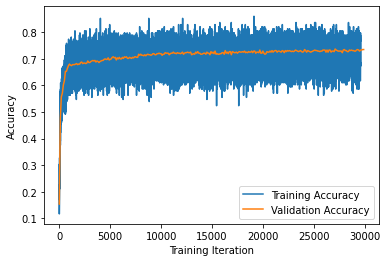

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()